# IOB for CMB spectra
---
**Environment**: Run `Conda env create -f operon.yaml` to replicate the environment I have tested. All dependence including `torch` are in `operon.yaml`;

**Data source**: infinity: /data77/xiaosheng/IOB_cmb_data/camb_new_TT.zip 

 cp and `unzip camb_new_TT.zip` under the `./data/camb_new/` folder; There are 10000 raw TT samples that is about 196 Mb. Data format: data[:6] are the 6 cosmological parameters; data[6:] are the TT power spectrum with l={2,3,...2500}
 
Similarly, for **Polarized CMB**:

- TE: /data77/xiaosheng/IOB_cmb_data/camb_new_TE.zip;
- EE: /data77/xiaosheng/IOB_cmb_data/camb_new_EE.zip;

can unzip under the `./data/camb_new/` folder for further use

**With jupyter notebook**

* Run [Generate the TT/TE/EE data (re-generate if need)](#create_cmb_data) (and uncomment the corresponding lines) to generate TE and EE data, can skip if do not need;
* Run [Create noised data](#noised_data) to post-process the TT data (adding cosmic variance and rescaling);
* Can just turn to [Train the encoder-decoder](#train), if the data are already post-processed;
* Can just turn to [Test and variation of the latents](#test), [SR with pyoperon](#operon), and [Inspect the data space (replacement of latents)](#weighted), if you do not want to retrain the model.

**With command lines**:

- **python generate_ps.py** (optionally)
- **python create_noised_data.py --cmb_type=TT**(optionally, need run at the first time)
- **python train.py --model_name=shallow96 --epoch=2048 --cmb_type=TT** (may need to comment `os.environ["CUDA_VISIBLE_DEVICES"]` in the beginning)
- **python test.py --model_name=shallow96 --cmb_type=TT** (may need to comment `os.environ["CUDA_VISIBLE_DEVICES"]` in the beginning)
- **python operon.py --model_name=shallow96 --cmb_type=TT --operon_name=run1**
- **python replace.py --model_name=shallow96 --cmb_type=TT --operon_name=run1 --thin=200** (may need to comment `os.environ["CUDA_VISIBLE_DEVICES"]` in the beginning)

the last command will output two csv files "pareto\_good\_model\_\*" and "individuals\_good_model\_" under the `./data/sr/` folder. They are the "good" expressions of the first latent from operon. When replacing the first latent with the outputs from these expressions, the final weighted mse in the data space is less than 1. The two files correspond to the expressions from the pareto front and all 2000 individual expressions during each operon run.

**File structure** under `IOB_cmb`:
```
IOB_cmb
└───README.md
└───operon.yaml (environment)
└───data
|    └─── camb_new (raw data)
|    └─── camb_new_processed (processed data)
|    └─── sr (outputs of symbolic regression)
└───model (save the best checkpoint during training) 
└───process files
|    └─── generate_ps.py
|    └─── create_noised_data.py
|    └─── train.py
|    └─── test.py
|    └─── operon.py
|    └─── replace.py   
└───functional files
|   └─── operon_sklearn.py
|   └─── pytorchtools.py
|   └─── model_cmb.py
|   └─── load_data_cmb.py
└───example notebook
|   └─── IOB_for_CMB_spectra.ipynb
```

`References`
- [camb notebook](https://camb.readthedocs.io/en/latest/CAMBdemo.html)
- [pyoperon](https://github.com/heal-research/pyoperon)
- Refer to [Pytorch IOBs](https://github.com/maho3/pytorch-iobs) and [paper](https://arxiv.org/abs/2305.11213) for more about the IOB methodology and applications.

`Main contents`
* [Prepare the data](#data)
  - [Generate the TT/TE/EE data (re-generate if need)](#create_cmb_data)
  - [Create noised data](#noised_data)
* [Train the encoder-decoder](#train)
* [Test and variation of the latents](#test)
* [SR with pyoperon](#operon)
* [Inspect the data space](#weighted)

<a id='data'></a>
## Prepare the data

### Camb input parameters
Parameters $x$:  $\{x_0,x_1,x_2,x_3,x_4,x_5\}=\{\Omega_b h^2, \Omega_c h^2, \tau, A_s, n_s, h\}$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.4.0 installed at /home/zxs/miniconda3/envs/operon/lib/python3.9/site-packages/camb


In [58]:
cmb_para=np.load('./data/camb_new_processed/parameters.npy')
print (cmb_para.shape)

(10000, 6)


(array([ 961.,  994.,  969.,  992., 1024.,  991., 1008., 1005.,  991.,
        1065.]),
 array([0.05000186, 0.05250157, 0.05500127, 0.05750098, 0.06000068,
        0.06250039, 0.06500009, 0.0674998 , 0.06999951, 0.07249921,
        0.07499892]),
 <BarContainer object of 10 artists>)

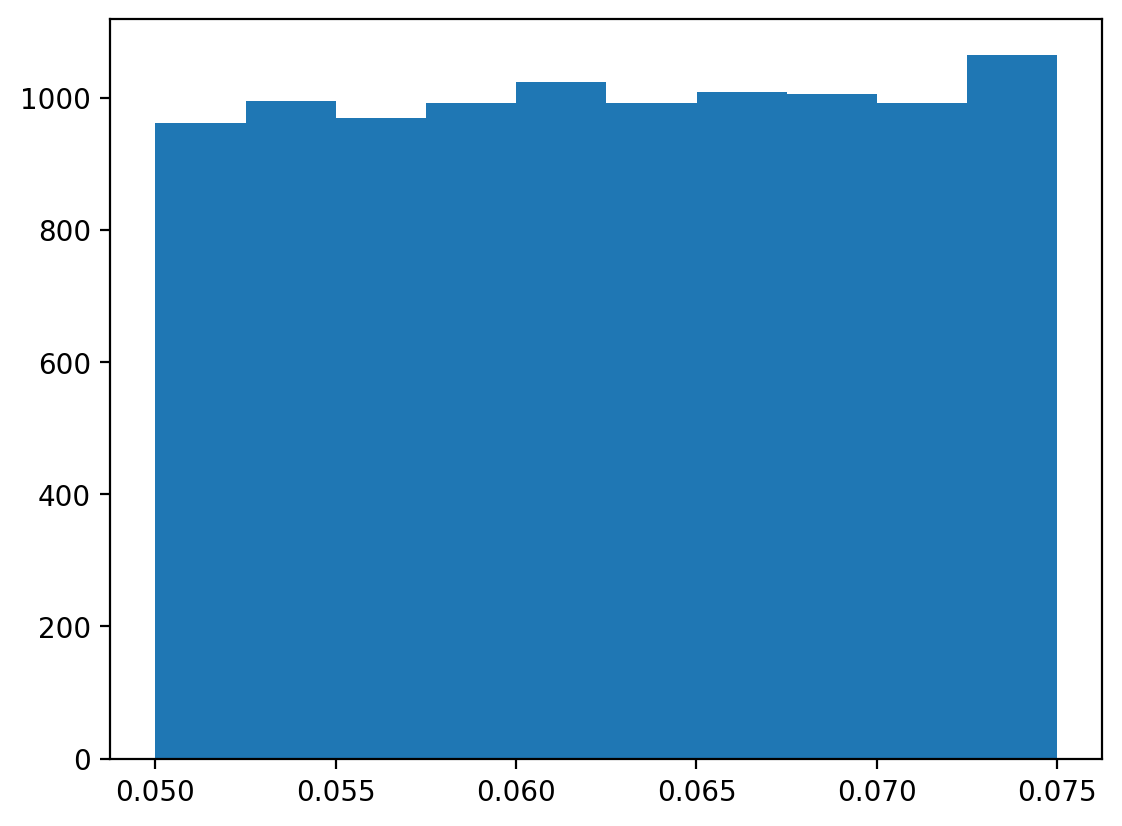

In [6]:
plt.hist(cmb_para[:,2])

In [7]:
names=['Omega_b h^2', 'Omega_c h^2', 'tau','A_s', 'n_s', 'h']
for i in range(6):
    if i!=3:
        print (r"{:s}:[{:.4f},{:.4f}]".format(names[i],np.min(cmb_para[:,i]),np.max(cmb_para[:,i])))
    else:
        print (r"{:s}:[{:.4e},{:.4e}]".format(names[i],np.min(cmb_para[:,i]),np.max(cmb_para[:,i])))

Omega_b h^2:[0.0074,0.0445]
Omega_c h^2:[0.0362,0.1897]
tau:[0.0500,0.0750]
A_s:[1.6001e-09,2.2667e-09]
n_s:[0.9333,1.0000]
h:[0.6000,0.8000]


<a id='create_cmb_data'></a>
### Generate the TT/TE/EE data (re-generate if need)

In [ ]:
import os
import numpy as np
import multiprocessing
import camb
from camb import model, initialpower

cmb_para=np.load('./data/camb_new_processed/parameters.npy')
n_sample=cmb_para.shape[0]

def cal_camb(i):
    camb_TT_new=np.zeros((2499+6)) # l={2,3,...2500}, n_param = 6
    camb_TE_new=np.zeros((2499+6))
    camb_EE_new=np.zeros((2499+6))
    
    #Set up a new set of parameters for CAMB
    pars = camb.CAMBparams()
    #This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
    pars.set_cosmology(H0=cmb_para[i,5]*100, ombh2=cmb_para[i,0], omch2=cmb_para[i,1], mnu=0.06, omk=0, tau=cmb_para[i,2])
    pars.InitPower.set_params(As=cmb_para[i,3], ns=cmb_para[i,4], r=0)
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
    unlensedCL=powers['unlensed_scalar']
    camb_TT_new[6:]=unlensedCL[2:2501,0] # TT
    #camb_TE_new[6:]=unlensedCL[2:2501,3] # TE
    #camb_EE_new[6:]=unlensedCL[2:2501,1] # EE
    camb_TT_new[:6]=cmb_para[i,:]
    #camb_TE_new[:6]=cmb_para[i,:]
    #camb_EE_new[:6]=cmb_para[i,:]

    np.save(f'./data/camb_new/camb_TT_{i}.npy', camb_TT_new)
    #np.save(f'./data/cmb/camb_new/camb_TE_{i}.npy', camb_TE_new)
    #np.save(f'./data/cmb/camb_new/camb_EE_{i}.npy', camb_EE_new)

for i in range(6616,n_sample):
    cal_camb(i)
#if __name__ == '__main__':
##    cores = multiprocessing.cpu_count()
#    print (cores)
#    pool = multiprocessing.Pool(processes=20)
#    num = range(n_sample)
#    pool.map(cal_camb, num)

<a id='noised_data'></a>
### Create noised data

Data: CMB $C_l$ (TT), maximum $l$: 2500

Data variance: $Var = \frac{2}{2l+1}C_l^2$

The model we used in **camb** package considers "one massive neutrino and helium set using BBN consistency" — $m_\nu=0.06$. Also, curvature of the universe $\Omega_k=0$, the tensor-to-scalar ratio $r=0$ and unlensed $C_l$ is calculated.

Preprocessing: 
1. Parameters:
$x^\prime=\frac{x-min(x)}{max(x)-min(x)}$
2. Data:
$C_l = C_l + N(0,\mathrm{sqrt}(Var))-\mathrm{min}+1$ (positive values), $C_l^\prime=log_{10}(C_l)$, $C_l^{\prime \prime}=\frac{C_l^\prime-min(C_l^\prime)}{max(C_l^\prime)-min(C_l^\prime)}$
3. Error propagation

In [2]:
import glob
files=glob.glob('./data/camb_new/*TT*npy')
data=[]
for i in range(len(files)):
    d=np.load(files[i])
    data.append(d)
data=np.array(data)
l=np.arange(2,2501)

error=(2/(2*l+1))*data[:,6:]**2

np.random.seed(0)
data_noise = np.random.normal(0,np.sqrt(error))+data[:,6:]
min_temp = np.min(data_noise)
data_noise = data_noise - min_temp + 1 # Ensure a positive array

#### The rescaled powerspectra

In [3]:
para_min=np.min(data[:,:6],axis=0)
para_max=np.max(data[:,:6],axis=0)
para_norm=(data[:,:6]-para_min)/(para_max-para_min)

data_min=np.min(np.log10(data_noise),axis=0)
data_max=np.max(np.log10(data_noise),axis=0)

data_norm=(np.log10(data_noise)-data_min)/(data_max-data_min)
err_norm=error/(data_max-data_min)**2/(data_noise*np.log(10))**2

np.save('./data/camb_new_processed/p_normed_new_noised.npy',para_norm)
np.save('./data/camb_new_processed/d_normed_new_noised.npy',data_norm)
np.save('./data/camb_new_processed/e_normed_new_noised.npy',err_norm)

In [4]:
np.save('./data/camb_new_processed/min_temp.npy',min_temp)
np.save('./data/camb_new_processed/data_min.npy',data_min)
np.save('./data/camb_new_processed/data_max.npy',data_max)

#### The rescaled mean of the powerspectra

In [5]:
data_noise_mean = data[:,6:]
data_noise_mean = data_noise_mean - min_temp + 1

In [6]:
# Save the mean spectra
data_norm_mean=(np.log10(data_noise_mean)-data_min)/(data_max-data_min)
np.save('./data/camb_new_processed/d_normed_new_noised_mean.npy',data_norm_mean)

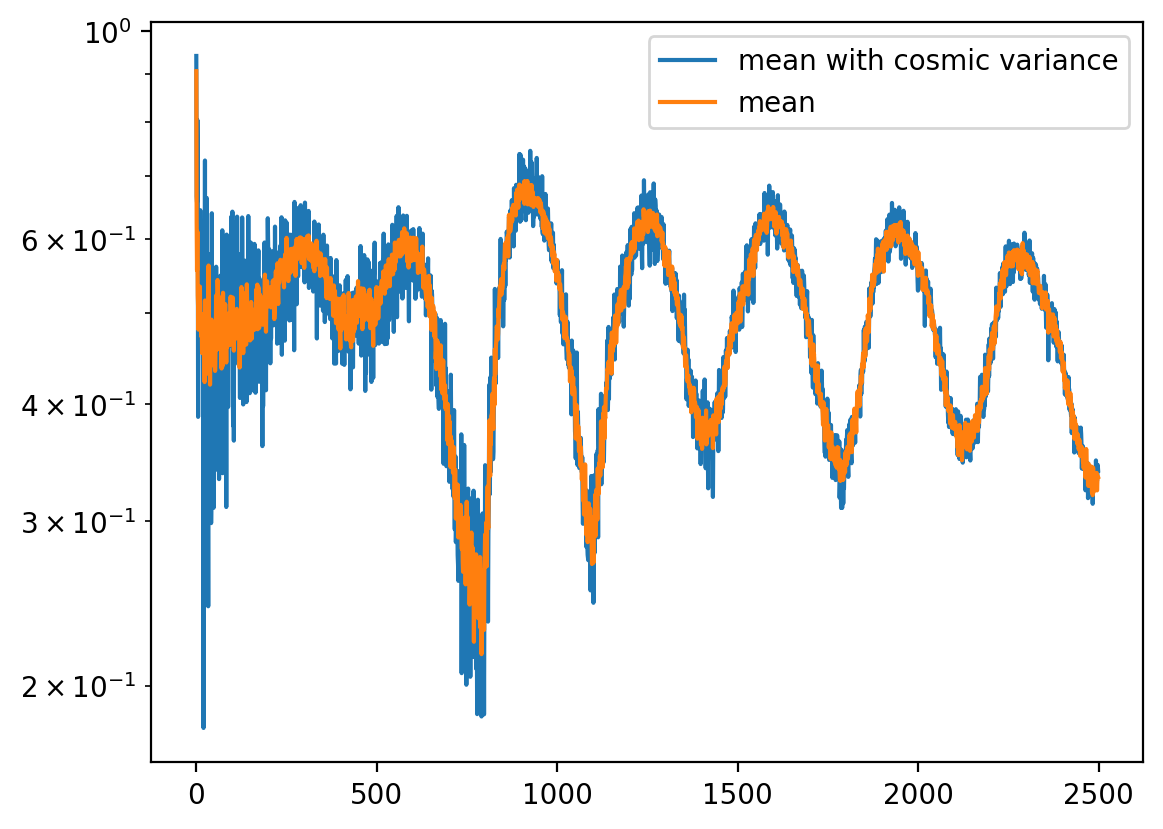

In [12]:
# Plot the data
plt.plot(np.arange(2,2501),data_norm[0],label='mean with cosmic variance')
plt.plot(np.arange(2,2501),data_norm_mean[0],label='mean')
plt.legend()
plt.yscale('log')

<a id='train'></a>
## Train the encoder-decoder
NN architecture: 

input-96(+ReLU)-6(bottleneck)-96(+ReLU)-512(+ReLU)+output, trained with IOB.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5" # depend on the GPU devices

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.optim as optim
from torch.utils.data import random_split
from pytorchtools import EarlyStopping
from random import randint, random
from torch.utils.data import Dataset
from torch import nn
from model_cmb import Encoder_cmb, Decoder_cmb, maskin_cmb
from load_data_cmb import CMBDataset

############################################################### Key parameters to vary
name='shallow96' # The basic name of this experiments
d_encode=6 #128, the bottleneck dimension
lr= 1e-5
num_epochs =2048 #2048
patience=20 # The patience for early stopping of the training. 
################################################################

### Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

### Prepare the data
data_dir = './data/camb_new_processed/d_normed_new_noised.npy'
data_mean_dir = './data/camb_new_processed/d_normed_new_noised_mean.npy'
para_dir = './data/camb_new_processed/p_normed_new_noised.npy'
err_dir = './data/camb_new_processed/e_normed_new_noised.npy'

batch_size = 128
dataset = CMBDataset(data_dir,data_mean_dir,para_dir,err_dir)

torch.manual_seed(43)
val_size = 500 
test_size = 500
train_size = len(dataset) - val_size - test_size
X_train, X_valid, X_test= random_split(dataset, [train_size, val_size, test_size])

# data loader setup
train_loader = torch.utils.data.DataLoader(X_train,batch_size=batch_size,shuffle=True,num_workers=0,pin_memory=(device == device))
valid_loader = torch.utils.data.DataLoader(X_valid,batch_size=batch_size,shuffle=True,num_workers=0,pin_memory=(device == device))
test_loader = torch.utils.data.DataLoader(X_test,batch_size=batch_size,shuffle=True,num_workers=0,pin_memory=(device == device))
    
### Initialize the networks
encoder = Encoder_cmb(encoded_space_dim=d_encode)
decoder = Decoder_cmb(encoded_space_dim=d_encode)
maskin = maskin_cmb()

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': maskin.parameters()},
    {'params': decoder.parameters()}
]

### Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
maskin.to(device)

### Define the loss function
#loss_fn = torch.nn.MSELoss()
def loss_fn(output, target, weight):
    loss = torch.mean((output - target)**2/weight)
    return loss

### Define an optimizer (both for the encoder and the decoder)
optim = torch.optim.Adam(params_to_optimize, lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', patience=5, factor=0.1)

### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,epoch):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []

    # Iterate the dataloader
    for data_batch,data_batch_mean,param,err in dataloader:
        data_batch = data_batch.to(device)
        data_batch_mean = data_batch_mean.to(device)
        param = param.to(device)
        err = err.to(device)
        # Encode data
        encoded_data = encoder(param) 
        maskin_data = maskin(encoded_data)
        
        # Initialize the loss
        loss=torch.tensor(0,dtype=torch.float32).to(device)
        
        range_index=torch.arange(1, d_encode+1)
        for x_index in range(d_encode+1):
            mask1 = range_index.le(x_index).unsqueeze(0).to(device)
            loss+=loss_fn(data_batch_mean[:,0,:], decoder(maskin_data*mask1),err)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


### Testing function
def valid_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = [] # For the decoded (reconstructed data)
        conc_data = [] # Which is the real input data
        conc_data_mean = [] # For the real mean data (for each set of parameters)
        conc_param = [] # For the parameters
        conc_err = [] # For the cosmic variance
        for data_batch,data_batch_mean,param,err in dataloader:
            data_batch = data_batch.to(device)
            data_batch_mean = data_batch_mean.to(device)
            param = param.to(device)
            err = err.to(device)
            # Encode data
            encoded_data= encoder(param)
            maskin_data = maskin(encoded_data)
            # Decode data
            decoded_data = decoder(maskin_data)
            # Append the network output and the original data to the lists
            conc_out.append(decoded_data.cpu())
            conc_data.append(data_batch.cpu())
            conc_data_mean.append(data_batch_mean.cpu())
            conc_err.append(err.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_data = torch.cat(conc_data)
        conc_data_mean = torch.cat(conc_data_mean)
        conc_err = torch.cat(conc_err)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_data_mean[:,0,:],conc_err)
    return val_loss.data

### Initialize the earlystoping
early_stopping = EarlyStopping(patience=patience, verbose=True)

### The training part
# Define the checkpoint path
state_save_early_path='./model/checkpoint_%s.tar'%name

number_of_params = sum(x.numel() for x in decoder.parameters())
print(f"Number of parameters: {number_of_params}")
    
for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim,epoch)
    val_loss = valid_epoch(encoder,decoder,device,valid_loader,loss_fn)
    scheduler.step(val_loss)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {} \t name {}'.format(epoch + 1, num_epochs,train_loss,val_loss,name))
    model_state = {
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'maskin_state_dict': maskin.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'val_loss': val_loss
            }
    early_stopping(val_loss, model_state,state_save_early_path)
    if early_stopping.early_stop or epoch==num_epochs-1:
        if early_stopping.early_stop:
            print("Early stopping")
        print ("Stop training!")
        break



Selected device: cuda
Number of parameters: 1285571
	 partial train loss (single batch): 4448.810059
	 partial train loss (single batch): 4370.561035
	 partial train loss (single batch): 4406.799805
	 partial train loss (single batch): 4258.772461
	 partial train loss (single batch): 4386.056152
	 partial train loss (single batch): 4418.154297
	 partial train loss (single batch): 4290.126953
	 partial train loss (single batch): 4352.541016
	 partial train loss (single batch): 4193.605469
	 partial train loss (single batch): 4376.111816
	 partial train loss (single batch): 4158.965820
	 partial train loss (single batch): 4184.773438
	 partial train loss (single batch): 4284.333984
	 partial train loss (single batch): 4232.928223
	 partial train loss (single batch): 4287.879883
	 partial train loss (single batch): 4232.497070
	 partial train loss (single batch): 4098.395020
	 partial train loss (single batch): 4179.505859
	 partial train loss (single batch): 4217.209473
	 partial train l

	 partial train loss (single batch): 2674.268066
	 partial train loss (single batch): 2670.500244
	 partial train loss (single batch): 2738.682129
	 partial train loss (single batch): 2543.122070
	 partial train loss (single batch): 2550.534668
	 partial train loss (single batch): 2724.960449
	 partial train loss (single batch): 2728.244385
	 partial train loss (single batch): 2783.139893
	 partial train loss (single batch): 2737.327881
	 partial train loss (single batch): 2690.822998
	 partial train loss (single batch): 2800.845947
	 partial train loss (single batch): 2653.373047
	 partial train loss (single batch): 2683.730225
	 partial train loss (single batch): 2655.509521
	 partial train loss (single batch): 2743.735352
	 partial train loss (single batch): 2757.450195
	 partial train loss (single batch): 2585.757324
	 partial train loss (single batch): 2623.744873
	 partial train loss (single batch): 2699.619141
	 partial train loss (single batch): 2674.647217
	 partial train loss

	 partial train loss (single batch): 1917.433105
	 partial train loss (single batch): 1704.500244
	 partial train loss (single batch): 1799.426514
	 partial train loss (single batch): 1725.342529
	 partial train loss (single batch): 1734.416138
	 partial train loss (single batch): 1836.835449
	 partial train loss (single batch): 1844.355469
	 partial train loss (single batch): 1882.006104
	 partial train loss (single batch): 1827.862671
	 partial train loss (single batch): 1760.605225
	 partial train loss (single batch): 1803.231323
	 partial train loss (single batch): 1800.089355
	 partial train loss (single batch): 1813.925537
	 partial train loss (single batch): 1817.604004
	 partial train loss (single batch): 1658.870972
	 partial train loss (single batch): 1779.189697

 EPOCH 5/2048 	 train loss 1899.09423828125 	 val loss 242.95936584472656 	 name shallow96
Validation loss decreased (287.373962 --> 242.959366).  Saving model ...
	 partial train loss (single batch): 1566.372070
	 

	 partial train loss (single batch): 1383.551758
	 partial train loss (single batch): 1294.776123
	 partial train loss (single batch): 1321.599976
	 partial train loss (single batch): 1388.995605
	 partial train loss (single batch): 1212.643066
	 partial train loss (single batch): 1231.399658
	 partial train loss (single batch): 1431.604736
	 partial train loss (single batch): 1320.530273
	 partial train loss (single batch): 1291.994995
	 partial train loss (single batch): 1268.697510
	 partial train loss (single batch): 1216.113525
	 partial train loss (single batch): 1240.611084
	 partial train loss (single batch): 1321.582520
	 partial train loss (single batch): 1265.603149
	 partial train loss (single batch): 1469.673706
	 partial train loss (single batch): 1302.350464
	 partial train loss (single batch): 1374.864990
	 partial train loss (single batch): 1232.037720
	 partial train loss (single batch): 1252.874634
	 partial train loss (single batch): 1401.836182
	 partial train loss

	 partial train loss (single batch): 1130.580078
	 partial train loss (single batch): 1185.665894
	 partial train loss (single batch): 1075.158691
	 partial train loss (single batch): 1069.702881
	 partial train loss (single batch): 1034.677490
	 partial train loss (single batch): 1143.065674
	 partial train loss (single batch): 938.497070
	 partial train loss (single batch): 993.971069
	 partial train loss (single batch): 971.764709
	 partial train loss (single batch): 1092.756958
	 partial train loss (single batch): 1135.903198
	 partial train loss (single batch): 1087.256226
	 partial train loss (single batch): 1087.469604
	 partial train loss (single batch): 970.531860
	 partial train loss (single batch): 1060.368286
	 partial train loss (single batch): 1119.049805
	 partial train loss (single batch): 1291.824707
	 partial train loss (single batch): 1037.407471
	 partial train loss (single batch): 1077.758545
	 partial train loss (single batch): 1066.285889
	 partial train loss (si

	 partial train loss (single batch): 985.087341
	 partial train loss (single batch): 924.438293
	 partial train loss (single batch): 954.357727

 EPOCH 12/2048 	 train loss 977.4751586914062 	 val loss 131.2115478515625 	 name shallow96
Validation loss decreased (135.792786 --> 131.211548).  Saving model ...
	 partial train loss (single batch): 1091.260498
	 partial train loss (single batch): 972.654053
	 partial train loss (single batch): 826.332214
	 partial train loss (single batch): 915.017883
	 partial train loss (single batch): 975.929688
	 partial train loss (single batch): 984.850220
	 partial train loss (single batch): 920.687378
	 partial train loss (single batch): 1107.009521
	 partial train loss (single batch): 1048.978271
	 partial train loss (single batch): 982.475830
	 partial train loss (single batch): 1058.155640
	 partial train loss (single batch): 815.412537
	 partial train loss (single batch): 1027.129517
	 partial train loss (single batch): 991.718018
	 partial tra

	 partial train loss (single batch): 858.148071
	 partial train loss (single batch): 833.465515
	 partial train loss (single batch): 826.500854
	 partial train loss (single batch): 899.779419
	 partial train loss (single batch): 873.812683
	 partial train loss (single batch): 929.196167
	 partial train loss (single batch): 924.386597
	 partial train loss (single batch): 1098.352661
	 partial train loss (single batch): 833.308105
	 partial train loss (single batch): 1059.493286
	 partial train loss (single batch): 850.731445
	 partial train loss (single batch): 862.263245
	 partial train loss (single batch): 876.266418
	 partial train loss (single batch): 816.695801
	 partial train loss (single batch): 996.072021
	 partial train loss (single batch): 999.834595
	 partial train loss (single batch): 889.757874
	 partial train loss (single batch): 764.792175
	 partial train loss (single batch): 892.728027
	 partial train loss (single batch): 905.842651
	 partial train loss (single batch): 8

	 partial train loss (single batch): 823.361267
	 partial train loss (single batch): 834.465515
	 partial train loss (single batch): 911.640503
	 partial train loss (single batch): 859.429321
	 partial train loss (single batch): 787.387756
	 partial train loss (single batch): 897.289978
	 partial train loss (single batch): 984.260193
	 partial train loss (single batch): 767.718506
	 partial train loss (single batch): 634.458801
	 partial train loss (single batch): 849.579712
	 partial train loss (single batch): 1076.886719
	 partial train loss (single batch): 865.582214
	 partial train loss (single batch): 777.433044
	 partial train loss (single batch): 906.717468
	 partial train loss (single batch): 933.576416
	 partial train loss (single batch): 877.821899
	 partial train loss (single batch): 948.567200
	 partial train loss (single batch): 752.341553
	 partial train loss (single batch): 702.941528

 EPOCH 17/2048 	 train loss 870.8939208984375 	 val loss 118.35678100585938 	 name sha

	 partial train loss (single batch): 903.199707
	 partial train loss (single batch): 982.124939
	 partial train loss (single batch): 881.435425
	 partial train loss (single batch): 695.739990
	 partial train loss (single batch): 896.657593
	 partial train loss (single batch): 937.853882
	 partial train loss (single batch): 788.394226
	 partial train loss (single batch): 952.493958
	 partial train loss (single batch): 793.785706
	 partial train loss (single batch): 858.331421
	 partial train loss (single batch): 847.526611
	 partial train loss (single batch): 816.466675
	 partial train loss (single batch): 758.538574
	 partial train loss (single batch): 814.698181
	 partial train loss (single batch): 955.447754
	 partial train loss (single batch): 750.773132
	 partial train loss (single batch): 881.157654
	 partial train loss (single batch): 772.677612
	 partial train loss (single batch): 786.297729
	 partial train loss (single batch): 856.667908
	 partial train loss (single batch): 820

	 partial train loss (single batch): 944.322632
	 partial train loss (single batch): 855.121094
	 partial train loss (single batch): 873.216309
	 partial train loss (single batch): 676.952332
	 partial train loss (single batch): 898.459900
	 partial train loss (single batch): 787.129272
	 partial train loss (single batch): 844.031250
	 partial train loss (single batch): 886.066101
	 partial train loss (single batch): 822.962402
	 partial train loss (single batch): 871.196289
	 partial train loss (single batch): 837.740967
	 partial train loss (single batch): 687.774109
	 partial train loss (single batch): 749.221375
	 partial train loss (single batch): 727.619324
	 partial train loss (single batch): 874.246521
	 partial train loss (single batch): 818.990723
	 partial train loss (single batch): 621.303650
	 partial train loss (single batch): 679.106445
	 partial train loss (single batch): 802.662292
	 partial train loss (single batch): 678.549377
	 partial train loss (single batch): 755

	 partial train loss (single batch): 838.659546
	 partial train loss (single batch): 910.664551
	 partial train loss (single batch): 742.639771
	 partial train loss (single batch): 922.126953
	 partial train loss (single batch): 827.049438
	 partial train loss (single batch): 697.840698
	 partial train loss (single batch): 806.328186
	 partial train loss (single batch): 835.012207

 EPOCH 24/2048 	 train loss 793.8506469726562 	 val loss 103.6165771484375 	 name shallow96
Validation loss decreased (105.962029 --> 103.616577).  Saving model ...
	 partial train loss (single batch): 816.357056
	 partial train loss (single batch): 882.101929
	 partial train loss (single batch): 810.704712
	 partial train loss (single batch): 797.168152
	 partial train loss (single batch): 784.449890
	 partial train loss (single batch): 925.820801
	 partial train loss (single batch): 740.615173
	 partial train loss (single batch): 845.754822
	 partial train loss (single batch): 1047.359009
	 partial train l

	 partial train loss (single batch): 703.042725
	 partial train loss (single batch): 835.426697
	 partial train loss (single batch): 796.102234
	 partial train loss (single batch): 736.596191
	 partial train loss (single batch): 689.490906
	 partial train loss (single batch): 734.058472
	 partial train loss (single batch): 790.532471
	 partial train loss (single batch): 779.635071
	 partial train loss (single batch): 635.266663
	 partial train loss (single batch): 785.401306
	 partial train loss (single batch): 752.308960
	 partial train loss (single batch): 644.221375
	 partial train loss (single batch): 717.785400
	 partial train loss (single batch): 816.871948
	 partial train loss (single batch): 690.413635
	 partial train loss (single batch): 947.383667
	 partial train loss (single batch): 850.286621
	 partial train loss (single batch): 776.655518
	 partial train loss (single batch): 780.288635
	 partial train loss (single batch): 667.764465
	 partial train loss (single batch): 742

	 partial train loss (single batch): 700.756165
	 partial train loss (single batch): 800.964478
	 partial train loss (single batch): 669.620972
	 partial train loss (single batch): 744.768799
	 partial train loss (single batch): 638.926208
	 partial train loss (single batch): 745.773621
	 partial train loss (single batch): 666.740967
	 partial train loss (single batch): 647.509399
	 partial train loss (single batch): 755.727478
	 partial train loss (single batch): 683.334778
	 partial train loss (single batch): 763.799194
	 partial train loss (single batch): 896.801086
	 partial train loss (single batch): 681.638123
	 partial train loss (single batch): 747.202881
	 partial train loss (single batch): 714.083130
	 partial train loss (single batch): 689.005798
	 partial train loss (single batch): 671.383789
	 partial train loss (single batch): 824.493896
	 partial train loss (single batch): 709.300964
	 partial train loss (single batch): 675.652893
	 partial train loss (single batch): 754

	 partial train loss (single batch): 695.469299
	 partial train loss (single batch): 684.869141
	 partial train loss (single batch): 652.128906
	 partial train loss (single batch): 828.183716
	 partial train loss (single batch): 680.927795
	 partial train loss (single batch): 738.642639
	 partial train loss (single batch): 656.539917
	 partial train loss (single batch): 600.683838
	 partial train loss (single batch): 740.424927
	 partial train loss (single batch): 603.701843
	 partial train loss (single batch): 699.489868
	 partial train loss (single batch): 753.690674
	 partial train loss (single batch): 682.746582
	 partial train loss (single batch): 683.495728
	 partial train loss (single batch): 708.391724
	 partial train loss (single batch): 816.770874
	 partial train loss (single batch): 624.895691
	 partial train loss (single batch): 858.134766
	 partial train loss (single batch): 718.436890
	 partial train loss (single batch): 724.474670
	 partial train loss (single batch): 667

	 partial train loss (single batch): 662.483521
	 partial train loss (single batch): 666.223450
	 partial train loss (single batch): 762.137695
	 partial train loss (single batch): 690.054993
	 partial train loss (single batch): 586.097351
	 partial train loss (single batch): 659.071472
	 partial train loss (single batch): 623.289246
	 partial train loss (single batch): 732.649902
	 partial train loss (single batch): 685.731445
	 partial train loss (single batch): 562.955872
	 partial train loss (single batch): 710.884399
	 partial train loss (single batch): 645.814026
	 partial train loss (single batch): 618.439880
	 partial train loss (single batch): 673.650391
	 partial train loss (single batch): 684.136353
	 partial train loss (single batch): 617.628418
	 partial train loss (single batch): 695.167542
	 partial train loss (single batch): 711.646606
	 partial train loss (single batch): 657.737427
	 partial train loss (single batch): 710.598755
	 partial train loss (single batch): 674

	 partial train loss (single batch): 654.904053
	 partial train loss (single batch): 563.043457
	 partial train loss (single batch): 682.692444
	 partial train loss (single batch): 609.283752
	 partial train loss (single batch): 623.744141
	 partial train loss (single batch): 607.987366
	 partial train loss (single batch): 576.252136
	 partial train loss (single batch): 684.883728
	 partial train loss (single batch): 624.514893
	 partial train loss (single batch): 526.193542
	 partial train loss (single batch): 570.771729
	 partial train loss (single batch): 519.884521

 EPOCH 36/2048 	 train loss 645.1451416015625 	 val loss 73.33026885986328 	 name shallow96
Validation loss decreased (75.727478 --> 73.330269).  Saving model ...
	 partial train loss (single batch): 633.599060
	 partial train loss (single batch): 756.315186
	 partial train loss (single batch): 573.143372
	 partial train loss (single batch): 691.251587
	 partial train loss (single batch): 618.345093
	 partial train loss

	 partial train loss (single batch): 557.466370
	 partial train loss (single batch): 545.374939
	 partial train loss (single batch): 601.920532
	 partial train loss (single batch): 609.162354
	 partial train loss (single batch): 530.833374
	 partial train loss (single batch): 584.277283
	 partial train loss (single batch): 689.304504
	 partial train loss (single batch): 612.114502
	 partial train loss (single batch): 662.527405
	 partial train loss (single batch): 673.214233
	 partial train loss (single batch): 612.874207
	 partial train loss (single batch): 637.434204
	 partial train loss (single batch): 656.995789
	 partial train loss (single batch): 649.113220
	 partial train loss (single batch): 589.755005
	 partial train loss (single batch): 636.863525
	 partial train loss (single batch): 529.408447
	 partial train loss (single batch): 693.804688
	 partial train loss (single batch): 625.672913
	 partial train loss (single batch): 558.673157
	 partial train loss (single batch): 587

	 partial train loss (single batch): 506.660950
	 partial train loss (single batch): 483.448547
	 partial train loss (single batch): 724.380920
	 partial train loss (single batch): 583.666748
	 partial train loss (single batch): 540.638855
	 partial train loss (single batch): 537.328003
	 partial train loss (single batch): 534.744324
	 partial train loss (single batch): 574.433105
	 partial train loss (single batch): 621.878662
	 partial train loss (single batch): 620.126831
	 partial train loss (single batch): 609.540955
	 partial train loss (single batch): 604.793762
	 partial train loss (single batch): 627.034851
	 partial train loss (single batch): 503.395020
	 partial train loss (single batch): 602.720581
	 partial train loss (single batch): 563.309021
	 partial train loss (single batch): 640.078125
	 partial train loss (single batch): 634.133179
	 partial train loss (single batch): 593.819275
	 partial train loss (single batch): 712.731750
	 partial train loss (single batch): 543


 EPOCH 43/2048 	 train loss 570.6465454101562 	 val loss 59.05489730834961 	 name shallow96
Validation loss decreased (61.427586 --> 59.054897).  Saving model ...
	 partial train loss (single batch): 553.710144
	 partial train loss (single batch): 538.140137
	 partial train loss (single batch): 574.466064
	 partial train loss (single batch): 640.677979
	 partial train loss (single batch): 528.468872
	 partial train loss (single batch): 560.855713
	 partial train loss (single batch): 496.246826
	 partial train loss (single batch): 570.204407
	 partial train loss (single batch): 573.198730
	 partial train loss (single batch): 630.763672
	 partial train loss (single batch): 545.120422
	 partial train loss (single batch): 491.699860
	 partial train loss (single batch): 565.227844
	 partial train loss (single batch): 477.563599
	 partial train loss (single batch): 500.263031
	 partial train loss (single batch): 552.235962
	 partial train loss (single batch): 593.128296
	 partial train loss

	 partial train loss (single batch): 525.006165
	 partial train loss (single batch): 523.143127
	 partial train loss (single batch): 493.222626
	 partial train loss (single batch): 597.187012
	 partial train loss (single batch): 538.321838
	 partial train loss (single batch): 502.792450
	 partial train loss (single batch): 584.859741
	 partial train loss (single batch): 538.075684
	 partial train loss (single batch): 463.186768
	 partial train loss (single batch): 536.708496
	 partial train loss (single batch): 508.457031
	 partial train loss (single batch): 581.663330
	 partial train loss (single batch): 514.152161
	 partial train loss (single batch): 480.546204
	 partial train loss (single batch): 556.123047
	 partial train loss (single batch): 513.156738
	 partial train loss (single batch): 499.287598
	 partial train loss (single batch): 535.924561
	 partial train loss (single batch): 570.498535
	 partial train loss (single batch): 559.858337
	 partial train loss (single batch): 604

	 partial train loss (single batch): 538.265930
	 partial train loss (single batch): 535.309814
	 partial train loss (single batch): 471.965607
	 partial train loss (single batch): 547.958984
	 partial train loss (single batch): 526.957153
	 partial train loss (single batch): 545.247925
	 partial train loss (single batch): 426.858582
	 partial train loss (single batch): 656.641113
	 partial train loss (single batch): 543.089539
	 partial train loss (single batch): 556.680054
	 partial train loss (single batch): 471.849823
	 partial train loss (single batch): 476.029480
	 partial train loss (single batch): 542.980469
	 partial train loss (single batch): 489.019073
	 partial train loss (single batch): 542.375305
	 partial train loss (single batch): 491.606140

 EPOCH 48/2048 	 train loss 522.8670043945312 	 val loss 52.270042419433594 	 name shallow96
Validation loss decreased (53.059410 --> 52.270042).  Saving model ...
	 partial train loss (single batch): 503.072601
	 partial train los

	 partial train loss (single batch): 444.823029
	 partial train loss (single batch): 491.585693
	 partial train loss (single batch): 655.004211
	 partial train loss (single batch): 558.271851
	 partial train loss (single batch): 469.760773
	 partial train loss (single batch): 454.558197
	 partial train loss (single batch): 540.284546
	 partial train loss (single batch): 449.899139
	 partial train loss (single batch): 477.635742
	 partial train loss (single batch): 572.726379
	 partial train loss (single batch): 487.908173
	 partial train loss (single batch): 583.338745
	 partial train loss (single batch): 529.143127
	 partial train loss (single batch): 423.142914
	 partial train loss (single batch): 503.986298
	 partial train loss (single batch): 552.170227
	 partial train loss (single batch): 435.762146
	 partial train loss (single batch): 489.400696
	 partial train loss (single batch): 563.762390
	 partial train loss (single batch): 471.416901
	 partial train loss (single batch): 449

	 partial train loss (single batch): 449.304657
	 partial train loss (single batch): 411.446533
	 partial train loss (single batch): 463.798889
	 partial train loss (single batch): 479.510529
	 partial train loss (single batch): 433.343658
	 partial train loss (single batch): 401.415588
	 partial train loss (single batch): 473.656433
	 partial train loss (single batch): 471.778259
	 partial train loss (single batch): 508.353607
	 partial train loss (single batch): 469.250580
	 partial train loss (single batch): 486.848267
	 partial train loss (single batch): 526.214172
	 partial train loss (single batch): 436.676422
	 partial train loss (single batch): 543.450867
	 partial train loss (single batch): 436.173004
	 partial train loss (single batch): 521.205505
	 partial train loss (single batch): 557.067566
	 partial train loss (single batch): 439.258301
	 partial train loss (single batch): 428.140564
	 partial train loss (single batch): 405.816101
	 partial train loss (single batch): 413

	 partial train loss (single batch): 495.617126
	 partial train loss (single batch): 467.107361

 EPOCH 55/2048 	 train loss 468.23944091796875 	 val loss 44.659523010253906 	 name shallow96
Validation loss decreased (45.802296 --> 44.659523).  Saving model ...
	 partial train loss (single batch): 414.393280
	 partial train loss (single batch): 456.377991
	 partial train loss (single batch): 443.695465
	 partial train loss (single batch): 491.286072
	 partial train loss (single batch): 443.356934
	 partial train loss (single batch): 479.244385
	 partial train loss (single batch): 401.191742
	 partial train loss (single batch): 412.529816
	 partial train loss (single batch): 513.922852
	 partial train loss (single batch): 513.713867
	 partial train loss (single batch): 448.548553
	 partial train loss (single batch): 431.093384
	 partial train loss (single batch): 483.060242
	 partial train loss (single batch): 411.493744
	 partial train loss (single batch): 434.235260
	 partial train lo

	 partial train loss (single batch): 461.081024
	 partial train loss (single batch): 450.274841
	 partial train loss (single batch): 447.251770
	 partial train loss (single batch): 462.937500
	 partial train loss (single batch): 410.612366
	 partial train loss (single batch): 426.212219
	 partial train loss (single batch): 443.277466
	 partial train loss (single batch): 439.909393
	 partial train loss (single batch): 484.689178
	 partial train loss (single batch): 506.706848
	 partial train loss (single batch): 441.405060
	 partial train loss (single batch): 413.114929
	 partial train loss (single batch): 415.959900
	 partial train loss (single batch): 423.044434
	 partial train loss (single batch): 396.485352
	 partial train loss (single batch): 449.828125
	 partial train loss (single batch): 439.518066
	 partial train loss (single batch): 491.466431
	 partial train loss (single batch): 415.309052
	 partial train loss (single batch): 427.709656
	 partial train loss (single batch): 469

	 partial train loss (single batch): 344.490204
	 partial train loss (single batch): 440.119537
	 partial train loss (single batch): 443.220306
	 partial train loss (single batch): 439.513428
	 partial train loss (single batch): 474.778931
	 partial train loss (single batch): 394.448120
	 partial train loss (single batch): 411.639740
	 partial train loss (single batch): 410.798889
	 partial train loss (single batch): 430.289673
	 partial train loss (single batch): 403.106720
	 partial train loss (single batch): 455.436615
	 partial train loss (single batch): 428.692963
	 partial train loss (single batch): 503.726410
	 partial train loss (single batch): 439.456360
	 partial train loss (single batch): 485.141693
	 partial train loss (single batch): 419.217346
	 partial train loss (single batch): 423.686218

 EPOCH 60/2048 	 train loss 438.22259521484375 	 val loss 41.172340393066406 	 name shallow96
Validation loss decreased (41.786385 --> 41.172340).  Saving model ...
	 partial train lo

	 partial train loss (single batch): 399.808502
	 partial train loss (single batch): 445.765289
	 partial train loss (single batch): 518.427856
	 partial train loss (single batch): 450.727173
	 partial train loss (single batch): 480.868835
	 partial train loss (single batch): 455.632904
	 partial train loss (single batch): 393.544983
	 partial train loss (single batch): 407.840851
	 partial train loss (single batch): 416.217621
	 partial train loss (single batch): 423.808533
	 partial train loss (single batch): 422.298553
	 partial train loss (single batch): 382.974121
	 partial train loss (single batch): 433.255676
	 partial train loss (single batch): 466.530853
	 partial train loss (single batch): 459.055542
	 partial train loss (single batch): 423.727997
	 partial train loss (single batch): 438.307739
	 partial train loss (single batch): 411.758636
	 partial train loss (single batch): 420.224823
	 partial train loss (single batch): 414.569031
	 partial train loss (single batch): 405

	 partial train loss (single batch): 371.093658
	 partial train loss (single batch): 370.252625
	 partial train loss (single batch): 414.736115
	 partial train loss (single batch): 442.923096
	 partial train loss (single batch): 463.699524
	 partial train loss (single batch): 450.721313
	 partial train loss (single batch): 401.134033
	 partial train loss (single batch): 451.600861
	 partial train loss (single batch): 408.479919
	 partial train loss (single batch): 428.980164
	 partial train loss (single batch): 459.451935
	 partial train loss (single batch): 382.413025
	 partial train loss (single batch): 418.904358
	 partial train loss (single batch): 412.909912
	 partial train loss (single batch): 430.880768
	 partial train loss (single batch): 372.241821
	 partial train loss (single batch): 393.645081
	 partial train loss (single batch): 460.132874
	 partial train loss (single batch): 478.743103
	 partial train loss (single batch): 466.076965
	 partial train loss (single batch): 416


 EPOCH 67/2048 	 train loss 409.5621337890625 	 val loss 37.673065185546875 	 name shallow96
Validation loss decreased (38.359543 --> 37.673065).  Saving model ...
	 partial train loss (single batch): 385.181458
	 partial train loss (single batch): 440.362061
	 partial train loss (single batch): 429.433899
	 partial train loss (single batch): 366.854370
	 partial train loss (single batch): 372.901947
	 partial train loss (single batch): 427.951874
	 partial train loss (single batch): 404.671509
	 partial train loss (single batch): 440.762054
	 partial train loss (single batch): 453.775391
	 partial train loss (single batch): 411.263458
	 partial train loss (single batch): 425.858795
	 partial train loss (single batch): 347.587646
	 partial train loss (single batch): 398.500366
	 partial train loss (single batch): 400.674866
	 partial train loss (single batch): 432.061005
	 partial train loss (single batch): 369.169250
	 partial train loss (single batch): 414.707153
	 partial train los

	 partial train loss (single batch): 353.115295
	 partial train loss (single batch): 425.156158
	 partial train loss (single batch): 371.891235
	 partial train loss (single batch): 402.520844
	 partial train loss (single batch): 467.639893
	 partial train loss (single batch): 404.565125
	 partial train loss (single batch): 372.983337
	 partial train loss (single batch): 391.395691
	 partial train loss (single batch): 396.075928
	 partial train loss (single batch): 392.581848
	 partial train loss (single batch): 398.707367
	 partial train loss (single batch): 375.906555
	 partial train loss (single batch): 343.183746
	 partial train loss (single batch): 446.859100
	 partial train loss (single batch): 353.990540
	 partial train loss (single batch): 393.081329
	 partial train loss (single batch): 399.150909
	 partial train loss (single batch): 448.317902
	 partial train loss (single batch): 432.930420
	 partial train loss (single batch): 368.209961
	 partial train loss (single batch): 451

	 partial train loss (single batch): 367.205444
	 partial train loss (single batch): 362.477661
	 partial train loss (single batch): 336.547455
	 partial train loss (single batch): 369.865845
	 partial train loss (single batch): 373.799622
	 partial train loss (single batch): 440.241821
	 partial train loss (single batch): 344.181000
	 partial train loss (single batch): 447.641083
	 partial train loss (single batch): 383.277100
	 partial train loss (single batch): 322.771332
	 partial train loss (single batch): 372.009308
	 partial train loss (single batch): 386.044189
	 partial train loss (single batch): 362.782257
	 partial train loss (single batch): 378.968842
	 partial train loss (single batch): 399.808472
	 partial train loss (single batch): 463.256744
	 partial train loss (single batch): 369.515930
	 partial train loss (single batch): 436.692505
	 partial train loss (single batch): 429.925049
	 partial train loss (single batch): 337.197998
	 partial train loss (single batch): 315

	 partial train loss (single batch): 340.509399
	 partial train loss (single batch): 420.318573
	 partial train loss (single batch): 464.796753
	 partial train loss (single batch): 311.224121
	 partial train loss (single batch): 438.062317
	 partial train loss (single batch): 396.044434
	 partial train loss (single batch): 421.414581
	 partial train loss (single batch): 389.541473
	 partial train loss (single batch): 449.641174
	 partial train loss (single batch): 387.652771
	 partial train loss (single batch): 362.909546
	 partial train loss (single batch): 346.348053
	 partial train loss (single batch): 400.606873
	 partial train loss (single batch): 381.297028
	 partial train loss (single batch): 380.960541
	 partial train loss (single batch): 455.492126
	 partial train loss (single batch): 351.660248
	 partial train loss (single batch): 376.782135
	 partial train loss (single batch): 366.283752
	 partial train loss (single batch): 393.745483
	 partial train loss (single batch): 388

	 partial train loss (single batch): 355.674744
	 partial train loss (single batch): 379.772919
	 partial train loss (single batch): 360.163422
	 partial train loss (single batch): 419.875549
	 partial train loss (single batch): 354.955994
	 partial train loss (single batch): 387.033325
	 partial train loss (single batch): 399.735992
	 partial train loss (single batch): 395.153381
	 partial train loss (single batch): 374.739105
	 partial train loss (single batch): 397.656525
	 partial train loss (single batch): 368.023804
	 partial train loss (single batch): 436.878479
	 partial train loss (single batch): 405.915192
	 partial train loss (single batch): 402.908569
	 partial train loss (single batch): 387.604553
	 partial train loss (single batch): 310.616669
	 partial train loss (single batch): 408.811401
	 partial train loss (single batch): 373.427704
	 partial train loss (single batch): 378.342438
	 partial train loss (single batch): 383.235626
	 partial train loss (single batch): 345


 EPOCH 79/2048 	 train loss 376.115966796875 	 val loss 32.88800811767578 	 name shallow96
Validation loss decreased (33.198853 --> 32.888008).  Saving model ...
	 partial train loss (single batch): 444.178772
	 partial train loss (single batch): 339.446747
	 partial train loss (single batch): 368.163177
	 partial train loss (single batch): 392.171692
	 partial train loss (single batch): 366.597900
	 partial train loss (single batch): 405.071594
	 partial train loss (single batch): 439.455475
	 partial train loss (single batch): 459.719666
	 partial train loss (single batch): 367.904022
	 partial train loss (single batch): 331.637299
	 partial train loss (single batch): 364.792877
	 partial train loss (single batch): 378.434753
	 partial train loss (single batch): 363.987579
	 partial train loss (single batch): 400.274139
	 partial train loss (single batch): 329.372223
	 partial train loss (single batch): 377.638489
	 partial train loss (single batch): 339.613678
	 partial train loss 

	 partial train loss (single batch): 386.321228
	 partial train loss (single batch): 354.984436
	 partial train loss (single batch): 379.636688
	 partial train loss (single batch): 357.079712
	 partial train loss (single batch): 328.863770
	 partial train loss (single batch): 351.592987
	 partial train loss (single batch): 338.649353
	 partial train loss (single batch): 380.393280
	 partial train loss (single batch): 392.908813
	 partial train loss (single batch): 413.449951
	 partial train loss (single batch): 406.502960
	 partial train loss (single batch): 375.102020
	 partial train loss (single batch): 356.251587
	 partial train loss (single batch): 364.226746
	 partial train loss (single batch): 371.177582
	 partial train loss (single batch): 370.603394
	 partial train loss (single batch): 353.281281
	 partial train loss (single batch): 346.957214
	 partial train loss (single batch): 368.279541
	 partial train loss (single batch): 360.526215
	 partial train loss (single batch): 373

	 partial train loss (single batch): 345.493591
	 partial train loss (single batch): 306.833130
	 partial train loss (single batch): 372.487152
	 partial train loss (single batch): 333.126617
	 partial train loss (single batch): 408.211792
	 partial train loss (single batch): 398.941620
	 partial train loss (single batch): 318.901581
	 partial train loss (single batch): 421.984283
	 partial train loss (single batch): 344.870636
	 partial train loss (single batch): 362.970703
	 partial train loss (single batch): 473.527008
	 partial train loss (single batch): 405.761169
	 partial train loss (single batch): 375.149841
	 partial train loss (single batch): 362.779083
	 partial train loss (single batch): 326.436127
	 partial train loss (single batch): 358.016357
	 partial train loss (single batch): 363.845551
	 partial train loss (single batch): 482.803375
	 partial train loss (single batch): 358.090668
	 partial train loss (single batch): 369.977722
	 partial train loss (single batch): 358

	 partial train loss (single batch): 332.445404
	 partial train loss (single batch): 355.131714
	 partial train loss (single batch): 323.114502
	 partial train loss (single batch): 357.037537
	 partial train loss (single batch): 345.074799
	 partial train loss (single batch): 363.638824
	 partial train loss (single batch): 327.682312
	 partial train loss (single batch): 375.252045
	 partial train loss (single batch): 367.226074
	 partial train loss (single batch): 360.608002
	 partial train loss (single batch): 322.559998
	 partial train loss (single batch): 400.591766
	 partial train loss (single batch): 364.902374
	 partial train loss (single batch): 358.487610
	 partial train loss (single batch): 380.659485
	 partial train loss (single batch): 335.216644
	 partial train loss (single batch): 389.972229
	 partial train loss (single batch): 358.717621
	 partial train loss (single batch): 356.297272
	 partial train loss (single batch): 333.082367
	 partial train loss (single batch): 349

	 partial train loss (single batch): 340.495178
	 partial train loss (single batch): 330.882080
	 partial train loss (single batch): 310.059692
	 partial train loss (single batch): 353.168152
	 partial train loss (single batch): 394.835907
	 partial train loss (single batch): 360.710999
	 partial train loss (single batch): 349.866272
	 partial train loss (single batch): 374.922424
	 partial train loss (single batch): 325.426117
	 partial train loss (single batch): 359.725708
	 partial train loss (single batch): 340.029572
	 partial train loss (single batch): 365.572479
	 partial train loss (single batch): 337.875824
	 partial train loss (single batch): 357.520386
	 partial train loss (single batch): 363.422699
	 partial train loss (single batch): 341.194763
	 partial train loss (single batch): 333.631958
	 partial train loss (single batch): 374.982605
	 partial train loss (single batch): 356.417419
	 partial train loss (single batch): 393.609253
	 partial train loss (single batch): 345

	 partial train loss (single batch): 374.431274
	 partial train loss (single batch): 372.058228
	 partial train loss (single batch): 359.128967
	 partial train loss (single batch): 332.776123
	 partial train loss (single batch): 334.221588
	 partial train loss (single batch): 340.979004
	 partial train loss (single batch): 356.135162
	 partial train loss (single batch): 383.917389
	 partial train loss (single batch): 334.961884
	 partial train loss (single batch): 391.637878
	 partial train loss (single batch): 340.596283
	 partial train loss (single batch): 328.304474
	 partial train loss (single batch): 381.424957
	 partial train loss (single batch): 313.967346
	 partial train loss (single batch): 397.327698
	 partial train loss (single batch): 359.914856
	 partial train loss (single batch): 301.316681
	 partial train loss (single batch): 296.688538
	 partial train loss (single batch): 337.409943
	 partial train loss (single batch): 369.659912
	 partial train loss (single batch): 358

	 partial train loss (single batch): 409.583527
	 partial train loss (single batch): 355.380554
	 partial train loss (single batch): 308.162018
	 partial train loss (single batch): 331.502960
	 partial train loss (single batch): 351.082001
	 partial train loss (single batch): 311.110840
	 partial train loss (single batch): 351.377228
	 partial train loss (single batch): 317.335083
	 partial train loss (single batch): 334.474060
	 partial train loss (single batch): 347.056091
	 partial train loss (single batch): 330.571228
	 partial train loss (single batch): 317.693268
	 partial train loss (single batch): 420.414612
	 partial train loss (single batch): 334.769745
	 partial train loss (single batch): 329.967926
	 partial train loss (single batch): 365.552551
	 partial train loss (single batch): 400.007385
	 partial train loss (single batch): 392.872559
	 partial train loss (single batch): 376.704041
	 partial train loss (single batch): 347.659271
	 partial train loss (single batch): 387

	 partial train loss (single batch): 362.664429
	 partial train loss (single batch): 341.401581
	 partial train loss (single batch): 302.392700
	 partial train loss (single batch): 316.467529
	 partial train loss (single batch): 393.768005
	 partial train loss (single batch): 416.281067
	 partial train loss (single batch): 306.353363
	 partial train loss (single batch): 334.052948

 EPOCH 96/2048 	 train loss 343.7645568847656 	 val loss 27.632877349853516 	 name shallow96
Validation loss decreased (27.881857 --> 27.632877).  Saving model ...
	 partial train loss (single batch): 343.888000
	 partial train loss (single batch): 359.088501
	 partial train loss (single batch): 348.505371
	 partial train loss (single batch): 350.950562
	 partial train loss (single batch): 310.359863
	 partial train loss (single batch): 304.965149
	 partial train loss (single batch): 337.404510
	 partial train loss (single batch): 336.385162
	 partial train loss (single batch): 314.881500
	 partial train los

	 partial train loss (single batch): 367.800842
	 partial train loss (single batch): 335.084137
	 partial train loss (single batch): 290.623810
	 partial train loss (single batch): 349.653595
	 partial train loss (single batch): 356.184052
	 partial train loss (single batch): 395.377045
	 partial train loss (single batch): 345.187988
	 partial train loss (single batch): 369.660828
	 partial train loss (single batch): 322.876404
	 partial train loss (single batch): 326.743958
	 partial train loss (single batch): 361.159363
	 partial train loss (single batch): 333.393127
	 partial train loss (single batch): 390.583282
	 partial train loss (single batch): 326.300507
	 partial train loss (single batch): 330.323944
	 partial train loss (single batch): 348.377655
	 partial train loss (single batch): 320.160522
	 partial train loss (single batch): 360.340759
	 partial train loss (single batch): 313.732727
	 partial train loss (single batch): 324.536682
	 partial train loss (single batch): 332

	 partial train loss (single batch): 300.515320
	 partial train loss (single batch): 292.328186
	 partial train loss (single batch): 288.102844
	 partial train loss (single batch): 342.173798
	 partial train loss (single batch): 340.048798
	 partial train loss (single batch): 287.354523
	 partial train loss (single batch): 314.018585
	 partial train loss (single batch): 334.271423
	 partial train loss (single batch): 352.304413
	 partial train loss (single batch): 327.504669
	 partial train loss (single batch): 359.900848
	 partial train loss (single batch): 406.257355
	 partial train loss (single batch): 329.031250
	 partial train loss (single batch): 356.785522
	 partial train loss (single batch): 313.908691

 EPOCH 101/2048 	 train loss 335.76123046875 	 val loss 26.419103622436523 	 name shallow96
Validation loss decreased (26.615049 --> 26.419104).  Saving model ...
	 partial train loss (single batch): 331.005646
	 partial train loss (single batch): 337.057800
	 partial train loss

	 partial train loss (single batch): 311.467773
	 partial train loss (single batch): 310.134796
	 partial train loss (single batch): 331.310974
	 partial train loss (single batch): 338.988434
	 partial train loss (single batch): 352.401886
	 partial train loss (single batch): 325.043121
	 partial train loss (single batch): 319.671173
	 partial train loss (single batch): 329.359650
	 partial train loss (single batch): 329.020233
	 partial train loss (single batch): 342.211731
	 partial train loss (single batch): 300.045868
	 partial train loss (single batch): 300.267120
	 partial train loss (single batch): 383.720795
	 partial train loss (single batch): 360.575562
	 partial train loss (single batch): 330.912415
	 partial train loss (single batch): 282.424316
	 partial train loss (single batch): 311.295654
	 partial train loss (single batch): 303.903259
	 partial train loss (single batch): 286.152893
	 partial train loss (single batch): 345.739441
	 partial train loss (single batch): 352

	 partial train loss (single batch): 327.421234
	 partial train loss (single batch): 324.663269
	 partial train loss (single batch): 330.077637
	 partial train loss (single batch): 299.972717
	 partial train loss (single batch): 327.473511
	 partial train loss (single batch): 325.806854
	 partial train loss (single batch): 396.419220
	 partial train loss (single batch): 373.420319
	 partial train loss (single batch): 350.033051
	 partial train loss (single batch): 314.149780
	 partial train loss (single batch): 389.552917
	 partial train loss (single batch): 303.822784
	 partial train loss (single batch): 314.750977
	 partial train loss (single batch): 322.370850
	 partial train loss (single batch): 348.976929
	 partial train loss (single batch): 355.511108
	 partial train loss (single batch): 295.681702
	 partial train loss (single batch): 309.308258
	 partial train loss (single batch): 367.663696
	 partial train loss (single batch): 309.008881
	 partial train loss (single batch): 355

	 partial train loss (single batch): 380.040192
	 partial train loss (single batch): 315.010406
	 partial train loss (single batch): 335.616547
	 partial train loss (single batch): 343.778442
	 partial train loss (single batch): 323.348114
	 partial train loss (single batch): 338.454102
	 partial train loss (single batch): 290.404968
	 partial train loss (single batch): 352.457703
	 partial train loss (single batch): 323.072266
	 partial train loss (single batch): 430.761108
	 partial train loss (single batch): 304.361603
	 partial train loss (single batch): 273.091034
	 partial train loss (single batch): 286.171539
	 partial train loss (single batch): 298.392242
	 partial train loss (single batch): 328.811066
	 partial train loss (single batch): 302.963501
	 partial train loss (single batch): 333.877869
	 partial train loss (single batch): 355.813202
	 partial train loss (single batch): 317.386902
	 partial train loss (single batch): 341.344086
	 partial train loss (single batch): 347

	 partial train loss (single batch): 314.175201
	 partial train loss (single batch): 299.582489
	 partial train loss (single batch): 330.958740
	 partial train loss (single batch): 306.027344
	 partial train loss (single batch): 386.268524
	 partial train loss (single batch): 293.337677
	 partial train loss (single batch): 367.821960
	 partial train loss (single batch): 296.850677
	 partial train loss (single batch): 326.802643
	 partial train loss (single batch): 334.953125
	 partial train loss (single batch): 300.521515
	 partial train loss (single batch): 357.721649
	 partial train loss (single batch): 325.934082
	 partial train loss (single batch): 305.084442
	 partial train loss (single batch): 275.514862
	 partial train loss (single batch): 354.540222
	 partial train loss (single batch): 316.975281
	 partial train loss (single batch): 355.750031
	 partial train loss (single batch): 276.184845
	 partial train loss (single batch): 275.899994
	 partial train loss (single batch): 289

	 partial train loss (single batch): 324.290558
	 partial train loss (single batch): 306.131409
	 partial train loss (single batch): 286.483612
	 partial train loss (single batch): 345.125702
	 partial train loss (single batch): 328.200714
	 partial train loss (single batch): 301.869690
	 partial train loss (single batch): 330.555908
	 partial train loss (single batch): 315.171204
	 partial train loss (single batch): 326.585266
	 partial train loss (single batch): 297.248077
	 partial train loss (single batch): 309.594666
	 partial train loss (single batch): 315.007446
	 partial train loss (single batch): 327.164856
	 partial train loss (single batch): 277.372803
	 partial train loss (single batch): 273.373444
	 partial train loss (single batch): 327.559723
	 partial train loss (single batch): 309.288177
	 partial train loss (single batch): 309.661835
	 partial train loss (single batch): 306.323517
	 partial train loss (single batch): 349.812561
	 partial train loss (single batch): 268

	 partial train loss (single batch): 295.465149
	 partial train loss (single batch): 302.495667
	 partial train loss (single batch): 288.945740
	 partial train loss (single batch): 285.723572
	 partial train loss (single batch): 342.912659
	 partial train loss (single batch): 300.396790
	 partial train loss (single batch): 324.217102
	 partial train loss (single batch): 381.022308
	 partial train loss (single batch): 325.733948
	 partial train loss (single batch): 313.368225
	 partial train loss (single batch): 309.566437
	 partial train loss (single batch): 308.109009
	 partial train loss (single batch): 303.201538
	 partial train loss (single batch): 282.340057
	 partial train loss (single batch): 306.930969
	 partial train loss (single batch): 329.743774
	 partial train loss (single batch): 316.575317
	 partial train loss (single batch): 332.054932
	 partial train loss (single batch): 395.382782
	 partial train loss (single batch): 312.543701
	 partial train loss (single batch): 294

	 partial train loss (single batch): 333.616455
	 partial train loss (single batch): 328.768097
	 partial train loss (single batch): 298.100281
	 partial train loss (single batch): 362.094971
	 partial train loss (single batch): 301.610535
	 partial train loss (single batch): 291.706879
	 partial train loss (single batch): 330.222656
	 partial train loss (single batch): 299.691589
	 partial train loss (single batch): 328.322662
	 partial train loss (single batch): 367.897003
	 partial train loss (single batch): 306.305695
	 partial train loss (single batch): 255.145355

 EPOCH 118/2048 	 train loss 312.0735168457031 	 val loss 22.72507667541504 	 name shallow96
Validation loss decreased (22.787848 --> 22.725077).  Saving model ...
	 partial train loss (single batch): 312.198700
	 partial train loss (single batch): 299.933319
	 partial train loss (single batch): 297.141327
	 partial train loss (single batch): 300.568878
	 partial train loss (single batch): 311.262238
	 partial train los

	 partial train loss (single batch): 295.123413
	 partial train loss (single batch): 340.253723
	 partial train loss (single batch): 305.834106
	 partial train loss (single batch): 288.494019
	 partial train loss (single batch): 287.127899
	 partial train loss (single batch): 283.229370
	 partial train loss (single batch): 314.149719
	 partial train loss (single batch): 301.839844
	 partial train loss (single batch): 319.187714
	 partial train loss (single batch): 288.105743
	 partial train loss (single batch): 306.656586
	 partial train loss (single batch): 319.968567
	 partial train loss (single batch): 342.615692
	 partial train loss (single batch): 294.695923
	 partial train loss (single batch): 381.966858
	 partial train loss (single batch): 338.208191
	 partial train loss (single batch): 331.207153
	 partial train loss (single batch): 302.411194
	 partial train loss (single batch): 354.449097
	 partial train loss (single batch): 280.063202
	 partial train loss (single batch): 302

	 partial train loss (single batch): 287.355499
	 partial train loss (single batch): 304.083740
	 partial train loss (single batch): 296.043060
	 partial train loss (single batch): 318.434875
	 partial train loss (single batch): 291.227509
	 partial train loss (single batch): 323.087097
	 partial train loss (single batch): 287.882935
	 partial train loss (single batch): 300.324799
	 partial train loss (single batch): 316.342834
	 partial train loss (single batch): 319.885193
	 partial train loss (single batch): 289.371918
	 partial train loss (single batch): 270.518951
	 partial train loss (single batch): 302.643890
	 partial train loss (single batch): 293.798889
	 partial train loss (single batch): 316.199524
	 partial train loss (single batch): 291.412506
	 partial train loss (single batch): 301.043365
	 partial train loss (single batch): 283.940155

 EPOCH 123/2048 	 train loss 306.2366638183594 	 val loss 21.709754943847656 	 name shallow96
Validation loss decreased (21.971149 --> 

	 partial train loss (single batch): 310.018158
	 partial train loss (single batch): 285.970123
	 partial train loss (single batch): 323.815094
	 partial train loss (single batch): 289.469666
	 partial train loss (single batch): 319.622284
	 partial train loss (single batch): 307.279053
	 partial train loss (single batch): 266.311981
	 partial train loss (single batch): 313.978851
	 partial train loss (single batch): 353.756287
	 partial train loss (single batch): 284.338409
	 partial train loss (single batch): 326.993774
	 partial train loss (single batch): 292.686523
	 partial train loss (single batch): 283.553589
	 partial train loss (single batch): 308.549622
	 partial train loss (single batch): 324.993347
	 partial train loss (single batch): 321.880341
	 partial train loss (single batch): 334.637054
	 partial train loss (single batch): 292.480347
	 partial train loss (single batch): 294.510895
	 partial train loss (single batch): 325.174744
	 partial train loss (single batch): 300

	 partial train loss (single batch): 296.629608
	 partial train loss (single batch): 290.128693
	 partial train loss (single batch): 326.890381
	 partial train loss (single batch): 289.062195
	 partial train loss (single batch): 257.520081
	 partial train loss (single batch): 281.923553
	 partial train loss (single batch): 298.747589
	 partial train loss (single batch): 262.644623
	 partial train loss (single batch): 322.717010
	 partial train loss (single batch): 303.956512
	 partial train loss (single batch): 274.372498
	 partial train loss (single batch): 283.710205
	 partial train loss (single batch): 299.847198
	 partial train loss (single batch): 273.045990
	 partial train loss (single batch): 290.562347
	 partial train loss (single batch): 293.634979
	 partial train loss (single batch): 308.823364
	 partial train loss (single batch): 286.478333
	 partial train loss (single batch): 318.531830
	 partial train loss (single batch): 285.148529
	 partial train loss (single batch): 299

	 partial train loss (single batch): 295.644806
	 partial train loss (single batch): 327.280731
	 partial train loss (single batch): 285.821594
	 partial train loss (single batch): 300.830017
	 partial train loss (single batch): 283.164917
	 partial train loss (single batch): 296.136871
	 partial train loss (single batch): 282.140686
	 partial train loss (single batch): 275.544098
	 partial train loss (single batch): 314.535034
	 partial train loss (single batch): 371.163391
	 partial train loss (single batch): 258.018402

 EPOCH 130/2048 	 train loss 297.82037353515625 	 val loss 20.451902389526367 	 name shallow96
Validation loss decreased (20.597944 --> 20.451902).  Saving model ...
	 partial train loss (single batch): 276.202209
	 partial train loss (single batch): 258.820862
	 partial train loss (single batch): 338.607758
	 partial train loss (single batch): 270.610718
	 partial train loss (single batch): 322.833435
	 partial train loss (single batch): 284.604858
	 partial train l

	 partial train loss (single batch): 258.831818
	 partial train loss (single batch): 288.657043
	 partial train loss (single batch): 266.955566
	 partial train loss (single batch): 298.319031
	 partial train loss (single batch): 358.242188
	 partial train loss (single batch): 258.929810
	 partial train loss (single batch): 300.411743
	 partial train loss (single batch): 287.106293
	 partial train loss (single batch): 287.843536
	 partial train loss (single batch): 274.838898
	 partial train loss (single batch): 311.869965
	 partial train loss (single batch): 336.009827
	 partial train loss (single batch): 322.087891
	 partial train loss (single batch): 259.426270
	 partial train loss (single batch): 304.394745
	 partial train loss (single batch): 261.486633
	 partial train loss (single batch): 278.085236
	 partial train loss (single batch): 287.822968
	 partial train loss (single batch): 291.782349
	 partial train loss (single batch): 290.499420
	 partial train loss (single batch): 286

	 partial train loss (single batch): 317.832184
	 partial train loss (single batch): 319.740814
	 partial train loss (single batch): 310.537659
	 partial train loss (single batch): 282.677155
	 partial train loss (single batch): 303.507263
	 partial train loss (single batch): 292.167145
	 partial train loss (single batch): 263.109467
	 partial train loss (single batch): 279.425323
	 partial train loss (single batch): 300.985260
	 partial train loss (single batch): 306.836273
	 partial train loss (single batch): 260.566193
	 partial train loss (single batch): 313.132141
	 partial train loss (single batch): 266.018433
	 partial train loss (single batch): 313.886292
	 partial train loss (single batch): 267.251404
	 partial train loss (single batch): 263.741119
	 partial train loss (single batch): 296.258820
	 partial train loss (single batch): 297.531525
	 partial train loss (single batch): 282.427826
	 partial train loss (single batch): 315.317902
	 partial train loss (single batch): 310

	 partial train loss (single batch): 341.132324
	 partial train loss (single batch): 276.642395
	 partial train loss (single batch): 293.785522
	 partial train loss (single batch): 284.387512
	 partial train loss (single batch): 318.606232
	 partial train loss (single batch): 242.754013

 EPOCH 137/2048 	 train loss 289.958740234375 	 val loss 18.992916107177734 	 name shallow96
Validation loss decreased (19.170795 --> 18.992916).  Saving model ...
	 partial train loss (single batch): 264.298218
	 partial train loss (single batch): 323.032928
	 partial train loss (single batch): 298.440033
	 partial train loss (single batch): 283.113922
	 partial train loss (single batch): 265.342804
	 partial train loss (single batch): 325.901978
	 partial train loss (single batch): 302.330353
	 partial train loss (single batch): 315.942139
	 partial train loss (single batch): 254.637970
	 partial train loss (single batch): 260.650696
	 partial train loss (single batch): 300.514130
	 partial train los

	 partial train loss (single batch): 301.513245
	 partial train loss (single batch): 256.437592
	 partial train loss (single batch): 321.831421
	 partial train loss (single batch): 281.332275
	 partial train loss (single batch): 262.614502
	 partial train loss (single batch): 313.326996
	 partial train loss (single batch): 291.699890
	 partial train loss (single batch): 273.278168
	 partial train loss (single batch): 271.674835
	 partial train loss (single batch): 288.104309
	 partial train loss (single batch): 289.511047
	 partial train loss (single batch): 255.812057
	 partial train loss (single batch): 303.097504
	 partial train loss (single batch): 310.064026
	 partial train loss (single batch): 277.143402
	 partial train loss (single batch): 294.540283
	 partial train loss (single batch): 278.396332
	 partial train loss (single batch): 283.043121
	 partial train loss (single batch): 279.519592
	 partial train loss (single batch): 262.951111
	 partial train loss (single batch): 289

	 partial train loss (single batch): 294.130615
	 partial train loss (single batch): 274.313446
	 partial train loss (single batch): 255.150421
	 partial train loss (single batch): 284.248413
	 partial train loss (single batch): 300.506165
	 partial train loss (single batch): 291.235138
	 partial train loss (single batch): 266.137207
	 partial train loss (single batch): 292.987091
	 partial train loss (single batch): 285.916229
	 partial train loss (single batch): 248.435669
	 partial train loss (single batch): 292.332794
	 partial train loss (single batch): 274.056763

 EPOCH 142/2048 	 train loss 284.963134765625 	 val loss 18.184337615966797 	 name shallow96
Validation loss decreased (18.256826 --> 18.184338).  Saving model ...
	 partial train loss (single batch): 286.445282
	 partial train loss (single batch): 257.363708
	 partial train loss (single batch): 265.370850
	 partial train loss (single batch): 328.776398
	 partial train loss (single batch): 289.226288
	 partial train los

	 partial train loss (single batch): 283.645020
	 partial train loss (single batch): 255.116592
	 partial train loss (single batch): 286.264648
	 partial train loss (single batch): 296.992126
	 partial train loss (single batch): 273.068176
	 partial train loss (single batch): 369.594116
	 partial train loss (single batch): 258.573486
	 partial train loss (single batch): 272.628815
	 partial train loss (single batch): 246.441483
	 partial train loss (single batch): 295.359558
	 partial train loss (single batch): 286.844757
	 partial train loss (single batch): 291.707550
	 partial train loss (single batch): 283.650177
	 partial train loss (single batch): 277.963989
	 partial train loss (single batch): 257.774231
	 partial train loss (single batch): 283.625763
	 partial train loss (single batch): 257.088318
	 partial train loss (single batch): 271.380219
	 partial train loss (single batch): 263.459564
	 partial train loss (single batch): 291.077332
	 partial train loss (single batch): 295

	 partial train loss (single batch): 285.135590
	 partial train loss (single batch): 300.546417
	 partial train loss (single batch): 287.490540
	 partial train loss (single batch): 241.326813
	 partial train loss (single batch): 276.261719
	 partial train loss (single batch): 254.864868
	 partial train loss (single batch): 258.083008
	 partial train loss (single batch): 276.295959
	 partial train loss (single batch): 293.229370
	 partial train loss (single batch): 292.423920
	 partial train loss (single batch): 285.786621
	 partial train loss (single batch): 296.928101
	 partial train loss (single batch): 266.051941
	 partial train loss (single batch): 296.866302
	 partial train loss (single batch): 316.645142
	 partial train loss (single batch): 294.160797
	 partial train loss (single batch): 297.892548
	 partial train loss (single batch): 266.599365
	 partial train loss (single batch): 270.218445
	 partial train loss (single batch): 285.449158
	 partial train loss (single batch): 271

	 partial train loss (single batch): 282.745392
	 partial train loss (single batch): 321.713135
	 partial train loss (single batch): 258.888123
	 partial train loss (single batch): 267.331726
	 partial train loss (single batch): 285.495117
	 partial train loss (single batch): 253.747375
	 partial train loss (single batch): 299.699677
	 partial train loss (single batch): 286.785828
	 partial train loss (single batch): 284.753845
	 partial train loss (single batch): 267.681854
	 partial train loss (single batch): 264.568359
	 partial train loss (single batch): 260.154327
	 partial train loss (single batch): 263.212311
	 partial train loss (single batch): 250.939957
	 partial train loss (single batch): 301.224030
	 partial train loss (single batch): 296.924774
	 partial train loss (single batch): 271.027710
	 partial train loss (single batch): 254.030380
	 partial train loss (single batch): 281.279999
	 partial train loss (single batch): 280.029114
	 partial train loss (single batch): 269

	 partial train loss (single batch): 262.986847
	 partial train loss (single batch): 276.866669
	 partial train loss (single batch): 262.107391
	 partial train loss (single batch): 286.462189
	 partial train loss (single batch): 239.590057
	 partial train loss (single batch): 271.836365
	 partial train loss (single batch): 250.107346
	 partial train loss (single batch): 300.144379
	 partial train loss (single batch): 311.377686
	 partial train loss (single batch): 270.142273
	 partial train loss (single batch): 273.905334
	 partial train loss (single batch): 264.509155
	 partial train loss (single batch): 306.876404
	 partial train loss (single batch): 311.968018
	 partial train loss (single batch): 247.659027
	 partial train loss (single batch): 253.562729
	 partial train loss (single batch): 273.446747
	 partial train loss (single batch): 288.223083
	 partial train loss (single batch): 257.442108
	 partial train loss (single batch): 237.900360
	 partial train loss (single batch): 308

	 partial train loss (single batch): 266.775696
	 partial train loss (single batch): 307.760986
	 partial train loss (single batch): 261.561462
	 partial train loss (single batch): 246.120422
	 partial train loss (single batch): 231.415573
	 partial train loss (single batch): 318.115265
	 partial train loss (single batch): 284.833466
	 partial train loss (single batch): 264.832428
	 partial train loss (single batch): 293.389404
	 partial train loss (single batch): 261.846710
	 partial train loss (single batch): 308.519775
	 partial train loss (single batch): 255.810226
	 partial train loss (single batch): 264.181061
	 partial train loss (single batch): 283.513489
	 partial train loss (single batch): 274.780884
	 partial train loss (single batch): 313.456635
	 partial train loss (single batch): 296.398041
	 partial train loss (single batch): 266.849548
	 partial train loss (single batch): 285.348602
	 partial train loss (single batch): 273.008331
	 partial train loss (single batch): 256

	 partial train loss (single batch): 267.065033
	 partial train loss (single batch): 280.945770
	 partial train loss (single batch): 271.079590
	 partial train loss (single batch): 254.165146
	 partial train loss (single batch): 258.174622
	 partial train loss (single batch): 287.270111
	 partial train loss (single batch): 261.766907
	 partial train loss (single batch): 276.240265
	 partial train loss (single batch): 280.327332
	 partial train loss (single batch): 235.506989
	 partial train loss (single batch): 251.021988
	 partial train loss (single batch): 282.934998
	 partial train loss (single batch): 234.837540
	 partial train loss (single batch): 288.048859
	 partial train loss (single batch): 281.858521
	 partial train loss (single batch): 254.376144
	 partial train loss (single batch): 281.678040
	 partial train loss (single batch): 261.636810
	 partial train loss (single batch): 276.183655
	 partial train loss (single batch): 273.181458
	 partial train loss (single batch): 273


 EPOCH 159/2048 	 train loss 268.82379150390625 	 val loss 15.324515342712402 	 name shallow96
Validation loss decreased (15.411350 --> 15.324515).  Saving model ...
	 partial train loss (single batch): 306.862122
	 partial train loss (single batch): 292.315491
	 partial train loss (single batch): 259.403900
	 partial train loss (single batch): 269.101837
	 partial train loss (single batch): 305.816315
	 partial train loss (single batch): 234.842148
	 partial train loss (single batch): 280.827240
	 partial train loss (single batch): 263.201843
	 partial train loss (single batch): 248.841125
	 partial train loss (single batch): 270.163147
	 partial train loss (single batch): 306.553528
	 partial train loss (single batch): 268.685577
	 partial train loss (single batch): 267.872925
	 partial train loss (single batch): 259.556091
	 partial train loss (single batch): 269.043121
	 partial train loss (single batch): 246.218018
	 partial train loss (single batch): 281.420776
	 partial train l

	 partial train loss (single batch): 287.449219
	 partial train loss (single batch): 259.396423
	 partial train loss (single batch): 247.734299
	 partial train loss (single batch): 257.468781
	 partial train loss (single batch): 248.491959
	 partial train loss (single batch): 286.223114
	 partial train loss (single batch): 261.804596
	 partial train loss (single batch): 285.124023
	 partial train loss (single batch): 259.143921
	 partial train loss (single batch): 253.483704
	 partial train loss (single batch): 248.322296
	 partial train loss (single batch): 273.812744
	 partial train loss (single batch): 279.143433
	 partial train loss (single batch): 271.150970
	 partial train loss (single batch): 269.831421
	 partial train loss (single batch): 249.617050
	 partial train loss (single batch): 268.264526
	 partial train loss (single batch): 256.002563
	 partial train loss (single batch): 276.840637
	 partial train loss (single batch): 263.161469
	 partial train loss (single batch): 302


 EPOCH 164/2048 	 train loss 264.7449035644531 	 val loss 14.515643119812012 	 name shallow96
Validation loss decreased (14.693932 --> 14.515643).  Saving model ...
	 partial train loss (single batch): 284.728455
	 partial train loss (single batch): 245.158508
	 partial train loss (single batch): 250.160858
	 partial train loss (single batch): 233.867920
	 partial train loss (single batch): 261.843994
	 partial train loss (single batch): 274.390472
	 partial train loss (single batch): 273.296661
	 partial train loss (single batch): 274.107635
	 partial train loss (single batch): 263.222015
	 partial train loss (single batch): 262.134644
	 partial train loss (single batch): 277.108002
	 partial train loss (single batch): 250.875519
	 partial train loss (single batch): 280.751221
	 partial train loss (single batch): 227.050537
	 partial train loss (single batch): 265.587158
	 partial train loss (single batch): 235.957581
	 partial train loss (single batch): 285.737427
	 partial train lo

	 partial train loss (single batch): 326.131195
	 partial train loss (single batch): 286.262482
	 partial train loss (single batch): 264.961639
	 partial train loss (single batch): 275.470459
	 partial train loss (single batch): 243.915619
	 partial train loss (single batch): 276.316132
	 partial train loss (single batch): 259.462341
	 partial train loss (single batch): 257.757019
	 partial train loss (single batch): 247.119354
	 partial train loss (single batch): 242.860779
	 partial train loss (single batch): 286.544250
	 partial train loss (single batch): 269.645447
	 partial train loss (single batch): 251.318604
	 partial train loss (single batch): 245.319763
	 partial train loss (single batch): 267.764832
	 partial train loss (single batch): 274.086121
	 partial train loss (single batch): 246.407425
	 partial train loss (single batch): 257.897491
	 partial train loss (single batch): 252.393768
	 partial train loss (single batch): 250.010391
	 partial train loss (single batch): 289

	 partial train loss (single batch): 279.120880
	 partial train loss (single batch): 288.976685
	 partial train loss (single batch): 278.723389
	 partial train loss (single batch): 306.053589
	 partial train loss (single batch): 289.574921
	 partial train loss (single batch): 260.698364
	 partial train loss (single batch): 263.881683
	 partial train loss (single batch): 236.527588
	 partial train loss (single batch): 286.260986
	 partial train loss (single batch): 255.111252
	 partial train loss (single batch): 260.818970
	 partial train loss (single batch): 241.139297
	 partial train loss (single batch): 250.537323
	 partial train loss (single batch): 240.922058
	 partial train loss (single batch): 244.887177
	 partial train loss (single batch): 271.558197
	 partial train loss (single batch): 259.882751
	 partial train loss (single batch): 253.672424
	 partial train loss (single batch): 259.997589
	 partial train loss (single batch): 274.562073
	 partial train loss (single batch): 245

	 partial train loss (single batch): 237.951309
	 partial train loss (single batch): 278.028229
	 partial train loss (single batch): 248.725601
	 partial train loss (single batch): 231.641953
	 partial train loss (single batch): 245.038956
	 partial train loss (single batch): 259.693634
	 partial train loss (single batch): 300.715759
	 partial train loss (single batch): 264.060944
	 partial train loss (single batch): 248.389923
	 partial train loss (single batch): 259.061493
	 partial train loss (single batch): 229.213730
	 partial train loss (single batch): 241.290802
	 partial train loss (single batch): 270.476074
	 partial train loss (single batch): 246.431656
	 partial train loss (single batch): 260.827179
	 partial train loss (single batch): 275.273163
	 partial train loss (single batch): 226.524399
	 partial train loss (single batch): 227.364746
	 partial train loss (single batch): 281.586426
	 partial train loss (single batch): 246.812805
	 partial train loss (single batch): 247

	 partial train loss (single batch): 244.101624
	 partial train loss (single batch): 227.489120
	 partial train loss (single batch): 249.080673
	 partial train loss (single batch): 261.211395
	 partial train loss (single batch): 279.267303
	 partial train loss (single batch): 258.415192
	 partial train loss (single batch): 248.387695
	 partial train loss (single batch): 259.523010
	 partial train loss (single batch): 256.919586
	 partial train loss (single batch): 247.030304
	 partial train loss (single batch): 247.359680
	 partial train loss (single batch): 237.491425
	 partial train loss (single batch): 260.195435
	 partial train loss (single batch): 284.556671
	 partial train loss (single batch): 237.074142
	 partial train loss (single batch): 264.122467
	 partial train loss (single batch): 254.505295
	 partial train loss (single batch): 259.727417
	 partial train loss (single batch): 244.028503
	 partial train loss (single batch): 224.559387
	 partial train loss (single batch): 292

	 partial train loss (single batch): 283.999115
	 partial train loss (single batch): 260.566833
	 partial train loss (single batch): 227.193756
	 partial train loss (single batch): 240.494675
	 partial train loss (single batch): 285.947113
	 partial train loss (single batch): 260.466553
	 partial train loss (single batch): 249.977493
	 partial train loss (single batch): 239.500763
	 partial train loss (single batch): 253.751694
	 partial train loss (single batch): 270.974792
	 partial train loss (single batch): 243.077423
	 partial train loss (single batch): 238.889633
	 partial train loss (single batch): 256.410706
	 partial train loss (single batch): 258.870178
	 partial train loss (single batch): 233.952591
	 partial train loss (single batch): 268.053650
	 partial train loss (single batch): 248.266937
	 partial train loss (single batch): 239.637177
	 partial train loss (single batch): 242.759369
	 partial train loss (single batch): 237.693237
	 partial train loss (single batch): 271

	 partial train loss (single batch): 282.027985
	 partial train loss (single batch): 271.492188
	 partial train loss (single batch): 247.938599
	 partial train loss (single batch): 237.909958
	 partial train loss (single batch): 246.845779
	 partial train loss (single batch): 249.722458
	 partial train loss (single batch): 257.598694
	 partial train loss (single batch): 264.511688
	 partial train loss (single batch): 246.573181
	 partial train loss (single batch): 204.812744
	 partial train loss (single batch): 270.262634
	 partial train loss (single batch): 239.756836
	 partial train loss (single batch): 262.711914
	 partial train loss (single batch): 231.581497
	 partial train loss (single batch): 233.665817
	 partial train loss (single batch): 269.511597
	 partial train loss (single batch): 230.500366
	 partial train loss (single batch): 259.044830
	 partial train loss (single batch): 247.372421
	 partial train loss (single batch): 250.188568
	 partial train loss (single batch): 241

	 partial train loss (single batch): 239.122314
	 partial train loss (single batch): 262.851654
	 partial train loss (single batch): 244.719925
	 partial train loss (single batch): 226.076172
	 partial train loss (single batch): 285.782074
	 partial train loss (single batch): 208.577850
	 partial train loss (single batch): 228.529922
	 partial train loss (single batch): 252.906845
	 partial train loss (single batch): 261.573730
	 partial train loss (single batch): 254.790970
	 partial train loss (single batch): 242.737457
	 partial train loss (single batch): 261.115051
	 partial train loss (single batch): 250.137299
	 partial train loss (single batch): 223.742599
	 partial train loss (single batch): 267.968811
	 partial train loss (single batch): 262.470306
	 partial train loss (single batch): 268.612732
	 partial train loss (single batch): 210.171616
	 partial train loss (single batch): 240.774063
	 partial train loss (single batch): 280.906281
	 partial train loss (single batch): 234

	 partial train loss (single batch): 259.085754
	 partial train loss (single batch): 249.034500
	 partial train loss (single batch): 315.419067
	 partial train loss (single batch): 248.526581
	 partial train loss (single batch): 254.637100
	 partial train loss (single batch): 215.322235
	 partial train loss (single batch): 240.314865
	 partial train loss (single batch): 229.601379
	 partial train loss (single batch): 251.659012
	 partial train loss (single batch): 250.142502
	 partial train loss (single batch): 240.919342
	 partial train loss (single batch): 229.143951
	 partial train loss (single batch): 244.799942
	 partial train loss (single batch): 300.056976
	 partial train loss (single batch): 247.928009
	 partial train loss (single batch): 265.704651
	 partial train loss (single batch): 253.809296
	 partial train loss (single batch): 236.719788
	 partial train loss (single batch): 260.002747
	 partial train loss (single batch): 241.792084
	 partial train loss (single batch): 255

	 partial train loss (single batch): 258.165466
	 partial train loss (single batch): 239.894012
	 partial train loss (single batch): 207.511154
	 partial train loss (single batch): 257.799133
	 partial train loss (single batch): 294.872131
	 partial train loss (single batch): 238.724060
	 partial train loss (single batch): 239.289520
	 partial train loss (single batch): 274.874573
	 partial train loss (single batch): 243.874908
	 partial train loss (single batch): 224.966736
	 partial train loss (single batch): 261.402588
	 partial train loss (single batch): 234.104965
	 partial train loss (single batch): 282.974792
	 partial train loss (single batch): 242.359283
	 partial train loss (single batch): 231.415710
	 partial train loss (single batch): 281.273743
	 partial train loss (single batch): 213.117798
	 partial train loss (single batch): 244.427567
	 partial train loss (single batch): 239.257645
	 partial train loss (single batch): 275.103638
	 partial train loss (single batch): 244

	 partial train loss (single batch): 260.631866
	 partial train loss (single batch): 242.263229
	 partial train loss (single batch): 257.884155
	 partial train loss (single batch): 252.226074
	 partial train loss (single batch): 252.792389
	 partial train loss (single batch): 282.867676
	 partial train loss (single batch): 233.398148
	 partial train loss (single batch): 249.472534
	 partial train loss (single batch): 218.901611
	 partial train loss (single batch): 240.117935
	 partial train loss (single batch): 230.023453
	 partial train loss (single batch): 236.079483
	 partial train loss (single batch): 247.359985
	 partial train loss (single batch): 258.046539
	 partial train loss (single batch): 258.821930
	 partial train loss (single batch): 215.340393
	 partial train loss (single batch): 232.519348
	 partial train loss (single batch): 241.193176
	 partial train loss (single batch): 244.983383
	 partial train loss (single batch): 220.879135
	 partial train loss (single batch): 206

	 partial train loss (single batch): 249.508743
	 partial train loss (single batch): 249.134369
	 partial train loss (single batch): 262.179901
	 partial train loss (single batch): 230.047562
	 partial train loss (single batch): 245.270264
	 partial train loss (single batch): 247.081116
	 partial train loss (single batch): 249.392944
	 partial train loss (single batch): 265.289307
	 partial train loss (single batch): 238.548676
	 partial train loss (single batch): 225.708923
	 partial train loss (single batch): 223.905167
	 partial train loss (single batch): 277.851929
	 partial train loss (single batch): 221.570801
	 partial train loss (single batch): 218.435486
	 partial train loss (single batch): 229.036133
	 partial train loss (single batch): 226.452469
	 partial train loss (single batch): 267.570557
	 partial train loss (single batch): 254.622238
	 partial train loss (single batch): 265.658051
	 partial train loss (single batch): 254.792221
	 partial train loss (single batch): 224

	 partial train loss (single batch): 233.970673
	 partial train loss (single batch): 255.382828
	 partial train loss (single batch): 284.745392
	 partial train loss (single batch): 216.380951
	 partial train loss (single batch): 215.922455
	 partial train loss (single batch): 240.964691
	 partial train loss (single batch): 264.935669
	 partial train loss (single batch): 235.152313
	 partial train loss (single batch): 193.128052
	 partial train loss (single batch): 231.897278
	 partial train loss (single batch): 238.901367
	 partial train loss (single batch): 229.441559
	 partial train loss (single batch): 269.774597
	 partial train loss (single batch): 261.193634
	 partial train loss (single batch): 265.016907
	 partial train loss (single batch): 264.749084
	 partial train loss (single batch): 230.349106
	 partial train loss (single batch): 244.227249
	 partial train loss (single batch): 279.283783
	 partial train loss (single batch): 238.182495
	 partial train loss (single batch): 233

	 partial train loss (single batch): 215.298874
	 partial train loss (single batch): 218.990692
	 partial train loss (single batch): 253.790268
	 partial train loss (single batch): 255.533905
	 partial train loss (single batch): 251.723816
	 partial train loss (single batch): 241.704132
	 partial train loss (single batch): 265.450897
	 partial train loss (single batch): 229.993561
	 partial train loss (single batch): 245.874878
	 partial train loss (single batch): 320.105774
	 partial train loss (single batch): 260.418030
	 partial train loss (single batch): 236.706619
	 partial train loss (single batch): 247.479172
	 partial train loss (single batch): 245.660156
	 partial train loss (single batch): 263.743103
	 partial train loss (single batch): 234.023117
	 partial train loss (single batch): 244.550476
	 partial train loss (single batch): 237.528534
	 partial train loss (single batch): 268.975159
	 partial train loss (single batch): 229.380981
	 partial train loss (single batch): 225

	 partial train loss (single batch): 287.614288
	 partial train loss (single batch): 231.033707
	 partial train loss (single batch): 195.689362
	 partial train loss (single batch): 238.885406
	 partial train loss (single batch): 229.773514
	 partial train loss (single batch): 253.994583
	 partial train loss (single batch): 232.165146
	 partial train loss (single batch): 225.373459
	 partial train loss (single batch): 236.344833
	 partial train loss (single batch): 220.194824
	 partial train loss (single batch): 230.519333
	 partial train loss (single batch): 235.002045
	 partial train loss (single batch): 242.912003
	 partial train loss (single batch): 240.621887
	 partial train loss (single batch): 259.813995
	 partial train loss (single batch): 221.953583
	 partial train loss (single batch): 236.265701
	 partial train loss (single batch): 254.678391
	 partial train loss (single batch): 242.344360
	 partial train loss (single batch): 226.158096
	 partial train loss (single batch): 227

	 partial train loss (single batch): 244.903534
	 partial train loss (single batch): 208.931671
	 partial train loss (single batch): 239.198105
	 partial train loss (single batch): 247.719543
	 partial train loss (single batch): 207.725800
	 partial train loss (single batch): 232.593384
	 partial train loss (single batch): 223.333649
	 partial train loss (single batch): 251.272720
	 partial train loss (single batch): 236.582397
	 partial train loss (single batch): 225.261276
	 partial train loss (single batch): 245.092926
	 partial train loss (single batch): 240.684860

 EPOCH 201/2048 	 train loss 239.06890869140625 	 val loss 10.360880851745605 	 name shallow96
Validation loss decreased (10.491316 --> 10.360881).  Saving model ...
	 partial train loss (single batch): 245.372452
	 partial train loss (single batch): 239.599182
	 partial train loss (single batch): 227.509552
	 partial train loss (single batch): 240.623688
	 partial train loss (single batch): 266.904144
	 partial train l

	 partial train loss (single batch): 235.098709
	 partial train loss (single batch): 222.765106
	 partial train loss (single batch): 212.648849
	 partial train loss (single batch): 241.466537
	 partial train loss (single batch): 222.506058
	 partial train loss (single batch): 244.969009
	 partial train loss (single batch): 226.137054
	 partial train loss (single batch): 271.968475
	 partial train loss (single batch): 260.388123
	 partial train loss (single batch): 249.896561
	 partial train loss (single batch): 248.705490
	 partial train loss (single batch): 243.666916
	 partial train loss (single batch): 224.198273
	 partial train loss (single batch): 264.264374
	 partial train loss (single batch): 225.850464
	 partial train loss (single batch): 252.616516
	 partial train loss (single batch): 219.450378
	 partial train loss (single batch): 200.704544
	 partial train loss (single batch): 245.089539
	 partial train loss (single batch): 233.683212
	 partial train loss (single batch): 243

	 partial train loss (single batch): 233.203568
	 partial train loss (single batch): 255.439072
	 partial train loss (single batch): 271.760925
	 partial train loss (single batch): 229.453430
	 partial train loss (single batch): 257.689484
	 partial train loss (single batch): 227.985382
	 partial train loss (single batch): 227.259003
	 partial train loss (single batch): 295.298401
	 partial train loss (single batch): 233.597351
	 partial train loss (single batch): 245.965057
	 partial train loss (single batch): 229.174057
	 partial train loss (single batch): 252.120865

 EPOCH 206/2048 	 train loss 236.42808532714844 	 val loss 9.918020248413086 	 name shallow96
Validation loss decreased (10.031322 --> 9.918020).  Saving model ...
	 partial train loss (single batch): 217.662659
	 partial train loss (single batch): 252.023743
	 partial train loss (single batch): 212.932465
	 partial train loss (single batch): 223.083694
	 partial train loss (single batch): 256.757507
	 partial train los

	 partial train loss (single batch): 273.606842
	 partial train loss (single batch): 243.612747
	 partial train loss (single batch): 243.487579
	 partial train loss (single batch): 235.296448
	 partial train loss (single batch): 210.655533
	 partial train loss (single batch): 217.364334
	 partial train loss (single batch): 228.443756
	 partial train loss (single batch): 232.446442
	 partial train loss (single batch): 236.722565
	 partial train loss (single batch): 238.858475
	 partial train loss (single batch): 237.123932
	 partial train loss (single batch): 268.773499
	 partial train loss (single batch): 216.786270
	 partial train loss (single batch): 208.239532
	 partial train loss (single batch): 267.039734
	 partial train loss (single batch): 223.829681
	 partial train loss (single batch): 195.128098
	 partial train loss (single batch): 217.602341
	 partial train loss (single batch): 205.405930
	 partial train loss (single batch): 229.224991
	 partial train loss (single batch): 231

	 partial train loss (single batch): 238.853897
	 partial train loss (single batch): 228.636658
	 partial train loss (single batch): 233.457184
	 partial train loss (single batch): 210.861450
	 partial train loss (single batch): 258.823639
	 partial train loss (single batch): 220.453354
	 partial train loss (single batch): 233.944214
	 partial train loss (single batch): 241.838638
	 partial train loss (single batch): 231.398972
	 partial train loss (single batch): 268.881897
	 partial train loss (single batch): 220.835205
	 partial train loss (single batch): 220.273804

 EPOCH 211/2048 	 train loss 233.4466552734375 	 val loss 9.54520034790039 	 name shallow96
Validation loss decreased (9.604216 --> 9.545200).  Saving model ...
	 partial train loss (single batch): 239.636993
	 partial train loss (single batch): 232.311966
	 partial train loss (single batch): 225.851654
	 partial train loss (single batch): 234.284775
	 partial train loss (single batch): 214.715195
	 partial train loss (

	 partial train loss (single batch): 250.161728
	 partial train loss (single batch): 220.517929
	 partial train loss (single batch): 252.098648
	 partial train loss (single batch): 274.886658
	 partial train loss (single batch): 189.737198
	 partial train loss (single batch): 264.702087
	 partial train loss (single batch): 208.967194
	 partial train loss (single batch): 209.473602
	 partial train loss (single batch): 216.652695
	 partial train loss (single batch): 252.521210
	 partial train loss (single batch): 218.014648
	 partial train loss (single batch): 226.472748
	 partial train loss (single batch): 239.291428
	 partial train loss (single batch): 231.306259
	 partial train loss (single batch): 256.509277
	 partial train loss (single batch): 214.135757
	 partial train loss (single batch): 275.685150
	 partial train loss (single batch): 284.273254
	 partial train loss (single batch): 213.990601
	 partial train loss (single batch): 224.605743
	 partial train loss (single batch): 205

	 partial train loss (single batch): 229.323364
	 partial train loss (single batch): 245.357330
	 partial train loss (single batch): 220.319916
	 partial train loss (single batch): 213.976318
	 partial train loss (single batch): 222.335373
	 partial train loss (single batch): 220.956161
	 partial train loss (single batch): 213.333115
	 partial train loss (single batch): 232.947556
	 partial train loss (single batch): 247.646210
	 partial train loss (single batch): 232.750900
	 partial train loss (single batch): 251.190491
	 partial train loss (single batch): 271.300995

 EPOCH 216/2048 	 train loss 231.4014892578125 	 val loss 9.142200469970703 	 name shallow96
Validation loss decreased (9.211900 --> 9.142200).  Saving model ...
	 partial train loss (single batch): 236.469131
	 partial train loss (single batch): 246.834808
	 partial train loss (single batch): 226.830902
	 partial train loss (single batch): 242.626251
	 partial train loss (single batch): 254.266388
	 partial train loss 

	 partial train loss (single batch): 233.397659
	 partial train loss (single batch): 186.844284
	 partial train loss (single batch): 200.879440
	 partial train loss (single batch): 267.460388
	 partial train loss (single batch): 229.649338
	 partial train loss (single batch): 239.705582
	 partial train loss (single batch): 252.180420
	 partial train loss (single batch): 226.663651
	 partial train loss (single batch): 195.555603
	 partial train loss (single batch): 275.370667
	 partial train loss (single batch): 216.911774
	 partial train loss (single batch): 245.529388
	 partial train loss (single batch): 215.964783
	 partial train loss (single batch): 207.583511
	 partial train loss (single batch): 254.923126
	 partial train loss (single batch): 282.308258
	 partial train loss (single batch): 203.347260
	 partial train loss (single batch): 233.635223
	 partial train loss (single batch): 219.232361
	 partial train loss (single batch): 242.352036
	 partial train loss (single batch): 220

	 partial train loss (single batch): 217.296066
	 partial train loss (single batch): 213.782120
	 partial train loss (single batch): 266.237061
	 partial train loss (single batch): 263.986877
	 partial train loss (single batch): 232.366089
	 partial train loss (single batch): 215.518936
	 partial train loss (single batch): 200.437271
	 partial train loss (single batch): 251.153488
	 partial train loss (single batch): 249.624008
	 partial train loss (single batch): 267.797791
	 partial train loss (single batch): 217.745514
	 partial train loss (single batch): 177.031128

 EPOCH 221/2048 	 train loss 228.09458923339844 	 val loss 8.768797874450684 	 name shallow96
Validation loss decreased (8.870972 --> 8.768798).  Saving model ...
	 partial train loss (single batch): 236.611374
	 partial train loss (single batch): 206.298004
	 partial train loss (single batch): 216.724670
	 partial train loss (single batch): 226.554779
	 partial train loss (single batch): 222.534103
	 partial train loss

	 partial train loss (single batch): 235.922318
	 partial train loss (single batch): 221.439240
	 partial train loss (single batch): 226.196518
	 partial train loss (single batch): 194.579178
	 partial train loss (single batch): 217.710403
	 partial train loss (single batch): 249.715836
	 partial train loss (single batch): 225.723099
	 partial train loss (single batch): 227.147354
	 partial train loss (single batch): 228.803925
	 partial train loss (single batch): 246.243439
	 partial train loss (single batch): 249.027695
	 partial train loss (single batch): 205.243439
	 partial train loss (single batch): 219.182495
	 partial train loss (single batch): 245.309158
	 partial train loss (single batch): 235.303406
	 partial train loss (single batch): 217.096283
	 partial train loss (single batch): 252.406693
	 partial train loss (single batch): 210.820297
	 partial train loss (single batch): 266.245117
	 partial train loss (single batch): 212.469177
	 partial train loss (single batch): 206

	 partial train loss (single batch): 204.625336
	 partial train loss (single batch): 230.715149
	 partial train loss (single batch): 226.122269
	 partial train loss (single batch): 219.750320
	 partial train loss (single batch): 242.975952
	 partial train loss (single batch): 220.896439
	 partial train loss (single batch): 206.864594
	 partial train loss (single batch): 214.203369
	 partial train loss (single batch): 224.154297
	 partial train loss (single batch): 263.536499
	 partial train loss (single batch): 246.545822
	 partial train loss (single batch): 197.342773

 EPOCH 226/2048 	 train loss 225.9122772216797 	 val loss 8.507925033569336 	 name shallow96
Validation loss decreased (8.511054 --> 8.507925).  Saving model ...
	 partial train loss (single batch): 237.655716
	 partial train loss (single batch): 228.293045
	 partial train loss (single batch): 198.843353
	 partial train loss (single batch): 223.570023
	 partial train loss (single batch): 204.036255
	 partial train loss 

	 partial train loss (single batch): 216.470230
	 partial train loss (single batch): 214.122818
	 partial train loss (single batch): 211.843933
	 partial train loss (single batch): 199.543488
	 partial train loss (single batch): 252.476166
	 partial train loss (single batch): 211.941803
	 partial train loss (single batch): 237.258713
	 partial train loss (single batch): 222.738266
	 partial train loss (single batch): 269.225891
	 partial train loss (single batch): 218.687805
	 partial train loss (single batch): 200.128220
	 partial train loss (single batch): 198.380920
	 partial train loss (single batch): 198.510468
	 partial train loss (single batch): 234.449982
	 partial train loss (single batch): 243.597900
	 partial train loss (single batch): 216.538498
	 partial train loss (single batch): 220.713821
	 partial train loss (single batch): 225.488800
	 partial train loss (single batch): 241.264450
	 partial train loss (single batch): 235.946732
	 partial train loss (single batch): 229

	 partial train loss (single batch): 200.090454
	 partial train loss (single batch): 245.738281
	 partial train loss (single batch): 211.668442
	 partial train loss (single batch): 230.886612
	 partial train loss (single batch): 203.357483
	 partial train loss (single batch): 223.687668
	 partial train loss (single batch): 223.349060
	 partial train loss (single batch): 240.177643
	 partial train loss (single batch): 230.779449
	 partial train loss (single batch): 225.663467
	 partial train loss (single batch): 208.677261
	 partial train loss (single batch): 282.076660

 EPOCH 231/2048 	 train loss 224.51589965820312 	 val loss 8.110333442687988 	 name shallow96
Validation loss decreased (8.155159 --> 8.110333).  Saving model ...
	 partial train loss (single batch): 226.223633
	 partial train loss (single batch): 209.145035
	 partial train loss (single batch): 239.481094
	 partial train loss (single batch): 189.218719
	 partial train loss (single batch): 240.639069
	 partial train loss

	 partial train loss (single batch): 250.110291
	 partial train loss (single batch): 194.542358
	 partial train loss (single batch): 220.565781
	 partial train loss (single batch): 216.963715
	 partial train loss (single batch): 202.754257
	 partial train loss (single batch): 222.012253
	 partial train loss (single batch): 233.031937
	 partial train loss (single batch): 206.772308
	 partial train loss (single batch): 239.672165
	 partial train loss (single batch): 212.006485
	 partial train loss (single batch): 215.975235
	 partial train loss (single batch): 228.778870
	 partial train loss (single batch): 188.162018
	 partial train loss (single batch): 246.949112
	 partial train loss (single batch): 228.012451
	 partial train loss (single batch): 211.090256
	 partial train loss (single batch): 227.527161
	 partial train loss (single batch): 225.028168
	 partial train loss (single batch): 210.495056
	 partial train loss (single batch): 220.089188
	 partial train loss (single batch): 219

	 partial train loss (single batch): 224.036987
	 partial train loss (single batch): 225.992752
	 partial train loss (single batch): 199.525757
	 partial train loss (single batch): 178.052444
	 partial train loss (single batch): 236.773865
	 partial train loss (single batch): 251.248032
	 partial train loss (single batch): 208.184189
	 partial train loss (single batch): 255.466309
	 partial train loss (single batch): 258.696655
	 partial train loss (single batch): 239.313370
	 partial train loss (single batch): 212.373642
	 partial train loss (single batch): 188.538589

 EPOCH 236/2048 	 train loss 221.54737854003906 	 val loss 7.772085666656494 	 name shallow96
Validation loss decreased (7.845241 --> 7.772086).  Saving model ...
	 partial train loss (single batch): 215.086716
	 partial train loss (single batch): 219.828522
	 partial train loss (single batch): 220.699432
	 partial train loss (single batch): 224.551956
	 partial train loss (single batch): 242.181808
	 partial train loss

	 partial train loss (single batch): 238.533066
	 partial train loss (single batch): 206.264603
	 partial train loss (single batch): 218.264847
	 partial train loss (single batch): 243.572006
	 partial train loss (single batch): 196.534042
	 partial train loss (single batch): 232.799591
	 partial train loss (single batch): 189.601624
	 partial train loss (single batch): 212.729828
	 partial train loss (single batch): 240.759613
	 partial train loss (single batch): 208.695099
	 partial train loss (single batch): 198.918259
	 partial train loss (single batch): 226.538147
	 partial train loss (single batch): 221.889420
	 partial train loss (single batch): 198.716995
	 partial train loss (single batch): 223.948425
	 partial train loss (single batch): 222.947083
	 partial train loss (single batch): 240.664566
	 partial train loss (single batch): 209.417862
	 partial train loss (single batch): 197.455887
	 partial train loss (single batch): 222.167572
	 partial train loss (single batch): 205

	 partial train loss (single batch): 202.010040
	 partial train loss (single batch): 200.477859
	 partial train loss (single batch): 222.283859
	 partial train loss (single batch): 213.930313
	 partial train loss (single batch): 221.238876
	 partial train loss (single batch): 252.304489
	 partial train loss (single batch): 245.622559
	 partial train loss (single batch): 199.218018
	 partial train loss (single batch): 231.521545
	 partial train loss (single batch): 198.749191
	 partial train loss (single batch): 234.049149
	 partial train loss (single batch): 186.519455

 EPOCH 241/2048 	 train loss 219.45846557617188 	 val loss 7.468942642211914 	 name shallow96
Validation loss decreased (7.553712 --> 7.468943).  Saving model ...
	 partial train loss (single batch): 206.550247
	 partial train loss (single batch): 241.211487
	 partial train loss (single batch): 198.622742
	 partial train loss (single batch): 205.215698
	 partial train loss (single batch): 211.029205
	 partial train loss

	 partial train loss (single batch): 229.908356
	 partial train loss (single batch): 231.194351
	 partial train loss (single batch): 190.434723
	 partial train loss (single batch): 224.574112
	 partial train loss (single batch): 183.524155
	 partial train loss (single batch): 274.497162
	 partial train loss (single batch): 281.273682
	 partial train loss (single batch): 195.401398
	 partial train loss (single batch): 211.905563
	 partial train loss (single batch): 248.496338
	 partial train loss (single batch): 213.209671
	 partial train loss (single batch): 221.293961
	 partial train loss (single batch): 235.703308
	 partial train loss (single batch): 212.279190
	 partial train loss (single batch): 198.201996
	 partial train loss (single batch): 204.722031
	 partial train loss (single batch): 215.421173
	 partial train loss (single batch): 214.895538
	 partial train loss (single batch): 285.703888
	 partial train loss (single batch): 198.106979
	 partial train loss (single batch): 230

	 partial train loss (single batch): 208.828613
	 partial train loss (single batch): 226.142685
	 partial train loss (single batch): 242.885025
	 partial train loss (single batch): 245.534378
	 partial train loss (single batch): 222.428207
	 partial train loss (single batch): 190.502655
	 partial train loss (single batch): 201.609756
	 partial train loss (single batch): 218.836197
	 partial train loss (single batch): 225.439911
	 partial train loss (single batch): 218.211197
	 partial train loss (single batch): 240.494446
	 partial train loss (single batch): 165.285370

 EPOCH 246/2048 	 train loss 217.36692810058594 	 val loss 7.197413444519043 	 name shallow96
Validation loss decreased (7.310015 --> 7.197413).  Saving model ...
	 partial train loss (single batch): 204.964218
	 partial train loss (single batch): 203.333832
	 partial train loss (single batch): 178.182556
	 partial train loss (single batch): 237.193207
	 partial train loss (single batch): 206.931473
	 partial train loss

	 partial train loss (single batch): 229.564468
	 partial train loss (single batch): 208.802643
	 partial train loss (single batch): 233.896530
	 partial train loss (single batch): 253.018127
	 partial train loss (single batch): 238.157562
	 partial train loss (single batch): 202.063583
	 partial train loss (single batch): 186.607162
	 partial train loss (single batch): 220.171097
	 partial train loss (single batch): 187.409576
	 partial train loss (single batch): 213.126389
	 partial train loss (single batch): 229.839569
	 partial train loss (single batch): 228.757294
	 partial train loss (single batch): 190.664490
	 partial train loss (single batch): 262.915771
	 partial train loss (single batch): 205.927658
	 partial train loss (single batch): 220.862595
	 partial train loss (single batch): 191.923325
	 partial train loss (single batch): 237.057159
	 partial train loss (single batch): 219.544876
	 partial train loss (single batch): 237.485046
	 partial train loss (single batch): 267

	 partial train loss (single batch): 213.769211
	 partial train loss (single batch): 213.592438
	 partial train loss (single batch): 212.077408
	 partial train loss (single batch): 211.596954
	 partial train loss (single batch): 236.796082
	 partial train loss (single batch): 236.751221
	 partial train loss (single batch): 263.053101
	 partial train loss (single batch): 236.452850
	 partial train loss (single batch): 231.103012
	 partial train loss (single batch): 209.309326
	 partial train loss (single batch): 194.766647
	 partial train loss (single batch): 237.524246

 EPOCH 251/2048 	 train loss 216.2361297607422 	 val loss 6.915026664733887 	 name shallow96
Validation loss decreased (6.973522 --> 6.915027).  Saving model ...
	 partial train loss (single batch): 226.419769
	 partial train loss (single batch): 243.340546
	 partial train loss (single batch): 211.430603
	 partial train loss (single batch): 213.613098
	 partial train loss (single batch): 201.190918
	 partial train loss 

	 partial train loss (single batch): 234.223526
	 partial train loss (single batch): 238.378281
	 partial train loss (single batch): 195.414474
	 partial train loss (single batch): 222.505768
	 partial train loss (single batch): 204.566376
	 partial train loss (single batch): 223.142532
	 partial train loss (single batch): 211.812698
	 partial train loss (single batch): 193.586853
	 partial train loss (single batch): 192.558411
	 partial train loss (single batch): 198.100311
	 partial train loss (single batch): 250.865479
	 partial train loss (single batch): 211.380096
	 partial train loss (single batch): 202.148819
	 partial train loss (single batch): 209.704102
	 partial train loss (single batch): 224.601837
	 partial train loss (single batch): 196.599457
	 partial train loss (single batch): 222.441559
	 partial train loss (single batch): 193.716995
	 partial train loss (single batch): 211.409607
	 partial train loss (single batch): 211.595459
	 partial train loss (single batch): 237

	 partial train loss (single batch): 215.404831
	 partial train loss (single batch): 224.085587
	 partial train loss (single batch): 206.885880
	 partial train loss (single batch): 207.574707
	 partial train loss (single batch): 204.253937
	 partial train loss (single batch): 201.507721
	 partial train loss (single batch): 190.771973
	 partial train loss (single batch): 255.606689
	 partial train loss (single batch): 216.022156
	 partial train loss (single batch): 200.995071
	 partial train loss (single batch): 209.564423
	 partial train loss (single batch): 227.434464

 EPOCH 256/2048 	 train loss 214.4447021484375 	 val loss 6.6609368324279785 	 name shallow96
Validation loss decreased (6.710359 --> 6.660937).  Saving model ...
	 partial train loss (single batch): 245.873581
	 partial train loss (single batch): 183.742447
	 partial train loss (single batch): 222.201996
	 partial train loss (single batch): 215.728653
	 partial train loss (single batch): 216.175949
	 partial train loss

	 partial train loss (single batch): 218.459030
	 partial train loss (single batch): 235.746155
	 partial train loss (single batch): 177.769714
	 partial train loss (single batch): 233.420425
	 partial train loss (single batch): 209.662033
	 partial train loss (single batch): 216.109711
	 partial train loss (single batch): 187.549133
	 partial train loss (single batch): 238.589844
	 partial train loss (single batch): 205.885239
	 partial train loss (single batch): 214.994644
	 partial train loss (single batch): 189.074692
	 partial train loss (single batch): 226.980362
	 partial train loss (single batch): 222.166992
	 partial train loss (single batch): 231.551544
	 partial train loss (single batch): 199.785202
	 partial train loss (single batch): 202.979279
	 partial train loss (single batch): 194.594589
	 partial train loss (single batch): 224.695587
	 partial train loss (single batch): 196.172729
	 partial train loss (single batch): 198.669846
	 partial train loss (single batch): 216

	 partial train loss (single batch): 198.425385
	 partial train loss (single batch): 201.216156
	 partial train loss (single batch): 212.376129
	 partial train loss (single batch): 269.456635
	 partial train loss (single batch): 245.039627
	 partial train loss (single batch): 219.716644
	 partial train loss (single batch): 238.661377
	 partial train loss (single batch): 223.078735
	 partial train loss (single batch): 208.541382
	 partial train loss (single batch): 197.558456
	 partial train loss (single batch): 205.319321
	 partial train loss (single batch): 234.534439

 EPOCH 261/2048 	 train loss 212.828369140625 	 val loss 6.414521217346191 	 name shallow96
Validation loss decreased (6.458078 --> 6.414521).  Saving model ...
	 partial train loss (single batch): 208.227783
	 partial train loss (single batch): 254.254013
	 partial train loss (single batch): 232.622604
	 partial train loss (single batch): 216.457275
	 partial train loss (single batch): 202.571686
	 partial train loss (

	 partial train loss (single batch): 216.504486
	 partial train loss (single batch): 226.876328
	 partial train loss (single batch): 211.387222
	 partial train loss (single batch): 231.183228
	 partial train loss (single batch): 185.116730
	 partial train loss (single batch): 208.963135
	 partial train loss (single batch): 253.732681
	 partial train loss (single batch): 211.320068
	 partial train loss (single batch): 179.353317
	 partial train loss (single batch): 209.873947
	 partial train loss (single batch): 198.755081
	 partial train loss (single batch): 227.221008
	 partial train loss (single batch): 216.489471
	 partial train loss (single batch): 211.221741
	 partial train loss (single batch): 200.937744
	 partial train loss (single batch): 239.087463
	 partial train loss (single batch): 206.536133
	 partial train loss (single batch): 196.646393
	 partial train loss (single batch): 186.456985
	 partial train loss (single batch): 230.180008
	 partial train loss (single batch): 197

	 partial train loss (single batch): 210.631134
	 partial train loss (single batch): 211.042999
	 partial train loss (single batch): 212.929276
	 partial train loss (single batch): 195.866409
	 partial train loss (single batch): 208.283691
	 partial train loss (single batch): 214.535767
	 partial train loss (single batch): 190.574127
	 partial train loss (single batch): 207.567932
	 partial train loss (single batch): 205.406464
	 partial train loss (single batch): 243.508530
	 partial train loss (single batch): 217.875793
	 partial train loss (single batch): 204.980179

 EPOCH 266/2048 	 train loss 211.01095581054688 	 val loss 6.187141418457031 	 name shallow96
Validation loss decreased (6.226735 --> 6.187141).  Saving model ...
	 partial train loss (single batch): 208.181503
	 partial train loss (single batch): 252.814163
	 partial train loss (single batch): 211.439209
	 partial train loss (single batch): 201.826355
	 partial train loss (single batch): 205.828979
	 partial train loss

	 partial train loss (single batch): 187.295929
	 partial train loss (single batch): 213.461548
	 partial train loss (single batch): 242.968445
	 partial train loss (single batch): 187.075439
	 partial train loss (single batch): 185.097382
	 partial train loss (single batch): 256.035919
	 partial train loss (single batch): 177.531586
	 partial train loss (single batch): 204.056213
	 partial train loss (single batch): 197.626205
	 partial train loss (single batch): 199.886551
	 partial train loss (single batch): 209.779068
	 partial train loss (single batch): 207.238998
	 partial train loss (single batch): 191.075485
	 partial train loss (single batch): 199.825485
	 partial train loss (single batch): 225.988861
	 partial train loss (single batch): 205.932449
	 partial train loss (single batch): 205.129059
	 partial train loss (single batch): 213.785736
	 partial train loss (single batch): 192.622726
	 partial train loss (single batch): 193.352310
	 partial train loss (single batch): 231

	 partial train loss (single batch): 182.957489
	 partial train loss (single batch): 190.666901
	 partial train loss (single batch): 201.493546
	 partial train loss (single batch): 192.825439
	 partial train loss (single batch): 190.419785
	 partial train loss (single batch): 210.338120
	 partial train loss (single batch): 196.890778
	 partial train loss (single batch): 212.775040
	 partial train loss (single batch): 226.832245
	 partial train loss (single batch): 188.777313

 EPOCH 271/2048 	 train loss 209.2977752685547 	 val loss 5.967414379119873 	 name shallow96
Validation loss decreased (5.994573 --> 5.967414).  Saving model ...
	 partial train loss (single batch): 196.072418
	 partial train loss (single batch): 227.362671
	 partial train loss (single batch): 207.178070
	 partial train loss (single batch): 220.419418
	 partial train loss (single batch): 176.501831
	 partial train loss (single batch): 208.067673
	 partial train loss (single batch): 204.153992
	 partial train loss 

	 partial train loss (single batch): 233.277023
	 partial train loss (single batch): 219.102310
	 partial train loss (single batch): 211.635651
	 partial train loss (single batch): 183.365448
	 partial train loss (single batch): 198.095810
	 partial train loss (single batch): 246.283737
	 partial train loss (single batch): 213.002579
	 partial train loss (single batch): 200.601440
	 partial train loss (single batch): 197.530823
	 partial train loss (single batch): 210.475983
	 partial train loss (single batch): 196.091354
	 partial train loss (single batch): 210.884918
	 partial train loss (single batch): 201.085663
	 partial train loss (single batch): 205.376526
	 partial train loss (single batch): 225.132751
	 partial train loss (single batch): 211.815140
	 partial train loss (single batch): 182.035309
	 partial train loss (single batch): 171.413712
	 partial train loss (single batch): 189.721710
	 partial train loss (single batch): 209.110703
	 partial train loss (single batch): 225

	 partial train loss (single batch): 188.108307
	 partial train loss (single batch): 228.843201
	 partial train loss (single batch): 202.361145
	 partial train loss (single batch): 174.384201
	 partial train loss (single batch): 221.098602
	 partial train loss (single batch): 206.484436
	 partial train loss (single batch): 193.415909
	 partial train loss (single batch): 239.248474
	 partial train loss (single batch): 205.672165

 EPOCH 276/2048 	 train loss 208.01063537597656 	 val loss 5.74619197845459 	 name shallow96
Validation loss decreased (5.790360 --> 5.746192).  Saving model ...
	 partial train loss (single batch): 211.103836
	 partial train loss (single batch): 183.255508
	 partial train loss (single batch): 198.860886
	 partial train loss (single batch): 194.016983
	 partial train loss (single batch): 184.510696
	 partial train loss (single batch): 185.802521
	 partial train loss (single batch): 251.519287
	 partial train loss (single batch): 209.409149
	 partial train loss 

	 partial train loss (single batch): 205.132996
	 partial train loss (single batch): 232.014450
	 partial train loss (single batch): 193.135056
	 partial train loss (single batch): 206.753265
	 partial train loss (single batch): 185.435211
	 partial train loss (single batch): 203.269852
	 partial train loss (single batch): 184.665527
	 partial train loss (single batch): 203.241882
	 partial train loss (single batch): 209.887833
	 partial train loss (single batch): 197.265335
	 partial train loss (single batch): 189.942612
	 partial train loss (single batch): 223.325394
	 partial train loss (single batch): 202.277985
	 partial train loss (single batch): 222.246841
	 partial train loss (single batch): 222.559341
	 partial train loss (single batch): 233.498413
	 partial train loss (single batch): 227.629639
	 partial train loss (single batch): 207.308136
	 partial train loss (single batch): 222.104492
	 partial train loss (single batch): 186.461609
	 partial train loss (single batch): 205

	 partial train loss (single batch): 203.625702
	 partial train loss (single batch): 227.824646
	 partial train loss (single batch): 200.630463
	 partial train loss (single batch): 202.737518
	 partial train loss (single batch): 213.579788
	 partial train loss (single batch): 225.206909
	 partial train loss (single batch): 207.721466
	 partial train loss (single batch): 184.036880
	 partial train loss (single batch): 190.397980
	 partial train loss (single batch): 182.168091
	 partial train loss (single batch): 245.744064
	 partial train loss (single batch): 202.363251

 EPOCH 281/2048 	 train loss 206.65185546875 	 val loss 5.54879093170166 	 name shallow96
Validation loss decreased (5.619987 --> 5.548791).  Saving model ...
	 partial train loss (single batch): 199.552704
	 partial train loss (single batch): 211.266113
	 partial train loss (single batch): 217.827896
	 partial train loss (single batch): 227.761658
	 partial train loss (single batch): 203.771225
	 partial train loss (si

	 partial train loss (single batch): 194.050888
	 partial train loss (single batch): 203.988541
	 partial train loss (single batch): 193.247635
	 partial train loss (single batch): 192.060440
	 partial train loss (single batch): 184.295410
	 partial train loss (single batch): 203.772980
	 partial train loss (single batch): 195.788544
	 partial train loss (single batch): 198.895676
	 partial train loss (single batch): 213.278564
	 partial train loss (single batch): 186.669342
	 partial train loss (single batch): 213.785110
	 partial train loss (single batch): 216.614960
	 partial train loss (single batch): 187.991913
	 partial train loss (single batch): 242.499542
	 partial train loss (single batch): 196.275253
	 partial train loss (single batch): 195.262573
	 partial train loss (single batch): 194.915054
	 partial train loss (single batch): 228.250458
	 partial train loss (single batch): 207.273132
	 partial train loss (single batch): 212.335693
	 partial train loss (single batch): 198

	 partial train loss (single batch): 193.260361
	 partial train loss (single batch): 214.918777
	 partial train loss (single batch): 176.627380
	 partial train loss (single batch): 194.394714
	 partial train loss (single batch): 183.666122
	 partial train loss (single batch): 213.704941
	 partial train loss (single batch): 209.121887
	 partial train loss (single batch): 195.472977
	 partial train loss (single batch): 189.221573
	 partial train loss (single batch): 215.350159
	 partial train loss (single batch): 213.378174
	 partial train loss (single batch): 210.275940
	 partial train loss (single batch): 179.191238
	 partial train loss (single batch): 224.675644
	 partial train loss (single batch): 183.638290
	 partial train loss (single batch): 202.224380
	 partial train loss (single batch): 199.807144
	 partial train loss (single batch): 236.925766
	 partial train loss (single batch): 196.879532
	 partial train loss (single batch): 229.610229
	 partial train loss (single batch): 166


 EPOCH 288/2048 	 train loss 204.2504425048828 	 val loss 5.284829139709473 	 name shallow96
Validation loss decreased (5.324988 --> 5.284829).  Saving model ...
	 partial train loss (single batch): 200.331085
	 partial train loss (single batch): 200.934692
	 partial train loss (single batch): 197.809967
	 partial train loss (single batch): 227.008347
	 partial train loss (single batch): 221.912384
	 partial train loss (single batch): 236.642044
	 partial train loss (single batch): 187.715668
	 partial train loss (single batch): 192.441559
	 partial train loss (single batch): 228.467484
	 partial train loss (single batch): 210.555344
	 partial train loss (single batch): 212.514359
	 partial train loss (single batch): 202.771927
	 partial train loss (single batch): 183.665024
	 partial train loss (single batch): 198.124496
	 partial train loss (single batch): 202.210861
	 partial train loss (single batch): 216.859543
	 partial train loss (single batch): 229.088074
	 partial train loss 

	 partial train loss (single batch): 205.780640
	 partial train loss (single batch): 200.871140
	 partial train loss (single batch): 167.679550
	 partial train loss (single batch): 229.230743
	 partial train loss (single batch): 190.529800
	 partial train loss (single batch): 200.203781
	 partial train loss (single batch): 227.908661
	 partial train loss (single batch): 202.042313
	 partial train loss (single batch): 192.129135
	 partial train loss (single batch): 222.086288
	 partial train loss (single batch): 216.458923
	 partial train loss (single batch): 185.247437
	 partial train loss (single batch): 242.768829
	 partial train loss (single batch): 215.607819
	 partial train loss (single batch): 233.161514
	 partial train loss (single batch): 220.790619
	 partial train loss (single batch): 191.599411
	 partial train loss (single batch): 226.960678
	 partial train loss (single batch): 205.083405
	 partial train loss (single batch): 198.655289
	 partial train loss (single batch): 174


 EPOCH 293/2048 	 train loss 203.2308807373047 	 val loss 5.129726886749268 	 name shallow96
Validation loss decreased (5.160061 --> 5.129727).  Saving model ...
	 partial train loss (single batch): 215.544815
	 partial train loss (single batch): 193.307220
	 partial train loss (single batch): 218.789444
	 partial train loss (single batch): 171.241501
	 partial train loss (single batch): 192.724854
	 partial train loss (single batch): 185.065506
	 partial train loss (single batch): 210.971573
	 partial train loss (single batch): 271.878052
	 partial train loss (single batch): 233.274323
	 partial train loss (single batch): 193.013092
	 partial train loss (single batch): 205.473984
	 partial train loss (single batch): 211.047302
	 partial train loss (single batch): 209.592590
	 partial train loss (single batch): 193.134628
	 partial train loss (single batch): 183.415619
	 partial train loss (single batch): 176.715118
	 partial train loss (single batch): 202.028900
	 partial train loss 

	 partial train loss (single batch): 198.524582
	 partial train loss (single batch): 192.320114
	 partial train loss (single batch): 217.422379
	 partial train loss (single batch): 203.619949
	 partial train loss (single batch): 191.622543
	 partial train loss (single batch): 229.390854
	 partial train loss (single batch): 188.775574
	 partial train loss (single batch): 198.427963
	 partial train loss (single batch): 204.254211
	 partial train loss (single batch): 218.597397
	 partial train loss (single batch): 176.680740
	 partial train loss (single batch): 209.547287
	 partial train loss (single batch): 209.010803
	 partial train loss (single batch): 181.238647
	 partial train loss (single batch): 200.018356
	 partial train loss (single batch): 233.115265
	 partial train loss (single batch): 215.021835
	 partial train loss (single batch): 201.412567
	 partial train loss (single batch): 182.141632
	 partial train loss (single batch): 212.430099
	 partial train loss (single batch): 201


 EPOCH 298/2048 	 train loss 202.5343780517578 	 val loss 4.969232082366943 	 name shallow96
Validation loss decreased (5.018978 --> 4.969232).  Saving model ...
	 partial train loss (single batch): 224.908310
	 partial train loss (single batch): 200.603317
	 partial train loss (single batch): 189.463211
	 partial train loss (single batch): 184.157928
	 partial train loss (single batch): 192.102753
	 partial train loss (single batch): 202.503571
	 partial train loss (single batch): 193.929764
	 partial train loss (single batch): 196.913193
	 partial train loss (single batch): 225.381638
	 partial train loss (single batch): 189.299240
	 partial train loss (single batch): 190.982697
	 partial train loss (single batch): 208.261871
	 partial train loss (single batch): 181.158844
	 partial train loss (single batch): 213.674805
	 partial train loss (single batch): 189.581390
	 partial train loss (single batch): 187.170944
	 partial train loss (single batch): 195.648087
	 partial train loss 

	 partial train loss (single batch): 213.088791
	 partial train loss (single batch): 189.617661
	 partial train loss (single batch): 177.291672
	 partial train loss (single batch): 184.481110
	 partial train loss (single batch): 185.941345
	 partial train loss (single batch): 235.496902
	 partial train loss (single batch): 211.285690
	 partial train loss (single batch): 209.419800
	 partial train loss (single batch): 166.867264
	 partial train loss (single batch): 223.028137
	 partial train loss (single batch): 262.987488
	 partial train loss (single batch): 194.289703
	 partial train loss (single batch): 194.835785
	 partial train loss (single batch): 225.054749
	 partial train loss (single batch): 230.164200
	 partial train loss (single batch): 178.911102
	 partial train loss (single batch): 226.440018
	 partial train loss (single batch): 192.251801
	 partial train loss (single batch): 177.081512
	 partial train loss (single batch): 211.611191
	 partial train loss (single batch): 190


 EPOCH 303/2048 	 train loss 200.9960479736328 	 val loss 4.795354843139648 	 name shallow96
Validation loss decreased (4.838766 --> 4.795355).  Saving model ...
	 partial train loss (single batch): 198.937073
	 partial train loss (single batch): 190.819244
	 partial train loss (single batch): 220.794495
	 partial train loss (single batch): 180.870819
	 partial train loss (single batch): 198.762772
	 partial train loss (single batch): 236.028061
	 partial train loss (single batch): 196.617401
	 partial train loss (single batch): 187.002655
	 partial train loss (single batch): 176.585022
	 partial train loss (single batch): 171.364685
	 partial train loss (single batch): 200.574600
	 partial train loss (single batch): 195.420700
	 partial train loss (single batch): 194.385300
	 partial train loss (single batch): 205.944763
	 partial train loss (single batch): 183.229309
	 partial train loss (single batch): 197.806839
	 partial train loss (single batch): 210.473206
	 partial train loss 

	 partial train loss (single batch): 185.989914
	 partial train loss (single batch): 214.672882
	 partial train loss (single batch): 204.255615
	 partial train loss (single batch): 221.475128
	 partial train loss (single batch): 207.673340
	 partial train loss (single batch): 176.893646
	 partial train loss (single batch): 176.238434
	 partial train loss (single batch): 183.302902
	 partial train loss (single batch): 205.025314
	 partial train loss (single batch): 205.397598
	 partial train loss (single batch): 205.820862
	 partial train loss (single batch): 198.501846
	 partial train loss (single batch): 193.577347
	 partial train loss (single batch): 232.587128
	 partial train loss (single batch): 210.637848
	 partial train loss (single batch): 191.159134
	 partial train loss (single batch): 179.126221
	 partial train loss (single batch): 207.332169
	 partial train loss (single batch): 181.164093
	 partial train loss (single batch): 243.763565
	 partial train loss (single batch): 198


 EPOCH 308/2048 	 train loss 199.9999542236328 	 val loss 4.654360771179199 	 name shallow96
Validation loss decreased (4.682092 --> 4.654361).  Saving model ...
	 partial train loss (single batch): 177.822754
	 partial train loss (single batch): 204.109314
	 partial train loss (single batch): 174.709579
	 partial train loss (single batch): 187.452744
	 partial train loss (single batch): 205.639709
	 partial train loss (single batch): 200.463501
	 partial train loss (single batch): 190.036530
	 partial train loss (single batch): 195.557922
	 partial train loss (single batch): 222.691818
	 partial train loss (single batch): 242.525635
	 partial train loss (single batch): 203.160095
	 partial train loss (single batch): 189.605194
	 partial train loss (single batch): 195.283386
	 partial train loss (single batch): 240.449219
	 partial train loss (single batch): 203.706924
	 partial train loss (single batch): 192.395386
	 partial train loss (single batch): 216.686066
	 partial train loss 

	 partial train loss (single batch): 175.695755
	 partial train loss (single batch): 211.580826
	 partial train loss (single batch): 191.146683
	 partial train loss (single batch): 185.350128
	 partial train loss (single batch): 189.912796
	 partial train loss (single batch): 187.270615
	 partial train loss (single batch): 159.938721
	 partial train loss (single batch): 182.529251
	 partial train loss (single batch): 197.259796
	 partial train loss (single batch): 188.046967
	 partial train loss (single batch): 210.748245
	 partial train loss (single batch): 190.735397
	 partial train loss (single batch): 192.503418
	 partial train loss (single batch): 194.527710
	 partial train loss (single batch): 181.282913
	 partial train loss (single batch): 199.078598
	 partial train loss (single batch): 200.921509
	 partial train loss (single batch): 185.561737
	 partial train loss (single batch): 211.552139
	 partial train loss (single batch): 208.748932
	 partial train loss (single batch): 202


 EPOCH 313/2048 	 train loss 198.71910095214844 	 val loss 4.530142307281494 	 name shallow96
Validation loss decreased (4.558100 --> 4.530142).  Saving model ...
	 partial train loss (single batch): 174.185989
	 partial train loss (single batch): 182.683182
	 partial train loss (single batch): 189.132767
	 partial train loss (single batch): 207.283234
	 partial train loss (single batch): 190.862991
	 partial train loss (single batch): 172.955322
	 partial train loss (single batch): 193.893494
	 partial train loss (single batch): 175.319824
	 partial train loss (single batch): 182.282761
	 partial train loss (single batch): 236.130829
	 partial train loss (single batch): 202.916595
	 partial train loss (single batch): 188.295929
	 partial train loss (single batch): 185.706131
	 partial train loss (single batch): 183.706573
	 partial train loss (single batch): 188.773712
	 partial train loss (single batch): 204.899826
	 partial train loss (single batch): 190.400909
	 partial train loss

	 partial train loss (single batch): 171.790054
	 partial train loss (single batch): 220.625351
	 partial train loss (single batch): 169.023010
	 partial train loss (single batch): 216.340439
	 partial train loss (single batch): 199.628113
	 partial train loss (single batch): 180.597183
	 partial train loss (single batch): 203.786087
	 partial train loss (single batch): 202.066132
	 partial train loss (single batch): 195.337540
	 partial train loss (single batch): 191.314026
	 partial train loss (single batch): 186.583786
	 partial train loss (single batch): 190.635681
	 partial train loss (single batch): 189.191772
	 partial train loss (single batch): 215.701431
	 partial train loss (single batch): 255.703384
	 partial train loss (single batch): 173.617844
	 partial train loss (single batch): 186.694427
	 partial train loss (single batch): 213.406891
	 partial train loss (single batch): 193.253815
	 partial train loss (single batch): 199.085068
	 partial train loss (single batch): 210


 EPOCH 318/2048 	 train loss 198.07540893554688 	 val loss 4.376333713531494 	 name shallow96
Validation loss decreased (4.400549 --> 4.376334).  Saving model ...
	 partial train loss (single batch): 214.749924
	 partial train loss (single batch): 222.946167
	 partial train loss (single batch): 240.006683
	 partial train loss (single batch): 215.882172
	 partial train loss (single batch): 180.380188
	 partial train loss (single batch): 186.643936
	 partial train loss (single batch): 200.389404
	 partial train loss (single batch): 187.763184
	 partial train loss (single batch): 183.874146
	 partial train loss (single batch): 199.959503
	 partial train loss (single batch): 211.802582
	 partial train loss (single batch): 208.616058
	 partial train loss (single batch): 226.262924
	 partial train loss (single batch): 188.175705
	 partial train loss (single batch): 208.608109
	 partial train loss (single batch): 207.055817
	 partial train loss (single batch): 192.436844
	 partial train loss

	 partial train loss (single batch): 213.979538
	 partial train loss (single batch): 245.806900
	 partial train loss (single batch): 179.322647
	 partial train loss (single batch): 177.753860
	 partial train loss (single batch): 199.084320
	 partial train loss (single batch): 169.859589
	 partial train loss (single batch): 214.415009
	 partial train loss (single batch): 210.863037
	 partial train loss (single batch): 181.617447
	 partial train loss (single batch): 179.788391
	 partial train loss (single batch): 207.234283
	 partial train loss (single batch): 183.270950
	 partial train loss (single batch): 182.478943
	 partial train loss (single batch): 206.755493
	 partial train loss (single batch): 203.028946
	 partial train loss (single batch): 194.529816
	 partial train loss (single batch): 199.810242
	 partial train loss (single batch): 185.578094
	 partial train loss (single batch): 191.812561
	 partial train loss (single batch): 187.595825
	 partial train loss (single batch): 173


 EPOCH 323/2048 	 train loss 196.9219512939453 	 val loss 4.248953819274902 	 name shallow96
Validation loss decreased (4.265206 --> 4.248954).  Saving model ...
	 partial train loss (single batch): 175.640518
	 partial train loss (single batch): 195.288101
	 partial train loss (single batch): 213.864471
	 partial train loss (single batch): 200.391891
	 partial train loss (single batch): 184.432419
	 partial train loss (single batch): 193.739136
	 partial train loss (single batch): 184.951157
	 partial train loss (single batch): 162.824417
	 partial train loss (single batch): 187.161072
	 partial train loss (single batch): 220.369064
	 partial train loss (single batch): 179.004456
	 partial train loss (single batch): 210.524826
	 partial train loss (single batch): 196.097916
	 partial train loss (single batch): 178.696777
	 partial train loss (single batch): 208.486984
	 partial train loss (single batch): 174.810257
	 partial train loss (single batch): 211.801956
	 partial train loss 

	 partial train loss (single batch): 177.434113
	 partial train loss (single batch): 211.377502
	 partial train loss (single batch): 182.579224
	 partial train loss (single batch): 206.916809
	 partial train loss (single batch): 168.285370
	 partial train loss (single batch): 188.928391
	 partial train loss (single batch): 196.484024
	 partial train loss (single batch): 198.729462
	 partial train loss (single batch): 209.123825
	 partial train loss (single batch): 166.815323
	 partial train loss (single batch): 192.381943
	 partial train loss (single batch): 205.113113
	 partial train loss (single batch): 228.171997
	 partial train loss (single batch): 176.507339
	 partial train loss (single batch): 181.229309
	 partial train loss (single batch): 172.973419
	 partial train loss (single batch): 223.264160
	 partial train loss (single batch): 204.527924
	 partial train loss (single batch): 182.800522
	 partial train loss (single batch): 203.573929
	 partial train loss (single batch): 205


 EPOCH 328/2048 	 train loss 196.46697998046875 	 val loss 4.120346546173096 	 name shallow96
Validation loss decreased (4.184981 --> 4.120347).  Saving model ...
	 partial train loss (single batch): 180.978699
	 partial train loss (single batch): 182.585327
	 partial train loss (single batch): 203.316254
	 partial train loss (single batch): 181.123718
	 partial train loss (single batch): 187.575989
	 partial train loss (single batch): 167.809479
	 partial train loss (single batch): 237.126770
	 partial train loss (single batch): 186.985291
	 partial train loss (single batch): 188.402618
	 partial train loss (single batch): 219.548889
	 partial train loss (single batch): 203.477325
	 partial train loss (single batch): 216.067093
	 partial train loss (single batch): 199.232346
	 partial train loss (single batch): 190.881454
	 partial train loss (single batch): 200.705154
	 partial train loss (single batch): 186.368668
	 partial train loss (single batch): 207.120041
	 partial train loss

	 partial train loss (single batch): 186.961731
	 partial train loss (single batch): 203.113007
	 partial train loss (single batch): 208.220093
	 partial train loss (single batch): 191.397110
	 partial train loss (single batch): 210.781052
	 partial train loss (single batch): 256.259583
	 partial train loss (single batch): 212.853378
	 partial train loss (single batch): 195.764847
	 partial train loss (single batch): 205.507355
	 partial train loss (single batch): 202.459229
	 partial train loss (single batch): 165.612061
	 partial train loss (single batch): 193.771881
	 partial train loss (single batch): 228.969055
	 partial train loss (single batch): 171.825378
	 partial train loss (single batch): 222.460632
	 partial train loss (single batch): 173.734161
	 partial train loss (single batch): 170.673294
	 partial train loss (single batch): 182.213989
	 partial train loss (single batch): 209.657288
	 partial train loss (single batch): 218.859009
	 partial train loss (single batch): 187


 EPOCH 333/2048 	 train loss 194.9582977294922 	 val loss 4.027041435241699 	 name shallow96
Validation loss decreased (4.034153 --> 4.027041).  Saving model ...
	 partial train loss (single batch): 195.020889
	 partial train loss (single batch): 178.743332
	 partial train loss (single batch): 203.629929
	 partial train loss (single batch): 179.560791
	 partial train loss (single batch): 227.893661
	 partial train loss (single batch): 186.804489
	 partial train loss (single batch): 186.848022
	 partial train loss (single batch): 174.583801
	 partial train loss (single batch): 193.811966
	 partial train loss (single batch): 184.452377
	 partial train loss (single batch): 207.900635
	 partial train loss (single batch): 181.632385
	 partial train loss (single batch): 197.209915
	 partial train loss (single batch): 168.408691
	 partial train loss (single batch): 190.823334
	 partial train loss (single batch): 215.830658
	 partial train loss (single batch): 177.671829
	 partial train loss 

	 partial train loss (single batch): 191.878220
	 partial train loss (single batch): 191.960098
	 partial train loss (single batch): 193.906876
	 partial train loss (single batch): 193.721191
	 partial train loss (single batch): 219.491516
	 partial train loss (single batch): 191.987335
	 partial train loss (single batch): 173.656769
	 partial train loss (single batch): 199.033264
	 partial train loss (single batch): 187.629074
	 partial train loss (single batch): 264.826843
	 partial train loss (single batch): 182.564804
	 partial train loss (single batch): 187.911804
	 partial train loss (single batch): 205.315155
	 partial train loss (single batch): 186.742920
	 partial train loss (single batch): 195.370941
	 partial train loss (single batch): 180.387009
	 partial train loss (single batch): 181.327271
	 partial train loss (single batch): 185.962936
	 partial train loss (single batch): 192.933289
	 partial train loss (single batch): 196.079636
	 partial train loss (single batch): 178


 EPOCH 338/2048 	 train loss 194.2069091796875 	 val loss 3.897498607635498 	 name shallow96
Validation loss decreased (3.929348 --> 3.897499).  Saving model ...
	 partial train loss (single batch): 185.430511
	 partial train loss (single batch): 188.844299
	 partial train loss (single batch): 187.337036
	 partial train loss (single batch): 199.334320
	 partial train loss (single batch): 196.364548
	 partial train loss (single batch): 189.678253
	 partial train loss (single batch): 205.596786
	 partial train loss (single batch): 179.420151
	 partial train loss (single batch): 147.473999
	 partial train loss (single batch): 181.629135
	 partial train loss (single batch): 228.956848
	 partial train loss (single batch): 179.332047
	 partial train loss (single batch): 173.373444
	 partial train loss (single batch): 189.216995
	 partial train loss (single batch): 198.632050
	 partial train loss (single batch): 205.453812
	 partial train loss (single batch): 197.355896
	 partial train loss 

	 partial train loss (single batch): 194.221344
	 partial train loss (single batch): 206.316620
	 partial train loss (single batch): 178.711838
	 partial train loss (single batch): 180.019180
	 partial train loss (single batch): 189.652100
	 partial train loss (single batch): 169.890137
	 partial train loss (single batch): 192.061264
	 partial train loss (single batch): 210.335876
	 partial train loss (single batch): 202.112350
	 partial train loss (single batch): 195.136185
	 partial train loss (single batch): 204.476501
	 partial train loss (single batch): 166.965973
	 partial train loss (single batch): 200.433716
	 partial train loss (single batch): 182.780197
	 partial train loss (single batch): 179.316437
	 partial train loss (single batch): 205.034760
	 partial train loss (single batch): 168.737595
	 partial train loss (single batch): 196.873672
	 partial train loss (single batch): 169.273468
	 partial train loss (single batch): 195.969559
	 partial train loss (single batch): 211


 EPOCH 343/2048 	 train loss 193.5155792236328 	 val loss 3.8009419441223145 	 name shallow96
Validation loss decreased (3.812517 --> 3.800942).  Saving model ...
	 partial train loss (single batch): 179.704742
	 partial train loss (single batch): 200.849472
	 partial train loss (single batch): 227.356125
	 partial train loss (single batch): 199.486191
	 partial train loss (single batch): 193.489120
	 partial train loss (single batch): 197.027084
	 partial train loss (single batch): 218.515472
	 partial train loss (single batch): 171.912506
	 partial train loss (single batch): 199.811371
	 partial train loss (single batch): 186.534363
	 partial train loss (single batch): 180.303558
	 partial train loss (single batch): 200.848740
	 partial train loss (single batch): 161.058151
	 partial train loss (single batch): 182.243576
	 partial train loss (single batch): 175.278946
	 partial train loss (single batch): 192.174286
	 partial train loss (single batch): 222.685928
	 partial train loss

	 partial train loss (single batch): 213.069901
	 partial train loss (single batch): 200.635986
	 partial train loss (single batch): 192.800079
	 partial train loss (single batch): 196.656998
	 partial train loss (single batch): 161.350052
	 partial train loss (single batch): 204.471344
	 partial train loss (single batch): 184.873550
	 partial train loss (single batch): 175.723251
	 partial train loss (single batch): 190.263657
	 partial train loss (single batch): 187.711884
	 partial train loss (single batch): 201.363083
	 partial train loss (single batch): 187.837097
	 partial train loss (single batch): 182.805099
	 partial train loss (single batch): 188.516006
	 partial train loss (single batch): 185.365936
	 partial train loss (single batch): 196.890488
	 partial train loss (single batch): 184.352554
	 partial train loss (single batch): 205.630875
	 partial train loss (single batch): 219.910355
	 partial train loss (single batch): 185.848648
	 partial train loss (single batch): 181


 EPOCH 348/2048 	 train loss 192.71694946289062 	 val loss 3.688394546508789 	 name shallow96
Validation loss decreased (3.733431 --> 3.688395).  Saving model ...
	 partial train loss (single batch): 191.254761
	 partial train loss (single batch): 192.352829
	 partial train loss (single batch): 169.626450
	 partial train loss (single batch): 194.289642
	 partial train loss (single batch): 208.990372
	 partial train loss (single batch): 227.652939
	 partial train loss (single batch): 183.148117
	 partial train loss (single batch): 226.986115
	 partial train loss (single batch): 205.428131
	 partial train loss (single batch): 170.488159
	 partial train loss (single batch): 189.233047
	 partial train loss (single batch): 186.471924
	 partial train loss (single batch): 172.732437
	 partial train loss (single batch): 172.574738
	 partial train loss (single batch): 214.747086
	 partial train loss (single batch): 205.411407
	 partial train loss (single batch): 222.189514
	 partial train loss

	 partial train loss (single batch): 200.024628
	 partial train loss (single batch): 183.469788
	 partial train loss (single batch): 222.399445
	 partial train loss (single batch): 206.865997
	 partial train loss (single batch): 178.983505
	 partial train loss (single batch): 208.151749
	 partial train loss (single batch): 210.679276
	 partial train loss (single batch): 200.986191
	 partial train loss (single batch): 173.209274
	 partial train loss (single batch): 185.979355
	 partial train loss (single batch): 193.422043
	 partial train loss (single batch): 198.272400
	 partial train loss (single batch): 184.802414
	 partial train loss (single batch): 211.284912
	 partial train loss (single batch): 181.241959
	 partial train loss (single batch): 185.135635
	 partial train loss (single batch): 195.300018
	 partial train loss (single batch): 190.748032
	 partial train loss (single batch): 205.161255
	 partial train loss (single batch): 207.558975
	 partial train loss (single batch): 175


 EPOCH 353/2048 	 train loss 192.04734802246094 	 val loss 3.6314573287963867 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 170.790131
	 partial train loss (single batch): 194.296951
	 partial train loss (single batch): 198.321411
	 partial train loss (single batch): 197.478073
	 partial train loss (single batch): 189.188828
	 partial train loss (single batch): 180.471771
	 partial train loss (single batch): 202.703629
	 partial train loss (single batch): 193.381897
	 partial train loss (single batch): 185.235840
	 partial train loss (single batch): 207.424347
	 partial train loss (single batch): 190.094086
	 partial train loss (single batch): 183.635406
	 partial train loss (single batch): 199.213409
	 partial train loss (single batch): 203.405960
	 partial train loss (single batch): 207.349030
	 partial train loss (single batch): 182.232162
	 partial train loss (single batch): 193.237396
	 partial train loss (single batch): 181.737854
	 par

	 partial train loss (single batch): 178.837708
	 partial train loss (single batch): 206.514908
	 partial train loss (single batch): 194.846558
	 partial train loss (single batch): 172.679184
	 partial train loss (single batch): 216.479568
	 partial train loss (single batch): 172.085892
	 partial train loss (single batch): 198.301315
	 partial train loss (single batch): 184.606567
	 partial train loss (single batch): 180.507401
	 partial train loss (single batch): 176.574310
	 partial train loss (single batch): 187.713348
	 partial train loss (single batch): 204.792191
	 partial train loss (single batch): 194.091980
	 partial train loss (single batch): 176.920868
	 partial train loss (single batch): 196.426559
	 partial train loss (single batch): 177.942871
	 partial train loss (single batch): 165.109558
	 partial train loss (single batch): 194.811874
	 partial train loss (single batch): 182.291183
	 partial train loss (single batch): 185.417160
	 partial train loss (single batch): 178


 EPOCH 358/2048 	 train loss 191.15838623046875 	 val loss 3.516982316970825 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 196.710999
	 partial train loss (single batch): 221.241104
	 partial train loss (single batch): 191.154831
	 partial train loss (single batch): 194.739685
	 partial train loss (single batch): 214.619293
	 partial train loss (single batch): 176.649246
	 partial train loss (single batch): 149.795074
	 partial train loss (single batch): 166.517212
	 partial train loss (single batch): 183.000534
	 partial train loss (single batch): 198.161224
	 partial train loss (single batch): 207.742645
	 partial train loss (single batch): 183.810410
	 partial train loss (single batch): 174.527679
	 partial train loss (single batch): 163.672958
	 partial train loss (single batch): 186.070419
	 partial train loss (single batch): 170.407242
	 partial train loss (single batch): 215.870605
	 partial train loss (single batch): 195.237549
	 part

	 partial train loss (single batch): 207.036850
	 partial train loss (single batch): 225.638153
	 partial train loss (single batch): 205.709091
	 partial train loss (single batch): 183.418625
	 partial train loss (single batch): 176.012695
	 partial train loss (single batch): 200.468369
	 partial train loss (single batch): 218.057816
	 partial train loss (single batch): 196.569214
	 partial train loss (single batch): 175.874130
	 partial train loss (single batch): 166.702866
	 partial train loss (single batch): 215.523605
	 partial train loss (single batch): 204.589371
	 partial train loss (single batch): 180.211731
	 partial train loss (single batch): 219.120071
	 partial train loss (single batch): 157.927048
	 partial train loss (single batch): 206.897827
	 partial train loss (single batch): 182.638855
	 partial train loss (single batch): 192.895111
	 partial train loss (single batch): 190.923950
	 partial train loss (single batch): 167.633423
	 partial train loss (single batch): 187


 EPOCH 363/2048 	 train loss 190.42784118652344 	 val loss 3.398607015609741 	 name shallow96
Validation loss decreased (3.402149 --> 3.398607).  Saving model ...
	 partial train loss (single batch): 196.033463
	 partial train loss (single batch): 214.256790
	 partial train loss (single batch): 195.502060
	 partial train loss (single batch): 172.053406
	 partial train loss (single batch): 187.439880
	 partial train loss (single batch): 197.039886
	 partial train loss (single batch): 203.730011
	 partial train loss (single batch): 190.801300
	 partial train loss (single batch): 173.988495
	 partial train loss (single batch): 222.701355
	 partial train loss (single batch): 167.466751
	 partial train loss (single batch): 210.789566
	 partial train loss (single batch): 170.335861
	 partial train loss (single batch): 220.528702
	 partial train loss (single batch): 208.406891
	 partial train loss (single batch): 162.148849
	 partial train loss (single batch): 200.566925
	 partial train loss

	 partial train loss (single batch): 204.076599
	 partial train loss (single batch): 186.759354
	 partial train loss (single batch): 176.184448
	 partial train loss (single batch): 165.944733
	 partial train loss (single batch): 172.123215
	 partial train loss (single batch): 177.756073
	 partial train loss (single batch): 194.196396
	 partial train loss (single batch): 209.324753
	 partial train loss (single batch): 199.610046
	 partial train loss (single batch): 179.899857
	 partial train loss (single batch): 209.849915
	 partial train loss (single batch): 187.297180
	 partial train loss (single batch): 196.587936
	 partial train loss (single batch): 198.088943
	 partial train loss (single batch): 219.722549
	 partial train loss (single batch): 185.893127
	 partial train loss (single batch): 202.825272
	 partial train loss (single batch): 187.009323
	 partial train loss (single batch): 185.223175
	 partial train loss (single batch): 182.769241
	 partial train loss (single batch): 197


 EPOCH 368/2048 	 train loss 189.4513397216797 	 val loss 3.324653148651123 	 name shallow96
Validation loss decreased (3.325498 --> 3.324653).  Saving model ...
	 partial train loss (single batch): 191.181992
	 partial train loss (single batch): 199.924133
	 partial train loss (single batch): 218.722198
	 partial train loss (single batch): 173.983887
	 partial train loss (single batch): 201.226730
	 partial train loss (single batch): 180.365311
	 partial train loss (single batch): 178.394501
	 partial train loss (single batch): 192.656265
	 partial train loss (single batch): 205.944687
	 partial train loss (single batch): 193.180527
	 partial train loss (single batch): 201.169724
	 partial train loss (single batch): 180.350784
	 partial train loss (single batch): 182.079315
	 partial train loss (single batch): 170.646072
	 partial train loss (single batch): 182.127365
	 partial train loss (single batch): 181.351379
	 partial train loss (single batch): 183.103165
	 partial train loss 

	 partial train loss (single batch): 182.179245
	 partial train loss (single batch): 197.310516
	 partial train loss (single batch): 194.333435
	 partial train loss (single batch): 193.824005
	 partial train loss (single batch): 180.529922
	 partial train loss (single batch): 163.510727
	 partial train loss (single batch): 201.865356
	 partial train loss (single batch): 204.999954
	 partial train loss (single batch): 243.986572
	 partial train loss (single batch): 214.691452
	 partial train loss (single batch): 181.284332
	 partial train loss (single batch): 202.876694
	 partial train loss (single batch): 189.359161
	 partial train loss (single batch): 206.768341
	 partial train loss (single batch): 181.061356
	 partial train loss (single batch): 196.001434
	 partial train loss (single batch): 188.295166
	 partial train loss (single batch): 214.933716
	 partial train loss (single batch): 188.213882
	 partial train loss (single batch): 181.144531
	 partial train loss (single batch): 198


 EPOCH 373/2048 	 train loss 189.22154235839844 	 val loss 3.222364664077759 	 name shallow96
Validation loss decreased (3.252449 --> 3.222365).  Saving model ...
	 partial train loss (single batch): 179.607895
	 partial train loss (single batch): 179.817429
	 partial train loss (single batch): 172.991791
	 partial train loss (single batch): 163.851501
	 partial train loss (single batch): 187.054092
	 partial train loss (single batch): 176.480804
	 partial train loss (single batch): 183.042114
	 partial train loss (single batch): 176.846436
	 partial train loss (single batch): 207.952744
	 partial train loss (single batch): 182.439819
	 partial train loss (single batch): 188.434128
	 partial train loss (single batch): 196.969543
	 partial train loss (single batch): 199.315582
	 partial train loss (single batch): 180.945068
	 partial train loss (single batch): 205.047897
	 partial train loss (single batch): 176.920227
	 partial train loss (single batch): 218.382065
	 partial train loss

	 partial train loss (single batch): 180.458084
	 partial train loss (single batch): 222.381989
	 partial train loss (single batch): 196.361221
	 partial train loss (single batch): 198.258133
	 partial train loss (single batch): 176.164581
	 partial train loss (single batch): 186.950302
	 partial train loss (single batch): 193.077377
	 partial train loss (single batch): 173.664932
	 partial train loss (single batch): 183.869919
	 partial train loss (single batch): 170.534836
	 partial train loss (single batch): 195.305298
	 partial train loss (single batch): 216.088852
	 partial train loss (single batch): 182.950897
	 partial train loss (single batch): 212.296707
	 partial train loss (single batch): 207.306686
	 partial train loss (single batch): 176.841736
	 partial train loss (single batch): 175.673538
	 partial train loss (single batch): 182.466766
	 partial train loss (single batch): 235.420029
	 partial train loss (single batch): 191.022675
	 partial train loss (single batch): 169

	 partial train loss (single batch): 222.666962
	 partial train loss (single batch): 164.560226
	 partial train loss (single batch): 190.804062
	 partial train loss (single batch): 177.601837
	 partial train loss (single batch): 178.145401
	 partial train loss (single batch): 186.156265
	 partial train loss (single batch): 188.854416
	 partial train loss (single batch): 216.559128
	 partial train loss (single batch): 177.017410
	 partial train loss (single batch): 199.053635
	 partial train loss (single batch): 176.903442
	 partial train loss (single batch): 166.971680
	 partial train loss (single batch): 207.309097
	 partial train loss (single batch): 198.334946
	 partial train loss (single batch): 171.452972
	 partial train loss (single batch): 179.601471
	 partial train loss (single batch): 215.634018
	 partial train loss (single batch): 210.973923
	 partial train loss (single batch): 177.751511
	 partial train loss (single batch): 196.660217
	 partial train loss (single batch): 188

	 partial train loss (single batch): 168.970520
	 partial train loss (single batch): 193.652634
	 partial train loss (single batch): 186.021591
	 partial train loss (single batch): 186.704239
	 partial train loss (single batch): 170.607315
	 partial train loss (single batch): 181.792053
	 partial train loss (single batch): 225.433578
	 partial train loss (single batch): 170.189575
	 partial train loss (single batch): 182.061401
	 partial train loss (single batch): 194.145416
	 partial train loss (single batch): 185.018509
	 partial train loss (single batch): 164.585663
	 partial train loss (single batch): 188.557159
	 partial train loss (single batch): 172.271713
	 partial train loss (single batch): 178.961502
	 partial train loss (single batch): 189.894424
	 partial train loss (single batch): 162.775406
	 partial train loss (single batch): 163.781815
	 partial train loss (single batch): 173.624832
	 partial train loss (single batch): 174.769424
	 partial train loss (single batch): 169

	 partial train loss (single batch): 194.056396
	 partial train loss (single batch): 183.016891
	 partial train loss (single batch): 222.409882
	 partial train loss (single batch): 165.838486
	 partial train loss (single batch): 180.241257
	 partial train loss (single batch): 183.671951
	 partial train loss (single batch): 183.713501
	 partial train loss (single batch): 167.424850
	 partial train loss (single batch): 169.061142
	 partial train loss (single batch): 169.912521
	 partial train loss (single batch): 167.326523
	 partial train loss (single batch): 193.338501
	 partial train loss (single batch): 203.318512
	 partial train loss (single batch): 164.836533
	 partial train loss (single batch): 172.962799
	 partial train loss (single batch): 208.136124
	 partial train loss (single batch): 190.810043
	 partial train loss (single batch): 176.809219
	 partial train loss (single batch): 192.827744
	 partial train loss (single batch): 215.715729
	 partial train loss (single batch): 179

	 partial train loss (single batch): 221.851471
	 partial train loss (single batch): 177.943039
	 partial train loss (single batch): 223.291443
	 partial train loss (single batch): 224.024002
	 partial train loss (single batch): 189.095413
	 partial train loss (single batch): 183.324417
	 partial train loss (single batch): 168.463303
	 partial train loss (single batch): 172.067963
	 partial train loss (single batch): 185.324371
	 partial train loss (single batch): 189.122269
	 partial train loss (single batch): 170.691162
	 partial train loss (single batch): 171.329102
	 partial train loss (single batch): 168.910187
	 partial train loss (single batch): 207.372299
	 partial train loss (single batch): 199.695312
	 partial train loss (single batch): 179.645615
	 partial train loss (single batch): 190.202682
	 partial train loss (single batch): 169.375565
	 partial train loss (single batch): 164.516617
	 partial train loss (single batch): 214.521194
	 partial train loss (single batch): 202

	 partial train loss (single batch): 187.043732
	 partial train loss (single batch): 189.013290
	 partial train loss (single batch): 174.626221
	 partial train loss (single batch): 186.292496
	 partial train loss (single batch): 182.902267
	 partial train loss (single batch): 210.065674
	 partial train loss (single batch): 182.551712
	 partial train loss (single batch): 210.459747
	 partial train loss (single batch): 163.433243
	 partial train loss (single batch): 188.242004
	 partial train loss (single batch): 175.742691
	 partial train loss (single batch): 199.227676
	 partial train loss (single batch): 190.223755
	 partial train loss (single batch): 185.316208
	 partial train loss (single batch): 237.838867
	 partial train loss (single batch): 167.878616
	 partial train loss (single batch): 207.622971
	 partial train loss (single batch): 160.952148
	 partial train loss (single batch): 173.344437
	 partial train loss (single batch): 187.333878
	 partial train loss (single batch): 196

	 partial train loss (single batch): 181.962463
	 partial train loss (single batch): 221.410355
	 partial train loss (single batch): 172.247787
	 partial train loss (single batch): 183.415833
	 partial train loss (single batch): 182.992798
	 partial train loss (single batch): 182.671768
	 partial train loss (single batch): 189.945267
	 partial train loss (single batch): 151.144470
	 partial train loss (single batch): 198.336487
	 partial train loss (single batch): 192.522079
	 partial train loss (single batch): 167.749130
	 partial train loss (single batch): 191.488251
	 partial train loss (single batch): 183.887070
	 partial train loss (single batch): 188.505325
	 partial train loss (single batch): 215.178574
	 partial train loss (single batch): 216.270187
	 partial train loss (single batch): 204.402115
	 partial train loss (single batch): 183.583878
	 partial train loss (single batch): 213.942856
	 partial train loss (single batch): 213.798737
	 partial train loss (single batch): 204

	 partial train loss (single batch): 163.114395
	 partial train loss (single batch): 165.097672
	 partial train loss (single batch): 188.115952
	 partial train loss (single batch): 170.535721
	 partial train loss (single batch): 211.273087
	 partial train loss (single batch): 200.062012
	 partial train loss (single batch): 175.977997
	 partial train loss (single batch): 192.724304
	 partial train loss (single batch): 204.387192
	 partial train loss (single batch): 167.593628
	 partial train loss (single batch): 213.572433
	 partial train loss (single batch): 195.378235
	 partial train loss (single batch): 184.222778
	 partial train loss (single batch): 175.121674
	 partial train loss (single batch): 183.639450
	 partial train loss (single batch): 193.326233
	 partial train loss (single batch): 183.180099
	 partial train loss (single batch): 188.450348
	 partial train loss (single batch): 205.761612
	 partial train loss (single batch): 216.081223
	 partial train loss (single batch): 173

	 partial train loss (single batch): 182.054428
	 partial train loss (single batch): 179.546677
	 partial train loss (single batch): 192.359528
	 partial train loss (single batch): 169.026550
	 partial train loss (single batch): 154.674683
	 partial train loss (single batch): 175.070679
	 partial train loss (single batch): 204.422516
	 partial train loss (single batch): 190.614975
	 partial train loss (single batch): 173.996017
	 partial train loss (single batch): 202.514679
	 partial train loss (single batch): 214.800232
	 partial train loss (single batch): 221.363708
	 partial train loss (single batch): 179.346588
	 partial train loss (single batch): 173.995773
	 partial train loss (single batch): 204.433167
	 partial train loss (single batch): 166.846451
	 partial train loss (single batch): 164.189575
	 partial train loss (single batch): 164.042557
	 partial train loss (single batch): 183.474258
	 partial train loss (single batch): 205.855194
	 partial train loss (single batch): 170

	 partial train loss (single batch): 177.333344
	 partial train loss (single batch): 197.965500
	 partial train loss (single batch): 182.461807
	 partial train loss (single batch): 187.585846
	 partial train loss (single batch): 185.048950
	 partial train loss (single batch): 174.716553
	 partial train loss (single batch): 177.986313
	 partial train loss (single batch): 208.462906
	 partial train loss (single batch): 187.659622
	 partial train loss (single batch): 195.996643
	 partial train loss (single batch): 195.432175
	 partial train loss (single batch): 231.458710
	 partial train loss (single batch): 185.720795
	 partial train loss (single batch): 195.036270
	 partial train loss (single batch): 162.567062
	 partial train loss (single batch): 183.058838
	 partial train loss (single batch): 168.672531
	 partial train loss (single batch): 170.576477
	 partial train loss (single batch): 187.702072
	 partial train loss (single batch): 179.043915
	 partial train loss (single batch): 176

	 partial train loss (single batch): 213.038055
	 partial train loss (single batch): 191.306793
	 partial train loss (single batch): 164.521606
	 partial train loss (single batch): 206.900986
	 partial train loss (single batch): 176.761353
	 partial train loss (single batch): 202.270508
	 partial train loss (single batch): 165.141647
	 partial train loss (single batch): 192.464767
	 partial train loss (single batch): 190.854034
	 partial train loss (single batch): 164.883957
	 partial train loss (single batch): 181.418854
	 partial train loss (single batch): 193.930878
	 partial train loss (single batch): 178.927475
	 partial train loss (single batch): 193.519714
	 partial train loss (single batch): 179.048203
	 partial train loss (single batch): 174.098969
	 partial train loss (single batch): 186.992920
	 partial train loss (single batch): 183.332672
	 partial train loss (single batch): 188.521957
	 partial train loss (single batch): 196.318634
	 partial train loss (single batch): 157

	 partial train loss (single batch): 181.006744
	 partial train loss (single batch): 155.059769
	 partial train loss (single batch): 192.216843
	 partial train loss (single batch): 160.391098
	 partial train loss (single batch): 184.823792
	 partial train loss (single batch): 194.826126
	 partial train loss (single batch): 159.061630
	 partial train loss (single batch): 163.512939
	 partial train loss (single batch): 207.487961
	 partial train loss (single batch): 192.295090
	 partial train loss (single batch): 193.411758
	 partial train loss (single batch): 189.092255
	 partial train loss (single batch): 193.144257
	 partial train loss (single batch): 198.642258
	 partial train loss (single batch): 191.738739
	 partial train loss (single batch): 165.435455
	 partial train loss (single batch): 167.370850
	 partial train loss (single batch): 195.442841
	 partial train loss (single batch): 177.423126
	 partial train loss (single batch): 179.443924
	 partial train loss (single batch): 186

	 partial train loss (single batch): 177.223587
	 partial train loss (single batch): 184.106949
	 partial train loss (single batch): 212.828186
	 partial train loss (single batch): 202.070984
	 partial train loss (single batch): 159.408981
	 partial train loss (single batch): 180.122223
	 partial train loss (single batch): 196.634857
	 partial train loss (single batch): 179.285309
	 partial train loss (single batch): 181.529175
	 partial train loss (single batch): 171.269043
	 partial train loss (single batch): 186.702225
	 partial train loss (single batch): 191.958069
	 partial train loss (single batch): 184.522720
	 partial train loss (single batch): 212.360733
	 partial train loss (single batch): 170.790405
	 partial train loss (single batch): 201.129044
	 partial train loss (single batch): 185.412704
	 partial train loss (single batch): 185.329605
	 partial train loss (single batch): 185.151794
	 partial train loss (single batch): 213.380890
	 partial train loss (single batch): 170

	 partial train loss (single batch): 176.057755
	 partial train loss (single batch): 193.312042
	 partial train loss (single batch): 191.386917
	 partial train loss (single batch): 171.060455
	 partial train loss (single batch): 205.504074
	 partial train loss (single batch): 180.067642
	 partial train loss (single batch): 174.922424
	 partial train loss (single batch): 200.518005
	 partial train loss (single batch): 168.936676
	 partial train loss (single batch): 165.941330
	 partial train loss (single batch): 177.649261
	 partial train loss (single batch): 176.300140
	 partial train loss (single batch): 188.179596
	 partial train loss (single batch): 179.458389
	 partial train loss (single batch): 145.495316
	 partial train loss (single batch): 207.651566
	 partial train loss (single batch): 184.245880
	 partial train loss (single batch): 180.016891
	 partial train loss (single batch): 170.448700
	 partial train loss (single batch): 161.206726
	 partial train loss (single batch): 195

	 partial train loss (single batch): 197.721405
	 partial train loss (single batch): 179.697861
	 partial train loss (single batch): 182.948013
	 partial train loss (single batch): 183.530121
	 partial train loss (single batch): 192.751373
	 partial train loss (single batch): 176.138489
	 partial train loss (single batch): 174.613983
	 partial train loss (single batch): 171.907639
	 partial train loss (single batch): 162.113342
	 partial train loss (single batch): 174.835327
	 partial train loss (single batch): 198.370926
	 partial train loss (single batch): 206.652451
	 partial train loss (single batch): 199.558731
	 partial train loss (single batch): 192.710312
	 partial train loss (single batch): 199.599792
	 partial train loss (single batch): 161.845230
	 partial train loss (single batch): 185.073425
	 partial train loss (single batch): 162.150375
	 partial train loss (single batch): 188.740570
	 partial train loss (single batch): 186.112381
	 partial train loss (single batch): 173

	 partial train loss (single batch): 169.378159
	 partial train loss (single batch): 187.646149
	 partial train loss (single batch): 166.211990
	 partial train loss (single batch): 153.269073
	 partial train loss (single batch): 183.632675
	 partial train loss (single batch): 179.211807
	 partial train loss (single batch): 218.556305
	 partial train loss (single batch): 180.473297
	 partial train loss (single batch): 198.706802
	 partial train loss (single batch): 159.967148
	 partial train loss (single batch): 173.452209
	 partial train loss (single batch): 148.637619
	 partial train loss (single batch): 170.820831
	 partial train loss (single batch): 202.980972
	 partial train loss (single batch): 165.256165
	 partial train loss (single batch): 197.564255
	 partial train loss (single batch): 189.787964
	 partial train loss (single batch): 162.608414
	 partial train loss (single batch): 201.176697
	 partial train loss (single batch): 184.714554
	 partial train loss (single batch): 186

	 partial train loss (single batch): 165.361526
	 partial train loss (single batch): 162.342117
	 partial train loss (single batch): 181.016754
	 partial train loss (single batch): 184.157898
	 partial train loss (single batch): 169.839935
	 partial train loss (single batch): 166.816467
	 partial train loss (single batch): 186.276123
	 partial train loss (single batch): 201.888397
	 partial train loss (single batch): 182.088425
	 partial train loss (single batch): 181.839386
	 partial train loss (single batch): 171.083389
	 partial train loss (single batch): 171.747406
	 partial train loss (single batch): 208.259369
	 partial train loss (single batch): 185.302567
	 partial train loss (single batch): 187.395172
	 partial train loss (single batch): 209.784286
	 partial train loss (single batch): 176.259872
	 partial train loss (single batch): 177.540680
	 partial train loss (single batch): 197.895721
	 partial train loss (single batch): 212.572800
	 partial train loss (single batch): 188

	 partial train loss (single batch): 196.770828
	 partial train loss (single batch): 200.393768
	 partial train loss (single batch): 189.137070
	 partial train loss (single batch): 185.128571
	 partial train loss (single batch): 164.643372
	 partial train loss (single batch): 213.458862
	 partial train loss (single batch): 181.763779
	 partial train loss (single batch): 149.678482
	 partial train loss (single batch): 198.145142
	 partial train loss (single batch): 169.853073
	 partial train loss (single batch): 177.783005
	 partial train loss (single batch): 207.450745
	 partial train loss (single batch): 183.982285
	 partial train loss (single batch): 192.998581
	 partial train loss (single batch): 186.051529
	 partial train loss (single batch): 186.216003
	 partial train loss (single batch): 174.560028
	 partial train loss (single batch): 195.285538
	 partial train loss (single batch): 194.991623
	 partial train loss (single batch): 169.222290
	 partial train loss (single batch): 193

	 partial train loss (single batch): 167.774979
	 partial train loss (single batch): 187.071243
	 partial train loss (single batch): 179.548874
	 partial train loss (single batch): 164.879974
	 partial train loss (single batch): 198.829498
	 partial train loss (single batch): 178.455414
	 partial train loss (single batch): 178.986862
	 partial train loss (single batch): 182.689865
	 partial train loss (single batch): 172.329224
	 partial train loss (single batch): 209.253250
	 partial train loss (single batch): 170.488907
	 partial train loss (single batch): 168.145706
	 partial train loss (single batch): 216.199066
	 partial train loss (single batch): 179.304184
	 partial train loss (single batch): 168.115265
	 partial train loss (single batch): 182.358932
	 partial train loss (single batch): 196.339584
	 partial train loss (single batch): 209.285782
	 partial train loss (single batch): 165.934570
	 partial train loss (single batch): 164.404984
	 partial train loss (single batch): 202

	 partial train loss (single batch): 165.878296
	 partial train loss (single batch): 195.047272
	 partial train loss (single batch): 205.127228
	 partial train loss (single batch): 183.825790
	 partial train loss (single batch): 200.148621
	 partial train loss (single batch): 178.049042
	 partial train loss (single batch): 186.323669
	 partial train loss (single batch): 168.192932
	 partial train loss (single batch): 165.727402
	 partial train loss (single batch): 168.032623
	 partial train loss (single batch): 183.181244
	 partial train loss (single batch): 196.305328
	 partial train loss (single batch): 195.783630
	 partial train loss (single batch): 155.332520
	 partial train loss (single batch): 175.430328
	 partial train loss (single batch): 222.777176
	 partial train loss (single batch): 184.882507
	 partial train loss (single batch): 192.488174
	 partial train loss (single batch): 165.190948
	 partial train loss (single batch): 175.268555
	 partial train loss (single batch): 191

	 partial train loss (single batch): 182.542831
	 partial train loss (single batch): 189.739929
	 partial train loss (single batch): 206.709290
	 partial train loss (single batch): 187.091171
	 partial train loss (single batch): 174.732956
	 partial train loss (single batch): 161.621475
	 partial train loss (single batch): 181.876450
	 partial train loss (single batch): 169.631439
	 partial train loss (single batch): 175.824173
	 partial train loss (single batch): 183.540817
	 partial train loss (single batch): 187.753311
	 partial train loss (single batch): 193.716217
	 partial train loss (single batch): 175.180115
	 partial train loss (single batch): 182.523529
	 partial train loss (single batch): 170.639328
	 partial train loss (single batch): 228.570068
	 partial train loss (single batch): 176.471008
	 partial train loss (single batch): 167.716309
	 partial train loss (single batch): 161.216888
	 partial train loss (single batch): 198.197708
	 partial train loss (single batch): 184

	 partial train loss (single batch): 176.232132
	 partial train loss (single batch): 162.461090
	 partial train loss (single batch): 206.899292
	 partial train loss (single batch): 183.183960
	 partial train loss (single batch): 162.213074
	 partial train loss (single batch): 226.592819
	 partial train loss (single batch): 184.670731
	 partial train loss (single batch): 188.890686
	 partial train loss (single batch): 181.522751
	 partial train loss (single batch): 179.425110
	 partial train loss (single batch): 174.793671
	 partial train loss (single batch): 214.659073
	 partial train loss (single batch): 160.025101
	 partial train loss (single batch): 190.987549
	 partial train loss (single batch): 181.653992
	 partial train loss (single batch): 161.332687
	 partial train loss (single batch): 196.884048
	 partial train loss (single batch): 155.221893
	 partial train loss (single batch): 201.126526
	 partial train loss (single batch): 183.654602
	 partial train loss (single batch): 170

	 partial train loss (single batch): 194.760300
	 partial train loss (single batch): 185.693695
	 partial train loss (single batch): 173.231018
	 partial train loss (single batch): 158.885757
	 partial train loss (single batch): 178.111099
	 partial train loss (single batch): 176.170914
	 partial train loss (single batch): 207.924149
	 partial train loss (single batch): 186.871063
	 partial train loss (single batch): 172.049088
	 partial train loss (single batch): 186.876022
	 partial train loss (single batch): 177.420761
	 partial train loss (single batch): 162.369293
	 partial train loss (single batch): 189.333862
	 partial train loss (single batch): 185.473862
	 partial train loss (single batch): 186.524033
	 partial train loss (single batch): 211.635956
	 partial train loss (single batch): 164.786118
	 partial train loss (single batch): 209.522141
	 partial train loss (single batch): 191.555695
	 partial train loss (single batch): 197.605698
	 partial train loss (single batch): 167

	 partial train loss (single batch): 189.004959
	 partial train loss (single batch): 205.637878
	 partial train loss (single batch): 227.118271
	 partial train loss (single batch): 175.953369
	 partial train loss (single batch): 206.057404
	 partial train loss (single batch): 168.782318
	 partial train loss (single batch): 197.607544
	 partial train loss (single batch): 188.319931
	 partial train loss (single batch): 161.278473
	 partial train loss (single batch): 178.824463
	 partial train loss (single batch): 187.652466
	 partial train loss (single batch): 194.916061
	 partial train loss (single batch): 168.158112
	 partial train loss (single batch): 163.250259
	 partial train loss (single batch): 167.573334
	 partial train loss (single batch): 170.923874
	 partial train loss (single batch): 179.227829
	 partial train loss (single batch): 167.304245
	 partial train loss (single batch): 171.830307
	 partial train loss (single batch): 180.723938
	 partial train loss (single batch): 200

	 partial train loss (single batch): 180.499664
	 partial train loss (single batch): 163.162613
	 partial train loss (single batch): 209.167053
	 partial train loss (single batch): 173.625168
	 partial train loss (single batch): 162.706207
	 partial train loss (single batch): 197.998825
	 partial train loss (single batch): 178.699280
	 partial train loss (single batch): 180.322876
	 partial train loss (single batch): 162.376602
	 partial train loss (single batch): 187.695160
	 partial train loss (single batch): 172.194504
	 partial train loss (single batch): 163.966003
	 partial train loss (single batch): 175.343170
	 partial train loss (single batch): 201.439087
	 partial train loss (single batch): 165.584564
	 partial train loss (single batch): 178.640839
	 partial train loss (single batch): 159.396545
	 partial train loss (single batch): 184.223526
	 partial train loss (single batch): 202.624725
	 partial train loss (single batch): 177.865753
	 partial train loss (single batch): 197

	 partial train loss (single batch): 169.370682
	 partial train loss (single batch): 186.572876
	 partial train loss (single batch): 189.589600
	 partial train loss (single batch): 186.094299
	 partial train loss (single batch): 187.423889
	 partial train loss (single batch): 178.564346
	 partial train loss (single batch): 168.419067
	 partial train loss (single batch): 175.574921
	 partial train loss (single batch): 197.984818
	 partial train loss (single batch): 160.922424
	 partial train loss (single batch): 173.814606
	 partial train loss (single batch): 185.642807
	 partial train loss (single batch): 190.090576
	 partial train loss (single batch): 187.540512
	 partial train loss (single batch): 162.078506
	 partial train loss (single batch): 185.837311
	 partial train loss (single batch): 152.859772
	 partial train loss (single batch): 189.122391
	 partial train loss (single batch): 178.250824
	 partial train loss (single batch): 195.396225
	 partial train loss (single batch): 185

	 partial train loss (single batch): 155.416077
	 partial train loss (single batch): 224.532913
	 partial train loss (single batch): 173.982666
	 partial train loss (single batch): 188.610443
	 partial train loss (single batch): 179.036377
	 partial train loss (single batch): 191.785553
	 partial train loss (single batch): 199.971619
	 partial train loss (single batch): 174.889038
	 partial train loss (single batch): 188.317032
	 partial train loss (single batch): 225.241028
	 partial train loss (single batch): 176.441803
	 partial train loss (single batch): 175.443726
	 partial train loss (single batch): 174.627319
	 partial train loss (single batch): 195.277023
	 partial train loss (single batch): 180.841736
	 partial train loss (single batch): 152.851410
	 partial train loss (single batch): 189.843445
	 partial train loss (single batch): 158.094803
	 partial train loss (single batch): 209.838623
	 partial train loss (single batch): 177.611160
	 partial train loss (single batch): 164

	 partial train loss (single batch): 187.619675
	 partial train loss (single batch): 167.437485
	 partial train loss (single batch): 201.727554
	 partial train loss (single batch): 186.600586
	 partial train loss (single batch): 191.499954
	 partial train loss (single batch): 162.106049
	 partial train loss (single batch): 167.685760
	 partial train loss (single batch): 201.976791
	 partial train loss (single batch): 174.487823
	 partial train loss (single batch): 187.286179
	 partial train loss (single batch): 193.902466
	 partial train loss (single batch): 149.293808
	 partial train loss (single batch): 169.097076
	 partial train loss (single batch): 175.781982
	 partial train loss (single batch): 165.969299
	 partial train loss (single batch): 155.343872
	 partial train loss (single batch): 164.507645
	 partial train loss (single batch): 185.361893
	 partial train loss (single batch): 188.624664
	 partial train loss (single batch): 176.788361
	 partial train loss (single batch): 175

	 partial train loss (single batch): 164.228226
	 partial train loss (single batch): 173.444397
	 partial train loss (single batch): 171.061508
	 partial train loss (single batch): 183.622925
	 partial train loss (single batch): 166.103683
	 partial train loss (single batch): 172.289078
	 partial train loss (single batch): 170.389526
	 partial train loss (single batch): 170.601730
	 partial train loss (single batch): 176.315308
	 partial train loss (single batch): 194.163300
	 partial train loss (single batch): 185.260818
	 partial train loss (single batch): 181.311249
	 partial train loss (single batch): 190.474594
	 partial train loss (single batch): 185.153717
	 partial train loss (single batch): 164.230667
	 partial train loss (single batch): 161.062378
	 partial train loss (single batch): 183.702057
	 partial train loss (single batch): 168.927612
	 partial train loss (single batch): 169.570267
	 partial train loss (single batch): 184.952316
	 partial train loss (single batch): 179

	 partial train loss (single batch): 171.022064
	 partial train loss (single batch): 175.827652
	 partial train loss (single batch): 167.976440
	 partial train loss (single batch): 194.945297
	 partial train loss (single batch): 184.052872
	 partial train loss (single batch): 191.414871
	 partial train loss (single batch): 198.027466
	 partial train loss (single batch): 159.062225
	 partial train loss (single batch): 179.557129
	 partial train loss (single batch): 213.678131
	 partial train loss (single batch): 167.760712
	 partial train loss (single batch): 186.042007
	 partial train loss (single batch): 171.041550
	 partial train loss (single batch): 209.282425
	 partial train loss (single batch): 171.713348
	 partial train loss (single batch): 176.931778
	 partial train loss (single batch): 156.695007
	 partial train loss (single batch): 165.139832
	 partial train loss (single batch): 167.750061
	 partial train loss (single batch): 190.738373
	 partial train loss (single batch): 226

	 partial train loss (single batch): 166.529800
	 partial train loss (single batch): 152.974518
	 partial train loss (single batch): 168.498016
	 partial train loss (single batch): 178.268036
	 partial train loss (single batch): 155.683731
	 partial train loss (single batch): 177.138275
	 partial train loss (single batch): 160.648422
	 partial train loss (single batch): 183.251099
	 partial train loss (single batch): 156.873199
	 partial train loss (single batch): 176.999222
	 partial train loss (single batch): 187.245224
	 partial train loss (single batch): 189.767319
	 partial train loss (single batch): 176.906723
	 partial train loss (single batch): 169.891022
	 partial train loss (single batch): 160.425797
	 partial train loss (single batch): 175.818176
	 partial train loss (single batch): 193.585510
	 partial train loss (single batch): 179.430099
	 partial train loss (single batch): 170.681366
	 partial train loss (single batch): 200.072403
	 partial train loss (single batch): 173

	 partial train loss (single batch): 190.432098
	 partial train loss (single batch): 168.139740
	 partial train loss (single batch): 169.677933
	 partial train loss (single batch): 171.737289
	 partial train loss (single batch): 176.675659
	 partial train loss (single batch): 163.909256
	 partial train loss (single batch): 181.433319
	 partial train loss (single batch): 168.027710
	 partial train loss (single batch): 182.878998
	 partial train loss (single batch): 190.016312
	 partial train loss (single batch): 153.599579
	 partial train loss (single batch): 181.722580
	 partial train loss (single batch): 230.248627
	 partial train loss (single batch): 151.267990
	 partial train loss (single batch): 216.335114
	 partial train loss (single batch): 162.285492
	 partial train loss (single batch): 189.070175
	 partial train loss (single batch): 175.092804
	 partial train loss (single batch): 175.020630
	 partial train loss (single batch): 166.791122
	 partial train loss (single batch): 189

	 partial train loss (single batch): 184.054047
	 partial train loss (single batch): 180.704956
	 partial train loss (single batch): 179.964569
	 partial train loss (single batch): 192.029831
	 partial train loss (single batch): 195.379852
	 partial train loss (single batch): 203.956238
	 partial train loss (single batch): 199.457352
	 partial train loss (single batch): 195.725662
	 partial train loss (single batch): 184.662735
	 partial train loss (single batch): 171.277176
	 partial train loss (single batch): 183.908768
	 partial train loss (single batch): 240.745728
	 partial train loss (single batch): 206.924179
	 partial train loss (single batch): 151.838837
	 partial train loss (single batch): 166.752716
	 partial train loss (single batch): 180.613556
	 partial train loss (single batch): 180.128647
	 partial train loss (single batch): 164.372879
	 partial train loss (single batch): 182.156265
	 partial train loss (single batch): 180.817383
	 partial train loss (single batch): 178

	 partial train loss (single batch): 171.353561
	 partial train loss (single batch): 187.633499
	 partial train loss (single batch): 159.331161
	 partial train loss (single batch): 154.648682
	 partial train loss (single batch): 171.869476
	 partial train loss (single batch): 168.752243
	 partial train loss (single batch): 179.746887
	 partial train loss (single batch): 191.193176
	 partial train loss (single batch): 232.574432
	 partial train loss (single batch): 191.186935
	 partial train loss (single batch): 181.860123
	 partial train loss (single batch): 181.320511
	 partial train loss (single batch): 196.759521
	 partial train loss (single batch): 176.276352
	 partial train loss (single batch): 173.181213
	 partial train loss (single batch): 174.675766
	 partial train loss (single batch): 212.244965
	 partial train loss (single batch): 171.719467
	 partial train loss (single batch): 186.108597
	 partial train loss (single batch): 185.838303
	 partial train loss (single batch): 150

	 partial train loss (single batch): 175.515259
	 partial train loss (single batch): 195.097916
	 partial train loss (single batch): 211.961288
	 partial train loss (single batch): 171.142792
	 partial train loss (single batch): 169.217590
	 partial train loss (single batch): 166.897446
	 partial train loss (single batch): 179.647095
	 partial train loss (single batch): 159.433899
	 partial train loss (single batch): 151.441132
	 partial train loss (single batch): 163.315277
	 partial train loss (single batch): 193.004074
	 partial train loss (single batch): 180.993530
	 partial train loss (single batch): 206.880356
	 partial train loss (single batch): 179.908478
	 partial train loss (single batch): 158.552643
	 partial train loss (single batch): 160.163910
	 partial train loss (single batch): 191.899368
	 partial train loss (single batch): 203.136658
	 partial train loss (single batch): 193.346497
	 partial train loss (single batch): 179.694824
	 partial train loss (single batch): 172

	 partial train loss (single batch): 180.290100
	 partial train loss (single batch): 170.938461
	 partial train loss (single batch): 192.223221
	 partial train loss (single batch): 172.670395
	 partial train loss (single batch): 193.769516
	 partial train loss (single batch): 160.387817
	 partial train loss (single batch): 196.078003
	 partial train loss (single batch): 188.416702
	 partial train loss (single batch): 181.230057
	 partial train loss (single batch): 169.225525
	 partial train loss (single batch): 183.627045
	 partial train loss (single batch): 186.624969
	 partial train loss (single batch): 180.527786
	 partial train loss (single batch): 179.201416
	 partial train loss (single batch): 183.261276
	 partial train loss (single batch): 161.828934
	 partial train loss (single batch): 175.850052
	 partial train loss (single batch): 195.694855
	 partial train loss (single batch): 175.945099
	 partial train loss (single batch): 208.778168
	 partial train loss (single batch): 167

	 partial train loss (single batch): 185.869019
	 partial train loss (single batch): 200.077286
	 partial train loss (single batch): 171.130325
	 partial train loss (single batch): 183.455444
	 partial train loss (single batch): 214.963715
	 partial train loss (single batch): 175.544250
	 partial train loss (single batch): 175.998917
	 partial train loss (single batch): 190.012177
	 partial train loss (single batch): 189.391434
	 partial train loss (single batch): 164.848541
	 partial train loss (single batch): 179.801025
	 partial train loss (single batch): 177.308304
	 partial train loss (single batch): 201.972458
	 partial train loss (single batch): 164.614960
	 partial train loss (single batch): 172.575836
	 partial train loss (single batch): 170.949905
	 partial train loss (single batch): 167.854645
	 partial train loss (single batch): 194.365494
	 partial train loss (single batch): 163.093674
	 partial train loss (single batch): 171.697891
	 partial train loss (single batch): 167

	 partial train loss (single batch): 180.233566
	 partial train loss (single batch): 201.978882
	 partial train loss (single batch): 175.026443
	 partial train loss (single batch): 152.531616
	 partial train loss (single batch): 183.411438
	 partial train loss (single batch): 172.074509
	 partial train loss (single batch): 175.925827
	 partial train loss (single batch): 163.730331
	 partial train loss (single batch): 189.913193
	 partial train loss (single batch): 166.610138
	 partial train loss (single batch): 176.164886
	 partial train loss (single batch): 161.681000
	 partial train loss (single batch): 199.075287
	 partial train loss (single batch): 199.254745
	 partial train loss (single batch): 185.380035
	 partial train loss (single batch): 139.489914
	 partial train loss (single batch): 148.797501
	 partial train loss (single batch): 180.486725
	 partial train loss (single batch): 192.604019
	 partial train loss (single batch): 185.273178
	 partial train loss (single batch): 156

	 partial train loss (single batch): 163.926834
	 partial train loss (single batch): 181.785858
	 partial train loss (single batch): 164.182205
	 partial train loss (single batch): 164.720596
	 partial train loss (single batch): 177.403351
	 partial train loss (single batch): 171.024353
	 partial train loss (single batch): 170.611603
	 partial train loss (single batch): 165.630722
	 partial train loss (single batch): 188.879440
	 partial train loss (single batch): 148.832916
	 partial train loss (single batch): 184.262329
	 partial train loss (single batch): 190.973663
	 partial train loss (single batch): 163.086914
	 partial train loss (single batch): 194.261337
	 partial train loss (single batch): 184.286972
	 partial train loss (single batch): 194.247543
	 partial train loss (single batch): 181.632019
	 partial train loss (single batch): 182.927353
	 partial train loss (single batch): 173.943756
	 partial train loss (single batch): 161.506485
	 partial train loss (single batch): 184

	 partial train loss (single batch): 188.975174
	 partial train loss (single batch): 186.452698
	 partial train loss (single batch): 155.159607
	 partial train loss (single batch): 185.274368
	 partial train loss (single batch): 181.634430
	 partial train loss (single batch): 170.909088
	 partial train loss (single batch): 197.779526
	 partial train loss (single batch): 179.636093
	 partial train loss (single batch): 160.855316
	 partial train loss (single batch): 206.591232
	 partial train loss (single batch): 190.781769
	 partial train loss (single batch): 178.054947
	 partial train loss (single batch): 173.053146
	 partial train loss (single batch): 186.150070
	 partial train loss (single batch): 162.658524
	 partial train loss (single batch): 179.321426
	 partial train loss (single batch): 196.700470
	 partial train loss (single batch): 178.561401
	 partial train loss (single batch): 166.167999
	 partial train loss (single batch): 189.586243
	 partial train loss (single batch): 175

	 partial train loss (single batch): 156.318634
	 partial train loss (single batch): 187.100311
	 partial train loss (single batch): 191.781601
	 partial train loss (single batch): 183.822433
	 partial train loss (single batch): 194.747864
	 partial train loss (single batch): 178.225021
	 partial train loss (single batch): 162.313980
	 partial train loss (single batch): 163.781509
	 partial train loss (single batch): 167.113235
	 partial train loss (single batch): 155.720490
	 partial train loss (single batch): 188.436310
	 partial train loss (single batch): 167.216278
	 partial train loss (single batch): 180.452530
	 partial train loss (single batch): 190.518951
	 partial train loss (single batch): 171.920578
	 partial train loss (single batch): 197.624084
	 partial train loss (single batch): 162.093109
	 partial train loss (single batch): 196.383652
	 partial train loss (single batch): 188.644409
	 partial train loss (single batch): 182.065231
	 partial train loss (single batch): 201

	 partial train loss (single batch): 175.702332
	 partial train loss (single batch): 172.105652
	 partial train loss (single batch): 190.568176
	 partial train loss (single batch): 159.905380
	 partial train loss (single batch): 154.972000
	 partial train loss (single batch): 170.324677
	 partial train loss (single batch): 203.129471
	 partial train loss (single batch): 220.781754
	 partial train loss (single batch): 169.980927
	 partial train loss (single batch): 181.897186
	 partial train loss (single batch): 188.069122
	 partial train loss (single batch): 188.997498
	 partial train loss (single batch): 164.179367
	 partial train loss (single batch): 172.272217
	 partial train loss (single batch): 169.644730
	 partial train loss (single batch): 167.872971
	 partial train loss (single batch): 181.055847
	 partial train loss (single batch): 191.354233
	 partial train loss (single batch): 149.448303
	 partial train loss (single batch): 163.204819
	 partial train loss (single batch): 173

	 partial train loss (single batch): 169.644485
	 partial train loss (single batch): 189.470963
	 partial train loss (single batch): 170.886307
	 partial train loss (single batch): 170.434357
	 partial train loss (single batch): 173.806015
	 partial train loss (single batch): 165.842438
	 partial train loss (single batch): 179.625946
	 partial train loss (single batch): 164.443420
	 partial train loss (single batch): 189.897919
	 partial train loss (single batch): 175.346634
	 partial train loss (single batch): 158.019211
	 partial train loss (single batch): 161.527557
	 partial train loss (single batch): 194.516693
	 partial train loss (single batch): 205.656204
	 partial train loss (single batch): 159.662903
	 partial train loss (single batch): 176.278015
	 partial train loss (single batch): 165.843811
	 partial train loss (single batch): 177.510895
	 partial train loss (single batch): 161.058685
	 partial train loss (single batch): 163.498108
	 partial train loss (single batch): 173

	 partial train loss (single batch): 150.167572
	 partial train loss (single batch): 211.984344
	 partial train loss (single batch): 213.526535
	 partial train loss (single batch): 159.842529
	 partial train loss (single batch): 183.165833
	 partial train loss (single batch): 198.795334
	 partial train loss (single batch): 195.554337
	 partial train loss (single batch): 207.961594
	 partial train loss (single batch): 196.281952
	 partial train loss (single batch): 170.938049
	 partial train loss (single batch): 169.064407
	 partial train loss (single batch): 157.126328
	 partial train loss (single batch): 178.259842
	 partial train loss (single batch): 160.879700
	 partial train loss (single batch): 202.182541
	 partial train loss (single batch): 184.421906
	 partial train loss (single batch): 167.576233
	 partial train loss (single batch): 169.913925
	 partial train loss (single batch): 163.920731
	 partial train loss (single batch): 216.258774
	 partial train loss (single batch): 154

	 partial train loss (single batch): 182.605957
	 partial train loss (single batch): 171.042892
	 partial train loss (single batch): 182.502487
	 partial train loss (single batch): 195.908463
	 partial train loss (single batch): 170.696899
	 partial train loss (single batch): 175.889786
	 partial train loss (single batch): 144.785889
	 partial train loss (single batch): 205.026352
	 partial train loss (single batch): 194.389053
	 partial train loss (single batch): 187.019669
	 partial train loss (single batch): 166.335541
	 partial train loss (single batch): 167.156723
	 partial train loss (single batch): 171.991516
	 partial train loss (single batch): 150.617523
	 partial train loss (single batch): 199.202713
	 partial train loss (single batch): 169.836075
	 partial train loss (single batch): 189.896759
	 partial train loss (single batch): 167.667145
	 partial train loss (single batch): 185.632477
	 partial train loss (single batch): 161.371857
	 partial train loss (single batch): 172

	 partial train loss (single batch): 181.270432
	 partial train loss (single batch): 189.674042
	 partial train loss (single batch): 181.990112
	 partial train loss (single batch): 158.252625
	 partial train loss (single batch): 178.149277
	 partial train loss (single batch): 193.214325
	 partial train loss (single batch): 182.490356

 EPOCH 488/2048 	 train loss 177.34910583496094 	 val loss 1.9328161478042603 	 name shallow96
Validation loss decreased (1.934849 --> 1.932816).  Saving model ...
	 partial train loss (single batch): 171.111359
	 partial train loss (single batch): 170.571213
	 partial train loss (single batch): 185.167648
	 partial train loss (single batch): 196.720032
	 partial train loss (single batch): 215.429657
	 partial train loss (single batch): 215.121552
	 partial train loss (single batch): 149.409714
	 partial train loss (single batch): 172.223434
	 partial train loss (single batch): 185.900833
	 partial train loss (single batch): 189.311752
	 partial train los

	 partial train loss (single batch): 230.943008
	 partial train loss (single batch): 162.598282
	 partial train loss (single batch): 159.483322
	 partial train loss (single batch): 166.768707
	 partial train loss (single batch): 199.260971
	 partial train loss (single batch): 169.740524
	 partial train loss (single batch): 190.697601
	 partial train loss (single batch): 177.262436
	 partial train loss (single batch): 191.632538
	 partial train loss (single batch): 153.293564
	 partial train loss (single batch): 197.773148
	 partial train loss (single batch): 173.798828
	 partial train loss (single batch): 190.245224
	 partial train loss (single batch): 201.956482
	 partial train loss (single batch): 156.488083
	 partial train loss (single batch): 163.859314
	 partial train loss (single batch): 184.603851
	 partial train loss (single batch): 156.970932
	 partial train loss (single batch): 147.564804
	 partial train loss (single batch): 169.510666
	 partial train loss (single batch): 186

	 partial train loss (single batch): 181.328979
	 partial train loss (single batch): 162.654663
	 partial train loss (single batch): 180.616760
	 partial train loss (single batch): 165.198761
	 partial train loss (single batch): 172.663086
	 partial train loss (single batch): 175.949402
	 partial train loss (single batch): 168.892624
	 partial train loss (single batch): 199.546448
	 partial train loss (single batch): 177.938049
	 partial train loss (single batch): 152.660721
	 partial train loss (single batch): 170.116043
	 partial train loss (single batch): 216.673676

 EPOCH 493/2048 	 train loss 177.29669189453125 	 val loss 1.897793173789978 	 name shallow96
Validation loss decreased (1.902794 --> 1.897793).  Saving model ...
	 partial train loss (single batch): 201.685074
	 partial train loss (single batch): 180.862274
	 partial train loss (single batch): 169.724350
	 partial train loss (single batch): 159.535141
	 partial train loss (single batch): 193.399597
	 partial train loss

	 partial train loss (single batch): 183.480972
	 partial train loss (single batch): 166.757507
	 partial train loss (single batch): 187.807922
	 partial train loss (single batch): 180.887543
	 partial train loss (single batch): 190.788971
	 partial train loss (single batch): 227.035233
	 partial train loss (single batch): 161.732590
	 partial train loss (single batch): 219.580688
	 partial train loss (single batch): 164.331146
	 partial train loss (single batch): 176.294724
	 partial train loss (single batch): 176.884521
	 partial train loss (single batch): 169.776520
	 partial train loss (single batch): 181.392715
	 partial train loss (single batch): 188.943909
	 partial train loss (single batch): 190.870346
	 partial train loss (single batch): 174.341675
	 partial train loss (single batch): 179.575043
	 partial train loss (single batch): 160.628906
	 partial train loss (single batch): 152.829422
	 partial train loss (single batch): 189.232117
	 partial train loss (single batch): 149

	 partial train loss (single batch): 170.444351
	 partial train loss (single batch): 175.209991
	 partial train loss (single batch): 165.063889
	 partial train loss (single batch): 188.369553
	 partial train loss (single batch): 196.793411
	 partial train loss (single batch): 167.582001
	 partial train loss (single batch): 158.753983
	 partial train loss (single batch): 170.146942
	 partial train loss (single batch): 160.043549
	 partial train loss (single batch): 179.713425
	 partial train loss (single batch): 183.770279
	 partial train loss (single batch): 170.728821
	 partial train loss (single batch): 134.205399

 EPOCH 498/2048 	 train loss 176.1619110107422 	 val loss 1.8687983751296997 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 195.158981
	 partial train loss (single batch): 163.853806
	 partial train loss (single batch): 165.321030
	 partial train loss (single batch): 186.382019
	 partial train loss (single batch): 177.646545
	 part

	 partial train loss (single batch): 147.284744
	 partial train loss (single batch): 189.333755
	 partial train loss (single batch): 177.926773
	 partial train loss (single batch): 179.071167
	 partial train loss (single batch): 155.913879
	 partial train loss (single batch): 167.989594
	 partial train loss (single batch): 192.014435
	 partial train loss (single batch): 178.289413
	 partial train loss (single batch): 200.205399
	 partial train loss (single batch): 174.104080
	 partial train loss (single batch): 155.151764
	 partial train loss (single batch): 197.501144
	 partial train loss (single batch): 208.839584
	 partial train loss (single batch): 164.939224
	 partial train loss (single batch): 178.552322
	 partial train loss (single batch): 174.471985
	 partial train loss (single batch): 170.376648
	 partial train loss (single batch): 167.024139
	 partial train loss (single batch): 174.363983
	 partial train loss (single batch): 205.747101
	 partial train loss (single batch): 185

	 partial train loss (single batch): 151.811722
	 partial train loss (single batch): 187.006805
	 partial train loss (single batch): 166.304535
	 partial train loss (single batch): 164.651672
	 partial train loss (single batch): 172.137070
	 partial train loss (single batch): 149.768692
	 partial train loss (single batch): 178.962418
	 partial train loss (single batch): 169.903122
	 partial train loss (single batch): 219.273499
	 partial train loss (single batch): 198.016586
	 partial train loss (single batch): 186.822601
	 partial train loss (single batch): 191.337418
	 partial train loss (single batch): 140.326904

 EPOCH 503/2048 	 train loss 175.85092163085938 	 val loss 1.8298743963241577 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 158.813400
	 partial train loss (single batch): 188.221298
	 partial train loss (single batch): 171.245605
	 partial train loss (single batch): 195.580673
	 partial train loss (single batch): 168.524033
	 par

	 partial train loss (single batch): 174.205612
	 partial train loss (single batch): 201.479507
	 partial train loss (single batch): 171.134293
	 partial train loss (single batch): 173.684021
	 partial train loss (single batch): 171.273880
	 partial train loss (single batch): 190.473495
	 partial train loss (single batch): 164.457718
	 partial train loss (single batch): 174.447906
	 partial train loss (single batch): 174.802170
	 partial train loss (single batch): 193.433167
	 partial train loss (single batch): 160.811584
	 partial train loss (single batch): 198.030014
	 partial train loss (single batch): 169.875900
	 partial train loss (single batch): 155.458496
	 partial train loss (single batch): 176.767822
	 partial train loss (single batch): 200.056488
	 partial train loss (single batch): 166.926544
	 partial train loss (single batch): 184.854340
	 partial train loss (single batch): 155.713196
	 partial train loss (single batch): 173.510468
	 partial train loss (single batch): 154

	 partial train loss (single batch): 175.807007
	 partial train loss (single batch): 171.708969
	 partial train loss (single batch): 166.317642
	 partial train loss (single batch): 187.327637
	 partial train loss (single batch): 136.258255
	 partial train loss (single batch): 156.233414
	 partial train loss (single batch): 170.387711
	 partial train loss (single batch): 150.464096
	 partial train loss (single batch): 192.496429
	 partial train loss (single batch): 169.278702
	 partial train loss (single batch): 178.347443
	 partial train loss (single batch): 175.346741
	 partial train loss (single batch): 197.631607
	 partial train loss (single batch): 196.701614
	 partial train loss (single batch): 182.491089
	 partial train loss (single batch): 200.368011
	 partial train loss (single batch): 228.845200
	 partial train loss (single batch): 172.752792
	 partial train loss (single batch): 194.593475
	 partial train loss (single batch): 162.589294
	 partial train loss (single batch): 179

	 partial train loss (single batch): 162.098465
	 partial train loss (single batch): 152.001007
	 partial train loss (single batch): 175.797104
	 partial train loss (single batch): 191.810471
	 partial train loss (single batch): 204.656952
	 partial train loss (single batch): 165.961624
	 partial train loss (single batch): 167.599579
	 partial train loss (single batch): 173.357208
	 partial train loss (single batch): 197.734634
	 partial train loss (single batch): 159.266144
	 partial train loss (single batch): 193.242783
	 partial train loss (single batch): 175.253159
	 partial train loss (single batch): 195.366577
	 partial train loss (single batch): 198.952087
	 partial train loss (single batch): 202.959183
	 partial train loss (single batch): 165.766968
	 partial train loss (single batch): 169.105011
	 partial train loss (single batch): 172.031921
	 partial train loss (single batch): 178.781876
	 partial train loss (single batch): 168.702301
	 partial train loss (single batch): 192

	 partial train loss (single batch): 174.098648
	 partial train loss (single batch): 172.797897
	 partial train loss (single batch): 164.915405
	 partial train loss (single batch): 181.967163
	 partial train loss (single batch): 180.796188
	 partial train loss (single batch): 166.798691
	 partial train loss (single batch): 172.038940
	 partial train loss (single batch): 172.960220
	 partial train loss (single batch): 168.548462
	 partial train loss (single batch): 185.029083
	 partial train loss (single batch): 173.203918
	 partial train loss (single batch): 180.691956
	 partial train loss (single batch): 178.364395
	 partial train loss (single batch): 155.244629
	 partial train loss (single batch): 142.579803
	 partial train loss (single batch): 178.216858
	 partial train loss (single batch): 188.926010
	 partial train loss (single batch): 172.952667
	 partial train loss (single batch): 179.164444
	 partial train loss (single batch): 182.845459
	 partial train loss (single batch): 186

	 partial train loss (single batch): 186.996429
	 partial train loss (single batch): 193.085922
	 partial train loss (single batch): 171.429718
	 partial train loss (single batch): 190.568329
	 partial train loss (single batch): 170.066238
	 partial train loss (single batch): 184.333374
	 partial train loss (single batch): 170.080154
	 partial train loss (single batch): 181.113403
	 partial train loss (single batch): 167.801743
	 partial train loss (single batch): 185.511307
	 partial train loss (single batch): 163.901093
	 partial train loss (single batch): 154.148666
	 partial train loss (single batch): 174.558258
	 partial train loss (single batch): 194.980408
	 partial train loss (single batch): 159.496841
	 partial train loss (single batch): 163.604004
	 partial train loss (single batch): 183.233200
	 partial train loss (single batch): 171.612885
	 partial train loss (single batch): 186.433502
	 partial train loss (single batch): 187.453598
	 partial train loss (single batch): 149

	 partial train loss (single batch): 210.135757
	 partial train loss (single batch): 155.788193
	 partial train loss (single batch): 172.966141
	 partial train loss (single batch): 156.924850
	 partial train loss (single batch): 193.642303
	 partial train loss (single batch): 216.957458
	 partial train loss (single batch): 166.400742
	 partial train loss (single batch): 168.919922
	 partial train loss (single batch): 176.943665
	 partial train loss (single batch): 188.654907
	 partial train loss (single batch): 181.104065
	 partial train loss (single batch): 198.586853
	 partial train loss (single batch): 175.693588
	 partial train loss (single batch): 165.779526
	 partial train loss (single batch): 198.087173
	 partial train loss (single batch): 139.342728
	 partial train loss (single batch): 150.218369
	 partial train loss (single batch): 169.286911
	 partial train loss (single batch): 179.584320
	 partial train loss (single batch): 164.868240
	 partial train loss (single batch): 189

	 partial train loss (single batch): 162.859497
	 partial train loss (single batch): 196.061584
	 partial train loss (single batch): 177.374496
	 partial train loss (single batch): 164.371490
	 partial train loss (single batch): 163.142776
	 partial train loss (single batch): 174.650787
	 partial train loss (single batch): 169.124893
	 partial train loss (single batch): 187.067734
	 partial train loss (single batch): 166.625122
	 partial train loss (single batch): 170.874786
	 partial train loss (single batch): 164.707397
	 partial train loss (single batch): 174.418243
	 partial train loss (single batch): 175.867706
	 partial train loss (single batch): 158.601120
	 partial train loss (single batch): 160.299164
	 partial train loss (single batch): 157.905731
	 partial train loss (single batch): 176.705688
	 partial train loss (single batch): 195.702332
	 partial train loss (single batch): 160.666473
	 partial train loss (single batch): 160.976440
	 partial train loss (single batch): 186

	 partial train loss (single batch): 178.319672
	 partial train loss (single batch): 168.901917
	 partial train loss (single batch): 178.797775
	 partial train loss (single batch): 165.386200
	 partial train loss (single batch): 154.950958
	 partial train loss (single batch): 190.644135
	 partial train loss (single batch): 200.735107
	 partial train loss (single batch): 170.714111
	 partial train loss (single batch): 178.894714
	 partial train loss (single batch): 149.817490
	 partial train loss (single batch): 181.109680
	 partial train loss (single batch): 191.238464
	 partial train loss (single batch): 180.271423
	 partial train loss (single batch): 167.416458
	 partial train loss (single batch): 167.961609
	 partial train loss (single batch): 160.677307
	 partial train loss (single batch): 159.599808
	 partial train loss (single batch): 164.349991
	 partial train loss (single batch): 156.779709
	 partial train loss (single batch): 193.550247
	 partial train loss (single batch): 171

	 partial train loss (single batch): 173.370911
	 partial train loss (single batch): 175.445526
	 partial train loss (single batch): 176.501663
	 partial train loss (single batch): 154.280746

 EPOCH 525/2048 	 train loss 174.56126403808594 	 val loss 1.6809351444244385 	 name shallow96
Validation loss decreased (1.699430 --> 1.680935).  Saving model ...
	 partial train loss (single batch): 153.663193
	 partial train loss (single batch): 189.885910
	 partial train loss (single batch): 178.712540
	 partial train loss (single batch): 149.674377
	 partial train loss (single batch): 161.748947
	 partial train loss (single batch): 179.605667
	 partial train loss (single batch): 157.490784
	 partial train loss (single batch): 171.210129
	 partial train loss (single batch): 178.274002
	 partial train loss (single batch): 216.689148
	 partial train loss (single batch): 175.213074
	 partial train loss (single batch): 189.592453
	 partial train loss (single batch): 177.202835
	 partial train los

	 partial train loss (single batch): 188.467072
	 partial train loss (single batch): 189.817001
	 partial train loss (single batch): 169.718506
	 partial train loss (single batch): 160.490387
	 partial train loss (single batch): 211.684708
	 partial train loss (single batch): 173.408951
	 partial train loss (single batch): 171.052124
	 partial train loss (single batch): 153.258835
	 partial train loss (single batch): 177.920120
	 partial train loss (single batch): 172.623871
	 partial train loss (single batch): 189.079254
	 partial train loss (single batch): 153.718781
	 partial train loss (single batch): 167.622437
	 partial train loss (single batch): 164.386719
	 partial train loss (single batch): 190.759964
	 partial train loss (single batch): 189.313004
	 partial train loss (single batch): 171.021851
	 partial train loss (single batch): 161.506653
	 partial train loss (single batch): 163.456543
	 partial train loss (single batch): 189.141571
	 partial train loss (single batch): 172

	 partial train loss (single batch): 194.827576
	 partial train loss (single batch): 150.638718

 EPOCH 530/2048 	 train loss 174.2316131591797 	 val loss 1.664665937423706 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 161.100723
	 partial train loss (single batch): 168.774246
	 partial train loss (single batch): 161.505447
	 partial train loss (single batch): 180.056366
	 partial train loss (single batch): 187.822708
	 partial train loss (single batch): 165.435471
	 partial train loss (single batch): 171.482956
	 partial train loss (single batch): 137.038330
	 partial train loss (single batch): 177.019409
	 partial train loss (single batch): 185.954788
	 partial train loss (single batch): 169.678146
	 partial train loss (single batch): 167.386261
	 partial train loss (single batch): 161.535782
	 partial train loss (single batch): 176.918457
	 partial train loss (single batch): 196.302444
	 partial train loss (single batch): 165.784622
	 parti

	 partial train loss (single batch): 145.829224
	 partial train loss (single batch): 170.849686
	 partial train loss (single batch): 174.042557
	 partial train loss (single batch): 179.141876
	 partial train loss (single batch): 158.569016
	 partial train loss (single batch): 176.218430
	 partial train loss (single batch): 157.794113
	 partial train loss (single batch): 181.411118
	 partial train loss (single batch): 171.045166
	 partial train loss (single batch): 167.243546
	 partial train loss (single batch): 155.319702
	 partial train loss (single batch): 160.559921
	 partial train loss (single batch): 208.341141
	 partial train loss (single batch): 171.398041
	 partial train loss (single batch): 179.523621
	 partial train loss (single batch): 188.526337
	 partial train loss (single batch): 171.707932
	 partial train loss (single batch): 171.049667
	 partial train loss (single batch): 186.586395
	 partial train loss (single batch): 166.117783
	 partial train loss (single batch): 180

	 partial train loss (single batch): 165.802994
	 partial train loss (single batch): 185.056900
	 partial train loss (single batch): 203.372940

 EPOCH 535/2048 	 train loss 174.41793823242188 	 val loss 1.630285382270813 	 name shallow96
Validation loss decreased (1.632158 --> 1.630285).  Saving model ...
	 partial train loss (single batch): 162.573746
	 partial train loss (single batch): 152.453171
	 partial train loss (single batch): 171.067108
	 partial train loss (single batch): 196.464172
	 partial train loss (single batch): 170.657791
	 partial train loss (single batch): 194.929352
	 partial train loss (single batch): 161.571320
	 partial train loss (single batch): 176.822495
	 partial train loss (single batch): 185.839035
	 partial train loss (single batch): 186.587814
	 partial train loss (single batch): 156.882462
	 partial train loss (single batch): 162.025620
	 partial train loss (single batch): 162.772171
	 partial train loss (single batch): 177.036545
	 partial train loss

	 partial train loss (single batch): 209.003326
	 partial train loss (single batch): 161.671066
	 partial train loss (single batch): 183.178925
	 partial train loss (single batch): 163.182907
	 partial train loss (single batch): 166.749435
	 partial train loss (single batch): 158.541687
	 partial train loss (single batch): 170.089661
	 partial train loss (single batch): 172.685455
	 partial train loss (single batch): 152.346313
	 partial train loss (single batch): 192.791016
	 partial train loss (single batch): 196.398376
	 partial train loss (single batch): 157.630447
	 partial train loss (single batch): 172.483139
	 partial train loss (single batch): 177.147354
	 partial train loss (single batch): 160.722412
	 partial train loss (single batch): 188.029495
	 partial train loss (single batch): 183.175217
	 partial train loss (single batch): 163.713181
	 partial train loss (single batch): 175.294617
	 partial train loss (single batch): 166.802368
	 partial train loss (single batch): 187

	 partial train loss (single batch): 157.626312
	 partial train loss (single batch): 155.392868
	 partial train loss (single batch): 194.098038

 EPOCH 540/2048 	 train loss 174.02496337890625 	 val loss 1.6077104806900024 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 155.842819
	 partial train loss (single batch): 156.911514
	 partial train loss (single batch): 174.049774
	 partial train loss (single batch): 171.385895
	 partial train loss (single batch): 148.950882
	 partial train loss (single batch): 175.287201
	 partial train loss (single batch): 184.054382
	 partial train loss (single batch): 169.969696
	 partial train loss (single batch): 148.676987
	 partial train loss (single batch): 167.470535
	 partial train loss (single batch): 178.013321
	 partial train loss (single batch): 164.954712
	 partial train loss (single batch): 176.507965
	 partial train loss (single batch): 169.776489
	 partial train loss (single batch): 167.639923
	 par

	 partial train loss (single batch): 151.298141
	 partial train loss (single batch): 154.208755
	 partial train loss (single batch): 218.658997
	 partial train loss (single batch): 194.714294
	 partial train loss (single batch): 180.697678
	 partial train loss (single batch): 173.290634
	 partial train loss (single batch): 162.685440
	 partial train loss (single batch): 166.249664
	 partial train loss (single batch): 158.741043
	 partial train loss (single batch): 166.096207
	 partial train loss (single batch): 159.848404
	 partial train loss (single batch): 167.129532
	 partial train loss (single batch): 161.542603
	 partial train loss (single batch): 184.833328
	 partial train loss (single batch): 198.963486
	 partial train loss (single batch): 155.582428
	 partial train loss (single batch): 167.717407
	 partial train loss (single batch): 191.991837
	 partial train loss (single batch): 163.482269
	 partial train loss (single batch): 173.831757
	 partial train loss (single batch): 176

	 partial train loss (single batch): 188.674850

 EPOCH 545/2048 	 train loss 173.7190399169922 	 val loss 1.5808411836624146 	 name shallow96
Validation loss decreased (1.582981 --> 1.580841).  Saving model ...
	 partial train loss (single batch): 184.473053
	 partial train loss (single batch): 181.356155
	 partial train loss (single batch): 202.557892
	 partial train loss (single batch): 176.101059
	 partial train loss (single batch): 163.280701
	 partial train loss (single batch): 173.754105
	 partial train loss (single batch): 193.929138
	 partial train loss (single batch): 178.587677
	 partial train loss (single batch): 174.344025
	 partial train loss (single batch): 193.867416
	 partial train loss (single batch): 184.557938
	 partial train loss (single batch): 176.282410
	 partial train loss (single batch): 180.306183
	 partial train loss (single batch): 200.309448
	 partial train loss (single batch): 163.207779
	 partial train loss (single batch): 162.207321
	 partial train loss

	 partial train loss (single batch): 162.013031
	 partial train loss (single batch): 188.278549
	 partial train loss (single batch): 166.813751
	 partial train loss (single batch): 156.530090
	 partial train loss (single batch): 157.740463
	 partial train loss (single batch): 163.280533
	 partial train loss (single batch): 169.397049
	 partial train loss (single batch): 149.964523
	 partial train loss (single batch): 186.199722
	 partial train loss (single batch): 185.775909
	 partial train loss (single batch): 166.176285
	 partial train loss (single batch): 164.611969
	 partial train loss (single batch): 179.276718
	 partial train loss (single batch): 158.829330
	 partial train loss (single batch): 181.436066
	 partial train loss (single batch): 177.060486
	 partial train loss (single batch): 181.734512
	 partial train loss (single batch): 166.098572
	 partial train loss (single batch): 192.016525
	 partial train loss (single batch): 182.655426
	 partial train loss (single batch): 183

	 partial train loss (single batch): 161.528564
	 partial train loss (single batch): 184.238724

 EPOCH 550/2048 	 train loss 173.37210083007812 	 val loss 1.539679765701294 	 name shallow96
Validation loss decreased (1.552530 --> 1.539680).  Saving model ...
	 partial train loss (single batch): 165.063934
	 partial train loss (single batch): 162.298859
	 partial train loss (single batch): 167.133224
	 partial train loss (single batch): 176.810181
	 partial train loss (single batch): 177.608047
	 partial train loss (single batch): 151.237717
	 partial train loss (single batch): 177.491302
	 partial train loss (single batch): 173.083405
	 partial train loss (single batch): 191.323456
	 partial train loss (single batch): 173.122620
	 partial train loss (single batch): 160.283661
	 partial train loss (single batch): 163.685577
	 partial train loss (single batch): 187.040512
	 partial train loss (single batch): 190.012619
	 partial train loss (single batch): 160.787811
	 partial train loss

	 partial train loss (single batch): 175.093674
	 partial train loss (single batch): 188.765549
	 partial train loss (single batch): 161.304398
	 partial train loss (single batch): 185.066879
	 partial train loss (single batch): 183.098251
	 partial train loss (single batch): 183.886261
	 partial train loss (single batch): 189.655289
	 partial train loss (single batch): 162.531525
	 partial train loss (single batch): 141.271423
	 partial train loss (single batch): 162.808548
	 partial train loss (single batch): 178.178116
	 partial train loss (single batch): 158.931976
	 partial train loss (single batch): 157.511993
	 partial train loss (single batch): 172.790924
	 partial train loss (single batch): 186.907593
	 partial train loss (single batch): 177.468246
	 partial train loss (single batch): 160.265808
	 partial train loss (single batch): 157.284439
	 partial train loss (single batch): 179.073654
	 partial train loss (single batch): 159.887970
	 partial train loss (single batch): 175

	 partial train loss (single batch): 175.777328
	 partial train loss (single batch): 188.310196
	 partial train loss (single batch): 175.575531

 EPOCH 555/2048 	 train loss 173.0324249267578 	 val loss 1.5222376585006714 	 name shallow96
Validation loss decreased (1.526726 --> 1.522238).  Saving model ...
	 partial train loss (single batch): 168.538422
	 partial train loss (single batch): 188.535812
	 partial train loss (single batch): 159.839523
	 partial train loss (single batch): 152.599426
	 partial train loss (single batch): 187.331238
	 partial train loss (single batch): 183.394638
	 partial train loss (single batch): 183.804764
	 partial train loss (single batch): 188.481201
	 partial train loss (single batch): 174.881134
	 partial train loss (single batch): 189.600372
	 partial train loss (single batch): 161.786697
	 partial train loss (single batch): 186.202255
	 partial train loss (single batch): 146.366425
	 partial train loss (single batch): 173.757675
	 partial train loss

	 partial train loss (single batch): 182.307083
	 partial train loss (single batch): 200.048813
	 partial train loss (single batch): 162.602188
	 partial train loss (single batch): 155.172302
	 partial train loss (single batch): 178.492035
	 partial train loss (single batch): 175.010559
	 partial train loss (single batch): 135.923996
	 partial train loss (single batch): 161.352417
	 partial train loss (single batch): 179.370377
	 partial train loss (single batch): 172.635529
	 partial train loss (single batch): 178.115646
	 partial train loss (single batch): 176.930679
	 partial train loss (single batch): 178.791428
	 partial train loss (single batch): 200.721024
	 partial train loss (single batch): 165.316162
	 partial train loss (single batch): 178.798935
	 partial train loss (single batch): 153.907791
	 partial train loss (single batch): 182.023529
	 partial train loss (single batch): 185.232712
	 partial train loss (single batch): 175.519943
	 partial train loss (single batch): 151

	 partial train loss (single batch): 172.461792
	 partial train loss (single batch): 181.064407

 EPOCH 560/2048 	 train loss 172.81881713867188 	 val loss 1.4917210340499878 	 name shallow96
Validation loss decreased (1.493243 --> 1.491721).  Saving model ...
	 partial train loss (single batch): 196.579330
	 partial train loss (single batch): 179.330093
	 partial train loss (single batch): 166.916840
	 partial train loss (single batch): 165.001358
	 partial train loss (single batch): 182.911728
	 partial train loss (single batch): 172.197433
	 partial train loss (single batch): 153.656708
	 partial train loss (single batch): 197.372635
	 partial train loss (single batch): 169.405685
	 partial train loss (single batch): 174.657547
	 partial train loss (single batch): 196.506378
	 partial train loss (single batch): 190.133209
	 partial train loss (single batch): 189.023972
	 partial train loss (single batch): 185.647797
	 partial train loss (single batch): 175.475357
	 partial train los

	 partial train loss (single batch): 173.645325
	 partial train loss (single batch): 177.147736
	 partial train loss (single batch): 160.525528
	 partial train loss (single batch): 186.368500
	 partial train loss (single batch): 196.293350
	 partial train loss (single batch): 198.015045
	 partial train loss (single batch): 176.450211
	 partial train loss (single batch): 176.220062
	 partial train loss (single batch): 165.193970
	 partial train loss (single batch): 169.203323
	 partial train loss (single batch): 157.564850
	 partial train loss (single batch): 149.014404
	 partial train loss (single batch): 179.895935
	 partial train loss (single batch): 178.502869
	 partial train loss (single batch): 175.474060
	 partial train loss (single batch): 168.571960
	 partial train loss (single batch): 181.835358
	 partial train loss (single batch): 149.877197
	 partial train loss (single batch): 189.066620
	 partial train loss (single batch): 163.726822
	 partial train loss (single batch): 168

	 partial train loss (single batch): 149.593201
	 partial train loss (single batch): 158.811264

 EPOCH 565/2048 	 train loss 172.33648681640625 	 val loss 1.4555588960647583 	 name shallow96
Validation loss decreased (1.466182 --> 1.455559).  Saving model ...
	 partial train loss (single batch): 181.867889
	 partial train loss (single batch): 153.929077
	 partial train loss (single batch): 203.113205
	 partial train loss (single batch): 201.739609
	 partial train loss (single batch): 162.351151
	 partial train loss (single batch): 138.244904
	 partial train loss (single batch): 182.452530
	 partial train loss (single batch): 171.521561
	 partial train loss (single batch): 154.724792
	 partial train loss (single batch): 178.262085
	 partial train loss (single batch): 179.140884
	 partial train loss (single batch): 174.548462
	 partial train loss (single batch): 151.196075
	 partial train loss (single batch): 182.158890
	 partial train loss (single batch): 158.646118
	 partial train los

	 partial train loss (single batch): 201.785141
	 partial train loss (single batch): 148.196167
	 partial train loss (single batch): 158.542267
	 partial train loss (single batch): 171.063965
	 partial train loss (single batch): 170.217453
	 partial train loss (single batch): 153.060471
	 partial train loss (single batch): 143.479553
	 partial train loss (single batch): 187.301941
	 partial train loss (single batch): 177.892014
	 partial train loss (single batch): 184.174210
	 partial train loss (single batch): 165.542542
	 partial train loss (single batch): 180.579941
	 partial train loss (single batch): 159.482605
	 partial train loss (single batch): 223.288437
	 partial train loss (single batch): 159.287399
	 partial train loss (single batch): 192.216415
	 partial train loss (single batch): 186.386322
	 partial train loss (single batch): 166.204483
	 partial train loss (single batch): 165.263824
	 partial train loss (single batch): 147.122192
	 partial train loss (single batch): 162

	 partial train loss (single batch): 191.262222
	 partial train loss (single batch): 168.434570
	 partial train loss (single batch): 166.530289
	 partial train loss (single batch): 155.369476
	 partial train loss (single batch): 173.563461

 EPOCH 570/2048 	 train loss 172.2128143310547 	 val loss 1.4336872100830078 	 name shallow96
Validation loss decreased (1.444341 --> 1.433687).  Saving model ...
	 partial train loss (single batch): 177.592224
	 partial train loss (single batch): 174.431091
	 partial train loss (single batch): 155.786957
	 partial train loss (single batch): 183.531311
	 partial train loss (single batch): 184.788391
	 partial train loss (single batch): 182.109161
	 partial train loss (single batch): 169.272018
	 partial train loss (single batch): 173.601578
	 partial train loss (single batch): 191.668625
	 partial train loss (single batch): 170.290848
	 partial train loss (single batch): 185.685211
	 partial train loss (single batch): 174.193817
	 partial train loss

	 partial train loss (single batch): 183.414627
	 partial train loss (single batch): 175.772644
	 partial train loss (single batch): 185.728622
	 partial train loss (single batch): 169.749573
	 partial train loss (single batch): 194.764267
	 partial train loss (single batch): 178.384048
	 partial train loss (single batch): 181.386185
	 partial train loss (single batch): 170.486481
	 partial train loss (single batch): 176.090378
	 partial train loss (single batch): 161.366470
	 partial train loss (single batch): 174.206055
	 partial train loss (single batch): 172.455566
	 partial train loss (single batch): 182.251282
	 partial train loss (single batch): 199.834061
	 partial train loss (single batch): 181.263367
	 partial train loss (single batch): 190.763428
	 partial train loss (single batch): 178.991196
	 partial train loss (single batch): 150.064682
	 partial train loss (single batch): 159.699127
	 partial train loss (single batch): 151.598892
	 partial train loss (single batch): 201

	 partial train loss (single batch): 184.439240
	 partial train loss (single batch): 142.205139
	 partial train loss (single batch): 190.731247
	 partial train loss (single batch): 162.148483
	 partial train loss (single batch): 173.419678
	 partial train loss (single batch): 148.949097

 EPOCH 575/2048 	 train loss 171.73265075683594 	 val loss 1.4164806604385376 	 name shallow96
Validation loss decreased (1.420351 --> 1.416481).  Saving model ...
	 partial train loss (single batch): 168.654800
	 partial train loss (single batch): 205.515793
	 partial train loss (single batch): 176.483932
	 partial train loss (single batch): 168.603729
	 partial train loss (single batch): 166.653000
	 partial train loss (single batch): 180.696838
	 partial train loss (single batch): 194.321014
	 partial train loss (single batch): 160.546875
	 partial train loss (single batch): 198.131668
	 partial train loss (single batch): 180.484589
	 partial train loss (single batch): 184.948486
	 partial train los

	 partial train loss (single batch): 160.578598
	 partial train loss (single batch): 155.053970
	 partial train loss (single batch): 186.151627
	 partial train loss (single batch): 172.314865
	 partial train loss (single batch): 148.540070
	 partial train loss (single batch): 158.472672
	 partial train loss (single batch): 148.406097
	 partial train loss (single batch): 179.548645
	 partial train loss (single batch): 182.295654
	 partial train loss (single batch): 164.484268
	 partial train loss (single batch): 154.556564
	 partial train loss (single batch): 188.002090
	 partial train loss (single batch): 155.104858
	 partial train loss (single batch): 159.116699
	 partial train loss (single batch): 173.912506
	 partial train loss (single batch): 205.772461
	 partial train loss (single batch): 153.811020
	 partial train loss (single batch): 166.406845
	 partial train loss (single batch): 159.491119
	 partial train loss (single batch): 175.021973
	 partial train loss (single batch): 159

	 partial train loss (single batch): 201.198212
	 partial train loss (single batch): 181.471375
	 partial train loss (single batch): 160.077438
	 partial train loss (single batch): 202.702423
	 partial train loss (single batch): 155.308655

 EPOCH 580/2048 	 train loss 171.52542114257812 	 val loss 1.3841813802719116 	 name shallow96
Validation loss decreased (1.392200 --> 1.384181).  Saving model ...
	 partial train loss (single batch): 174.194839
	 partial train loss (single batch): 211.535919
	 partial train loss (single batch): 187.960205
	 partial train loss (single batch): 174.273056
	 partial train loss (single batch): 144.723679
	 partial train loss (single batch): 161.022415
	 partial train loss (single batch): 171.118744
	 partial train loss (single batch): 167.469467
	 partial train loss (single batch): 172.609985
	 partial train loss (single batch): 184.656906
	 partial train loss (single batch): 169.934937
	 partial train loss (single batch): 179.736435
	 partial train los

	 partial train loss (single batch): 159.513809
	 partial train loss (single batch): 170.808655
	 partial train loss (single batch): 185.224136
	 partial train loss (single batch): 151.515121
	 partial train loss (single batch): 203.844513
	 partial train loss (single batch): 157.271255
	 partial train loss (single batch): 151.908127
	 partial train loss (single batch): 176.856812
	 partial train loss (single batch): 150.911835
	 partial train loss (single batch): 181.854614
	 partial train loss (single batch): 164.199936
	 partial train loss (single batch): 163.161057
	 partial train loss (single batch): 188.225006
	 partial train loss (single batch): 204.325439
	 partial train loss (single batch): 165.757538
	 partial train loss (single batch): 171.451096
	 partial train loss (single batch): 184.132645
	 partial train loss (single batch): 157.947922
	 partial train loss (single batch): 175.572037
	 partial train loss (single batch): 164.215683
	 partial train loss (single batch): 175

	 partial train loss (single batch): 158.274231
	 partial train loss (single batch): 172.176361
	 partial train loss (single batch): 175.000046
	 partial train loss (single batch): 158.703598
	 partial train loss (single batch): 149.190796

 EPOCH 585/2048 	 train loss 171.2042236328125 	 val loss 1.3654805421829224 	 name shallow96
Validation loss decreased (1.368246 --> 1.365481).  Saving model ...
	 partial train loss (single batch): 154.195953
	 partial train loss (single batch): 196.140366
	 partial train loss (single batch): 170.319901
	 partial train loss (single batch): 174.283981
	 partial train loss (single batch): 196.551010
	 partial train loss (single batch): 180.385895
	 partial train loss (single batch): 169.183456
	 partial train loss (single batch): 153.115051
	 partial train loss (single batch): 162.184586
	 partial train loss (single batch): 153.082947
	 partial train loss (single batch): 161.576279
	 partial train loss (single batch): 166.362793
	 partial train loss

	 partial train loss (single batch): 170.542511
	 partial train loss (single batch): 170.230988
	 partial train loss (single batch): 195.640732
	 partial train loss (single batch): 166.779587
	 partial train loss (single batch): 159.203384
	 partial train loss (single batch): 166.831833
	 partial train loss (single batch): 154.068237
	 partial train loss (single batch): 172.660522
	 partial train loss (single batch): 174.002472
	 partial train loss (single batch): 168.256027
	 partial train loss (single batch): 179.101120
	 partial train loss (single batch): 166.897705
	 partial train loss (single batch): 190.664185
	 partial train loss (single batch): 196.077332
	 partial train loss (single batch): 162.665176
	 partial train loss (single batch): 135.401443
	 partial train loss (single batch): 153.563431
	 partial train loss (single batch): 153.152695
	 partial train loss (single batch): 170.823380
	 partial train loss (single batch): 194.654633
	 partial train loss (single batch): 176

	 partial train loss (single batch): 165.366455
	 partial train loss (single batch): 177.994751
	 partial train loss (single batch): 182.826370
	 partial train loss (single batch): 182.201706
	 partial train loss (single batch): 182.214691

 EPOCH 590/2048 	 train loss 171.28517150878906 	 val loss 1.3337647914886475 	 name shallow96
Validation loss decreased (1.343765 --> 1.333765).  Saving model ...
	 partial train loss (single batch): 154.949158
	 partial train loss (single batch): 162.985260
	 partial train loss (single batch): 165.809814
	 partial train loss (single batch): 153.569351
	 partial train loss (single batch): 174.769440
	 partial train loss (single batch): 180.349304
	 partial train loss (single batch): 169.203766
	 partial train loss (single batch): 170.440475
	 partial train loss (single batch): 150.945358
	 partial train loss (single batch): 189.548798
	 partial train loss (single batch): 177.821777
	 partial train loss (single batch): 132.989120
	 partial train los

	 partial train loss (single batch): 177.622849
	 partial train loss (single batch): 177.096237
	 partial train loss (single batch): 184.406693
	 partial train loss (single batch): 145.871796
	 partial train loss (single batch): 168.026749
	 partial train loss (single batch): 189.041122
	 partial train loss (single batch): 167.663101
	 partial train loss (single batch): 160.743317
	 partial train loss (single batch): 176.075668
	 partial train loss (single batch): 176.112579
	 partial train loss (single batch): 180.606552
	 partial train loss (single batch): 194.440308
	 partial train loss (single batch): 163.362900
	 partial train loss (single batch): 156.658691
	 partial train loss (single batch): 153.780548
	 partial train loss (single batch): 146.433105
	 partial train loss (single batch): 182.725616
	 partial train loss (single batch): 177.348831
	 partial train loss (single batch): 164.556671
	 partial train loss (single batch): 176.011093
	 partial train loss (single batch): 186

	 partial train loss (single batch): 158.621399
	 partial train loss (single batch): 170.247375
	 partial train loss (single batch): 172.272446
	 partial train loss (single batch): 177.010635
	 partial train loss (single batch): 180.366516

 EPOCH 595/2048 	 train loss 171.0330810546875 	 val loss 1.3226289749145508 	 name shallow96
Validation loss decreased (1.325121 --> 1.322629).  Saving model ...
	 partial train loss (single batch): 170.465637
	 partial train loss (single batch): 161.097977
	 partial train loss (single batch): 172.307739
	 partial train loss (single batch): 147.178818
	 partial train loss (single batch): 147.053513
	 partial train loss (single batch): 154.225952
	 partial train loss (single batch): 165.743881
	 partial train loss (single batch): 174.076508
	 partial train loss (single batch): 171.243668
	 partial train loss (single batch): 185.501633
	 partial train loss (single batch): 177.102661
	 partial train loss (single batch): 182.895676
	 partial train loss

	 partial train loss (single batch): 178.319717
	 partial train loss (single batch): 190.733810
	 partial train loss (single batch): 163.260681
	 partial train loss (single batch): 145.686859
	 partial train loss (single batch): 169.025787
	 partial train loss (single batch): 163.099426
	 partial train loss (single batch): 172.806046
	 partial train loss (single batch): 224.398727
	 partial train loss (single batch): 154.721848
	 partial train loss (single batch): 161.503906
	 partial train loss (single batch): 166.282150
	 partial train loss (single batch): 160.750931
	 partial train loss (single batch): 180.307693
	 partial train loss (single batch): 174.934174
	 partial train loss (single batch): 201.942993
	 partial train loss (single batch): 151.979599
	 partial train loss (single batch): 154.710983
	 partial train loss (single batch): 145.913788
	 partial train loss (single batch): 164.513382
	 partial train loss (single batch): 155.117172
	 partial train loss (single batch): 177

	 partial train loss (single batch): 187.047821
	 partial train loss (single batch): 189.031235
	 partial train loss (single batch): 162.134445
	 partial train loss (single batch): 159.722473
	 partial train loss (single batch): 162.411179

 EPOCH 600/2048 	 train loss 170.6100311279297 	 val loss 1.3061795234680176 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 212.959320
	 partial train loss (single batch): 181.005035
	 partial train loss (single batch): 149.800110
	 partial train loss (single batch): 163.131500
	 partial train loss (single batch): 196.760834
	 partial train loss (single batch): 163.793045
	 partial train loss (single batch): 158.436569
	 partial train loss (single batch): 151.717194
	 partial train loss (single batch): 186.209396
	 partial train loss (single batch): 146.588211
	 partial train loss (single batch): 174.708847
	 partial train loss (single batch): 167.833099
	 partial train loss (single batch): 178.003021
	 part

	 partial train loss (single batch): 163.664719
	 partial train loss (single batch): 163.626770
	 partial train loss (single batch): 181.307358
	 partial train loss (single batch): 188.547073
	 partial train loss (single batch): 162.504456
	 partial train loss (single batch): 161.461868
	 partial train loss (single batch): 172.488159
	 partial train loss (single batch): 168.258591
	 partial train loss (single batch): 174.437424
	 partial train loss (single batch): 159.086258
	 partial train loss (single batch): 166.248489
	 partial train loss (single batch): 156.436295
	 partial train loss (single batch): 155.179916
	 partial train loss (single batch): 158.661560
	 partial train loss (single batch): 182.053925
	 partial train loss (single batch): 172.128876
	 partial train loss (single batch): 155.500595
	 partial train loss (single batch): 170.614410
	 partial train loss (single batch): 157.131729
	 partial train loss (single batch): 204.964737
	 partial train loss (single batch): 145

	 partial train loss (single batch): 172.138046
	 partial train loss (single batch): 176.993500
	 partial train loss (single batch): 153.657745
	 partial train loss (single batch): 177.676682
	 partial train loss (single batch): 148.328568

 EPOCH 605/2048 	 train loss 170.26480102539062 	 val loss 1.2751752138137817 	 name shallow96
Validation loss decreased (1.279881 --> 1.275175).  Saving model ...
	 partial train loss (single batch): 164.017181
	 partial train loss (single batch): 177.962097
	 partial train loss (single batch): 171.661163
	 partial train loss (single batch): 176.437958
	 partial train loss (single batch): 165.858429
	 partial train loss (single batch): 168.541245
	 partial train loss (single batch): 180.784592
	 partial train loss (single batch): 163.438858
	 partial train loss (single batch): 162.017441
	 partial train loss (single batch): 169.486771
	 partial train loss (single batch): 153.262894
	 partial train loss (single batch): 167.200134
	 partial train los

	 partial train loss (single batch): 168.634445
	 partial train loss (single batch): 184.102966
	 partial train loss (single batch): 165.943558
	 partial train loss (single batch): 170.422348
	 partial train loss (single batch): 179.450790
	 partial train loss (single batch): 171.223846
	 partial train loss (single batch): 170.013458
	 partial train loss (single batch): 191.030426
	 partial train loss (single batch): 170.651169
	 partial train loss (single batch): 194.681976
	 partial train loss (single batch): 162.140182
	 partial train loss (single batch): 153.058975
	 partial train loss (single batch): 155.266388
	 partial train loss (single batch): 161.016830
	 partial train loss (single batch): 188.737488
	 partial train loss (single batch): 145.665955
	 partial train loss (single batch): 143.224686
	 partial train loss (single batch): 198.048477
	 partial train loss (single batch): 161.128326
	 partial train loss (single batch): 150.635406
	 partial train loss (single batch): 156

	 partial train loss (single batch): 159.469406
	 partial train loss (single batch): 176.328079
	 partial train loss (single batch): 161.792740

 EPOCH 610/2048 	 train loss 170.1630096435547 	 val loss 1.2528642416000366 	 name shallow96
Validation loss decreased (1.259573 --> 1.252864).  Saving model ...
	 partial train loss (single batch): 180.675949
	 partial train loss (single batch): 170.923264
	 partial train loss (single batch): 165.910889
	 partial train loss (single batch): 162.777039
	 partial train loss (single batch): 165.457077
	 partial train loss (single batch): 171.030563
	 partial train loss (single batch): 188.172501
	 partial train loss (single batch): 159.386276
	 partial train loss (single batch): 177.890411
	 partial train loss (single batch): 161.314682
	 partial train loss (single batch): 157.943207
	 partial train loss (single batch): 169.190063
	 partial train loss (single batch): 203.504135
	 partial train loss (single batch): 176.797577
	 partial train loss

	 partial train loss (single batch): 189.784470
	 partial train loss (single batch): 170.776428
	 partial train loss (single batch): 156.417969
	 partial train loss (single batch): 156.707153
	 partial train loss (single batch): 164.848099
	 partial train loss (single batch): 182.431473
	 partial train loss (single batch): 162.628525
	 partial train loss (single batch): 152.050385
	 partial train loss (single batch): 171.271286
	 partial train loss (single batch): 175.128189
	 partial train loss (single batch): 198.175217
	 partial train loss (single batch): 165.778717
	 partial train loss (single batch): 178.159302
	 partial train loss (single batch): 172.407440
	 partial train loss (single batch): 195.945389
	 partial train loss (single batch): 158.202774
	 partial train loss (single batch): 149.420578
	 partial train loss (single batch): 176.362122
	 partial train loss (single batch): 198.329880
	 partial train loss (single batch): 160.366806
	 partial train loss (single batch): 171

	 partial train loss (single batch): 203.803741

 EPOCH 615/2048 	 train loss 170.32615661621094 	 val loss 1.237951397895813 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 159.881424
	 partial train loss (single batch): 169.180313
	 partial train loss (single batch): 172.201248
	 partial train loss (single batch): 166.595718
	 partial train loss (single batch): 189.912552
	 partial train loss (single batch): 163.063675
	 partial train loss (single batch): 177.566223
	 partial train loss (single batch): 171.060623
	 partial train loss (single batch): 163.626648
	 partial train loss (single batch): 165.696762
	 partial train loss (single batch): 159.296799
	 partial train loss (single batch): 162.494324
	 partial train loss (single batch): 141.970596
	 partial train loss (single batch): 189.883911
	 partial train loss (single batch): 155.031631
	 partial train loss (single batch): 167.661743
	 partial train loss (single batch): 153.773392
	 part

	 partial train loss (single batch): 154.971802
	 partial train loss (single batch): 152.339066
	 partial train loss (single batch): 188.628754
	 partial train loss (single batch): 184.097992
	 partial train loss (single batch): 147.980942
	 partial train loss (single batch): 155.794952
	 partial train loss (single batch): 167.264679
	 partial train loss (single batch): 159.875427
	 partial train loss (single batch): 155.550018
	 partial train loss (single batch): 178.133072
	 partial train loss (single batch): 163.154510
	 partial train loss (single batch): 167.948334
	 partial train loss (single batch): 162.994537
	 partial train loss (single batch): 156.880234
	 partial train loss (single batch): 183.798553
	 partial train loss (single batch): 199.300140
	 partial train loss (single batch): 170.166016
	 partial train loss (single batch): 155.856201
	 partial train loss (single batch): 147.764450
	 partial train loss (single batch): 184.217514
	 partial train loss (single batch): 178

	 partial train loss (single batch): 197.675583
	 partial train loss (single batch): 158.921509

 EPOCH 620/2048 	 train loss 169.66983032226562 	 val loss 1.2139816284179688 	 name shallow96
Validation loss decreased (1.219789 --> 1.213982).  Saving model ...
	 partial train loss (single batch): 193.117340
	 partial train loss (single batch): 149.376846
	 partial train loss (single batch): 187.559387
	 partial train loss (single batch): 173.717834
	 partial train loss (single batch): 155.653564
	 partial train loss (single batch): 188.270569
	 partial train loss (single batch): 167.726303
	 partial train loss (single batch): 156.586807
	 partial train loss (single batch): 182.279785
	 partial train loss (single batch): 171.946777
	 partial train loss (single batch): 170.809616
	 partial train loss (single batch): 165.652832
	 partial train loss (single batch): 149.879929
	 partial train loss (single batch): 153.452469
	 partial train loss (single batch): 183.347809
	 partial train los

	 partial train loss (single batch): 160.998352
	 partial train loss (single batch): 177.547333
	 partial train loss (single batch): 165.500412
	 partial train loss (single batch): 179.963470
	 partial train loss (single batch): 173.352829
	 partial train loss (single batch): 176.697617
	 partial train loss (single batch): 169.015335
	 partial train loss (single batch): 150.998840
	 partial train loss (single batch): 170.988205
	 partial train loss (single batch): 170.747452
	 partial train loss (single batch): 156.201355
	 partial train loss (single batch): 144.141602
	 partial train loss (single batch): 167.774673
	 partial train loss (single batch): 185.596405
	 partial train loss (single batch): 157.557587
	 partial train loss (single batch): 151.147797
	 partial train loss (single batch): 171.837265
	 partial train loss (single batch): 181.934082
	 partial train loss (single batch): 168.705231
	 partial train loss (single batch): 224.598328
	 partial train loss (single batch): 156

	 partial train loss (single batch): 163.466446
	 partial train loss (single batch): 187.096390

 EPOCH 625/2048 	 train loss 169.73370361328125 	 val loss 1.1934707164764404 	 name shallow96
Validation loss decreased (1.195999 --> 1.193471).  Saving model ...
	 partial train loss (single batch): 181.212173
	 partial train loss (single batch): 155.065475
	 partial train loss (single batch): 163.319534
	 partial train loss (single batch): 159.379608
	 partial train loss (single batch): 191.423126
	 partial train loss (single batch): 155.860779
	 partial train loss (single batch): 171.288406
	 partial train loss (single batch): 203.609512
	 partial train loss (single batch): 157.778198
	 partial train loss (single batch): 160.722656
	 partial train loss (single batch): 161.444229
	 partial train loss (single batch): 164.766464
	 partial train loss (single batch): 156.554855
	 partial train loss (single batch): 161.392929
	 partial train loss (single batch): 159.825256
	 partial train los

	 partial train loss (single batch): 163.586823
	 partial train loss (single batch): 167.068512
	 partial train loss (single batch): 194.151642
	 partial train loss (single batch): 178.763962
	 partial train loss (single batch): 156.041901
	 partial train loss (single batch): 173.663132
	 partial train loss (single batch): 163.890305
	 partial train loss (single batch): 155.267197
	 partial train loss (single batch): 165.516266
	 partial train loss (single batch): 159.000549
	 partial train loss (single batch): 180.759583
	 partial train loss (single batch): 203.556625
	 partial train loss (single batch): 179.996658
	 partial train loss (single batch): 143.654251
	 partial train loss (single batch): 162.808960
	 partial train loss (single batch): 157.280746
	 partial train loss (single batch): 163.249786
	 partial train loss (single batch): 171.395508
	 partial train loss (single batch): 177.130203
	 partial train loss (single batch): 156.481415
	 partial train loss (single batch): 182

	 partial train loss (single batch): 158.177841
	 partial train loss (single batch): 191.072968

 EPOCH 630/2048 	 train loss 169.54537963867188 	 val loss 1.1783623695373535 	 name shallow96
Validation loss decreased (1.183954 --> 1.178362).  Saving model ...
	 partial train loss (single batch): 177.637939
	 partial train loss (single batch): 181.503464
	 partial train loss (single batch): 181.117020
	 partial train loss (single batch): 172.904602
	 partial train loss (single batch): 152.740265
	 partial train loss (single batch): 164.110168
	 partial train loss (single batch): 146.423721
	 partial train loss (single batch): 166.001419
	 partial train loss (single batch): 169.898529
	 partial train loss (single batch): 158.476547
	 partial train loss (single batch): 187.951965
	 partial train loss (single batch): 173.000183
	 partial train loss (single batch): 162.698456
	 partial train loss (single batch): 193.951996
	 partial train loss (single batch): 160.276489
	 partial train los

	 partial train loss (single batch): 156.559677
	 partial train loss (single batch): 189.523743
	 partial train loss (single batch): 190.294708
	 partial train loss (single batch): 199.358597
	 partial train loss (single batch): 179.340393
	 partial train loss (single batch): 161.289719
	 partial train loss (single batch): 197.533691
	 partial train loss (single batch): 153.617371
	 partial train loss (single batch): 165.797913
	 partial train loss (single batch): 166.405823
	 partial train loss (single batch): 157.711624
	 partial train loss (single batch): 156.717712
	 partial train loss (single batch): 174.824341
	 partial train loss (single batch): 184.373901
	 partial train loss (single batch): 177.596054
	 partial train loss (single batch): 180.109512
	 partial train loss (single batch): 182.556030
	 partial train loss (single batch): 149.379959
	 partial train loss (single batch): 152.306259
	 partial train loss (single batch): 147.136627
	 partial train loss (single batch): 158

	 partial train loss (single batch): 167.472595

 EPOCH 635/2048 	 train loss 169.1249237060547 	 val loss 1.1661608219146729 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 182.211761
	 partial train loss (single batch): 173.113220
	 partial train loss (single batch): 181.778595
	 partial train loss (single batch): 163.566238
	 partial train loss (single batch): 157.931793
	 partial train loss (single batch): 163.714951
	 partial train loss (single batch): 139.819595
	 partial train loss (single batch): 165.730225
	 partial train loss (single batch): 164.022964
	 partial train loss (single batch): 216.036331
	 partial train loss (single batch): 161.636749
	 partial train loss (single batch): 143.738998
	 partial train loss (single batch): 166.382812
	 partial train loss (single batch): 153.151031
	 partial train loss (single batch): 179.340591
	 partial train loss (single batch): 176.363556
	 partial train loss (single batch): 159.592651
	 part

	 partial train loss (single batch): 166.232788
	 partial train loss (single batch): 186.279007
	 partial train loss (single batch): 176.924835
	 partial train loss (single batch): 174.262787
	 partial train loss (single batch): 163.312943
	 partial train loss (single batch): 158.007217
	 partial train loss (single batch): 187.685150
	 partial train loss (single batch): 170.578598
	 partial train loss (single batch): 180.220474
	 partial train loss (single batch): 160.172241
	 partial train loss (single batch): 155.520432
	 partial train loss (single batch): 153.010818
	 partial train loss (single batch): 176.731339
	 partial train loss (single batch): 160.070221
	 partial train loss (single batch): 196.293793
	 partial train loss (single batch): 163.365128
	 partial train loss (single batch): 160.022720
	 partial train loss (single batch): 152.445572
	 partial train loss (single batch): 164.479645
	 partial train loss (single batch): 180.362747
	 partial train loss (single batch): 181

	 partial train loss (single batch): 165.521957
	 partial train loss (single batch): 167.577667

 EPOCH 640/2048 	 train loss 168.9387969970703 	 val loss 1.1369779109954834 	 name shallow96
Validation loss decreased (1.139068 --> 1.136978).  Saving model ...
	 partial train loss (single batch): 162.459625
	 partial train loss (single batch): 209.931534
	 partial train loss (single batch): 191.382034
	 partial train loss (single batch): 164.568634
	 partial train loss (single batch): 174.673050
	 partial train loss (single batch): 142.477341
	 partial train loss (single batch): 145.120651
	 partial train loss (single batch): 170.005554
	 partial train loss (single batch): 166.869659
	 partial train loss (single batch): 195.814545
	 partial train loss (single batch): 164.758484
	 partial train loss (single batch): 165.441238
	 partial train loss (single batch): 187.759354
	 partial train loss (single batch): 149.810699
	 partial train loss (single batch): 169.743683
	 partial train loss

	 partial train loss (single batch): 173.987198
	 partial train loss (single batch): 162.003845
	 partial train loss (single batch): 152.923660
	 partial train loss (single batch): 185.842545
	 partial train loss (single batch): 170.056168
	 partial train loss (single batch): 172.862747
	 partial train loss (single batch): 151.297272
	 partial train loss (single batch): 160.601212
	 partial train loss (single batch): 188.780594
	 partial train loss (single batch): 163.790604
	 partial train loss (single batch): 165.810196
	 partial train loss (single batch): 171.363388
	 partial train loss (single batch): 155.910217
	 partial train loss (single batch): 175.998367
	 partial train loss (single batch): 173.571594
	 partial train loss (single batch): 155.977814
	 partial train loss (single batch): 171.263855
	 partial train loss (single batch): 194.732910
	 partial train loss (single batch): 173.857941
	 partial train loss (single batch): 163.662476
	 partial train loss (single batch): 185


 EPOCH 645/2048 	 train loss 168.63067626953125 	 val loss 1.1175893545150757 	 name shallow96
Validation loss decreased (1.135868 --> 1.117589).  Saving model ...
	 partial train loss (single batch): 141.815323
	 partial train loss (single batch): 156.464722
	 partial train loss (single batch): 166.013519
	 partial train loss (single batch): 179.486206
	 partial train loss (single batch): 170.383896
	 partial train loss (single batch): 191.530121
	 partial train loss (single batch): 183.840408
	 partial train loss (single batch): 192.789734
	 partial train loss (single batch): 175.737762
	 partial train loss (single batch): 153.529373
	 partial train loss (single batch): 174.071487
	 partial train loss (single batch): 174.374954
	 partial train loss (single batch): 174.395416
	 partial train loss (single batch): 171.186356
	 partial train loss (single batch): 156.561768
	 partial train loss (single batch): 161.925797
	 partial train loss (single batch): 157.429749
	 partial train los

	 partial train loss (single batch): 157.769028
	 partial train loss (single batch): 184.989639
	 partial train loss (single batch): 158.970001
	 partial train loss (single batch): 193.339905
	 partial train loss (single batch): 192.554031
	 partial train loss (single batch): 158.306259
	 partial train loss (single batch): 181.241211
	 partial train loss (single batch): 208.128891
	 partial train loss (single batch): 164.921814
	 partial train loss (single batch): 153.118469
	 partial train loss (single batch): 154.154007
	 partial train loss (single batch): 174.499268
	 partial train loss (single batch): 163.468719
	 partial train loss (single batch): 180.211243
	 partial train loss (single batch): 174.506897
	 partial train loss (single batch): 217.142441
	 partial train loss (single batch): 160.666077
	 partial train loss (single batch): 183.539841
	 partial train loss (single batch): 175.193176
	 partial train loss (single batch): 179.828247
	 partial train loss (single batch): 146

	 partial train loss (single batch): 159.255798
	 partial train loss (single batch): 183.424194
	 partial train loss (single batch): 178.934143
	 partial train loss (single batch): 175.611694
	 partial train loss (single batch): 201.625549
	 partial train loss (single batch): 143.418961
	 partial train loss (single batch): 161.344849
	 partial train loss (single batch): 175.190338
	 partial train loss (single batch): 179.344696
	 partial train loss (single batch): 185.451233
	 partial train loss (single batch): 173.151581
	 partial train loss (single batch): 173.037415
	 partial train loss (single batch): 160.801331
	 partial train loss (single batch): 173.453934
	 partial train loss (single batch): 152.923431
	 partial train loss (single batch): 151.170578
	 partial train loss (single batch): 199.819733
	 partial train loss (single batch): 148.384491
	 partial train loss (single batch): 167.385056
	 partial train loss (single batch): 180.116302
	 partial train loss (single batch): 154

	 partial train loss (single batch): 163.545486
	 partial train loss (single batch): 160.253937
	 partial train loss (single batch): 173.548035
	 partial train loss (single batch): 191.983017
	 partial train loss (single batch): 195.606339
	 partial train loss (single batch): 170.935852
	 partial train loss (single batch): 182.578903
	 partial train loss (single batch): 159.108017
	 partial train loss (single batch): 174.391891
	 partial train loss (single batch): 169.278091
	 partial train loss (single batch): 149.481018
	 partial train loss (single batch): 175.836197
	 partial train loss (single batch): 181.248322
	 partial train loss (single batch): 155.578629
	 partial train loss (single batch): 160.075653
	 partial train loss (single batch): 158.856262
	 partial train loss (single batch): 155.940170
	 partial train loss (single batch): 181.499695
	 partial train loss (single batch): 136.242340
	 partial train loss (single batch): 165.511871
	 partial train loss (single batch): 176

	 partial train loss (single batch): 148.536636
	 partial train loss (single batch): 163.173569
	 partial train loss (single batch): 172.818771
	 partial train loss (single batch): 185.874405
	 partial train loss (single batch): 171.286987
	 partial train loss (single batch): 194.642761
	 partial train loss (single batch): 165.726791
	 partial train loss (single batch): 163.834427
	 partial train loss (single batch): 193.216553
	 partial train loss (single batch): 209.538635
	 partial train loss (single batch): 160.860016
	 partial train loss (single batch): 164.564468
	 partial train loss (single batch): 154.398758
	 partial train loss (single batch): 163.645248
	 partial train loss (single batch): 150.573456
	 partial train loss (single batch): 166.721481
	 partial train loss (single batch): 184.923981
	 partial train loss (single batch): 158.848969
	 partial train loss (single batch): 159.390564
	 partial train loss (single batch): 146.923248
	 partial train loss (single batch): 177

	 partial train loss (single batch): 171.110672
	 partial train loss (single batch): 167.083649
	 partial train loss (single batch): 180.622009
	 partial train loss (single batch): 157.720261
	 partial train loss (single batch): 162.549774
	 partial train loss (single batch): 169.638672
	 partial train loss (single batch): 147.299881
	 partial train loss (single batch): 163.347076
	 partial train loss (single batch): 155.959366
	 partial train loss (single batch): 144.957275
	 partial train loss (single batch): 143.514175
	 partial train loss (single batch): 159.853287
	 partial train loss (single batch): 147.564850
	 partial train loss (single batch): 198.926468
	 partial train loss (single batch): 177.537094
	 partial train loss (single batch): 160.525146
	 partial train loss (single batch): 151.970673
	 partial train loss (single batch): 162.776413
	 partial train loss (single batch): 161.794312
	 partial train loss (single batch): 160.319122
	 partial train loss (single batch): 173

	 partial train loss (single batch): 183.596802
	 partial train loss (single batch): 198.238464
	 partial train loss (single batch): 165.152649
	 partial train loss (single batch): 203.633148
	 partial train loss (single batch): 166.200806
	 partial train loss (single batch): 164.540802
	 partial train loss (single batch): 167.736496
	 partial train loss (single batch): 182.922974
	 partial train loss (single batch): 177.165512
	 partial train loss (single batch): 164.891617
	 partial train loss (single batch): 163.935471
	 partial train loss (single batch): 160.915726
	 partial train loss (single batch): 164.256302
	 partial train loss (single batch): 169.014130
	 partial train loss (single batch): 154.687805
	 partial train loss (single batch): 155.742249
	 partial train loss (single batch): 136.730637
	 partial train loss (single batch): 172.095978
	 partial train loss (single batch): 182.068954
	 partial train loss (single batch): 153.614273
	 partial train loss (single batch): 143

	 partial train loss (single batch): 173.946686
	 partial train loss (single batch): 152.765381
	 partial train loss (single batch): 155.089264
	 partial train loss (single batch): 163.717316
	 partial train loss (single batch): 174.258499
	 partial train loss (single batch): 155.100601
	 partial train loss (single batch): 172.517456
	 partial train loss (single batch): 162.414108
	 partial train loss (single batch): 182.793411
	 partial train loss (single batch): 177.017654
	 partial train loss (single batch): 172.115677
	 partial train loss (single batch): 151.355530
	 partial train loss (single batch): 150.085495
	 partial train loss (single batch): 144.914673
	 partial train loss (single batch): 178.507233
	 partial train loss (single batch): 179.299225
	 partial train loss (single batch): 190.405457
	 partial train loss (single batch): 166.249771
	 partial train loss (single batch): 155.370667
	 partial train loss (single batch): 176.612228
	 partial train loss (single batch): 156

	 partial train loss (single batch): 142.053696
	 partial train loss (single batch): 182.579590
	 partial train loss (single batch): 150.084534
	 partial train loss (single batch): 177.139603
	 partial train loss (single batch): 190.801270
	 partial train loss (single batch): 169.449478
	 partial train loss (single batch): 168.841110
	 partial train loss (single batch): 150.759369
	 partial train loss (single batch): 147.299194
	 partial train loss (single batch): 164.027893
	 partial train loss (single batch): 167.042847
	 partial train loss (single batch): 192.394257
	 partial train loss (single batch): 161.615601
	 partial train loss (single batch): 188.045776
	 partial train loss (single batch): 166.741745
	 partial train loss (single batch): 156.928040
	 partial train loss (single batch): 176.497314
	 partial train loss (single batch): 152.631180
	 partial train loss (single batch): 166.436707
	 partial train loss (single batch): 147.683548
	 partial train loss (single batch): 176

	 partial train loss (single batch): 148.148178
	 partial train loss (single batch): 139.211441
	 partial train loss (single batch): 165.694489
	 partial train loss (single batch): 164.039963
	 partial train loss (single batch): 165.218567

 EPOCH 667/2048 	 train loss 167.915771484375 	 val loss 1.0415560007095337 	 name shallow96
Validation loss decreased (1.048254 --> 1.041556).  Saving model ...
	 partial train loss (single batch): 154.003387
	 partial train loss (single batch): 146.820068
	 partial train loss (single batch): 173.027359
	 partial train loss (single batch): 175.311630
	 partial train loss (single batch): 187.888550
	 partial train loss (single batch): 187.357056
	 partial train loss (single batch): 167.282654
	 partial train loss (single batch): 166.752716
	 partial train loss (single batch): 147.132599
	 partial train loss (single batch): 149.821991
	 partial train loss (single batch): 166.583344
	 partial train loss (single batch): 203.581879
	 partial train loss 

	 partial train loss (single batch): 197.792786
	 partial train loss (single batch): 155.957214
	 partial train loss (single batch): 167.341202
	 partial train loss (single batch): 147.322479
	 partial train loss (single batch): 161.215790
	 partial train loss (single batch): 176.630020
	 partial train loss (single batch): 172.479156
	 partial train loss (single batch): 164.909622
	 partial train loss (single batch): 158.970093
	 partial train loss (single batch): 167.107376
	 partial train loss (single batch): 170.781204
	 partial train loss (single batch): 151.941681
	 partial train loss (single batch): 152.439545
	 partial train loss (single batch): 177.603119
	 partial train loss (single batch): 174.551712
	 partial train loss (single batch): 153.893280
	 partial train loss (single batch): 173.947144
	 partial train loss (single batch): 161.617569
	 partial train loss (single batch): 165.214523
	 partial train loss (single batch): 161.283875
	 partial train loss (single batch): 177

	 partial train loss (single batch): 165.000107
	 partial train loss (single batch): 169.217957
	 partial train loss (single batch): 142.477066

 EPOCH 672/2048 	 train loss 167.50950622558594 	 val loss 1.0396500825881958 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 160.457962
	 partial train loss (single batch): 187.845825
	 partial train loss (single batch): 181.605972
	 partial train loss (single batch): 176.492462
	 partial train loss (single batch): 162.342285
	 partial train loss (single batch): 184.118469
	 partial train loss (single batch): 150.520935
	 partial train loss (single batch): 178.945831
	 partial train loss (single batch): 157.681458
	 partial train loss (single batch): 186.384506
	 partial train loss (single batch): 149.722824
	 partial train loss (single batch): 154.320663
	 partial train loss (single batch): 183.743744
	 partial train loss (single batch): 166.064194
	 partial train loss (single batch): 159.142044
	 par

	 partial train loss (single batch): 160.053574
	 partial train loss (single batch): 190.709824
	 partial train loss (single batch): 160.401306
	 partial train loss (single batch): 177.808334
	 partial train loss (single batch): 176.443878
	 partial train loss (single batch): 181.122925
	 partial train loss (single batch): 158.302750
	 partial train loss (single batch): 175.300415
	 partial train loss (single batch): 145.252045
	 partial train loss (single batch): 166.195160
	 partial train loss (single batch): 162.988647
	 partial train loss (single batch): 168.410873
	 partial train loss (single batch): 151.895401
	 partial train loss (single batch): 137.597031
	 partial train loss (single batch): 151.841400
	 partial train loss (single batch): 206.953583
	 partial train loss (single batch): 170.130219
	 partial train loss (single batch): 143.536621
	 partial train loss (single batch): 159.074860
	 partial train loss (single batch): 147.713593
	 partial train loss (single batch): 185

	 partial train loss (single batch): 143.239227
	 partial train loss (single batch): 140.129578
	 partial train loss (single batch): 189.975357
	 partial train loss (single batch): 138.948730

 EPOCH 677/2048 	 train loss 167.27976989746094 	 val loss 1.0110857486724854 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 172.746109
	 partial train loss (single batch): 169.009903
	 partial train loss (single batch): 178.502274
	 partial train loss (single batch): 169.046921
	 partial train loss (single batch): 177.970123
	 partial train loss (single batch): 166.047272
	 partial train loss (single batch): 163.227859
	 partial train loss (single batch): 177.488571
	 partial train loss (single batch): 137.637924
	 partial train loss (single batch): 161.768951
	 partial train loss (single batch): 137.697418
	 partial train loss (single batch): 161.857635
	 partial train loss (single batch): 187.137100
	 partial train loss (single batch): 169.520294
	 par

	 partial train loss (single batch): 158.663910
	 partial train loss (single batch): 200.361374
	 partial train loss (single batch): 162.568268
	 partial train loss (single batch): 155.366943
	 partial train loss (single batch): 150.054474
	 partial train loss (single batch): 143.676910
	 partial train loss (single batch): 145.470581
	 partial train loss (single batch): 182.877106
	 partial train loss (single batch): 170.286652
	 partial train loss (single batch): 161.047470
	 partial train loss (single batch): 158.959396
	 partial train loss (single batch): 151.752380
	 partial train loss (single batch): 162.849579
	 partial train loss (single batch): 149.883148
	 partial train loss (single batch): 169.212936
	 partial train loss (single batch): 192.418411
	 partial train loss (single batch): 153.325851
	 partial train loss (single batch): 190.492050
	 partial train loss (single batch): 160.104843
	 partial train loss (single batch): 168.790588
	 partial train loss (single batch): 151

	 partial train loss (single batch): 156.077148

 EPOCH 682/2048 	 train loss 167.2971954345703 	 val loss 1.0017739534378052 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 180.619934
	 partial train loss (single batch): 174.243164
	 partial train loss (single batch): 145.795044
	 partial train loss (single batch): 170.730652
	 partial train loss (single batch): 165.607605
	 partial train loss (single batch): 149.951599
	 partial train loss (single batch): 154.055725
	 partial train loss (single batch): 158.669510
	 partial train loss (single batch): 166.258163
	 partial train loss (single batch): 217.260727
	 partial train loss (single batch): 186.399490
	 partial train loss (single batch): 170.730682
	 partial train loss (single batch): 187.240860
	 partial train loss (single batch): 157.271896
	 partial train loss (single batch): 164.077972
	 partial train loss (single batch): 175.441254
	 partial train loss (single batch): 149.861725
	 part

	 partial train loss (single batch): 164.628082
	 partial train loss (single batch): 200.071838
	 partial train loss (single batch): 175.310989
	 partial train loss (single batch): 171.978668
	 partial train loss (single batch): 152.398163
	 partial train loss (single batch): 154.653229
	 partial train loss (single batch): 169.807541
	 partial train loss (single batch): 138.932419
	 partial train loss (single batch): 167.732178
	 partial train loss (single batch): 154.534470
	 partial train loss (single batch): 177.790924
	 partial train loss (single batch): 174.981430
	 partial train loss (single batch): 163.305847
	 partial train loss (single batch): 175.860672
	 partial train loss (single batch): 165.477219
	 partial train loss (single batch): 147.584091
	 partial train loss (single batch): 191.096237
	 partial train loss (single batch): 172.101486
	 partial train loss (single batch): 170.128326
	 partial train loss (single batch): 172.296738
	 partial train loss (single batch): 178


 EPOCH 687/2048 	 train loss 167.08660888671875 	 val loss 0.9879297614097595 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 196.690643
	 partial train loss (single batch): 180.089996
	 partial train loss (single batch): 139.475449
	 partial train loss (single batch): 185.483856
	 partial train loss (single batch): 141.146179
	 partial train loss (single batch): 165.207001
	 partial train loss (single batch): 179.003189
	 partial train loss (single batch): 179.142395
	 partial train loss (single batch): 172.787140
	 partial train loss (single batch): 173.683990
	 partial train loss (single batch): 168.324234
	 partial train loss (single batch): 155.804611
	 partial train loss (single batch): 148.906906
	 partial train loss (single batch): 188.969955
	 partial train loss (single batch): 170.132233
	 partial train loss (single batch): 186.193756
	 partial train loss (single batch): 183.191788
	 partial train loss (single batch): 174.616043
	 par

	 partial train loss (single batch): 155.036636
	 partial train loss (single batch): 176.418091
	 partial train loss (single batch): 148.813751
	 partial train loss (single batch): 175.977219
	 partial train loss (single batch): 166.580582
	 partial train loss (single batch): 134.939453
	 partial train loss (single batch): 173.899796
	 partial train loss (single batch): 202.779053
	 partial train loss (single batch): 162.520859
	 partial train loss (single batch): 176.533051
	 partial train loss (single batch): 152.648239
	 partial train loss (single batch): 151.698288
	 partial train loss (single batch): 165.336334
	 partial train loss (single batch): 146.800400
	 partial train loss (single batch): 177.373398
	 partial train loss (single batch): 148.264740
	 partial train loss (single batch): 178.456635
	 partial train loss (single batch): 174.775772
	 partial train loss (single batch): 164.146683
	 partial train loss (single batch): 147.725235
	 partial train loss (single batch): 171


 EPOCH 692/2048 	 train loss 166.71383666992188 	 val loss 0.9678536653518677 	 name shallow96
Validation loss decreased (0.970976 --> 0.967854).  Saving model ...
	 partial train loss (single batch): 184.808456
	 partial train loss (single batch): 162.626816
	 partial train loss (single batch): 149.519302
	 partial train loss (single batch): 156.032364
	 partial train loss (single batch): 178.461700
	 partial train loss (single batch): 161.333954
	 partial train loss (single batch): 140.634094
	 partial train loss (single batch): 137.107681
	 partial train loss (single batch): 171.904129
	 partial train loss (single batch): 163.456116
	 partial train loss (single batch): 157.741501
	 partial train loss (single batch): 163.863480
	 partial train loss (single batch): 138.276001
	 partial train loss (single batch): 148.122070
	 partial train loss (single batch): 153.517380
	 partial train loss (single batch): 166.253036
	 partial train loss (single batch): 154.502762
	 partial train los

	 partial train loss (single batch): 171.146713
	 partial train loss (single batch): 144.343445
	 partial train loss (single batch): 142.395615
	 partial train loss (single batch): 164.996521
	 partial train loss (single batch): 190.198166
	 partial train loss (single batch): 154.722198
	 partial train loss (single batch): 168.541077
	 partial train loss (single batch): 167.868164
	 partial train loss (single batch): 178.568497
	 partial train loss (single batch): 154.125671
	 partial train loss (single batch): 172.850632
	 partial train loss (single batch): 173.079788
	 partial train loss (single batch): 167.099854
	 partial train loss (single batch): 183.841278
	 partial train loss (single batch): 219.563004
	 partial train loss (single batch): 178.307877
	 partial train loss (single batch): 155.785706
	 partial train loss (single batch): 160.249573
	 partial train loss (single batch): 154.295776
	 partial train loss (single batch): 148.465302
	 partial train loss (single batch): 149

	 partial train loss (single batch): 187.999725
	 partial train loss (single batch): 163.616867
	 partial train loss (single batch): 170.536407
	 partial train loss (single batch): 170.697830
	 partial train loss (single batch): 154.048386
	 partial train loss (single batch): 152.782333
	 partial train loss (single batch): 186.430069
	 partial train loss (single batch): 156.930908
	 partial train loss (single batch): 161.026794
	 partial train loss (single batch): 148.369553
	 partial train loss (single batch): 164.011810
	 partial train loss (single batch): 155.205505
	 partial train loss (single batch): 193.759628
	 partial train loss (single batch): 174.182800
	 partial train loss (single batch): 149.111725
	 partial train loss (single batch): 158.143921
	 partial train loss (single batch): 203.001678
	 partial train loss (single batch): 164.548141
	 partial train loss (single batch): 164.233673
	 partial train loss (single batch): 178.098846
	 partial train loss (single batch): 174

	 partial train loss (single batch): 167.341568
	 partial train loss (single batch): 180.986023
	 partial train loss (single batch): 135.131561
	 partial train loss (single batch): 149.094406
	 partial train loss (single batch): 163.140060
	 partial train loss (single batch): 158.046127
	 partial train loss (single batch): 165.471252
	 partial train loss (single batch): 163.846344
	 partial train loss (single batch): 162.826614
	 partial train loss (single batch): 181.890366
	 partial train loss (single batch): 163.214188
	 partial train loss (single batch): 160.651917
	 partial train loss (single batch): 159.689896
	 partial train loss (single batch): 152.029984
	 partial train loss (single batch): 159.058594
	 partial train loss (single batch): 193.684204
	 partial train loss (single batch): 171.257355
	 partial train loss (single batch): 162.860519
	 partial train loss (single batch): 149.477386
	 partial train loss (single batch): 176.513779
	 partial train loss (single batch): 157

	 partial train loss (single batch): 173.920883
	 partial train loss (single batch): 179.075104
	 partial train loss (single batch): 161.588043
	 partial train loss (single batch): 180.815033
	 partial train loss (single batch): 187.778030
	 partial train loss (single batch): 158.859161
	 partial train loss (single batch): 197.895721
	 partial train loss (single batch): 161.671722
	 partial train loss (single batch): 170.406464
	 partial train loss (single batch): 175.726410
	 partial train loss (single batch): 137.936539

 EPOCH 702/2048 	 train loss 166.4683837890625 	 val loss 0.9369782209396362 	 name shallow96
Validation loss decreased (0.941233 --> 0.936978).  Saving model ...
	 partial train loss (single batch): 165.258194
	 partial train loss (single batch): 146.987442
	 partial train loss (single batch): 154.113174
	 partial train loss (single batch): 146.481567
	 partial train loss (single batch): 157.710541
	 partial train loss (single batch): 160.144791
	 partial train loss

	 partial train loss (single batch): 176.121857
	 partial train loss (single batch): 152.111832
	 partial train loss (single batch): 165.976974
	 partial train loss (single batch): 178.721649
	 partial train loss (single batch): 162.758926
	 partial train loss (single batch): 167.022522
	 partial train loss (single batch): 177.202927
	 partial train loss (single batch): 147.447891
	 partial train loss (single batch): 165.021973
	 partial train loss (single batch): 173.989120
	 partial train loss (single batch): 151.760742
	 partial train loss (single batch): 159.213577
	 partial train loss (single batch): 144.769714
	 partial train loss (single batch): 162.670349
	 partial train loss (single batch): 172.274536
	 partial train loss (single batch): 183.466415
	 partial train loss (single batch): 165.586548
	 partial train loss (single batch): 191.421280
	 partial train loss (single batch): 168.935455
	 partial train loss (single batch): 170.827988
	 partial train loss (single batch): 165

	 partial train loss (single batch): 159.015549
	 partial train loss (single batch): 144.305725
	 partial train loss (single batch): 155.040070
	 partial train loss (single batch): 200.287842
	 partial train loss (single batch): 189.530365
	 partial train loss (single batch): 166.500366
	 partial train loss (single batch): 140.923050
	 partial train loss (single batch): 156.345291
	 partial train loss (single batch): 201.120255
	 partial train loss (single batch): 171.018188
	 partial train loss (single batch): 157.688049
	 partial train loss (single batch): 171.987259

 EPOCH 707/2048 	 train loss 166.63352966308594 	 val loss 0.9302418828010559 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 183.409302
	 partial train loss (single batch): 148.019775
	 partial train loss (single batch): 170.772842
	 partial train loss (single batch): 157.126663
	 partial train loss (single batch): 158.082672
	 partial train loss (single batch): 174.664978
	 par

	 partial train loss (single batch): 186.523849
	 partial train loss (single batch): 170.087875
	 partial train loss (single batch): 193.799652
	 partial train loss (single batch): 174.795685
	 partial train loss (single batch): 180.291519
	 partial train loss (single batch): 181.111237
	 partial train loss (single batch): 144.347748
	 partial train loss (single batch): 162.301819
	 partial train loss (single batch): 140.084442
	 partial train loss (single batch): 152.242950
	 partial train loss (single batch): 171.810226
	 partial train loss (single batch): 165.660797
	 partial train loss (single batch): 167.941483
	 partial train loss (single batch): 153.270676
	 partial train loss (single batch): 148.429474
	 partial train loss (single batch): 154.420456
	 partial train loss (single batch): 173.434113
	 partial train loss (single batch): 160.933777
	 partial train loss (single batch): 183.631622
	 partial train loss (single batch): 178.260391
	 partial train loss (single batch): 177

	 partial train loss (single batch): 168.765198
	 partial train loss (single batch): 169.673325
	 partial train loss (single batch): 153.776627
	 partial train loss (single batch): 191.296783
	 partial train loss (single batch): 183.627014
	 partial train loss (single batch): 195.110779
	 partial train loss (single batch): 138.581650
	 partial train loss (single batch): 151.530701
	 partial train loss (single batch): 182.870407
	 partial train loss (single batch): 158.537811
	 partial train loss (single batch): 174.834885
	 partial train loss (single batch): 165.951828
	 partial train loss (single batch): 162.504089
	 partial train loss (single batch): 166.415634
	 partial train loss (single batch): 159.246399
	 partial train loss (single batch): 225.881439

 EPOCH 712/2048 	 train loss 166.99337768554688 	 val loss 0.915428876876831 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 179.294342
	 partial train loss (single batch): 173.847824
	 part

	 partial train loss (single batch): 156.424210
	 partial train loss (single batch): 149.169510
	 partial train loss (single batch): 179.200317
	 partial train loss (single batch): 145.964127
	 partial train loss (single batch): 189.255737
	 partial train loss (single batch): 153.142853
	 partial train loss (single batch): 163.887482
	 partial train loss (single batch): 139.165298
	 partial train loss (single batch): 158.413879
	 partial train loss (single batch): 151.768768
	 partial train loss (single batch): 170.924576
	 partial train loss (single batch): 172.484055
	 partial train loss (single batch): 167.158661
	 partial train loss (single batch): 164.944138
	 partial train loss (single batch): 155.728500
	 partial train loss (single batch): 151.623749
	 partial train loss (single batch): 175.711960
	 partial train loss (single batch): 157.648865
	 partial train loss (single batch): 174.305527
	 partial train loss (single batch): 156.381607
	 partial train loss (single batch): 168

	 partial train loss (single batch): 153.729919
	 partial train loss (single batch): 177.633408
	 partial train loss (single batch): 155.168747
	 partial train loss (single batch): 159.642700
	 partial train loss (single batch): 176.810287
	 partial train loss (single batch): 189.321503
	 partial train loss (single batch): 174.731308
	 partial train loss (single batch): 185.965424
	 partial train loss (single batch): 166.690369
	 partial train loss (single batch): 172.480301
	 partial train loss (single batch): 198.059021
	 partial train loss (single batch): 150.721939
	 partial train loss (single batch): 164.678040
	 partial train loss (single batch): 191.064529
	 partial train loss (single batch): 187.892838
	 partial train loss (single batch): 150.821152
	 partial train loss (single batch): 171.428116
	 partial train loss (single batch): 150.350891

 EPOCH 717/2048 	 train loss 166.1302490234375 	 val loss 0.9010488390922546 	 name shallow96
Validation loss decreased (0.901447 --> 0

	 partial train loss (single batch): 171.009888
	 partial train loss (single batch): 161.463242
	 partial train loss (single batch): 145.680557
	 partial train loss (single batch): 168.880707
	 partial train loss (single batch): 164.782227
	 partial train loss (single batch): 205.263977
	 partial train loss (single batch): 168.057785
	 partial train loss (single batch): 141.763504
	 partial train loss (single batch): 160.398880
	 partial train loss (single batch): 163.206818
	 partial train loss (single batch): 152.392578
	 partial train loss (single batch): 160.223648
	 partial train loss (single batch): 140.250244
	 partial train loss (single batch): 157.527786
	 partial train loss (single batch): 162.804443
	 partial train loss (single batch): 164.954010
	 partial train loss (single batch): 174.652206
	 partial train loss (single batch): 174.479279
	 partial train loss (single batch): 174.118591
	 partial train loss (single batch): 173.268921
	 partial train loss (single batch): 195

	 partial train loss (single batch): 159.524200
	 partial train loss (single batch): 181.767792
	 partial train loss (single batch): 150.482056
	 partial train loss (single batch): 165.970383
	 partial train loss (single batch): 168.424072
	 partial train loss (single batch): 168.201035
	 partial train loss (single batch): 165.730438
	 partial train loss (single batch): 146.553696
	 partial train loss (single batch): 168.166718
	 partial train loss (single batch): 180.931091
	 partial train loss (single batch): 143.480789
	 partial train loss (single batch): 185.819901
	 partial train loss (single batch): 148.675293
	 partial train loss (single batch): 168.286850
	 partial train loss (single batch): 196.176498
	 partial train loss (single batch): 149.912964
	 partial train loss (single batch): 159.805008
	 partial train loss (single batch): 155.005020
	 partial train loss (single batch): 172.298904
	 partial train loss (single batch): 169.274643
	 partial train loss (single batch): 159

	 partial train loss (single batch): 186.219788
	 partial train loss (single batch): 181.048172
	 partial train loss (single batch): 182.249298
	 partial train loss (single batch): 160.396454
	 partial train loss (single batch): 173.200073
	 partial train loss (single batch): 171.103806
	 partial train loss (single batch): 156.143692
	 partial train loss (single batch): 157.006821
	 partial train loss (single batch): 162.218842
	 partial train loss (single batch): 173.506912
	 partial train loss (single batch): 173.946747
	 partial train loss (single batch): 186.810852
	 partial train loss (single batch): 164.600235
	 partial train loss (single batch): 155.893509
	 partial train loss (single batch): 192.014435
	 partial train loss (single batch): 168.399261
	 partial train loss (single batch): 164.452301
	 partial train loss (single batch): 202.814941
	 partial train loss (single batch): 177.633591
	 partial train loss (single batch): 164.650543
	 partial train loss (single batch): 155

	 partial train loss (single batch): 165.036850
	 partial train loss (single batch): 164.014771
	 partial train loss (single batch): 170.417435
	 partial train loss (single batch): 138.143463
	 partial train loss (single batch): 169.854034
	 partial train loss (single batch): 162.389359
	 partial train loss (single batch): 180.835861
	 partial train loss (single batch): 157.011490
	 partial train loss (single batch): 176.114365
	 partial train loss (single batch): 187.877243
	 partial train loss (single batch): 157.814774
	 partial train loss (single batch): 173.962570
	 partial train loss (single batch): 166.709869
	 partial train loss (single batch): 187.547058
	 partial train loss (single batch): 158.076492
	 partial train loss (single batch): 155.350647
	 partial train loss (single batch): 151.588821
	 partial train loss (single batch): 157.329895
	 partial train loss (single batch): 166.085876
	 partial train loss (single batch): 152.089340
	 partial train loss (single batch): 129

	 partial train loss (single batch): 171.331924
	 partial train loss (single batch): 155.095291
	 partial train loss (single batch): 171.887497
	 partial train loss (single batch): 142.831665
	 partial train loss (single batch): 176.630859
	 partial train loss (single batch): 181.701706
	 partial train loss (single batch): 168.546387
	 partial train loss (single batch): 164.948410
	 partial train loss (single batch): 135.483536
	 partial train loss (single batch): 162.954666
	 partial train loss (single batch): 152.703217
	 partial train loss (single batch): 146.301041
	 partial train loss (single batch): 172.757141
	 partial train loss (single batch): 149.946274
	 partial train loss (single batch): 183.219055
	 partial train loss (single batch): 160.335938
	 partial train loss (single batch): 184.236069
	 partial train loss (single batch): 156.304291
	 partial train loss (single batch): 156.002945
	 partial train loss (single batch): 155.958511
	 partial train loss (single batch): 167

	 partial train loss (single batch): 156.422653
	 partial train loss (single batch): 210.969498
	 partial train loss (single batch): 164.814499
	 partial train loss (single batch): 156.683456
	 partial train loss (single batch): 172.110092
	 partial train loss (single batch): 164.499252
	 partial train loss (single batch): 154.519745
	 partial train loss (single batch): 158.549271
	 partial train loss (single batch): 168.853928
	 partial train loss (single batch): 165.423492
	 partial train loss (single batch): 192.351227
	 partial train loss (single batch): 161.952774
	 partial train loss (single batch): 195.539902
	 partial train loss (single batch): 179.071487
	 partial train loss (single batch): 195.847229
	 partial train loss (single batch): 152.560776
	 partial train loss (single batch): 201.502151

 EPOCH 732/2048 	 train loss 166.17214965820312 	 val loss 0.8779009580612183 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 164.565323
	 par

	 partial train loss (single batch): 181.292328
	 partial train loss (single batch): 150.383621
	 partial train loss (single batch): 175.935303
	 partial train loss (single batch): 169.078995
	 partial train loss (single batch): 197.370178
	 partial train loss (single batch): 154.023163
	 partial train loss (single batch): 161.778229
	 partial train loss (single batch): 165.321365
	 partial train loss (single batch): 153.794662
	 partial train loss (single batch): 152.364288
	 partial train loss (single batch): 162.420746
	 partial train loss (single batch): 130.918961
	 partial train loss (single batch): 160.741119
	 partial train loss (single batch): 161.018448
	 partial train loss (single batch): 154.506363
	 partial train loss (single batch): 155.393753
	 partial train loss (single batch): 174.510239
	 partial train loss (single batch): 164.814896
	 partial train loss (single batch): 201.849945
	 partial train loss (single batch): 144.816727
	 partial train loss (single batch): 175

	 partial train loss (single batch): 166.276947
	 partial train loss (single batch): 185.176865
	 partial train loss (single batch): 174.621155
	 partial train loss (single batch): 176.126770
	 partial train loss (single batch): 159.876404
	 partial train loss (single batch): 190.077011
	 partial train loss (single batch): 156.905975
	 partial train loss (single batch): 202.646500
	 partial train loss (single batch): 206.830750
	 partial train loss (single batch): 198.485657
	 partial train loss (single batch): 165.233688
	 partial train loss (single batch): 176.392609
	 partial train loss (single batch): 162.095947
	 partial train loss (single batch): 185.499023
	 partial train loss (single batch): 179.650543
	 partial train loss (single batch): 181.427216
	 partial train loss (single batch): 188.009491
	 partial train loss (single batch): 140.514374
	 partial train loss (single batch): 143.931717
	 partial train loss (single batch): 174.516830
	 partial train loss (single batch): 187

	 partial train loss (single batch): 179.132797
	 partial train loss (single batch): 197.592941
	 partial train loss (single batch): 161.225204
	 partial train loss (single batch): 139.180679

 EPOCH 739/2048 	 train loss 165.36502075195312 	 val loss 0.8530848622322083 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 168.722717
	 partial train loss (single batch): 169.003815
	 partial train loss (single batch): 145.752930
	 partial train loss (single batch): 160.783264
	 partial train loss (single batch): 159.942841
	 partial train loss (single batch): 135.513458
	 partial train loss (single batch): 148.848343
	 partial train loss (single batch): 180.524567
	 partial train loss (single batch): 168.342743
	 partial train loss (single batch): 190.984802
	 partial train loss (single batch): 182.210236
	 partial train loss (single batch): 162.933121
	 partial train loss (single batch): 148.245651
	 partial train loss (single batch): 190.727631
	 par

	 partial train loss (single batch): 167.709686
	 partial train loss (single batch): 175.963440
	 partial train loss (single batch): 173.825180
	 partial train loss (single batch): 148.248581
	 partial train loss (single batch): 160.895767
	 partial train loss (single batch): 155.722672
	 partial train loss (single batch): 174.034973
	 partial train loss (single batch): 165.387741
	 partial train loss (single batch): 178.302734
	 partial train loss (single batch): 149.251724
	 partial train loss (single batch): 173.031647
	 partial train loss (single batch): 182.957169
	 partial train loss (single batch): 161.791367
	 partial train loss (single batch): 167.153366
	 partial train loss (single batch): 155.507721
	 partial train loss (single batch): 198.961594
	 partial train loss (single batch): 147.165512
	 partial train loss (single batch): 160.138901
	 partial train loss (single batch): 151.396042
	 partial train loss (single batch): 163.059555
	 partial train loss (single batch): 159

	 partial train loss (single batch): 183.088760

 EPOCH 744/2048 	 train loss 165.65721130371094 	 val loss 0.8331530690193176 	 name shallow96
Validation loss decreased (0.838472 --> 0.833153).  Saving model ...
	 partial train loss (single batch): 162.676498
	 partial train loss (single batch): 174.909073
	 partial train loss (single batch): 179.276169
	 partial train loss (single batch): 169.264069
	 partial train loss (single batch): 160.161484
	 partial train loss (single batch): 145.115356
	 partial train loss (single batch): 153.652832
	 partial train loss (single batch): 155.099747
	 partial train loss (single batch): 148.090775
	 partial train loss (single batch): 177.721085
	 partial train loss (single batch): 155.912903
	 partial train loss (single batch): 159.284973
	 partial train loss (single batch): 185.798950
	 partial train loss (single batch): 189.463699
	 partial train loss (single batch): 178.312149
	 partial train loss (single batch): 173.680710
	 partial train los

	 partial train loss (single batch): 166.249176
	 partial train loss (single batch): 184.910034
	 partial train loss (single batch): 146.316528
	 partial train loss (single batch): 158.603241
	 partial train loss (single batch): 171.925446
	 partial train loss (single batch): 176.707809
	 partial train loss (single batch): 188.499146
	 partial train loss (single batch): 164.110214
	 partial train loss (single batch): 158.916656
	 partial train loss (single batch): 174.406265
	 partial train loss (single batch): 185.538849
	 partial train loss (single batch): 156.471649
	 partial train loss (single batch): 180.879883
	 partial train loss (single batch): 161.523239
	 partial train loss (single batch): 156.485733
	 partial train loss (single batch): 148.414261
	 partial train loss (single batch): 160.541351
	 partial train loss (single batch): 160.469254
	 partial train loss (single batch): 165.185272
	 partial train loss (single batch): 150.452667
	 partial train loss (single batch): 162


 EPOCH 749/2048 	 train loss 165.3720703125 	 val loss 0.8284633159637451 	 name shallow96
Validation loss decreased (0.829901 --> 0.828463).  Saving model ...
	 partial train loss (single batch): 170.652710
	 partial train loss (single batch): 174.377533
	 partial train loss (single batch): 150.319794
	 partial train loss (single batch): 176.785904
	 partial train loss (single batch): 168.983475
	 partial train loss (single batch): 187.314560
	 partial train loss (single batch): 179.819046
	 partial train loss (single batch): 180.947006
	 partial train loss (single batch): 173.337204
	 partial train loss (single batch): 156.460236
	 partial train loss (single batch): 146.780777
	 partial train loss (single batch): 172.916397
	 partial train loss (single batch): 159.862656
	 partial train loss (single batch): 171.326981
	 partial train loss (single batch): 176.956223
	 partial train loss (single batch): 158.168091
	 partial train loss (single batch): 143.961502
	 partial train loss (s

	 partial train loss (single batch): 204.007370
	 partial train loss (single batch): 146.233002
	 partial train loss (single batch): 136.149765
	 partial train loss (single batch): 158.052277
	 partial train loss (single batch): 168.997070
	 partial train loss (single batch): 187.426041
	 partial train loss (single batch): 142.581406
	 partial train loss (single batch): 169.671753
	 partial train loss (single batch): 168.413315
	 partial train loss (single batch): 187.489365
	 partial train loss (single batch): 157.546722
	 partial train loss (single batch): 174.186081
	 partial train loss (single batch): 186.055771
	 partial train loss (single batch): 177.974426
	 partial train loss (single batch): 161.437485
	 partial train loss (single batch): 152.736649
	 partial train loss (single batch): 191.727661
	 partial train loss (single batch): 159.370819
	 partial train loss (single batch): 161.071960
	 partial train loss (single batch): 160.690292
	 partial train loss (single batch): 153


 EPOCH 754/2048 	 train loss 165.6279754638672 	 val loss 0.8245794773101807 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 186.278992
	 partial train loss (single batch): 166.132446
	 partial train loss (single batch): 167.162827
	 partial train loss (single batch): 150.870026
	 partial train loss (single batch): 176.773773
	 partial train loss (single batch): 166.060074
	 partial train loss (single batch): 155.409836
	 partial train loss (single batch): 163.042435
	 partial train loss (single batch): 177.806854
	 partial train loss (single batch): 170.557693
	 partial train loss (single batch): 163.343460
	 partial train loss (single batch): 166.933456
	 partial train loss (single batch): 178.405975
	 partial train loss (single batch): 175.043198
	 partial train loss (single batch): 169.179871
	 partial train loss (single batch): 157.202301
	 partial train loss (single batch): 159.981476
	 partial train loss (single batch): 161.831116
	 part

	 partial train loss (single batch): 169.956741
	 partial train loss (single batch): 160.042053
	 partial train loss (single batch): 157.191376
	 partial train loss (single batch): 139.594635
	 partial train loss (single batch): 148.654160
	 partial train loss (single batch): 160.962082
	 partial train loss (single batch): 177.515198
	 partial train loss (single batch): 181.706650
	 partial train loss (single batch): 161.833008
	 partial train loss (single batch): 173.064835
	 partial train loss (single batch): 146.471436
	 partial train loss (single batch): 188.503342
	 partial train loss (single batch): 183.127869
	 partial train loss (single batch): 173.235153
	 partial train loss (single batch): 170.931595
	 partial train loss (single batch): 155.724518
	 partial train loss (single batch): 168.965118
	 partial train loss (single batch): 160.844543
	 partial train loss (single batch): 161.955002
	 partial train loss (single batch): 167.799728
	 partial train loss (single batch): 189


 EPOCH 759/2048 	 train loss 164.98829650878906 	 val loss 0.8219882845878601 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 151.502762
	 partial train loss (single batch): 167.082062
	 partial train loss (single batch): 171.091629
	 partial train loss (single batch): 164.992737
	 partial train loss (single batch): 155.885529
	 partial train loss (single batch): 160.638046
	 partial train loss (single batch): 155.220535
	 partial train loss (single batch): 144.563034
	 partial train loss (single batch): 184.023026
	 partial train loss (single batch): 166.048126
	 partial train loss (single batch): 170.726395
	 partial train loss (single batch): 142.535904
	 partial train loss (single batch): 147.025742
	 partial train loss (single batch): 165.229919
	 partial train loss (single batch): 174.456085
	 partial train loss (single batch): 176.120895
	 partial train loss (single batch): 161.884552
	 partial train loss (single batch): 182.477921
	 par

	 partial train loss (single batch): 203.001785
	 partial train loss (single batch): 156.000839
	 partial train loss (single batch): 184.225204
	 partial train loss (single batch): 174.927628
	 partial train loss (single batch): 146.405960
	 partial train loss (single batch): 167.466293
	 partial train loss (single batch): 149.234802
	 partial train loss (single batch): 168.626770
	 partial train loss (single batch): 174.671890
	 partial train loss (single batch): 164.040482
	 partial train loss (single batch): 180.804321
	 partial train loss (single batch): 147.052917
	 partial train loss (single batch): 183.287277
	 partial train loss (single batch): 143.273438
	 partial train loss (single batch): 160.498032
	 partial train loss (single batch): 167.976349
	 partial train loss (single batch): 184.965088
	 partial train loss (single batch): 173.318314
	 partial train loss (single batch): 168.535110
	 partial train loss (single batch): 168.873306
	 partial train loss (single batch): 173


 EPOCH 764/2048 	 train loss 165.33213806152344 	 val loss 0.8027013540267944 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 138.871338
	 partial train loss (single batch): 139.942230
	 partial train loss (single batch): 148.517975
	 partial train loss (single batch): 169.299927
	 partial train loss (single batch): 151.621765
	 partial train loss (single batch): 141.123734
	 partial train loss (single batch): 171.772934
	 partial train loss (single batch): 161.683334
	 partial train loss (single batch): 171.548599
	 partial train loss (single batch): 152.732864
	 partial train loss (single batch): 158.779160
	 partial train loss (single batch): 147.870834
	 partial train loss (single batch): 160.989395
	 partial train loss (single batch): 183.742767
	 partial train loss (single batch): 157.818375
	 partial train loss (single batch): 163.540344
	 partial train loss (single batch): 161.580139
	 partial train loss (single batch): 145.503342
	 par

	 partial train loss (single batch): 149.812332
	 partial train loss (single batch): 149.234955
	 partial train loss (single batch): 187.237213
	 partial train loss (single batch): 145.530746
	 partial train loss (single batch): 182.458160
	 partial train loss (single batch): 179.224289
	 partial train loss (single batch): 153.104721
	 partial train loss (single batch): 155.273331
	 partial train loss (single batch): 181.250092
	 partial train loss (single batch): 156.622711
	 partial train loss (single batch): 138.488190
	 partial train loss (single batch): 122.677155
	 partial train loss (single batch): 140.540237
	 partial train loss (single batch): 188.761200
	 partial train loss (single batch): 178.242081
	 partial train loss (single batch): 163.503311
	 partial train loss (single batch): 166.096283
	 partial train loss (single batch): 161.911057
	 partial train loss (single batch): 186.623138
	 partial train loss (single batch): 194.396515
	 partial train loss (single batch): 159

	 partial train loss (single batch): 175.097092
	 partial train loss (single batch): 154.271912
	 partial train loss (single batch): 188.890518
	 partial train loss (single batch): 170.047226
	 partial train loss (single batch): 188.921112
	 partial train loss (single batch): 142.411179
	 partial train loss (single batch): 166.816833
	 partial train loss (single batch): 157.183701
	 partial train loss (single batch): 159.948013
	 partial train loss (single batch): 167.424927
	 partial train loss (single batch): 190.376617
	 partial train loss (single batch): 146.302460
	 partial train loss (single batch): 156.961960
	 partial train loss (single batch): 171.782242
	 partial train loss (single batch): 182.784683
	 partial train loss (single batch): 176.766586
	 partial train loss (single batch): 166.958862
	 partial train loss (single batch): 143.676270
	 partial train loss (single batch): 168.145233
	 partial train loss (single batch): 172.723907
	 partial train loss (single batch): 178

	 partial train loss (single batch): 159.012817
	 partial train loss (single batch): 175.735733
	 partial train loss (single batch): 174.167374
	 partial train loss (single batch): 159.359573
	 partial train loss (single batch): 182.010193
	 partial train loss (single batch): 176.762039
	 partial train loss (single batch): 152.135513
	 partial train loss (single batch): 167.308289
	 partial train loss (single batch): 142.400421
	 partial train loss (single batch): 163.325653
	 partial train loss (single batch): 179.906128
	 partial train loss (single batch): 178.966843
	 partial train loss (single batch): 149.186111
	 partial train loss (single batch): 145.196030
	 partial train loss (single batch): 184.311462
	 partial train loss (single batch): 167.990005
	 partial train loss (single batch): 138.361374
	 partial train loss (single batch): 151.787140
	 partial train loss (single batch): 160.453720
	 partial train loss (single batch): 166.492081
	 partial train loss (single batch): 153

	 partial train loss (single batch): 160.257019
	 partial train loss (single batch): 156.597549
	 partial train loss (single batch): 147.050308
	 partial train loss (single batch): 156.296982
	 partial train loss (single batch): 172.086411
	 partial train loss (single batch): 161.803650
	 partial train loss (single batch): 188.670349
	 partial train loss (single batch): 162.496185
	 partial train loss (single batch): 171.667816
	 partial train loss (single batch): 171.642487
	 partial train loss (single batch): 173.721451
	 partial train loss (single batch): 175.097778
	 partial train loss (single batch): 142.488373
	 partial train loss (single batch): 155.777283
	 partial train loss (single batch): 154.197479
	 partial train loss (single batch): 152.460510
	 partial train loss (single batch): 193.828903
	 partial train loss (single batch): 149.184967
	 partial train loss (single batch): 159.952744
	 partial train loss (single batch): 170.855515
	 partial train loss (single batch): 185

	 partial train loss (single batch): 137.145477
	 partial train loss (single batch): 173.916641
	 partial train loss (single batch): 155.762695
	 partial train loss (single batch): 163.064407
	 partial train loss (single batch): 163.520752
	 partial train loss (single batch): 147.739944
	 partial train loss (single batch): 167.935196
	 partial train loss (single batch): 167.535797
	 partial train loss (single batch): 180.804047
	 partial train loss (single batch): 169.156921
	 partial train loss (single batch): 146.189987
	 partial train loss (single batch): 150.216446
	 partial train loss (single batch): 146.346420
	 partial train loss (single batch): 176.216431
	 partial train loss (single batch): 156.785583
	 partial train loss (single batch): 152.554535
	 partial train loss (single batch): 153.954514
	 partial train loss (single batch): 154.703506
	 partial train loss (single batch): 159.445679
	 partial train loss (single batch): 188.427521
	 partial train loss (single batch): 201

	 partial train loss (single batch): 171.913559
	 partial train loss (single batch): 155.944443
	 partial train loss (single batch): 171.200821
	 partial train loss (single batch): 132.625916
	 partial train loss (single batch): 164.668472
	 partial train loss (single batch): 132.898575
	 partial train loss (single batch): 154.133316
	 partial train loss (single batch): 152.035553
	 partial train loss (single batch): 145.715225
	 partial train loss (single batch): 167.004044
	 partial train loss (single batch): 195.360870
	 partial train loss (single batch): 174.874664
	 partial train loss (single batch): 163.168884
	 partial train loss (single batch): 174.480911
	 partial train loss (single batch): 163.059128
	 partial train loss (single batch): 183.884613
	 partial train loss (single batch): 180.969681
	 partial train loss (single batch): 144.958542
	 partial train loss (single batch): 164.070557
	 partial train loss (single batch): 159.528503
	 partial train loss (single batch): 140

	 partial train loss (single batch): 174.791275
	 partial train loss (single batch): 143.934021
	 partial train loss (single batch): 169.192154
	 partial train loss (single batch): 145.257111
	 partial train loss (single batch): 171.151062
	 partial train loss (single batch): 152.876434
	 partial train loss (single batch): 174.180267
	 partial train loss (single batch): 186.374832
	 partial train loss (single batch): 148.106598
	 partial train loss (single batch): 145.963760
	 partial train loss (single batch): 149.876678
	 partial train loss (single batch): 167.678268
	 partial train loss (single batch): 164.802032
	 partial train loss (single batch): 149.521286
	 partial train loss (single batch): 207.568588
	 partial train loss (single batch): 153.413055
	 partial train loss (single batch): 168.359177
	 partial train loss (single batch): 179.718430
	 partial train loss (single batch): 144.536743
	 partial train loss (single batch): 165.748077
	 partial train loss (single batch): 151

	 partial train loss (single batch): 185.295990
	 partial train loss (single batch): 152.745605
	 partial train loss (single batch): 164.961380
	 partial train loss (single batch): 171.406021
	 partial train loss (single batch): 153.408966
	 partial train loss (single batch): 145.678833
	 partial train loss (single batch): 171.247498
	 partial train loss (single batch): 186.135315
	 partial train loss (single batch): 141.487915
	 partial train loss (single batch): 153.265961
	 partial train loss (single batch): 162.736496
	 partial train loss (single batch): 182.041092
	 partial train loss (single batch): 191.294144
	 partial train loss (single batch): 166.174744
	 partial train loss (single batch): 132.935532
	 partial train loss (single batch): 139.092743
	 partial train loss (single batch): 124.008446

 EPOCH 784/2048 	 train loss 164.07943725585938 	 val loss 0.7588438987731934 	 name shallow96
Validation loss decreased (0.765171 --> 0.758844).  Saving model ...
	 partial train los

	 partial train loss (single batch): 152.354218
	 partial train loss (single batch): 159.662338
	 partial train loss (single batch): 156.275040
	 partial train loss (single batch): 152.819580
	 partial train loss (single batch): 163.549576
	 partial train loss (single batch): 141.422363
	 partial train loss (single batch): 170.780228
	 partial train loss (single batch): 155.350662
	 partial train loss (single batch): 184.882919
	 partial train loss (single batch): 187.044296
	 partial train loss (single batch): 196.080963
	 partial train loss (single batch): 144.127579
	 partial train loss (single batch): 155.373444
	 partial train loss (single batch): 142.149582
	 partial train loss (single batch): 167.662491
	 partial train loss (single batch): 166.803482
	 partial train loss (single batch): 185.315582
	 partial train loss (single batch): 155.209106
	 partial train loss (single batch): 141.350235
	 partial train loss (single batch): 181.199158
	 partial train loss (single batch): 149

	 partial train loss (single batch): 169.648804
	 partial train loss (single batch): 181.614838
	 partial train loss (single batch): 143.411163
	 partial train loss (single batch): 160.680756
	 partial train loss (single batch): 162.931244
	 partial train loss (single batch): 155.643417
	 partial train loss (single batch): 162.908035
	 partial train loss (single batch): 146.356583
	 partial train loss (single batch): 139.836700
	 partial train loss (single batch): 175.400131
	 partial train loss (single batch): 158.608383
	 partial train loss (single batch): 156.178864
	 partial train loss (single batch): 157.669678
	 partial train loss (single batch): 182.308121
	 partial train loss (single batch): 196.524643
	 partial train loss (single batch): 176.667282
	 partial train loss (single batch): 156.603836
	 partial train loss (single batch): 151.943298
	 partial train loss (single batch): 176.379715
	 partial train loss (single batch): 174.594315
	 partial train loss (single batch): 150

	 partial train loss (single batch): 159.491669
	 partial train loss (single batch): 154.066086
	 partial train loss (single batch): 163.863571
	 partial train loss (single batch): 190.967300

 EPOCH 791/2048 	 train loss 164.5363006591797 	 val loss 0.7549481391906738 	 name shallow96
EarlyStopping counter: 3 out of 20
	 partial train loss (single batch): 173.438858
	 partial train loss (single batch): 160.887070
	 partial train loss (single batch): 188.203537
	 partial train loss (single batch): 172.366257
	 partial train loss (single batch): 134.327225
	 partial train loss (single batch): 191.899704
	 partial train loss (single batch): 158.745193
	 partial train loss (single batch): 144.754578
	 partial train loss (single batch): 145.964554
	 partial train loss (single batch): 178.664993
	 partial train loss (single batch): 175.115952
	 partial train loss (single batch): 152.224503
	 partial train loss (single batch): 148.994644
	 partial train loss (single batch): 177.562881
	 part

	 partial train loss (single batch): 157.442734
	 partial train loss (single batch): 159.575027
	 partial train loss (single batch): 160.521454
	 partial train loss (single batch): 150.966354
	 partial train loss (single batch): 172.767273
	 partial train loss (single batch): 146.227493
	 partial train loss (single batch): 167.017975
	 partial train loss (single batch): 155.758881
	 partial train loss (single batch): 179.268661
	 partial train loss (single batch): 151.546768
	 partial train loss (single batch): 152.468689
	 partial train loss (single batch): 171.365494
	 partial train loss (single batch): 194.273148
	 partial train loss (single batch): 175.394516
	 partial train loss (single batch): 200.390640
	 partial train loss (single batch): 155.248383
	 partial train loss (single batch): 148.492523
	 partial train loss (single batch): 169.699936
	 partial train loss (single batch): 173.243240
	 partial train loss (single batch): 151.519684
	 partial train loss (single batch): 171

	 partial train loss (single batch): 147.527542
	 partial train loss (single batch): 154.476562
	 partial train loss (single batch): 151.397217
	 partial train loss (single batch): 158.017532
	 partial train loss (single batch): 165.242569
	 partial train loss (single batch): 150.910889
	 partial train loss (single batch): 174.342117
	 partial train loss (single batch): 140.913528
	 partial train loss (single batch): 162.520325
	 partial train loss (single batch): 175.320847
	 partial train loss (single batch): 141.768250
	 partial train loss (single batch): 172.678970
	 partial train loss (single batch): 176.799332
	 partial train loss (single batch): 156.687622
	 partial train loss (single batch): 168.861099
	 partial train loss (single batch): 169.763977
	 partial train loss (single batch): 160.634583
	 partial train loss (single batch): 151.280762
	 partial train loss (single batch): 159.469986
	 partial train loss (single batch): 186.915039
	 partial train loss (single batch): 166

	 partial train loss (single batch): 147.470215
	 partial train loss (single batch): 152.452240
	 partial train loss (single batch): 168.617065
	 partial train loss (single batch): 143.769592
	 partial train loss (single batch): 163.322418
	 partial train loss (single batch): 162.345001
	 partial train loss (single batch): 154.642197
	 partial train loss (single batch): 150.258942
	 partial train loss (single batch): 159.080017
	 partial train loss (single batch): 172.473541
	 partial train loss (single batch): 165.701309
	 partial train loss (single batch): 157.807846
	 partial train loss (single batch): 173.385590
	 partial train loss (single batch): 197.946045
	 partial train loss (single batch): 161.006088
	 partial train loss (single batch): 151.459839
	 partial train loss (single batch): 160.135345
	 partial train loss (single batch): 146.334152
	 partial train loss (single batch): 145.147629
	 partial train loss (single batch): 176.924545
	 partial train loss (single batch): 152

	 partial train loss (single batch): 149.215698
	 partial train loss (single batch): 173.030380
	 partial train loss (single batch): 139.881760
	 partial train loss (single batch): 165.897659
	 partial train loss (single batch): 200.088333
	 partial train loss (single batch): 157.210144
	 partial train loss (single batch): 172.853729
	 partial train loss (single batch): 163.827667
	 partial train loss (single batch): 178.032471
	 partial train loss (single batch): 148.044418
	 partial train loss (single batch): 190.280899
	 partial train loss (single batch): 161.856842
	 partial train loss (single batch): 156.178711
	 partial train loss (single batch): 147.852066
	 partial train loss (single batch): 175.184372
	 partial train loss (single batch): 188.340836
	 partial train loss (single batch): 148.040543
	 partial train loss (single batch): 145.652496
	 partial train loss (single batch): 147.696228
	 partial train loss (single batch): 145.567490
	 partial train loss (single batch): 158

	 partial train loss (single batch): 170.000473
	 partial train loss (single batch): 169.088730
	 partial train loss (single batch): 195.852615
	 partial train loss (single batch): 177.999512
	 partial train loss (single batch): 196.388580
	 partial train loss (single batch): 150.414810
	 partial train loss (single batch): 170.375443
	 partial train loss (single batch): 146.051071
	 partial train loss (single batch): 168.422958
	 partial train loss (single batch): 165.403671
	 partial train loss (single batch): 193.844742
	 partial train loss (single batch): 163.546890
	 partial train loss (single batch): 163.303497
	 partial train loss (single batch): 150.314682
	 partial train loss (single batch): 183.867371
	 partial train loss (single batch): 170.226288
	 partial train loss (single batch): 158.280716
	 partial train loss (single batch): 162.121124
	 partial train loss (single batch): 141.776199
	 partial train loss (single batch): 164.445480
	 partial train loss (single batch): 147

	 partial train loss (single batch): 170.636490
	 partial train loss (single batch): 144.784271
	 partial train loss (single batch): 182.563980
	 partial train loss (single batch): 158.940002
	 partial train loss (single batch): 151.707733
	 partial train loss (single batch): 191.130127
	 partial train loss (single batch): 158.804764
	 partial train loss (single batch): 169.538040
	 partial train loss (single batch): 195.654312
	 partial train loss (single batch): 173.937347
	 partial train loss (single batch): 186.605606
	 partial train loss (single batch): 161.645508
	 partial train loss (single batch): 158.753159
	 partial train loss (single batch): 153.632706
	 partial train loss (single batch): 188.786026
	 partial train loss (single batch): 162.949783
	 partial train loss (single batch): 164.477158
	 partial train loss (single batch): 150.519653
	 partial train loss (single batch): 148.502167
	 partial train loss (single batch): 156.092682
	 partial train loss (single batch): 144

	 partial train loss (single batch): 150.728302
	 partial train loss (single batch): 153.289642
	 partial train loss (single batch): 176.671646
	 partial train loss (single batch): 144.573456
	 partial train loss (single batch): 149.764542
	 partial train loss (single batch): 142.270462
	 partial train loss (single batch): 200.206665
	 partial train loss (single batch): 156.210999
	 partial train loss (single batch): 161.515564
	 partial train loss (single batch): 166.689575
	 partial train loss (single batch): 155.536148
	 partial train loss (single batch): 167.950684
	 partial train loss (single batch): 181.100372
	 partial train loss (single batch): 171.232346
	 partial train loss (single batch): 163.008804
	 partial train loss (single batch): 176.007233
	 partial train loss (single batch): 198.052795
	 partial train loss (single batch): 159.846252
	 partial train loss (single batch): 152.068405
	 partial train loss (single batch): 171.647064
	 partial train loss (single batch): 182

	 partial train loss (single batch): 161.823990
	 partial train loss (single batch): 164.413818
	 partial train loss (single batch): 192.712128
	 partial train loss (single batch): 168.575882
	 partial train loss (single batch): 185.413132
	 partial train loss (single batch): 186.154678
	 partial train loss (single batch): 161.151047
	 partial train loss (single batch): 163.177200
	 partial train loss (single batch): 193.246918
	 partial train loss (single batch): 176.279129
	 partial train loss (single batch): 180.069504
	 partial train loss (single batch): 147.056992
	 partial train loss (single batch): 171.410202
	 partial train loss (single batch): 176.247711
	 partial train loss (single batch): 143.754303
	 partial train loss (single batch): 146.640961
	 partial train loss (single batch): 160.178970
	 partial train loss (single batch): 188.773438
	 partial train loss (single batch): 135.784653
	 partial train loss (single batch): 158.741974
	 partial train loss (single batch): 165

	 partial train loss (single batch): 165.122482
	 partial train loss (single batch): 172.760620
	 partial train loss (single batch): 156.750961
	 partial train loss (single batch): 144.225204
	 partial train loss (single batch): 168.604538
	 partial train loss (single batch): 161.870148
	 partial train loss (single batch): 148.414642
	 partial train loss (single batch): 183.761932
	 partial train loss (single batch): 183.831360
	 partial train loss (single batch): 147.031158
	 partial train loss (single batch): 166.272125
	 partial train loss (single batch): 162.622101
	 partial train loss (single batch): 172.306076
	 partial train loss (single batch): 151.899811
	 partial train loss (single batch): 181.895477
	 partial train loss (single batch): 171.759003
	 partial train loss (single batch): 158.647614
	 partial train loss (single batch): 167.432144
	 partial train loss (single batch): 165.933533
	 partial train loss (single batch): 174.996399
	 partial train loss (single batch): 180

	 partial train loss (single batch): 148.750275
	 partial train loss (single batch): 182.277405
	 partial train loss (single batch): 175.196350
	 partial train loss (single batch): 170.957275
	 partial train loss (single batch): 167.259048
	 partial train loss (single batch): 159.372543
	 partial train loss (single batch): 188.435532
	 partial train loss (single batch): 164.118790
	 partial train loss (single batch): 154.925079
	 partial train loss (single batch): 165.925934
	 partial train loss (single batch): 164.580612
	 partial train loss (single batch): 118.936218

 EPOCH 815/2048 	 train loss 163.31871032714844 	 val loss 0.7040482759475708 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 177.691666
	 partial train loss (single batch): 151.959320
	 partial train loss (single batch): 162.721756
	 partial train loss (single batch): 150.131744
	 partial train loss (single batch): 166.165894
	 partial train loss (single batch): 173.647141
	 par

	 partial train loss (single batch): 155.227158
	 partial train loss (single batch): 156.611359
	 partial train loss (single batch): 149.382202
	 partial train loss (single batch): 153.620392
	 partial train loss (single batch): 171.956345
	 partial train loss (single batch): 164.949738
	 partial train loss (single batch): 184.347839
	 partial train loss (single batch): 158.496780
	 partial train loss (single batch): 152.942444
	 partial train loss (single batch): 151.310211
	 partial train loss (single batch): 147.175537
	 partial train loss (single batch): 173.859482
	 partial train loss (single batch): 159.270447
	 partial train loss (single batch): 172.101379
	 partial train loss (single batch): 187.077911
	 partial train loss (single batch): 197.115570
	 partial train loss (single batch): 156.674347
	 partial train loss (single batch): 169.223846
	 partial train loss (single batch): 152.854233
	 partial train loss (single batch): 174.500977
	 partial train loss (single batch): 164

	 partial train loss (single batch): 165.218399
	 partial train loss (single batch): 181.050476
	 partial train loss (single batch): 187.355804
	 partial train loss (single batch): 148.333405
	 partial train loss (single batch): 145.056900
	 partial train loss (single batch): 167.191528
	 partial train loss (single batch): 143.268707
	 partial train loss (single batch): 149.352188
	 partial train loss (single batch): 148.554657
	 partial train loss (single batch): 157.993195
	 partial train loss (single batch): 151.644516
	 partial train loss (single batch): 179.411972
	 partial train loss (single batch): 149.841965
	 partial train loss (single batch): 161.296509
	 partial train loss (single batch): 175.016174
	 partial train loss (single batch): 154.638962
	 partial train loss (single batch): 163.015442
	 partial train loss (single batch): 152.001068
	 partial train loss (single batch): 176.135513
	 partial train loss (single batch): 174.433441
	 partial train loss (single batch): 139

	 partial train loss (single batch): 151.422348
	 partial train loss (single batch): 179.602066
	 partial train loss (single batch): 183.331482
	 partial train loss (single batch): 190.152939
	 partial train loss (single batch): 126.717766
	 partial train loss (single batch): 152.158524
	 partial train loss (single batch): 188.000534
	 partial train loss (single batch): 153.875732
	 partial train loss (single batch): 174.564529
	 partial train loss (single batch): 155.041977
	 partial train loss (single batch): 167.026276
	 partial train loss (single batch): 227.653549
	 partial train loss (single batch): 157.144318
	 partial train loss (single batch): 168.884811
	 partial train loss (single batch): 152.554153
	 partial train loss (single batch): 176.895981
	 partial train loss (single batch): 169.856171
	 partial train loss (single batch): 178.593613
	 partial train loss (single batch): 177.362137
	 partial train loss (single batch): 157.918472
	 partial train loss (single batch): 173

	 partial train loss (single batch): 158.717590
	 partial train loss (single batch): 139.979858
	 partial train loss (single batch): 151.020599
	 partial train loss (single batch): 154.208221
	 partial train loss (single batch): 186.552200
	 partial train loss (single batch): 228.587936
	 partial train loss (single batch): 165.506119
	 partial train loss (single batch): 178.727966
	 partial train loss (single batch): 158.637482
	 partial train loss (single batch): 152.947571
	 partial train loss (single batch): 151.840378
	 partial train loss (single batch): 163.023590
	 partial train loss (single batch): 175.951569
	 partial train loss (single batch): 148.693542
	 partial train loss (single batch): 176.732773
	 partial train loss (single batch): 156.684174
	 partial train loss (single batch): 146.018326
	 partial train loss (single batch): 161.478485
	 partial train loss (single batch): 143.489655
	 partial train loss (single batch): 140.645920
	 partial train loss (single batch): 148

	 partial train loss (single batch): 172.369110
	 partial train loss (single batch): 164.350494
	 partial train loss (single batch): 168.534653
	 partial train loss (single batch): 155.695114
	 partial train loss (single batch): 162.440308
	 partial train loss (single batch): 177.210846
	 partial train loss (single batch): 169.548172
	 partial train loss (single batch): 174.525955

 EPOCH 827/2048 	 train loss 163.59182739257812 	 val loss 0.6847308874130249 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 167.164673
	 partial train loss (single batch): 169.643585
	 partial train loss (single batch): 150.929886
	 partial train loss (single batch): 139.458817
	 partial train loss (single batch): 161.372940
	 partial train loss (single batch): 144.056488
	 partial train loss (single batch): 145.296188
	 partial train loss (single batch): 153.401154
	 partial train loss (single batch): 170.073990
	 partial train loss (single batch): 149.900955
	 par

	 partial train loss (single batch): 154.469681
	 partial train loss (single batch): 170.617065
	 partial train loss (single batch): 146.779022
	 partial train loss (single batch): 160.231949
	 partial train loss (single batch): 191.555298
	 partial train loss (single batch): 159.661865
	 partial train loss (single batch): 167.966919
	 partial train loss (single batch): 127.948654
	 partial train loss (single batch): 157.578735
	 partial train loss (single batch): 147.272049
	 partial train loss (single batch): 172.152588
	 partial train loss (single batch): 196.972946
	 partial train loss (single batch): 187.321457
	 partial train loss (single batch): 163.951996
	 partial train loss (single batch): 147.984848
	 partial train loss (single batch): 160.752426
	 partial train loss (single batch): 163.773651
	 partial train loss (single batch): 158.119568
	 partial train loss (single batch): 161.806503
	 partial train loss (single batch): 167.170715
	 partial train loss (single batch): 184

	 partial train loss (single batch): 148.680984
	 partial train loss (single batch): 135.825058
	 partial train loss (single batch): 170.802277
	 partial train loss (single batch): 199.490326
	 partial train loss (single batch): 218.666931
	 partial train loss (single batch): 161.167389
	 partial train loss (single batch): 167.346588
	 partial train loss (single batch): 159.326431
	 partial train loss (single batch): 163.735489
	 partial train loss (single batch): 165.768845
	 partial train loss (single batch): 169.276031
	 partial train loss (single batch): 166.404480
	 partial train loss (single batch): 137.703918
	 partial train loss (single batch): 164.604065
	 partial train loss (single batch): 181.029953
	 partial train loss (single batch): 167.852890
	 partial train loss (single batch): 163.036194
	 partial train loss (single batch): 176.685379
	 partial train loss (single batch): 170.781082
	 partial train loss (single batch): 148.669067
	 partial train loss (single batch): 156

	 partial train loss (single batch): 160.515930
	 partial train loss (single batch): 146.580994
	 partial train loss (single batch): 150.883087
	 partial train loss (single batch): 158.557266
	 partial train loss (single batch): 160.438400
	 partial train loss (single batch): 148.457611
	 partial train loss (single batch): 187.368179
	 partial train loss (single batch): 152.982147
	 partial train loss (single batch): 148.014816
	 partial train loss (single batch): 168.331894
	 partial train loss (single batch): 166.414276
	 partial train loss (single batch): 144.777359
	 partial train loss (single batch): 200.464722
	 partial train loss (single batch): 162.249527
	 partial train loss (single batch): 140.581711
	 partial train loss (single batch): 154.188065
	 partial train loss (single batch): 152.834351
	 partial train loss (single batch): 162.284210
	 partial train loss (single batch): 164.975540
	 partial train loss (single batch): 172.922012
	 partial train loss (single batch): 172

	 partial train loss (single batch): 153.104645
	 partial train loss (single batch): 153.235870
	 partial train loss (single batch): 153.624985
	 partial train loss (single batch): 149.926651
	 partial train loss (single batch): 155.743851
	 partial train loss (single batch): 151.164505
	 partial train loss (single batch): 177.377686
	 partial train loss (single batch): 161.721527
	 partial train loss (single batch): 193.875137
	 partial train loss (single batch): 149.447281
	 partial train loss (single batch): 193.678741
	 partial train loss (single batch): 149.246811
	 partial train loss (single batch): 157.624146
	 partial train loss (single batch): 162.794083
	 partial train loss (single batch): 151.266998
	 partial train loss (single batch): 201.536667
	 partial train loss (single batch): 169.692596
	 partial train loss (single batch): 147.196350
	 partial train loss (single batch): 183.588730
	 partial train loss (single batch): 160.164886
	 partial train loss (single batch): 152

	 partial train loss (single batch): 181.049286
	 partial train loss (single batch): 163.212799
	 partial train loss (single batch): 137.297394
	 partial train loss (single batch): 134.804443
	 partial train loss (single batch): 146.889297
	 partial train loss (single batch): 160.714111
	 partial train loss (single batch): 156.547455
	 partial train loss (single batch): 175.282166
	 partial train loss (single batch): 176.189621
	 partial train loss (single batch): 160.088989

 EPOCH 839/2048 	 train loss 163.19102478027344 	 val loss 0.6609256267547607 	 name shallow96
Validation loss decreased (0.663507 --> 0.660926).  Saving model ...
	 partial train loss (single batch): 167.820511
	 partial train loss (single batch): 147.606888
	 partial train loss (single batch): 146.218735
	 partial train loss (single batch): 177.710083
	 partial train loss (single batch): 143.866699
	 partial train loss (single batch): 151.895187
	 partial train loss (single batch): 177.381317
	 partial train los

	 partial train loss (single batch): 199.112122
	 partial train loss (single batch): 161.856613
	 partial train loss (single batch): 156.193588
	 partial train loss (single batch): 193.065323
	 partial train loss (single batch): 142.300308
	 partial train loss (single batch): 158.518845
	 partial train loss (single batch): 194.403870
	 partial train loss (single batch): 160.092560
	 partial train loss (single batch): 186.094742
	 partial train loss (single batch): 132.003876
	 partial train loss (single batch): 162.947006
	 partial train loss (single batch): 184.897888
	 partial train loss (single batch): 166.880997
	 partial train loss (single batch): 148.388718
	 partial train loss (single batch): 180.356049
	 partial train loss (single batch): 164.700470
	 partial train loss (single batch): 175.631378
	 partial train loss (single batch): 178.947021
	 partial train loss (single batch): 169.410965
	 partial train loss (single batch): 144.127396
	 partial train loss (single batch): 159

	 partial train loss (single batch): 157.589096
	 partial train loss (single batch): 170.106216
	 partial train loss (single batch): 181.113968
	 partial train loss (single batch): 180.397934
	 partial train loss (single batch): 145.463074
	 partial train loss (single batch): 160.868057
	 partial train loss (single batch): 170.838547
	 partial train loss (single batch): 175.257431
	 partial train loss (single batch): 171.171631
	 partial train loss (single batch): 171.306290
	 partial train loss (single batch): 151.091995
	 partial train loss (single batch): 186.672424
	 partial train loss (single batch): 163.062637
	 partial train loss (single batch): 163.165237
	 partial train loss (single batch): 183.768280

 EPOCH 844/2048 	 train loss 163.35195922851562 	 val loss 0.6578367352485657 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 150.676926
	 partial train loss (single batch): 167.589142
	 partial train loss (single batch): 192.702972
	 par

	 partial train loss (single batch): 155.656113
	 partial train loss (single batch): 187.367554
	 partial train loss (single batch): 147.849762
	 partial train loss (single batch): 149.479599
	 partial train loss (single batch): 195.659012
	 partial train loss (single batch): 190.183136
	 partial train loss (single batch): 166.285187
	 partial train loss (single batch): 180.211563
	 partial train loss (single batch): 140.132812
	 partial train loss (single batch): 162.230408
	 partial train loss (single batch): 155.836868
	 partial train loss (single batch): 169.438660
	 partial train loss (single batch): 163.833405
	 partial train loss (single batch): 169.099625
	 partial train loss (single batch): 164.177887
	 partial train loss (single batch): 191.104416
	 partial train loss (single batch): 189.698898
	 partial train loss (single batch): 155.818695
	 partial train loss (single batch): 168.531021
	 partial train loss (single batch): 152.121857
	 partial train loss (single batch): 144

	 partial train loss (single batch): 166.180283
	 partial train loss (single batch): 154.815720
	 partial train loss (single batch): 172.518372
	 partial train loss (single batch): 151.198395
	 partial train loss (single batch): 194.305237
	 partial train loss (single batch): 154.059464
	 partial train loss (single batch): 143.945251
	 partial train loss (single batch): 152.784210
	 partial train loss (single batch): 147.666077
	 partial train loss (single batch): 168.638275
	 partial train loss (single batch): 187.209686
	 partial train loss (single batch): 187.492828
	 partial train loss (single batch): 133.810715
	 partial train loss (single batch): 179.745773
	 partial train loss (single batch): 151.479645
	 partial train loss (single batch): 163.562820
	 partial train loss (single batch): 146.672836
	 partial train loss (single batch): 144.645782
	 partial train loss (single batch): 159.172241
	 partial train loss (single batch): 181.836029
	 partial train loss (single batch): 185


 EPOCH 851/2048 	 train loss 162.95054626464844 	 val loss 0.6450394988059998 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 176.906082
	 partial train loss (single batch): 160.396576
	 partial train loss (single batch): 165.133331
	 partial train loss (single batch): 147.650864
	 partial train loss (single batch): 187.726395
	 partial train loss (single batch): 146.730652
	 partial train loss (single batch): 147.751587
	 partial train loss (single batch): 164.888962
	 partial train loss (single batch): 152.492294
	 partial train loss (single batch): 156.412216
	 partial train loss (single batch): 188.895279
	 partial train loss (single batch): 184.446381
	 partial train loss (single batch): 168.784103
	 partial train loss (single batch): 171.181305
	 partial train loss (single batch): 185.515518
	 partial train loss (single batch): 169.104095
	 partial train loss (single batch): 155.823853
	 partial train loss (single batch): 149.706818
	 par

	 partial train loss (single batch): 143.034531
	 partial train loss (single batch): 187.880310
	 partial train loss (single batch): 158.538574
	 partial train loss (single batch): 161.139862
	 partial train loss (single batch): 165.157394
	 partial train loss (single batch): 150.374725
	 partial train loss (single batch): 146.559036
	 partial train loss (single batch): 152.748886
	 partial train loss (single batch): 167.133789
	 partial train loss (single batch): 178.628021
	 partial train loss (single batch): 137.797119
	 partial train loss (single batch): 168.903992
	 partial train loss (single batch): 154.695175
	 partial train loss (single batch): 175.072784
	 partial train loss (single batch): 146.211823
	 partial train loss (single batch): 153.995346
	 partial train loss (single batch): 156.596832
	 partial train loss (single batch): 144.016830
	 partial train loss (single batch): 162.071686
	 partial train loss (single batch): 161.725815
	 partial train loss (single batch): 161

	 partial train loss (single batch): 187.011597
	 partial train loss (single batch): 170.895523
	 partial train loss (single batch): 147.949188
	 partial train loss (single batch): 150.465652
	 partial train loss (single batch): 167.065567
	 partial train loss (single batch): 157.657196
	 partial train loss (single batch): 150.561676
	 partial train loss (single batch): 193.950745
	 partial train loss (single batch): 170.285263
	 partial train loss (single batch): 154.502869
	 partial train loss (single batch): 192.061050
	 partial train loss (single batch): 175.618393
	 partial train loss (single batch): 162.522217
	 partial train loss (single batch): 156.850830
	 partial train loss (single batch): 177.667191
	 partial train loss (single batch): 144.207581

 EPOCH 856/2048 	 train loss 162.7178497314453 	 val loss 0.645852267742157 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 193.564590
	 partial train loss (single batch): 142.773483
	 parti

	 partial train loss (single batch): 155.233490
	 partial train loss (single batch): 150.276657
	 partial train loss (single batch): 139.039261
	 partial train loss (single batch): 155.550217
	 partial train loss (single batch): 170.998642
	 partial train loss (single batch): 162.665726
	 partial train loss (single batch): 169.067673
	 partial train loss (single batch): 174.032074
	 partial train loss (single batch): 154.170212
	 partial train loss (single batch): 182.330017
	 partial train loss (single batch): 134.401749
	 partial train loss (single batch): 206.947479
	 partial train loss (single batch): 157.399368
	 partial train loss (single batch): 170.169922
	 partial train loss (single batch): 156.147598
	 partial train loss (single batch): 171.059891
	 partial train loss (single batch): 167.182602
	 partial train loss (single batch): 174.968979
	 partial train loss (single batch): 169.388138
	 partial train loss (single batch): 202.949371
	 partial train loss (single batch): 160

	 partial train loss (single batch): 156.906631
	 partial train loss (single batch): 182.804504
	 partial train loss (single batch): 150.207855
	 partial train loss (single batch): 162.426422
	 partial train loss (single batch): 184.735855
	 partial train loss (single batch): 160.519669
	 partial train loss (single batch): 165.510376
	 partial train loss (single batch): 134.578705
	 partial train loss (single batch): 180.308655
	 partial train loss (single batch): 158.137695
	 partial train loss (single batch): 153.396393
	 partial train loss (single batch): 158.504974
	 partial train loss (single batch): 173.121796
	 partial train loss (single batch): 160.957123
	 partial train loss (single batch): 175.578217
	 partial train loss (single batch): 153.983017
	 partial train loss (single batch): 157.841675
	 partial train loss (single batch): 169.543610
	 partial train loss (single batch): 152.052704
	 partial train loss (single batch): 173.535080
	 partial train loss (single batch): 137

	 partial train loss (single batch): 194.738174
	 partial train loss (single batch): 145.111160

 EPOCH 863/2048 	 train loss 162.58648681640625 	 val loss 0.6295162439346313 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 158.596268
	 partial train loss (single batch): 150.562317
	 partial train loss (single batch): 172.172058
	 partial train loss (single batch): 176.229675
	 partial train loss (single batch): 160.507950
	 partial train loss (single batch): 144.865433
	 partial train loss (single batch): 164.404083
	 partial train loss (single batch): 155.559982
	 partial train loss (single batch): 173.059418
	 partial train loss (single batch): 191.192963
	 partial train loss (single batch): 171.324692
	 partial train loss (single batch): 164.548264
	 partial train loss (single batch): 177.868561
	 partial train loss (single batch): 195.857590
	 partial train loss (single batch): 144.364441
	 partial train loss (single batch): 175.795380
	 par

	 partial train loss (single batch): 175.602661
	 partial train loss (single batch): 160.580261
	 partial train loss (single batch): 139.711182
	 partial train loss (single batch): 165.285126
	 partial train loss (single batch): 154.541916
	 partial train loss (single batch): 165.275879
	 partial train loss (single batch): 164.258224
	 partial train loss (single batch): 171.454956
	 partial train loss (single batch): 149.131088
	 partial train loss (single batch): 149.972900
	 partial train loss (single batch): 161.472946
	 partial train loss (single batch): 154.908112
	 partial train loss (single batch): 166.036041
	 partial train loss (single batch): 154.499741
	 partial train loss (single batch): 171.994720
	 partial train loss (single batch): 163.917252
	 partial train loss (single batch): 162.823166
	 partial train loss (single batch): 159.476486
	 partial train loss (single batch): 139.913452
	 partial train loss (single batch): 199.639160
	 partial train loss (single batch): 162

	 partial train loss (single batch): 151.795486
	 partial train loss (single batch): 149.608658
	 partial train loss (single batch): 145.511459
	 partial train loss (single batch): 168.483948
	 partial train loss (single batch): 159.197220
	 partial train loss (single batch): 155.580292
	 partial train loss (single batch): 161.095062
	 partial train loss (single batch): 212.657059
	 partial train loss (single batch): 186.636795
	 partial train loss (single batch): 169.748550
	 partial train loss (single batch): 172.435898
	 partial train loss (single batch): 165.768036
	 partial train loss (single batch): 164.561691
	 partial train loss (single batch): 169.342255
	 partial train loss (single batch): 202.617279
	 partial train loss (single batch): 160.513611
	 partial train loss (single batch): 175.026245

 EPOCH 868/2048 	 train loss 162.78562927246094 	 val loss 0.6306363344192505 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 178.539688
	 par

	 partial train loss (single batch): 171.663849
	 partial train loss (single batch): 191.719742
	 partial train loss (single batch): 132.861053
	 partial train loss (single batch): 175.509094
	 partial train loss (single batch): 172.402191
	 partial train loss (single batch): 174.737946
	 partial train loss (single batch): 191.487839
	 partial train loss (single batch): 167.013351
	 partial train loss (single batch): 156.431458
	 partial train loss (single batch): 187.636871
	 partial train loss (single batch): 144.299683
	 partial train loss (single batch): 201.290100
	 partial train loss (single batch): 142.348328
	 partial train loss (single batch): 167.877045
	 partial train loss (single batch): 164.964676
	 partial train loss (single batch): 170.943710
	 partial train loss (single batch): 169.584518
	 partial train loss (single batch): 184.688400
	 partial train loss (single batch): 194.582001
	 partial train loss (single batch): 170.083252
	 partial train loss (single batch): 152

	 partial train loss (single batch): 177.671707
	 partial train loss (single batch): 151.954453
	 partial train loss (single batch): 158.803650
	 partial train loss (single batch): 177.447449
	 partial train loss (single batch): 148.561905
	 partial train loss (single batch): 145.772751
	 partial train loss (single batch): 159.468063
	 partial train loss (single batch): 179.500351
	 partial train loss (single batch): 156.613464
	 partial train loss (single batch): 157.351944
	 partial train loss (single batch): 156.087631
	 partial train loss (single batch): 171.775574
	 partial train loss (single batch): 173.239685
	 partial train loss (single batch): 169.280258
	 partial train loss (single batch): 171.812378
	 partial train loss (single batch): 172.034698
	 partial train loss (single batch): 144.978668
	 partial train loss (single batch): 151.944748
	 partial train loss (single batch): 164.660095
	 partial train loss (single batch): 160.032364
	 partial train loss (single batch): 152

	 partial train loss (single batch): 157.391830
	 partial train loss (single batch): 141.005585
	 partial train loss (single batch): 137.675934
	 partial train loss (single batch): 163.063416
	 partial train loss (single batch): 164.632629
	 partial train loss (single batch): 141.330414
	 partial train loss (single batch): 137.007477
	 partial train loss (single batch): 141.493423
	 partial train loss (single batch): 147.811707
	 partial train loss (single batch): 167.020187
	 partial train loss (single batch): 157.687622
	 partial train loss (single batch): 177.443878
	 partial train loss (single batch): 130.637558
	 partial train loss (single batch): 164.751602
	 partial train loss (single batch): 157.509598
	 partial train loss (single batch): 157.177658
	 partial train loss (single batch): 137.673523
	 partial train loss (single batch): 143.534866
	 partial train loss (single batch): 160.578629
	 partial train loss (single batch): 156.587326
	 partial train loss (single batch): 185

	 partial train loss (single batch): 180.680435
	 partial train loss (single batch): 166.876099
	 partial train loss (single batch): 140.441986
	 partial train loss (single batch): 166.597794
	 partial train loss (single batch): 156.944550
	 partial train loss (single batch): 135.772491
	 partial train loss (single batch): 148.544586
	 partial train loss (single batch): 164.537918
	 partial train loss (single batch): 173.854309
	 partial train loss (single batch): 159.732773
	 partial train loss (single batch): 184.834610
	 partial train loss (single batch): 147.384811
	 partial train loss (single batch): 169.716721
	 partial train loss (single batch): 143.157516
	 partial train loss (single batch): 179.449371
	 partial train loss (single batch): 179.058105
	 partial train loss (single batch): 145.268494
	 partial train loss (single batch): 165.311386
	 partial train loss (single batch): 151.084747
	 partial train loss (single batch): 173.580338
	 partial train loss (single batch): 164


 EPOCH 880/2048 	 train loss 162.64541625976562 	 val loss 0.60381019115448 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 159.132767
	 partial train loss (single batch): 156.381775
	 partial train loss (single batch): 154.049820
	 partial train loss (single batch): 166.043915
	 partial train loss (single batch): 163.274780
	 partial train loss (single batch): 146.890656
	 partial train loss (single batch): 199.575150
	 partial train loss (single batch): 167.139069
	 partial train loss (single batch): 175.816605
	 partial train loss (single batch): 180.287415
	 partial train loss (single batch): 139.760910
	 partial train loss (single batch): 147.980698
	 partial train loss (single batch): 142.146393
	 partial train loss (single batch): 157.870453
	 partial train loss (single batch): 198.651123
	 partial train loss (single batch): 163.244232
	 partial train loss (single batch): 164.266281
	 partial train loss (single batch): 182.042328
	 parti

	 partial train loss (single batch): 157.319489
	 partial train loss (single batch): 156.057846
	 partial train loss (single batch): 161.623062
	 partial train loss (single batch): 152.298523
	 partial train loss (single batch): 157.288193
	 partial train loss (single batch): 149.443085
	 partial train loss (single batch): 168.686096
	 partial train loss (single batch): 158.026596
	 partial train loss (single batch): 141.351562
	 partial train loss (single batch): 162.716263
	 partial train loss (single batch): 173.479538
	 partial train loss (single batch): 169.238724
	 partial train loss (single batch): 160.877701
	 partial train loss (single batch): 154.354248
	 partial train loss (single batch): 160.394257
	 partial train loss (single batch): 147.794342
	 partial train loss (single batch): 170.244019
	 partial train loss (single batch): 156.923904
	 partial train loss (single batch): 166.838715
	 partial train loss (single batch): 167.785065
	 partial train loss (single batch): 147

	 partial train loss (single batch): 163.425644
	 partial train loss (single batch): 164.704071
	 partial train loss (single batch): 162.032867
	 partial train loss (single batch): 161.067276
	 partial train loss (single batch): 160.709915
	 partial train loss (single batch): 190.976120

 EPOCH 885/2048 	 train loss 162.64071655273438 	 val loss 0.603425145149231 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 161.731598
	 partial train loss (single batch): 162.575073
	 partial train loss (single batch): 134.786560
	 partial train loss (single batch): 184.444229
	 partial train loss (single batch): 170.729523
	 partial train loss (single batch): 160.312790
	 partial train loss (single batch): 150.338181
	 partial train loss (single batch): 160.911255
	 partial train loss (single batch): 152.150681
	 partial train loss (single batch): 173.635956
	 partial train loss (single batch): 150.481903
	 partial train loss (single batch): 163.300476
	 part

	 partial train loss (single batch): 158.043762
	 partial train loss (single batch): 158.093140
	 partial train loss (single batch): 163.168259
	 partial train loss (single batch): 157.422882
	 partial train loss (single batch): 158.132889
	 partial train loss (single batch): 156.108582
	 partial train loss (single batch): 170.534149
	 partial train loss (single batch): 159.946136
	 partial train loss (single batch): 163.838318
	 partial train loss (single batch): 140.224594
	 partial train loss (single batch): 180.592163
	 partial train loss (single batch): 190.490051
	 partial train loss (single batch): 171.610596
	 partial train loss (single batch): 154.372421
	 partial train loss (single batch): 154.031067
	 partial train loss (single batch): 161.392853
	 partial train loss (single batch): 154.733597
	 partial train loss (single batch): 163.953552
	 partial train loss (single batch): 148.438797
	 partial train loss (single batch): 155.822769
	 partial train loss (single batch): 178

	 partial train loss (single batch): 160.586334
	 partial train loss (single batch): 166.495972
	 partial train loss (single batch): 142.966934
	 partial train loss (single batch): 169.239075
	 partial train loss (single batch): 163.243378
	 partial train loss (single batch): 149.036987
	 partial train loss (single batch): 169.955170
	 partial train loss (single batch): 162.145569
	 partial train loss (single batch): 166.696960
	 partial train loss (single batch): 158.501389
	 partial train loss (single batch): 155.508728
	 partial train loss (single batch): 168.020142
	 partial train loss (single batch): 157.269119
	 partial train loss (single batch): 157.113770
	 partial train loss (single batch): 149.863266
	 partial train loss (single batch): 152.220963
	 partial train loss (single batch): 188.660629
	 partial train loss (single batch): 165.461441
	 partial train loss (single batch): 171.952286
	 partial train loss (single batch): 157.067734
	 partial train loss (single batch): 132

	 partial train loss (single batch): 171.909912
	 partial train loss (single batch): 166.315186
	 partial train loss (single batch): 187.039764
	 partial train loss (single batch): 160.783707
	 partial train loss (single batch): 143.353241
	 partial train loss (single batch): 173.440994
	 partial train loss (single batch): 155.176697
	 partial train loss (single batch): 164.211731
	 partial train loss (single batch): 175.855209
	 partial train loss (single batch): 155.772903
	 partial train loss (single batch): 164.729218
	 partial train loss (single batch): 167.148590
	 partial train loss (single batch): 161.885681
	 partial train loss (single batch): 169.104507
	 partial train loss (single batch): 160.147293
	 partial train loss (single batch): 149.951996
	 partial train loss (single batch): 150.177429
	 partial train loss (single batch): 158.647797
	 partial train loss (single batch): 141.412811
	 partial train loss (single batch): 164.670807
	 partial train loss (single batch): 165

	 partial train loss (single batch): 155.181076
	 partial train loss (single batch): 168.777618
	 partial train loss (single batch): 164.929199
	 partial train loss (single batch): 158.054321
	 partial train loss (single batch): 172.773682
	 partial train loss (single batch): 148.730652
	 partial train loss (single batch): 147.905640
	 partial train loss (single batch): 160.678848
	 partial train loss (single batch): 169.573654
	 partial train loss (single batch): 148.699280
	 partial train loss (single batch): 157.535538
	 partial train loss (single batch): 140.285110
	 partial train loss (single batch): 167.320099
	 partial train loss (single batch): 199.487183
	 partial train loss (single batch): 171.194687
	 partial train loss (single batch): 178.240112
	 partial train loss (single batch): 182.838425
	 partial train loss (single batch): 160.243317
	 partial train loss (single batch): 158.818344
	 partial train loss (single batch): 167.404846
	 partial train loss (single batch): 154

	 partial train loss (single batch): 142.057037
	 partial train loss (single batch): 138.151459
	 partial train loss (single batch): 142.037216
	 partial train loss (single batch): 166.616928
	 partial train loss (single batch): 169.297501
	 partial train loss (single batch): 152.166122
	 partial train loss (single batch): 173.416046
	 partial train loss (single batch): 197.279236

 EPOCH 897/2048 	 train loss 162.5099639892578 	 val loss 0.5796387791633606 	 name shallow96
Validation loss decreased (0.585894 --> 0.579639).  Saving model ...
	 partial train loss (single batch): 141.198776
	 partial train loss (single batch): 167.423630
	 partial train loss (single batch): 168.220505
	 partial train loss (single batch): 182.314178
	 partial train loss (single batch): 184.828491
	 partial train loss (single batch): 154.529785
	 partial train loss (single batch): 155.875336
	 partial train loss (single batch): 147.348206
	 partial train loss (single batch): 168.187851
	 partial train loss

	 partial train loss (single batch): 150.359467
	 partial train loss (single batch): 209.292297
	 partial train loss (single batch): 165.857834
	 partial train loss (single batch): 160.239166
	 partial train loss (single batch): 146.261490
	 partial train loss (single batch): 177.645370
	 partial train loss (single batch): 159.053940
	 partial train loss (single batch): 133.522049
	 partial train loss (single batch): 149.888885
	 partial train loss (single batch): 165.651306
	 partial train loss (single batch): 159.699005
	 partial train loss (single batch): 150.964706
	 partial train loss (single batch): 166.126526
	 partial train loss (single batch): 153.135239
	 partial train loss (single batch): 149.748215
	 partial train loss (single batch): 170.788666
	 partial train loss (single batch): 173.941986
	 partial train loss (single batch): 164.889008
	 partial train loss (single batch): 157.633041
	 partial train loss (single batch): 177.532639
	 partial train loss (single batch): 158

	 partial train loss (single batch): 163.269958
	 partial train loss (single batch): 139.953506
	 partial train loss (single batch): 153.649399
	 partial train loss (single batch): 143.045731
	 partial train loss (single batch): 161.549637
	 partial train loss (single batch): 150.938873
	 partial train loss (single batch): 152.040680
	 partial train loss (single batch): 185.250549
	 partial train loss (single batch): 135.831757
	 partial train loss (single batch): 168.150177
	 partial train loss (single batch): 159.308365
	 partial train loss (single batch): 166.416748
	 partial train loss (single batch): 150.786392
	 partial train loss (single batch): 201.318634
	 partial train loss (single batch): 157.002304
	 partial train loss (single batch): 157.211517
	 partial train loss (single batch): 141.377197
	 partial train loss (single batch): 181.272583
	 partial train loss (single batch): 128.695557
	 partial train loss (single batch): 170.046600
	 partial train loss (single batch): 148

	 partial train loss (single batch): 173.954880
	 partial train loss (single batch): 144.820679
	 partial train loss (single batch): 149.820114
	 partial train loss (single batch): 161.194656
	 partial train loss (single batch): 147.986084
	 partial train loss (single batch): 153.418671
	 partial train loss (single batch): 168.290558
	 partial train loss (single batch): 160.365204
	 partial train loss (single batch): 154.735718
	 partial train loss (single batch): 162.443939
	 partial train loss (single batch): 168.824219
	 partial train loss (single batch): 165.579453
	 partial train loss (single batch): 155.667786
	 partial train loss (single batch): 156.225937
	 partial train loss (single batch): 184.567719
	 partial train loss (single batch): 148.127396
	 partial train loss (single batch): 176.473618
	 partial train loss (single batch): 194.812729
	 partial train loss (single batch): 142.882324
	 partial train loss (single batch): 184.633469
	 partial train loss (single batch): 159

	 partial train loss (single batch): 181.622528
	 partial train loss (single batch): 144.072540
	 partial train loss (single batch): 158.709702
	 partial train loss (single batch): 148.190186
	 partial train loss (single batch): 160.957916
	 partial train loss (single batch): 147.113022
	 partial train loss (single batch): 162.923325
	 partial train loss (single batch): 142.899048
	 partial train loss (single batch): 162.750305
	 partial train loss (single batch): 165.975891
	 partial train loss (single batch): 148.754379
	 partial train loss (single batch): 188.010254
	 partial train loss (single batch): 174.709686
	 partial train loss (single batch): 154.036255
	 partial train loss (single batch): 159.766281
	 partial train loss (single batch): 176.459656
	 partial train loss (single batch): 198.132843
	 partial train loss (single batch): 168.587646
	 partial train loss (single batch): 192.750671
	 partial train loss (single batch): 132.389008
	 partial train loss (single batch): 155

	 partial train loss (single batch): 159.049332
	 partial train loss (single batch): 160.259140
	 partial train loss (single batch): 125.463249
	 partial train loss (single batch): 161.459579
	 partial train loss (single batch): 168.108200
	 partial train loss (single batch): 145.753967
	 partial train loss (single batch): 148.084991
	 partial train loss (single batch): 160.771851
	 partial train loss (single batch): 158.434982
	 partial train loss (single batch): 133.477966
	 partial train loss (single batch): 187.195709
	 partial train loss (single batch): 167.421036

 EPOCH 909/2048 	 train loss 162.03997802734375 	 val loss 0.5695529580116272 	 name shallow96
Validation loss decreased (0.572135 --> 0.569553).  Saving model ...
	 partial train loss (single batch): 144.838333
	 partial train loss (single batch): 186.839355
	 partial train loss (single batch): 165.030548
	 partial train loss (single batch): 162.646591
	 partial train loss (single batch): 163.444885
	 partial train los

	 partial train loss (single batch): 166.219513
	 partial train loss (single batch): 171.272781
	 partial train loss (single batch): 162.792389
	 partial train loss (single batch): 170.665588
	 partial train loss (single batch): 146.099274
	 partial train loss (single batch): 170.676392
	 partial train loss (single batch): 157.479721
	 partial train loss (single batch): 167.897537
	 partial train loss (single batch): 147.325302
	 partial train loss (single batch): 141.773621
	 partial train loss (single batch): 183.314850
	 partial train loss (single batch): 159.528000
	 partial train loss (single batch): 162.303345
	 partial train loss (single batch): 161.453003
	 partial train loss (single batch): 151.386261
	 partial train loss (single batch): 155.392151
	 partial train loss (single batch): 154.504578
	 partial train loss (single batch): 161.584671
	 partial train loss (single batch): 149.826843
	 partial train loss (single batch): 190.464172
	 partial train loss (single batch): 135

	 partial train loss (single batch): 154.340027
	 partial train loss (single batch): 173.828690
	 partial train loss (single batch): 139.677185
	 partial train loss (single batch): 165.162277
	 partial train loss (single batch): 160.938385
	 partial train loss (single batch): 149.284897
	 partial train loss (single batch): 164.229706
	 partial train loss (single batch): 191.445618
	 partial train loss (single batch): 162.854843
	 partial train loss (single batch): 188.933212
	 partial train loss (single batch): 178.747681
	 partial train loss (single batch): 145.117950
	 partial train loss (single batch): 149.934784
	 partial train loss (single batch): 168.464264
	 partial train loss (single batch): 163.931305
	 partial train loss (single batch): 162.855255
	 partial train loss (single batch): 148.013626
	 partial train loss (single batch): 149.707626
	 partial train loss (single batch): 177.045670
	 partial train loss (single batch): 152.981979
	 partial train loss (single batch): 156


 EPOCH 916/2048 	 train loss 161.6048126220703 	 val loss 0.561263382434845 	 name shallow96
Validation loss decreased (0.563486 --> 0.561263).  Saving model ...
	 partial train loss (single batch): 200.841888
	 partial train loss (single batch): 145.549026
	 partial train loss (single batch): 164.144547
	 partial train loss (single batch): 148.283707
	 partial train loss (single batch): 172.565399
	 partial train loss (single batch): 148.982452
	 partial train loss (single batch): 161.014862
	 partial train loss (single batch): 172.015091
	 partial train loss (single batch): 172.646530
	 partial train loss (single batch): 145.574875
	 partial train loss (single batch): 157.869034
	 partial train loss (single batch): 149.238998
	 partial train loss (single batch): 155.690872
	 partial train loss (single batch): 163.256958
	 partial train loss (single batch): 145.936142
	 partial train loss (single batch): 169.607559
	 partial train loss (single batch): 155.498871
	 partial train loss 

	 partial train loss (single batch): 154.662338
	 partial train loss (single batch): 142.401962
	 partial train loss (single batch): 173.135483
	 partial train loss (single batch): 153.793015
	 partial train loss (single batch): 167.479019
	 partial train loss (single batch): 166.171860
	 partial train loss (single batch): 155.774124
	 partial train loss (single batch): 157.679367
	 partial train loss (single batch): 145.717773
	 partial train loss (single batch): 143.897720
	 partial train loss (single batch): 153.799454
	 partial train loss (single batch): 161.172256
	 partial train loss (single batch): 148.074951
	 partial train loss (single batch): 147.519104
	 partial train loss (single batch): 166.391052
	 partial train loss (single batch): 138.936386
	 partial train loss (single batch): 150.357574
	 partial train loss (single batch): 180.702759
	 partial train loss (single batch): 166.453918
	 partial train loss (single batch): 194.992767
	 partial train loss (single batch): 152

	 partial train loss (single batch): 172.627869
	 partial train loss (single batch): 155.191818
	 partial train loss (single batch): 163.018570
	 partial train loss (single batch): 158.262817
	 partial train loss (single batch): 176.376129
	 partial train loss (single batch): 156.568817
	 partial train loss (single batch): 151.175674
	 partial train loss (single batch): 156.458389
	 partial train loss (single batch): 157.684906
	 partial train loss (single batch): 156.611694
	 partial train loss (single batch): 165.675171
	 partial train loss (single batch): 166.947174
	 partial train loss (single batch): 163.298431
	 partial train loss (single batch): 170.861130
	 partial train loss (single batch): 143.342178

 EPOCH 921/2048 	 train loss 161.5930633544922 	 val loss 0.5546131134033203 	 name shallow96
Validation loss decreased (0.555122 --> 0.554613).  Saving model ...
	 partial train loss (single batch): 196.596054
	 partial train loss (single batch): 171.852081
	 partial train loss

	 partial train loss (single batch): 152.760925
	 partial train loss (single batch): 166.648880
	 partial train loss (single batch): 171.437378
	 partial train loss (single batch): 183.356415
	 partial train loss (single batch): 135.580917
	 partial train loss (single batch): 164.915329
	 partial train loss (single batch): 185.208679
	 partial train loss (single batch): 147.044815
	 partial train loss (single batch): 157.643768
	 partial train loss (single batch): 160.447784
	 partial train loss (single batch): 154.714249
	 partial train loss (single batch): 178.135010
	 partial train loss (single batch): 157.431610
	 partial train loss (single batch): 177.390869
	 partial train loss (single batch): 155.886581
	 partial train loss (single batch): 156.241318
	 partial train loss (single batch): 151.607864
	 partial train loss (single batch): 180.151718
	 partial train loss (single batch): 179.847610
	 partial train loss (single batch): 178.682266
	 partial train loss (single batch): 165

	 partial train loss (single batch): 157.011566
	 partial train loss (single batch): 164.104401
	 partial train loss (single batch): 159.418137
	 partial train loss (single batch): 169.022552
	 partial train loss (single batch): 141.389633
	 partial train loss (single batch): 148.977356
	 partial train loss (single batch): 158.134338
	 partial train loss (single batch): 181.706207
	 partial train loss (single batch): 156.170120
	 partial train loss (single batch): 166.911011
	 partial train loss (single batch): 175.429810
	 partial train loss (single batch): 170.743042
	 partial train loss (single batch): 157.393890
	 partial train loss (single batch): 169.245071
	 partial train loss (single batch): 166.018677
	 partial train loss (single batch): 170.788010
	 partial train loss (single batch): 132.895309
	 partial train loss (single batch): 158.592041
	 partial train loss (single batch): 162.847397
	 partial train loss (single batch): 149.712936

 EPOCH 926/2048 	 train loss 161.593124

	 partial train loss (single batch): 161.842545
	 partial train loss (single batch): 167.575638
	 partial train loss (single batch): 142.741974
	 partial train loss (single batch): 175.302322
	 partial train loss (single batch): 161.893372
	 partial train loss (single batch): 180.292084
	 partial train loss (single batch): 149.455490
	 partial train loss (single batch): 158.631119
	 partial train loss (single batch): 152.462234
	 partial train loss (single batch): 154.281616
	 partial train loss (single batch): 141.949081
	 partial train loss (single batch): 175.171829
	 partial train loss (single batch): 142.612427
	 partial train loss (single batch): 152.992126
	 partial train loss (single batch): 158.476273
	 partial train loss (single batch): 157.024292
	 partial train loss (single batch): 171.620743
	 partial train loss (single batch): 174.506790
	 partial train loss (single batch): 172.396667
	 partial train loss (single batch): 160.330597
	 partial train loss (single batch): 151

	 partial train loss (single batch): 163.056595
	 partial train loss (single batch): 159.302505
	 partial train loss (single batch): 143.173752
	 partial train loss (single batch): 179.150909
	 partial train loss (single batch): 154.388367
	 partial train loss (single batch): 161.669296
	 partial train loss (single batch): 162.679550
	 partial train loss (single batch): 155.369873
	 partial train loss (single batch): 158.944397
	 partial train loss (single batch): 155.551361
	 partial train loss (single batch): 168.295456
	 partial train loss (single batch): 184.505127
	 partial train loss (single batch): 174.242081
	 partial train loss (single batch): 145.099899
	 partial train loss (single batch): 165.548340
	 partial train loss (single batch): 175.838470
	 partial train loss (single batch): 133.469330
	 partial train loss (single batch): 210.882233
	 partial train loss (single batch): 153.729111
	 partial train loss (single batch): 159.495834
	 partial train loss (single batch): 143

	 partial train loss (single batch): 182.485336
	 partial train loss (single batch): 186.424042
	 partial train loss (single batch): 155.214951
	 partial train loss (single batch): 151.680664
	 partial train loss (single batch): 131.756180
	 partial train loss (single batch): 156.270493
	 partial train loss (single batch): 143.806519
	 partial train loss (single batch): 157.647781
	 partial train loss (single batch): 176.591019
	 partial train loss (single batch): 174.099564
	 partial train loss (single batch): 160.121170
	 partial train loss (single batch): 163.029556
	 partial train loss (single batch): 165.280777
	 partial train loss (single batch): 167.251328
	 partial train loss (single batch): 166.274460
	 partial train loss (single batch): 152.327148
	 partial train loss (single batch): 153.616592
	 partial train loss (single batch): 177.299210
	 partial train loss (single batch): 185.450134
	 partial train loss (single batch): 151.858154
	 partial train loss (single batch): 181

	 partial train loss (single batch): 146.779465
	 partial train loss (single batch): 159.064133
	 partial train loss (single batch): 155.743362
	 partial train loss (single batch): 144.502701
	 partial train loss (single batch): 157.191605
	 partial train loss (single batch): 130.686966
	 partial train loss (single batch): 161.514755
	 partial train loss (single batch): 157.269638
	 partial train loss (single batch): 177.954544
	 partial train loss (single batch): 160.247971
	 partial train loss (single batch): 177.531418
	 partial train loss (single batch): 160.191681
	 partial train loss (single batch): 150.995010
	 partial train loss (single batch): 166.305511
	 partial train loss (single batch): 170.048264
	 partial train loss (single batch): 150.702454
	 partial train loss (single batch): 170.401901
	 partial train loss (single batch): 169.646103
	 partial train loss (single batch): 184.988083
	 partial train loss (single batch): 150.243668
	 partial train loss (single batch): 192

	 partial train loss (single batch): 171.649063
	 partial train loss (single batch): 155.036880
	 partial train loss (single batch): 180.623779
	 partial train loss (single batch): 168.921509
	 partial train loss (single batch): 165.691483
	 partial train loss (single batch): 137.440887
	 partial train loss (single batch): 146.653397
	 partial train loss (single batch): 156.796860
	 partial train loss (single batch): 141.268570
	 partial train loss (single batch): 171.608185
	 partial train loss (single batch): 163.507965
	 partial train loss (single batch): 159.933701
	 partial train loss (single batch): 156.636780
	 partial train loss (single batch): 175.998718
	 partial train loss (single batch): 154.445038
	 partial train loss (single batch): 137.390076
	 partial train loss (single batch): 142.983994
	 partial train loss (single batch): 165.037445
	 partial train loss (single batch): 206.129120
	 partial train loss (single batch): 154.740540
	 partial train loss (single batch): 134

	 partial train loss (single batch): 170.777527
	 partial train loss (single batch): 183.779861
	 partial train loss (single batch): 175.166794
	 partial train loss (single batch): 148.136856
	 partial train loss (single batch): 144.617996
	 partial train loss (single batch): 148.267899
	 partial train loss (single batch): 141.018478
	 partial train loss (single batch): 170.274689
	 partial train loss (single batch): 167.228226
	 partial train loss (single batch): 142.561966
	 partial train loss (single batch): 162.167450
	 partial train loss (single batch): 193.635727
	 partial train loss (single batch): 140.648819
	 partial train loss (single batch): 169.986069
	 partial train loss (single batch): 168.765472
	 partial train loss (single batch): 162.633011
	 partial train loss (single batch): 153.796204
	 partial train loss (single batch): 160.269104
	 partial train loss (single batch): 164.036484
	 partial train loss (single batch): 164.713959
	 partial train loss (single batch): 176

	 partial train loss (single batch): 153.425369
	 partial train loss (single batch): 172.721069
	 partial train loss (single batch): 159.121841
	 partial train loss (single batch): 186.290817
	 partial train loss (single batch): 152.951614
	 partial train loss (single batch): 171.197083
	 partial train loss (single batch): 149.006882
	 partial train loss (single batch): 156.789627
	 partial train loss (single batch): 147.673386
	 partial train loss (single batch): 185.436432
	 partial train loss (single batch): 177.463120
	 partial train loss (single batch): 146.115250
	 partial train loss (single batch): 147.829224
	 partial train loss (single batch): 156.571701
	 partial train loss (single batch): 161.428711
	 partial train loss (single batch): 160.929398
	 partial train loss (single batch): 177.280838
	 partial train loss (single batch): 202.522354
	 partial train loss (single batch): 150.210449
	 partial train loss (single batch): 148.299561
	 partial train loss (single batch): 169

	 partial train loss (single batch): 172.703918
	 partial train loss (single batch): 157.658325
	 partial train loss (single batch): 158.479904
	 partial train loss (single batch): 175.039886
	 partial train loss (single batch): 191.472305
	 partial train loss (single batch): 191.020615
	 partial train loss (single batch): 169.693954
	 partial train loss (single batch): 155.745682
	 partial train loss (single batch): 149.735687
	 partial train loss (single batch): 156.378693
	 partial train loss (single batch): 142.547714
	 partial train loss (single batch): 152.028076
	 partial train loss (single batch): 157.724274
	 partial train loss (single batch): 161.562073
	 partial train loss (single batch): 178.732086
	 partial train loss (single batch): 137.846573
	 partial train loss (single batch): 182.049759
	 partial train loss (single batch): 146.361572
	 partial train loss (single batch): 141.952560
	 partial train loss (single batch): 184.933777
	 partial train loss (single batch): 159

	 partial train loss (single batch): 165.483612

 EPOCH 948/2048 	 train loss 161.43397521972656 	 val loss 0.5285294055938721 	 name shallow96
Validation loss decreased (0.530264 --> 0.528529).  Saving model ...
	 partial train loss (single batch): 152.304977
	 partial train loss (single batch): 158.317490
	 partial train loss (single batch): 166.202621
	 partial train loss (single batch): 149.523972
	 partial train loss (single batch): 147.588760
	 partial train loss (single batch): 175.489700
	 partial train loss (single batch): 138.266968
	 partial train loss (single batch): 156.654205
	 partial train loss (single batch): 163.143753
	 partial train loss (single batch): 153.553375
	 partial train loss (single batch): 139.536194
	 partial train loss (single batch): 157.191193
	 partial train loss (single batch): 167.436737
	 partial train loss (single batch): 188.755157
	 partial train loss (single batch): 180.493408
	 partial train loss (single batch): 158.651382
	 partial train los

	 partial train loss (single batch): 192.679474
	 partial train loss (single batch): 142.378052
	 partial train loss (single batch): 136.329025
	 partial train loss (single batch): 138.816803
	 partial train loss (single batch): 149.261871
	 partial train loss (single batch): 164.815155
	 partial train loss (single batch): 143.064957
	 partial train loss (single batch): 165.489578
	 partial train loss (single batch): 159.046677
	 partial train loss (single batch): 164.587692
	 partial train loss (single batch): 169.894333
	 partial train loss (single batch): 154.210815
	 partial train loss (single batch): 142.662430
	 partial train loss (single batch): 150.757431
	 partial train loss (single batch): 168.599884
	 partial train loss (single batch): 159.333908
	 partial train loss (single batch): 190.164688
	 partial train loss (single batch): 187.513046
	 partial train loss (single batch): 150.946732
	 partial train loss (single batch): 178.600754
	 partial train loss (single batch): 162

	 partial train loss (single batch): 153.832138
	 partial train loss (single batch): 182.286743
	 partial train loss (single batch): 162.692307
	 partial train loss (single batch): 156.769012
	 partial train loss (single batch): 162.997818

 EPOCH 953/2048 	 train loss 161.33090209960938 	 val loss 0.523750364780426 	 name shallow96
Validation loss decreased (0.525965 --> 0.523750).  Saving model ...
	 partial train loss (single batch): 171.656967
	 partial train loss (single batch): 169.510254
	 partial train loss (single batch): 166.889999
	 partial train loss (single batch): 142.127487
	 partial train loss (single batch): 182.023804
	 partial train loss (single batch): 167.282349
	 partial train loss (single batch): 140.586548
	 partial train loss (single batch): 168.747971
	 partial train loss (single batch): 162.593094
	 partial train loss (single batch): 160.559677
	 partial train loss (single batch): 159.924103
	 partial train loss (single batch): 196.574554
	 partial train loss

	 partial train loss (single batch): 173.634644
	 partial train loss (single batch): 154.805069
	 partial train loss (single batch): 175.728897
	 partial train loss (single batch): 164.819275
	 partial train loss (single batch): 169.930695
	 partial train loss (single batch): 159.063965
	 partial train loss (single batch): 163.374466
	 partial train loss (single batch): 162.026398
	 partial train loss (single batch): 160.169418
	 partial train loss (single batch): 164.960007
	 partial train loss (single batch): 169.394455
	 partial train loss (single batch): 149.356201
	 partial train loss (single batch): 158.960724
	 partial train loss (single batch): 165.220352
	 partial train loss (single batch): 146.905960
	 partial train loss (single batch): 156.341263
	 partial train loss (single batch): 144.095535
	 partial train loss (single batch): 142.129929
	 partial train loss (single batch): 142.054932
	 partial train loss (single batch): 166.071594
	 partial train loss (single batch): 173

	 partial train loss (single batch): 142.303909
	 partial train loss (single batch): 163.617386
	 partial train loss (single batch): 138.085464
	 partial train loss (single batch): 159.308121
	 partial train loss (single batch): 157.841202
	 partial train loss (single batch): 142.007935
	 partial train loss (single batch): 189.657974
	 partial train loss (single batch): 146.787064
	 partial train loss (single batch): 161.971375
	 partial train loss (single batch): 126.193329
	 partial train loss (single batch): 144.017548
	 partial train loss (single batch): 147.245453
	 partial train loss (single batch): 173.129074
	 partial train loss (single batch): 158.955963
	 partial train loss (single batch): 161.936340
	 partial train loss (single batch): 166.053284

 EPOCH 958/2048 	 train loss 161.29444885253906 	 val loss 0.5217055678367615 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 159.855377
	 partial train loss (single batch): 164.037827
	 par

	 partial train loss (single batch): 162.186768
	 partial train loss (single batch): 129.993759
	 partial train loss (single batch): 166.733063
	 partial train loss (single batch): 144.051819
	 partial train loss (single batch): 161.937302
	 partial train loss (single batch): 176.998459
	 partial train loss (single batch): 159.077850
	 partial train loss (single batch): 175.329315
	 partial train loss (single batch): 186.332535
	 partial train loss (single batch): 162.479202
	 partial train loss (single batch): 148.314407
	 partial train loss (single batch): 180.589539
	 partial train loss (single batch): 150.766693
	 partial train loss (single batch): 132.620041
	 partial train loss (single batch): 187.538269
	 partial train loss (single batch): 146.126831
	 partial train loss (single batch): 155.882721
	 partial train loss (single batch): 172.825012
	 partial train loss (single batch): 153.469666
	 partial train loss (single batch): 138.892838
	 partial train loss (single batch): 153

	 partial train loss (single batch): 159.318176
	 partial train loss (single batch): 146.501572
	 partial train loss (single batch): 141.755737
	 partial train loss (single batch): 176.465866
	 partial train loss (single batch): 181.048569
	 partial train loss (single batch): 185.616058
	 partial train loss (single batch): 189.401093
	 partial train loss (single batch): 186.481049
	 partial train loss (single batch): 141.378342
	 partial train loss (single batch): 143.659714
	 partial train loss (single batch): 180.065018
	 partial train loss (single batch): 147.931259
	 partial train loss (single batch): 150.050201
	 partial train loss (single batch): 164.663345
	 partial train loss (single batch): 158.339767
	 partial train loss (single batch): 154.649368
	 partial train loss (single batch): 159.105087
	 partial train loss (single batch): 157.349915
	 partial train loss (single batch): 183.318634
	 partial train loss (single batch): 159.457611
	 partial train loss (single batch): 139

	 partial train loss (single batch): 160.798813
	 partial train loss (single batch): 162.014053
	 partial train loss (single batch): 166.927826
	 partial train loss (single batch): 174.524780
	 partial train loss (single batch): 154.119446
	 partial train loss (single batch): 157.403076
	 partial train loss (single batch): 140.476974
	 partial train loss (single batch): 160.284805
	 partial train loss (single batch): 145.865402
	 partial train loss (single batch): 145.475098
	 partial train loss (single batch): 162.703491
	 partial train loss (single batch): 146.150009
	 partial train loss (single batch): 152.652573
	 partial train loss (single batch): 146.725388
	 partial train loss (single batch): 192.249802
	 partial train loss (single batch): 136.756134
	 partial train loss (single batch): 161.403107
	 partial train loss (single batch): 147.237823
	 partial train loss (single batch): 160.515030
	 partial train loss (single batch): 175.690887
	 partial train loss (single batch): 154

	 partial train loss (single batch): 159.008698
	 partial train loss (single batch): 179.132721
	 partial train loss (single batch): 133.688736
	 partial train loss (single batch): 170.226334
	 partial train loss (single batch): 145.475082
	 partial train loss (single batch): 176.895294
	 partial train loss (single batch): 165.757874
	 partial train loss (single batch): 151.939758
	 partial train loss (single batch): 151.467239
	 partial train loss (single batch): 146.459167
	 partial train loss (single batch): 159.394348
	 partial train loss (single batch): 154.845474
	 partial train loss (single batch): 159.759949
	 partial train loss (single batch): 143.174591
	 partial train loss (single batch): 147.141174
	 partial train loss (single batch): 128.892410
	 partial train loss (single batch): 174.911987
	 partial train loss (single batch): 166.337036
	 partial train loss (single batch): 144.177048
	 partial train loss (single batch): 183.599899
	 partial train loss (single batch): 149

	 partial train loss (single batch): 188.825775
	 partial train loss (single batch): 170.992661
	 partial train loss (single batch): 141.949722
	 partial train loss (single batch): 146.035095
	 partial train loss (single batch): 168.752426

 EPOCH 970/2048 	 train loss 161.1485595703125 	 val loss 0.5076281428337097 	 name shallow96
Validation loss decreased (0.508277 --> 0.507628).  Saving model ...
	 partial train loss (single batch): 159.935089
	 partial train loss (single batch): 150.666641
	 partial train loss (single batch): 147.765991
	 partial train loss (single batch): 163.223984
	 partial train loss (single batch): 156.334076
	 partial train loss (single batch): 156.413971
	 partial train loss (single batch): 162.768219
	 partial train loss (single batch): 178.422379
	 partial train loss (single batch): 155.429626
	 partial train loss (single batch): 168.435593
	 partial train loss (single batch): 159.433777
	 partial train loss (single batch): 140.239273
	 partial train loss

	 partial train loss (single batch): 146.143204
	 partial train loss (single batch): 148.768951
	 partial train loss (single batch): 166.869644
	 partial train loss (single batch): 160.999298
	 partial train loss (single batch): 161.277069
	 partial train loss (single batch): 142.496170
	 partial train loss (single batch): 151.755951
	 partial train loss (single batch): 143.336700
	 partial train loss (single batch): 160.398499
	 partial train loss (single batch): 150.455688
	 partial train loss (single batch): 151.056580
	 partial train loss (single batch): 173.782349
	 partial train loss (single batch): 159.227692
	 partial train loss (single batch): 140.351608
	 partial train loss (single batch): 158.367935
	 partial train loss (single batch): 165.434357
	 partial train loss (single batch): 167.672226
	 partial train loss (single batch): 171.909195
	 partial train loss (single batch): 169.393082
	 partial train loss (single batch): 126.720215
	 partial train loss (single batch): 145

	 partial train loss (single batch): 171.661896
	 partial train loss (single batch): 152.059799
	 partial train loss (single batch): 164.018250
	 partial train loss (single batch): 168.876266
	 partial train loss (single batch): 149.520142
	 partial train loss (single batch): 177.731964
	 partial train loss (single batch): 164.583542
	 partial train loss (single batch): 153.260406
	 partial train loss (single batch): 195.901886
	 partial train loss (single batch): 151.401077
	 partial train loss (single batch): 164.058395
	 partial train loss (single batch): 146.400650
	 partial train loss (single batch): 233.081009

 EPOCH 975/2048 	 train loss 161.7020721435547 	 val loss 0.5056057572364807 	 name shallow96
Validation loss decreased (0.506656 --> 0.505606).  Saving model ...
	 partial train loss (single batch): 140.167419
	 partial train loss (single batch): 173.177658
	 partial train loss (single batch): 189.953766
	 partial train loss (single batch): 157.315430
	 partial train loss

	 partial train loss (single batch): 182.256439
	 partial train loss (single batch): 153.277084
	 partial train loss (single batch): 161.238327
	 partial train loss (single batch): 185.958084
	 partial train loss (single batch): 177.092651
	 partial train loss (single batch): 180.037262
	 partial train loss (single batch): 144.249313
	 partial train loss (single batch): 160.316757
	 partial train loss (single batch): 170.574127
	 partial train loss (single batch): 166.840240
	 partial train loss (single batch): 165.634308
	 partial train loss (single batch): 164.027939
	 partial train loss (single batch): 161.422775
	 partial train loss (single batch): 142.690628
	 partial train loss (single batch): 165.858917
	 partial train loss (single batch): 156.506577
	 partial train loss (single batch): 153.180099
	 partial train loss (single batch): 201.974167
	 partial train loss (single batch): 152.105438
	 partial train loss (single batch): 148.740280
	 partial train loss (single batch): 180

	 partial train loss (single batch): 187.051208
	 partial train loss (single batch): 166.206955
	 partial train loss (single batch): 147.043823
	 partial train loss (single batch): 142.442200
	 partial train loss (single batch): 148.622696
	 partial train loss (single batch): 165.326706
	 partial train loss (single batch): 164.823608
	 partial train loss (single batch): 148.638321
	 partial train loss (single batch): 153.252151
	 partial train loss (single batch): 156.401505
	 partial train loss (single batch): 163.768036
	 partial train loss (single batch): 152.588058
	 partial train loss (single batch): 153.969116
	 partial train loss (single batch): 146.428970
	 partial train loss (single batch): 167.980225
	 partial train loss (single batch): 160.954651
	 partial train loss (single batch): 157.515701
	 partial train loss (single batch): 167.184265
	 partial train loss (single batch): 181.717743
	 partial train loss (single batch): 154.771072
	 partial train loss (single batch): 193


 EPOCH 982/2048 	 train loss 160.6708221435547 	 val loss 0.5101979970932007 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 149.135712
	 partial train loss (single batch): 158.597794
	 partial train loss (single batch): 145.966324
	 partial train loss (single batch): 172.771759
	 partial train loss (single batch): 144.033829
	 partial train loss (single batch): 153.185608
	 partial train loss (single batch): 145.993088
	 partial train loss (single batch): 163.656097
	 partial train loss (single batch): 174.560654
	 partial train loss (single batch): 158.614044
	 partial train loss (single batch): 159.194641
	 partial train loss (single batch): 142.143845
	 partial train loss (single batch): 157.119507
	 partial train loss (single batch): 149.227921
	 partial train loss (single batch): 165.637100
	 partial train loss (single batch): 169.009995
	 partial train loss (single batch): 154.828812
	 partial train loss (single batch): 175.680557
	 part

	 partial train loss (single batch): 163.529099
	 partial train loss (single batch): 159.177673
	 partial train loss (single batch): 183.827087
	 partial train loss (single batch): 131.866501
	 partial train loss (single batch): 153.423264
	 partial train loss (single batch): 126.053177
	 partial train loss (single batch): 166.709030
	 partial train loss (single batch): 159.471649
	 partial train loss (single batch): 151.702805
	 partial train loss (single batch): 154.972488
	 partial train loss (single batch): 175.127213
	 partial train loss (single batch): 180.254639
	 partial train loss (single batch): 138.696030
	 partial train loss (single batch): 160.874252
	 partial train loss (single batch): 151.635910
	 partial train loss (single batch): 164.234024
	 partial train loss (single batch): 172.949677
	 partial train loss (single batch): 151.060303
	 partial train loss (single batch): 151.528168
	 partial train loss (single batch): 152.228058
	 partial train loss (single batch): 210

	 partial train loss (single batch): 182.339172
	 partial train loss (single batch): 168.293991
	 partial train loss (single batch): 174.727448
	 partial train loss (single batch): 144.049179
	 partial train loss (single batch): 170.362122
	 partial train loss (single batch): 166.347122
	 partial train loss (single batch): 134.166901
	 partial train loss (single batch): 151.389023
	 partial train loss (single batch): 169.215256
	 partial train loss (single batch): 152.036041
	 partial train loss (single batch): 152.114761
	 partial train loss (single batch): 147.172150
	 partial train loss (single batch): 192.351944

 EPOCH 987/2048 	 train loss 161.17567443847656 	 val loss 0.49399465322494507 	 name shallow96
Validation loss decreased (0.496622 --> 0.493995).  Saving model ...
	 partial train loss (single batch): 162.074112
	 partial train loss (single batch): 139.562943
	 partial train loss (single batch): 155.888351
	 partial train loss (single batch): 149.819366
	 partial train lo

	 partial train loss (single batch): 189.198486
	 partial train loss (single batch): 139.559952
	 partial train loss (single batch): 164.671616
	 partial train loss (single batch): 152.753922
	 partial train loss (single batch): 141.601059
	 partial train loss (single batch): 167.425735
	 partial train loss (single batch): 152.677460
	 partial train loss (single batch): 167.625381
	 partial train loss (single batch): 160.009201
	 partial train loss (single batch): 167.525375
	 partial train loss (single batch): 145.479355
	 partial train loss (single batch): 162.369995
	 partial train loss (single batch): 154.939850
	 partial train loss (single batch): 166.587173
	 partial train loss (single batch): 134.835251
	 partial train loss (single batch): 154.867828
	 partial train loss (single batch): 145.691742
	 partial train loss (single batch): 177.869156
	 partial train loss (single batch): 160.336655
	 partial train loss (single batch): 143.604568
	 partial train loss (single batch): 164

	 partial train loss (single batch): 150.241409
	 partial train loss (single batch): 152.125595
	 partial train loss (single batch): 167.965469
	 partial train loss (single batch): 157.999695
	 partial train loss (single batch): 151.193588
	 partial train loss (single batch): 152.264221
	 partial train loss (single batch): 171.737671
	 partial train loss (single batch): 179.655029
	 partial train loss (single batch): 149.706909
	 partial train loss (single batch): 177.909027
	 partial train loss (single batch): 154.378586
	 partial train loss (single batch): 140.502319
	 partial train loss (single batch): 160.994339
	 partial train loss (single batch): 158.724014
	 partial train loss (single batch): 159.096878
	 partial train loss (single batch): 151.225555
	 partial train loss (single batch): 158.383484
	 partial train loss (single batch): 143.173126
	 partial train loss (single batch): 145.867981
	 partial train loss (single batch): 164.617142
	 partial train loss (single batch): 142

	 partial train loss (single batch): 144.037842
	 partial train loss (single batch): 139.000778
	 partial train loss (single batch): 157.526672
	 partial train loss (single batch): 145.540787
	 partial train loss (single batch): 167.137466
	 partial train loss (single batch): 164.487701
	 partial train loss (single batch): 129.050369
	 partial train loss (single batch): 177.691528
	 partial train loss (single batch): 164.084778
	 partial train loss (single batch): 175.748459
	 partial train loss (single batch): 149.591217
	 partial train loss (single batch): 151.527130
	 partial train loss (single batch): 153.338379
	 partial train loss (single batch): 163.784866
	 partial train loss (single batch): 151.419937
	 partial train loss (single batch): 133.559967
	 partial train loss (single batch): 162.705276
	 partial train loss (single batch): 161.356613
	 partial train loss (single batch): 178.113647
	 partial train loss (single batch): 153.141525
	 partial train loss (single batch): 158

	 partial train loss (single batch): 156.186050
	 partial train loss (single batch): 138.919266
	 partial train loss (single batch): 210.923004
	 partial train loss (single batch): 172.106262
	 partial train loss (single batch): 168.968903
	 partial train loss (single batch): 161.975861
	 partial train loss (single batch): 165.133652
	 partial train loss (single batch): 171.599503
	 partial train loss (single batch): 170.274765
	 partial train loss (single batch): 143.015869
	 partial train loss (single batch): 157.055969
	 partial train loss (single batch): 198.414902
	 partial train loss (single batch): 150.635925
	 partial train loss (single batch): 170.794327
	 partial train loss (single batch): 182.241135
	 partial train loss (single batch): 175.378036
	 partial train loss (single batch): 176.496307
	 partial train loss (single batch): 155.018784
	 partial train loss (single batch): 175.553848
	 partial train loss (single batch): 172.088791
	 partial train loss (single batch): 163

	 partial train loss (single batch): 195.485413
	 partial train loss (single batch): 177.794418
	 partial train loss (single batch): 153.238602
	 partial train loss (single batch): 155.526611
	 partial train loss (single batch): 131.333023
	 partial train loss (single batch): 153.395706
	 partial train loss (single batch): 152.915390
	 partial train loss (single batch): 175.313889
	 partial train loss (single batch): 152.209229
	 partial train loss (single batch): 159.886459
	 partial train loss (single batch): 183.554565
	 partial train loss (single batch): 153.095398
	 partial train loss (single batch): 156.485855
	 partial train loss (single batch): 163.691177
	 partial train loss (single batch): 168.520401
	 partial train loss (single batch): 163.579407
	 partial train loss (single batch): 134.401794
	 partial train loss (single batch): 154.996078
	 partial train loss (single batch): 167.074753
	 partial train loss (single batch): 155.160324
	 partial train loss (single batch): 150

	 partial train loss (single batch): 176.637207
	 partial train loss (single batch): 153.168198
	 partial train loss (single batch): 143.460739
	 partial train loss (single batch): 169.017242
	 partial train loss (single batch): 148.781128
	 partial train loss (single batch): 152.251831
	 partial train loss (single batch): 140.502853
	 partial train loss (single batch): 163.652588
	 partial train loss (single batch): 166.136307
	 partial train loss (single batch): 149.957840
	 partial train loss (single batch): 173.762115
	 partial train loss (single batch): 166.505493
	 partial train loss (single batch): 184.214874
	 partial train loss (single batch): 161.067307
	 partial train loss (single batch): 158.200150
	 partial train loss (single batch): 159.481033
	 partial train loss (single batch): 131.806854
	 partial train loss (single batch): 160.102036
	 partial train loss (single batch): 156.822144
	 partial train loss (single batch): 170.051422
	 partial train loss (single batch): 149

	 partial train loss (single batch): 161.003632
	 partial train loss (single batch): 175.990036
	 partial train loss (single batch): 161.225037
	 partial train loss (single batch): 156.217575
	 partial train loss (single batch): 162.667480
	 partial train loss (single batch): 145.823441
	 partial train loss (single batch): 166.303238
	 partial train loss (single batch): 158.699524
	 partial train loss (single batch): 156.392059
	 partial train loss (single batch): 160.059662
	 partial train loss (single batch): 154.728867
	 partial train loss (single batch): 147.522476
	 partial train loss (single batch): 162.235031
	 partial train loss (single batch): 175.130783
	 partial train loss (single batch): 167.021729
	 partial train loss (single batch): 142.255020
	 partial train loss (single batch): 164.769150
	 partial train loss (single batch): 179.530777
	 partial train loss (single batch): 180.689636
	 partial train loss (single batch): 168.602448
	 partial train loss (single batch): 135

	 partial train loss (single batch): 184.222672
	 partial train loss (single batch): 154.168015
	 partial train loss (single batch): 134.346390
	 partial train loss (single batch): 156.924332
	 partial train loss (single batch): 150.514969
	 partial train loss (single batch): 156.199600
	 partial train loss (single batch): 180.373520
	 partial train loss (single batch): 150.621490
	 partial train loss (single batch): 145.061707
	 partial train loss (single batch): 172.674332
	 partial train loss (single batch): 154.040787
	 partial train loss (single batch): 161.531540
	 partial train loss (single batch): 157.306183
	 partial train loss (single batch): 153.150620
	 partial train loss (single batch): 175.220718
	 partial train loss (single batch): 138.427261
	 partial train loss (single batch): 173.188156
	 partial train loss (single batch): 143.438599
	 partial train loss (single batch): 169.309967
	 partial train loss (single batch): 150.395554
	 partial train loss (single batch): 159

	 partial train loss (single batch): 155.409576
	 partial train loss (single batch): 174.357422
	 partial train loss (single batch): 156.353577

 EPOCH 1009/2048 	 train loss 160.55555725097656 	 val loss 0.475114107131958 	 name shallow96
Validation loss decreased (0.477341 --> 0.475114).  Saving model ...
	 partial train loss (single batch): 143.856705
	 partial train loss (single batch): 168.389618
	 partial train loss (single batch): 138.977859
	 partial train loss (single batch): 160.802841
	 partial train loss (single batch): 169.792404
	 partial train loss (single batch): 165.722809
	 partial train loss (single batch): 158.034378
	 partial train loss (single batch): 168.594604
	 partial train loss (single batch): 144.384933
	 partial train loss (single batch): 152.075272
	 partial train loss (single batch): 176.377274
	 partial train loss (single batch): 122.338493
	 partial train loss (single batch): 159.052017
	 partial train loss (single batch): 154.962372
	 partial train los

	 partial train loss (single batch): 178.998581
	 partial train loss (single batch): 163.459808
	 partial train loss (single batch): 167.572357
	 partial train loss (single batch): 170.800323
	 partial train loss (single batch): 144.865845
	 partial train loss (single batch): 136.691605
	 partial train loss (single batch): 134.912323
	 partial train loss (single batch): 159.182175
	 partial train loss (single batch): 158.013443
	 partial train loss (single batch): 174.315155
	 partial train loss (single batch): 157.077515
	 partial train loss (single batch): 165.414566
	 partial train loss (single batch): 152.068466
	 partial train loss (single batch): 167.331482
	 partial train loss (single batch): 172.464462
	 partial train loss (single batch): 153.963943
	 partial train loss (single batch): 178.458786
	 partial train loss (single batch): 183.677841
	 partial train loss (single batch): 162.682098
	 partial train loss (single batch): 182.981140
	 partial train loss (single batch): 146

	 partial train loss (single batch): 157.648972
	 partial train loss (single batch): 134.965179
	 partial train loss (single batch): 156.457047
	 partial train loss (single batch): 145.240509
	 partial train loss (single batch): 150.258423
	 partial train loss (single batch): 134.689774
	 partial train loss (single batch): 190.380798

 EPOCH 1014/2048 	 train loss 160.81451416015625 	 val loss 0.47720783948898315 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 179.973160
	 partial train loss (single batch): 173.128036
	 partial train loss (single batch): 143.846390
	 partial train loss (single batch): 174.994446
	 partial train loss (single batch): 179.069336
	 partial train loss (single batch): 189.788528
	 partial train loss (single batch): 163.884933
	 partial train loss (single batch): 153.716812
	 partial train loss (single batch): 186.671768
	 partial train loss (single batch): 165.876007
	 partial train loss (single batch): 164.233398
	 p

	 partial train loss (single batch): 169.759293
	 partial train loss (single batch): 150.668610
	 partial train loss (single batch): 150.365204
	 partial train loss (single batch): 167.435638
	 partial train loss (single batch): 152.157730
	 partial train loss (single batch): 186.666214
	 partial train loss (single batch): 168.830078
	 partial train loss (single batch): 158.971420
	 partial train loss (single batch): 160.857468
	 partial train loss (single batch): 185.027191
	 partial train loss (single batch): 147.183792
	 partial train loss (single batch): 143.585129
	 partial train loss (single batch): 168.309723
	 partial train loss (single batch): 160.579987
	 partial train loss (single batch): 178.312363
	 partial train loss (single batch): 154.542450
	 partial train loss (single batch): 166.357391
	 partial train loss (single batch): 188.751358
	 partial train loss (single batch): 165.773331
	 partial train loss (single batch): 137.549500
	 partial train loss (single batch): 147

	 partial train loss (single batch): 139.947647
	 partial train loss (single batch): 163.921234
	 partial train loss (single batch): 161.311874
	 partial train loss (single batch): 178.480103
	 partial train loss (single batch): 144.122757
	 partial train loss (single batch): 184.294174
	 partial train loss (single batch): 145.240097

 EPOCH 1019/2048 	 train loss 160.32310485839844 	 val loss 0.468067467212677 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 149.401016
	 partial train loss (single batch): 168.292145
	 partial train loss (single batch): 153.624420
	 partial train loss (single batch): 150.783493
	 partial train loss (single batch): 145.723785
	 partial train loss (single batch): 150.463776
	 partial train loss (single batch): 182.389282
	 partial train loss (single batch): 170.969864
	 partial train loss (single batch): 155.114029
	 partial train loss (single batch): 156.516617
	 partial train loss (single batch): 196.624298
	 par

	 partial train loss (single batch): 152.400116
	 partial train loss (single batch): 143.985046
	 partial train loss (single batch): 167.262924
	 partial train loss (single batch): 170.709595
	 partial train loss (single batch): 152.626266
	 partial train loss (single batch): 145.986893
	 partial train loss (single batch): 168.831146
	 partial train loss (single batch): 165.906921
	 partial train loss (single batch): 129.511353
	 partial train loss (single batch): 181.210770
	 partial train loss (single batch): 180.957581
	 partial train loss (single batch): 160.530945
	 partial train loss (single batch): 141.815002
	 partial train loss (single batch): 165.947098
	 partial train loss (single batch): 160.741623
	 partial train loss (single batch): 153.120148
	 partial train loss (single batch): 122.125671
	 partial train loss (single batch): 155.251846
	 partial train loss (single batch): 169.117508
	 partial train loss (single batch): 149.404419
	 partial train loss (single batch): 160

	 partial train loss (single batch): 165.258438
	 partial train loss (single batch): 153.072327
	 partial train loss (single batch): 154.050674
	 partial train loss (single batch): 168.822556
	 partial train loss (single batch): 173.090302
	 partial train loss (single batch): 166.870163
	 partial train loss (single batch): 128.303619
	 partial train loss (single batch): 154.848801
	 partial train loss (single batch): 128.820801
	 partial train loss (single batch): 160.181351

 EPOCH 1024/2048 	 train loss 160.41485595703125 	 val loss 0.46582362055778503 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 170.252792
	 partial train loss (single batch): 157.181473
	 partial train loss (single batch): 163.170334
	 partial train loss (single batch): 163.854111
	 partial train loss (single batch): 165.611206
	 partial train loss (single batch): 178.370499
	 partial train loss (single batch): 148.559189
	 partial train loss (single batch): 166.214401
	 p

	 partial train loss (single batch): 150.322830
	 partial train loss (single batch): 135.342484
	 partial train loss (single batch): 173.345795
	 partial train loss (single batch): 161.765366
	 partial train loss (single batch): 192.341232
	 partial train loss (single batch): 162.769974
	 partial train loss (single batch): 173.547150
	 partial train loss (single batch): 173.993469
	 partial train loss (single batch): 160.160110
	 partial train loss (single batch): 156.386154
	 partial train loss (single batch): 153.343964
	 partial train loss (single batch): 157.323120
	 partial train loss (single batch): 162.430817
	 partial train loss (single batch): 180.739197
	 partial train loss (single batch): 157.325302
	 partial train loss (single batch): 140.501694
	 partial train loss (single batch): 136.620422
	 partial train loss (single batch): 145.027374
	 partial train loss (single batch): 159.329254
	 partial train loss (single batch): 169.798981
	 partial train loss (single batch): 152

	 partial train loss (single batch): 153.578796
	 partial train loss (single batch): 146.837540
	 partial train loss (single batch): 156.235931
	 partial train loss (single batch): 158.057693
	 partial train loss (single batch): 166.040924
	 partial train loss (single batch): 164.181381
	 partial train loss (single batch): 164.774765
	 partial train loss (single batch): 146.049149
	 partial train loss (single batch): 174.565826
	 partial train loss (single batch): 131.780777

 EPOCH 1029/2048 	 train loss 160.08441162109375 	 val loss 0.46376800537109375 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 176.762283
	 partial train loss (single batch): 145.159744
	 partial train loss (single batch): 168.238251
	 partial train loss (single batch): 152.313797
	 partial train loss (single batch): 174.897156
	 partial train loss (single batch): 174.263611
	 partial train loss (single batch): 149.312820
	 partial train loss (single batch): 219.862427
	 p

	 partial train loss (single batch): 162.974319
	 partial train loss (single batch): 141.228271
	 partial train loss (single batch): 161.961090
	 partial train loss (single batch): 198.838974
	 partial train loss (single batch): 173.034103
	 partial train loss (single batch): 178.084839
	 partial train loss (single batch): 142.439423
	 partial train loss (single batch): 172.805405
	 partial train loss (single batch): 161.064957
	 partial train loss (single batch): 166.799561
	 partial train loss (single batch): 158.507706
	 partial train loss (single batch): 134.764893
	 partial train loss (single batch): 155.089722
	 partial train loss (single batch): 149.435165
	 partial train loss (single batch): 155.189896
	 partial train loss (single batch): 161.253525
	 partial train loss (single batch): 160.363968
	 partial train loss (single batch): 172.256409
	 partial train loss (single batch): 158.483627
	 partial train loss (single batch): 178.494125
	 partial train loss (single batch): 156

	 partial train loss (single batch): 150.438629
	 partial train loss (single batch): 183.581024
	 partial train loss (single batch): 188.364777
	 partial train loss (single batch): 141.006622
	 partial train loss (single batch): 171.353424
	 partial train loss (single batch): 149.529938
	 partial train loss (single batch): 166.246796
	 partial train loss (single batch): 160.569244
	 partial train loss (single batch): 164.420822
	 partial train loss (single batch): 162.655197
	 partial train loss (single batch): 155.086517

 EPOCH 1034/2048 	 train loss 160.25148010253906 	 val loss 0.4593838155269623 	 name shallow96
Validation loss decreased (0.461085 --> 0.459384).  Saving model ...
	 partial train loss (single batch): 170.569489
	 partial train loss (single batch): 139.491653
	 partial train loss (single batch): 142.281815
	 partial train loss (single batch): 173.847443
	 partial train loss (single batch): 129.368408
	 partial train loss (single batch): 164.544159
	 partial train lo

	 partial train loss (single batch): 146.213150
	 partial train loss (single batch): 169.965591
	 partial train loss (single batch): 133.551392
	 partial train loss (single batch): 151.642700
	 partial train loss (single batch): 161.874283
	 partial train loss (single batch): 178.955978
	 partial train loss (single batch): 141.496826
	 partial train loss (single batch): 160.569824
	 partial train loss (single batch): 196.795929
	 partial train loss (single batch): 158.953979
	 partial train loss (single batch): 152.687592
	 partial train loss (single batch): 153.327240
	 partial train loss (single batch): 160.831741
	 partial train loss (single batch): 149.130219
	 partial train loss (single batch): 177.325745
	 partial train loss (single batch): 157.550247
	 partial train loss (single batch): 160.795441
	 partial train loss (single batch): 201.735489
	 partial train loss (single batch): 150.947159
	 partial train loss (single batch): 200.754837
	 partial train loss (single batch): 164

	 partial train loss (single batch): 141.100143
	 partial train loss (single batch): 158.271164
	 partial train loss (single batch): 182.189819
	 partial train loss (single batch): 143.191299
	 partial train loss (single batch): 162.998642
	 partial train loss (single batch): 172.404068
	 partial train loss (single batch): 174.044815
	 partial train loss (single batch): 147.600052
	 partial train loss (single batch): 160.804123
	 partial train loss (single batch): 152.747940
	 partial train loss (single batch): 198.080246
	 partial train loss (single batch): 138.162994
	 partial train loss (single batch): 155.210800
	 partial train loss (single batch): 187.443161
	 partial train loss (single batch): 164.586868
	 partial train loss (single batch): 168.972427
	 partial train loss (single batch): 171.548279
	 partial train loss (single batch): 134.685562
	 partial train loss (single batch): 155.125061
	 partial train loss (single batch): 160.835114
	 partial train loss (single batch): 150

	 partial train loss (single batch): 156.930664
	 partial train loss (single batch): 151.496338
	 partial train loss (single batch): 146.264526
	 partial train loss (single batch): 186.191864
	 partial train loss (single batch): 191.879303
	 partial train loss (single batch): 182.416000
	 partial train loss (single batch): 150.154953
	 partial train loss (single batch): 169.617920
	 partial train loss (single batch): 161.939728
	 partial train loss (single batch): 164.940430
	 partial train loss (single batch): 154.979645
	 partial train loss (single batch): 176.203156
	 partial train loss (single batch): 179.213806
	 partial train loss (single batch): 175.971771
	 partial train loss (single batch): 173.734344
	 partial train loss (single batch): 154.364655
	 partial train loss (single batch): 140.050674
	 partial train loss (single batch): 160.480469
	 partial train loss (single batch): 181.190338
	 partial train loss (single batch): 157.716049
	 partial train loss (single batch): 174

	 partial train loss (single batch): 168.157455
	 partial train loss (single batch): 152.499130
	 partial train loss (single batch): 151.641266
	 partial train loss (single batch): 187.256729
	 partial train loss (single batch): 184.847900
	 partial train loss (single batch): 164.666763
	 partial train loss (single batch): 161.570892
	 partial train loss (single batch): 138.183487
	 partial train loss (single batch): 157.969833
	 partial train loss (single batch): 148.832428
	 partial train loss (single batch): 182.021072
	 partial train loss (single batch): 161.098770
	 partial train loss (single batch): 145.815552
	 partial train loss (single batch): 139.942261
	 partial train loss (single batch): 179.029877
	 partial train loss (single batch): 160.601700
	 partial train loss (single batch): 142.676407
	 partial train loss (single batch): 139.276611
	 partial train loss (single batch): 160.360245
	 partial train loss (single batch): 144.132797
	 partial train loss (single batch): 164

	 partial train loss (single batch): 163.845078
	 partial train loss (single batch): 159.137329
	 partial train loss (single batch): 149.507477
	 partial train loss (single batch): 176.546967
	 partial train loss (single batch): 176.897003
	 partial train loss (single batch): 156.302383
	 partial train loss (single batch): 163.471939
	 partial train loss (single batch): 165.520401
	 partial train loss (single batch): 140.507904
	 partial train loss (single batch): 173.318848
	 partial train loss (single batch): 172.704712
	 partial train loss (single batch): 160.101440
	 partial train loss (single batch): 167.733658
	 partial train loss (single batch): 152.429382
	 partial train loss (single batch): 141.293854
	 partial train loss (single batch): 164.332031
	 partial train loss (single batch): 171.637939
	 partial train loss (single batch): 192.185745
	 partial train loss (single batch): 164.899490
	 partial train loss (single batch): 165.692566
	 partial train loss (single batch): 147

	 partial train loss (single batch): 154.814011
	 partial train loss (single batch): 182.916672
	 partial train loss (single batch): 158.584824
	 partial train loss (single batch): 165.018570
	 partial train loss (single batch): 146.495132
	 partial train loss (single batch): 177.204437
	 partial train loss (single batch): 166.622192
	 partial train loss (single batch): 171.615784
	 partial train loss (single batch): 154.062210
	 partial train loss (single batch): 173.374313
	 partial train loss (single batch): 144.367447
	 partial train loss (single batch): 140.502899
	 partial train loss (single batch): 171.813904
	 partial train loss (single batch): 149.542740
	 partial train loss (single batch): 175.228333
	 partial train loss (single batch): 162.783463
	 partial train loss (single batch): 163.685715
	 partial train loss (single batch): 144.692276
	 partial train loss (single batch): 200.598740
	 partial train loss (single batch): 132.074722
	 partial train loss (single batch): 148

	 partial train loss (single batch): 159.349243
	 partial train loss (single batch): 170.604187
	 partial train loss (single batch): 146.652405
	 partial train loss (single batch): 164.966919
	 partial train loss (single batch): 137.972977
	 partial train loss (single batch): 126.912354
	 partial train loss (single batch): 153.317795
	 partial train loss (single batch): 146.720490
	 partial train loss (single batch): 149.002075
	 partial train loss (single batch): 179.780273
	 partial train loss (single batch): 149.261292
	 partial train loss (single batch): 154.973389
	 partial train loss (single batch): 152.065445
	 partial train loss (single batch): 198.399185
	 partial train loss (single batch): 162.462906
	 partial train loss (single batch): 172.063217
	 partial train loss (single batch): 145.671204
	 partial train loss (single batch): 146.122940
	 partial train loss (single batch): 153.159454
	 partial train loss (single batch): 172.865906
	 partial train loss (single batch): 144

	 partial train loss (single batch): 175.932068
	 partial train loss (single batch): 141.545914
	 partial train loss (single batch): 148.420609
	 partial train loss (single batch): 184.923645
	 partial train loss (single batch): 171.282913
	 partial train loss (single batch): 147.511017
	 partial train loss (single batch): 157.465256
	 partial train loss (single batch): 165.440552
	 partial train loss (single batch): 152.243118
	 partial train loss (single batch): 169.862061
	 partial train loss (single batch): 140.656769
	 partial train loss (single batch): 145.516373
	 partial train loss (single batch): 171.744049
	 partial train loss (single batch): 171.841064
	 partial train loss (single batch): 151.114792
	 partial train loss (single batch): 150.779602
	 partial train loss (single batch): 176.990875
	 partial train loss (single batch): 156.803986
	 partial train loss (single batch): 178.417084
	 partial train loss (single batch): 138.602417
	 partial train loss (single batch): 171

	 partial train loss (single batch): 166.267258
	 partial train loss (single batch): 170.936417
	 partial train loss (single batch): 161.066452
	 partial train loss (single batch): 149.230270
	 partial train loss (single batch): 156.530762
	 partial train loss (single batch): 138.231461
	 partial train loss (single batch): 159.149475
	 partial train loss (single batch): 150.029541
	 partial train loss (single batch): 173.014099
	 partial train loss (single batch): 183.121475
	 partial train loss (single batch): 194.709778
	 partial train loss (single batch): 172.699585
	 partial train loss (single batch): 187.102539
	 partial train loss (single batch): 150.928116
	 partial train loss (single batch): 152.508209
	 partial train loss (single batch): 144.682724
	 partial train loss (single batch): 160.811356
	 partial train loss (single batch): 151.380829
	 partial train loss (single batch): 158.421753
	 partial train loss (single batch): 138.450974
	 partial train loss (single batch): 188

	 partial train loss (single batch): 171.866638
	 partial train loss (single batch): 137.344574
	 partial train loss (single batch): 138.161789
	 partial train loss (single batch): 140.039246
	 partial train loss (single batch): 171.249695
	 partial train loss (single batch): 156.211700
	 partial train loss (single batch): 141.144379
	 partial train loss (single batch): 148.246216
	 partial train loss (single batch): 169.358078
	 partial train loss (single batch): 182.383667
	 partial train loss (single batch): 156.192520
	 partial train loss (single batch): 135.923599
	 partial train loss (single batch): 151.954865
	 partial train loss (single batch): 163.172623
	 partial train loss (single batch): 176.960831
	 partial train loss (single batch): 161.036957
	 partial train loss (single batch): 161.313202
	 partial train loss (single batch): 144.951233
	 partial train loss (single batch): 177.119568
	 partial train loss (single batch): 142.514084
	 partial train loss (single batch): 163

	 partial train loss (single batch): 141.936966
	 partial train loss (single batch): 174.560349
	 partial train loss (single batch): 174.062088
	 partial train loss (single batch): 160.193817
	 partial train loss (single batch): 189.582230
	 partial train loss (single batch): 188.118942
	 partial train loss (single batch): 161.659668
	 partial train loss (single batch): 150.650452
	 partial train loss (single batch): 176.247879
	 partial train loss (single batch): 180.130798
	 partial train loss (single batch): 169.688538
	 partial train loss (single batch): 162.934860
	 partial train loss (single batch): 152.250244
	 partial train loss (single batch): 143.225296
	 partial train loss (single batch): 166.990723
	 partial train loss (single batch): 159.749557
	 partial train loss (single batch): 162.966949
	 partial train loss (single batch): 139.693436
	 partial train loss (single batch): 166.771423
	 partial train loss (single batch): 171.150833
	 partial train loss (single batch): 144

	 partial train loss (single batch): 153.175079
	 partial train loss (single batch): 143.285110
	 partial train loss (single batch): 149.638855
	 partial train loss (single batch): 157.550659
	 partial train loss (single batch): 158.585220
	 partial train loss (single batch): 130.487778
	 partial train loss (single batch): 169.543106
	 partial train loss (single batch): 165.650024
	 partial train loss (single batch): 155.998520
	 partial train loss (single batch): 142.926529
	 partial train loss (single batch): 159.298355
	 partial train loss (single batch): 145.225113
	 partial train loss (single batch): 148.700928
	 partial train loss (single batch): 156.977234
	 partial train loss (single batch): 160.671509
	 partial train loss (single batch): 175.623337
	 partial train loss (single batch): 153.900070
	 partial train loss (single batch): 164.779633
	 partial train loss (single batch): 197.630203
	 partial train loss (single batch): 152.774780
	 partial train loss (single batch): 185

	 partial train loss (single batch): 154.482697
	 partial train loss (single batch): 172.307022
	 partial train loss (single batch): 158.388092
	 partial train loss (single batch): 191.638641
	 partial train loss (single batch): 156.919052
	 partial train loss (single batch): 155.289490
	 partial train loss (single batch): 164.068695
	 partial train loss (single batch): 163.782761
	 partial train loss (single batch): 134.853989
	 partial train loss (single batch): 156.923950
	 partial train loss (single batch): 147.217194
	 partial train loss (single batch): 153.698029
	 partial train loss (single batch): 176.572388
	 partial train loss (single batch): 171.487747
	 partial train loss (single batch): 154.952087
	 partial train loss (single batch): 158.901581
	 partial train loss (single batch): 154.288254
	 partial train loss (single batch): 147.940964
	 partial train loss (single batch): 155.598007
	 partial train loss (single batch): 176.606339
	 partial train loss (single batch): 171

	 partial train loss (single batch): 159.116898
	 partial train loss (single batch): 165.419998
	 partial train loss (single batch): 186.391190
	 partial train loss (single batch): 146.684448
	 partial train loss (single batch): 177.671494
	 partial train loss (single batch): 168.166626
	 partial train loss (single batch): 175.960068
	 partial train loss (single batch): 149.894150
	 partial train loss (single batch): 161.514603
	 partial train loss (single batch): 165.112350
	 partial train loss (single batch): 162.101700
	 partial train loss (single batch): 156.785690
	 partial train loss (single batch): 191.342789
	 partial train loss (single batch): 166.966156
	 partial train loss (single batch): 137.385223
	 partial train loss (single batch): 143.741531
	 partial train loss (single batch): 139.930756
	 partial train loss (single batch): 156.027893
	 partial train loss (single batch): 156.632904
	 partial train loss (single batch): 190.398514
	 partial train loss (single batch): 146

	 partial train loss (single batch): 142.275848
	 partial train loss (single batch): 157.125580
	 partial train loss (single batch): 161.699066
	 partial train loss (single batch): 135.868729
	 partial train loss (single batch): 168.632568
	 partial train loss (single batch): 164.851089
	 partial train loss (single batch): 173.925064
	 partial train loss (single batch): 188.933212
	 partial train loss (single batch): 134.107605
	 partial train loss (single batch): 177.353912
	 partial train loss (single batch): 129.317886
	 partial train loss (single batch): 168.808868
	 partial train loss (single batch): 151.542145
	 partial train loss (single batch): 155.580338
	 partial train loss (single batch): 175.017517
	 partial train loss (single batch): 173.843689
	 partial train loss (single batch): 170.272827
	 partial train loss (single batch): 157.346405
	 partial train loss (single batch): 136.651276
	 partial train loss (single batch): 148.968063
	 partial train loss (single batch): 156

	 partial train loss (single batch): 146.325058
	 partial train loss (single batch): 148.924072
	 partial train loss (single batch): 162.164154
	 partial train loss (single batch): 151.434402
	 partial train loss (single batch): 168.335800
	 partial train loss (single batch): 199.919907
	 partial train loss (single batch): 172.223297
	 partial train loss (single batch): 180.416504
	 partial train loss (single batch): 158.355362
	 partial train loss (single batch): 147.424362
	 partial train loss (single batch): 151.785858
	 partial train loss (single batch): 166.361740
	 partial train loss (single batch): 135.553955
	 partial train loss (single batch): 182.732224
	 partial train loss (single batch): 149.766724
	 partial train loss (single batch): 183.225494
	 partial train loss (single batch): 144.448700
	 partial train loss (single batch): 153.640076
	 partial train loss (single batch): 164.403351
	 partial train loss (single batch): 169.372757
	 partial train loss (single batch): 140

	 partial train loss (single batch): 158.840729
	 partial train loss (single batch): 168.424927
	 partial train loss (single batch): 141.606384
	 partial train loss (single batch): 153.158279
	 partial train loss (single batch): 145.633926
	 partial train loss (single batch): 142.569992
	 partial train loss (single batch): 154.744339
	 partial train loss (single batch): 179.900208
	 partial train loss (single batch): 157.511887
	 partial train loss (single batch): 134.451981
	 partial train loss (single batch): 165.955002
	 partial train loss (single batch): 180.654953
	 partial train loss (single batch): 130.021194
	 partial train loss (single batch): 143.831879
	 partial train loss (single batch): 161.935715
	 partial train loss (single batch): 145.993668
	 partial train loss (single batch): 160.096390
	 partial train loss (single batch): 146.161255
	 partial train loss (single batch): 176.585220
	 partial train loss (single batch): 131.390915
	 partial train loss (single batch): 163

	 partial train loss (single batch): 157.951492
	 partial train loss (single batch): 189.773239
	 partial train loss (single batch): 150.652710
	 partial train loss (single batch): 176.735809
	 partial train loss (single batch): 170.475662
	 partial train loss (single batch): 138.617706
	 partial train loss (single batch): 184.897217
	 partial train loss (single batch): 143.943069
	 partial train loss (single batch): 162.784088
	 partial train loss (single batch): 161.404221
	 partial train loss (single batch): 174.529602
	 partial train loss (single batch): 154.311142
	 partial train loss (single batch): 145.094589
	 partial train loss (single batch): 159.459686
	 partial train loss (single batch): 149.509232
	 partial train loss (single batch): 147.993240
	 partial train loss (single batch): 159.874863
	 partial train loss (single batch): 188.582458
	 partial train loss (single batch): 156.356476
	 partial train loss (single batch): 174.370956
	 partial train loss (single batch): 162


 EPOCH 1081/2048 	 train loss 159.8658447265625 	 val loss 0.4268115758895874 	 name shallow96
Validation loss decreased (0.429639 --> 0.426812).  Saving model ...
	 partial train loss (single batch): 139.677658
	 partial train loss (single batch): 164.783051
	 partial train loss (single batch): 141.181259
	 partial train loss (single batch): 179.253433
	 partial train loss (single batch): 145.333328
	 partial train loss (single batch): 170.931091
	 partial train loss (single batch): 157.502838
	 partial train loss (single batch): 142.205765
	 partial train loss (single batch): 155.609589
	 partial train loss (single batch): 183.112305
	 partial train loss (single batch): 157.099915
	 partial train loss (single batch): 175.622009
	 partial train loss (single batch): 168.067261
	 partial train loss (single batch): 169.092621
	 partial train loss (single batch): 171.381958
	 partial train loss (single batch): 189.233246
	 partial train loss (single batch): 121.930664
	 partial train los

	 partial train loss (single batch): 176.530502
	 partial train loss (single batch): 154.474838
	 partial train loss (single batch): 156.749985
	 partial train loss (single batch): 155.878220
	 partial train loss (single batch): 171.933716
	 partial train loss (single batch): 159.054092
	 partial train loss (single batch): 165.401672
	 partial train loss (single batch): 162.371475
	 partial train loss (single batch): 155.822342
	 partial train loss (single batch): 155.890961
	 partial train loss (single batch): 140.152451
	 partial train loss (single batch): 145.414520
	 partial train loss (single batch): 168.466522
	 partial train loss (single batch): 152.244751
	 partial train loss (single batch): 157.786545
	 partial train loss (single batch): 150.163071
	 partial train loss (single batch): 138.342804
	 partial train loss (single batch): 169.617538
	 partial train loss (single batch): 163.457962
	 partial train loss (single batch): 158.116409
	 partial train loss (single batch): 153


 EPOCH 1086/2048 	 train loss 159.72537231445312 	 val loss 0.4299558699131012 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 172.633347
	 partial train loss (single batch): 169.138611
	 partial train loss (single batch): 131.564713
	 partial train loss (single batch): 152.818253
	 partial train loss (single batch): 189.677170
	 partial train loss (single batch): 151.518265
	 partial train loss (single batch): 165.438889
	 partial train loss (single batch): 156.512192
	 partial train loss (single batch): 188.542145
	 partial train loss (single batch): 147.388336
	 partial train loss (single batch): 153.990295
	 partial train loss (single batch): 160.698212
	 partial train loss (single batch): 148.383209
	 partial train loss (single batch): 169.653656
	 partial train loss (single batch): 156.703827
	 partial train loss (single batch): 145.724564
	 partial train loss (single batch): 147.894608
	 partial train loss (single batch): 214.664978
	 pa

	 partial train loss (single batch): 163.942032
	 partial train loss (single batch): 137.671219
	 partial train loss (single batch): 152.291840
	 partial train loss (single batch): 160.858017
	 partial train loss (single batch): 138.574265
	 partial train loss (single batch): 166.174515
	 partial train loss (single batch): 155.854675
	 partial train loss (single batch): 166.334610
	 partial train loss (single batch): 166.851868
	 partial train loss (single batch): 170.049179
	 partial train loss (single batch): 167.337509
	 partial train loss (single batch): 160.151962
	 partial train loss (single batch): 177.691147
	 partial train loss (single batch): 136.951218
	 partial train loss (single batch): 173.628677
	 partial train loss (single batch): 178.871643
	 partial train loss (single batch): 161.223526
	 partial train loss (single batch): 162.916458
	 partial train loss (single batch): 149.740265
	 partial train loss (single batch): 177.476486
	 partial train loss (single batch): 165


 EPOCH 1091/2048 	 train loss 159.98184204101562 	 val loss 0.42740359902381897 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 176.726227
	 partial train loss (single batch): 138.813751
	 partial train loss (single batch): 176.761581
	 partial train loss (single batch): 161.670044
	 partial train loss (single batch): 159.907623
	 partial train loss (single batch): 169.523727
	 partial train loss (single batch): 164.151199
	 partial train loss (single batch): 161.470032
	 partial train loss (single batch): 161.195282
	 partial train loss (single batch): 198.772247
	 partial train loss (single batch): 146.826843
	 partial train loss (single batch): 177.048187
	 partial train loss (single batch): 177.562820
	 partial train loss (single batch): 148.250687
	 partial train loss (single batch): 159.322723
	 partial train loss (single batch): 167.217422
	 partial train loss (single batch): 157.117844
	 partial train loss (single batch): 143.245132
	 p

	 partial train loss (single batch): 162.016357
	 partial train loss (single batch): 192.687607
	 partial train loss (single batch): 150.859848
	 partial train loss (single batch): 143.255356
	 partial train loss (single batch): 133.739761
	 partial train loss (single batch): 157.659027
	 partial train loss (single batch): 176.994171
	 partial train loss (single batch): 188.412857
	 partial train loss (single batch): 158.293137
	 partial train loss (single batch): 148.128372
	 partial train loss (single batch): 186.172775
	 partial train loss (single batch): 167.882111
	 partial train loss (single batch): 178.217117
	 partial train loss (single batch): 160.150131
	 partial train loss (single batch): 161.312500
	 partial train loss (single batch): 147.504074
	 partial train loss (single batch): 181.260254
	 partial train loss (single batch): 172.310760
	 partial train loss (single batch): 144.470734
	 partial train loss (single batch): 122.040199
	 partial train loss (single batch): 165

	 partial train loss (single batch): 152.527588
	 partial train loss (single batch): 151.608841
	 partial train loss (single batch): 157.456970
	 partial train loss (single batch): 159.591568
	 partial train loss (single batch): 168.810974
	 partial train loss (single batch): 179.581512
	 partial train loss (single batch): 148.199188
	 partial train loss (single batch): 142.179810
	 partial train loss (single batch): 162.308151
	 partial train loss (single batch): 142.309738
	 partial train loss (single batch): 167.191803
	 partial train loss (single batch): 154.648087
	 partial train loss (single batch): 163.740143
	 partial train loss (single batch): 148.119308
	 partial train loss (single batch): 146.144302
	 partial train loss (single batch): 168.877991
	 partial train loss (single batch): 145.338882
	 partial train loss (single batch): 160.684479
	 partial train loss (single batch): 145.624374
	 partial train loss (single batch): 166.257965
	 partial train loss (single batch): 151

	 partial train loss (single batch): 143.609070
	 partial train loss (single batch): 159.271683
	 partial train loss (single batch): 154.264191
	 partial train loss (single batch): 185.692047
	 partial train loss (single batch): 160.363678
	 partial train loss (single batch): 136.107025
	 partial train loss (single batch): 166.006882
	 partial train loss (single batch): 141.042587
	 partial train loss (single batch): 148.281403
	 partial train loss (single batch): 172.390427
	 partial train loss (single batch): 158.474075
	 partial train loss (single batch): 147.848770
	 partial train loss (single batch): 149.631500
	 partial train loss (single batch): 130.186722
	 partial train loss (single batch): 192.765411
	 partial train loss (single batch): 138.484970
	 partial train loss (single batch): 174.068817
	 partial train loss (single batch): 170.894836
	 partial train loss (single batch): 169.026794
	 partial train loss (single batch): 161.575653
	 partial train loss (single batch): 175

	 partial train loss (single batch): 142.652985
	 partial train loss (single batch): 169.833908
	 partial train loss (single batch): 169.419434
	 partial train loss (single batch): 141.463333
	 partial train loss (single batch): 176.038330
	 partial train loss (single batch): 170.092590
	 partial train loss (single batch): 161.712387
	 partial train loss (single batch): 153.640259
	 partial train loss (single batch): 173.145325
	 partial train loss (single batch): 162.317917
	 partial train loss (single batch): 138.990997
	 partial train loss (single batch): 163.473404
	 partial train loss (single batch): 154.051453
	 partial train loss (single batch): 152.587967
	 partial train loss (single batch): 150.297928
	 partial train loss (single batch): 196.915192
	 partial train loss (single batch): 170.326218
	 partial train loss (single batch): 150.647400
	 partial train loss (single batch): 150.537811
	 partial train loss (single batch): 179.799133
	 partial train loss (single batch): 133

	 partial train loss (single batch): 142.349594
	 partial train loss (single batch): 160.249359
	 partial train loss (single batch): 167.620178
	 partial train loss (single batch): 157.695206
	 partial train loss (single batch): 143.237946
	 partial train loss (single batch): 145.348465
	 partial train loss (single batch): 161.972443
	 partial train loss (single batch): 165.269867
	 partial train loss (single batch): 156.063065
	 partial train loss (single batch): 152.768845
	 partial train loss (single batch): 136.326767
	 partial train loss (single batch): 164.367096
	 partial train loss (single batch): 152.846649
	 partial train loss (single batch): 148.242401
	 partial train loss (single batch): 136.793594
	 partial train loss (single batch): 151.660385
	 partial train loss (single batch): 154.998138
	 partial train loss (single batch): 162.163834
	 partial train loss (single batch): 140.417801
	 partial train loss (single batch): 158.935333
	 partial train loss (single batch): 144

	 partial train loss (single batch): 128.326797
	 partial train loss (single batch): 138.840240
	 partial train loss (single batch): 151.212189
	 partial train loss (single batch): 167.235672
	 partial train loss (single batch): 151.772659
	 partial train loss (single batch): 157.877655
	 partial train loss (single batch): 158.230698
	 partial train loss (single batch): 161.738480

 EPOCH 1106/2048 	 train loss 159.58132934570312 	 val loss 0.41625794768333435 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 162.546829
	 partial train loss (single batch): 182.226517
	 partial train loss (single batch): 189.989395
	 partial train loss (single batch): 148.939545
	 partial train loss (single batch): 128.952820
	 partial train loss (single batch): 157.956955
	 partial train loss (single batch): 144.109543
	 partial train loss (single batch): 141.569946
	 partial train loss (single batch): 156.074356
	 partial train loss (single batch): 151.476471
	 p

	 partial train loss (single batch): 139.165802
	 partial train loss (single batch): 152.748398
	 partial train loss (single batch): 136.398392
	 partial train loss (single batch): 152.449295
	 partial train loss (single batch): 170.990021
	 partial train loss (single batch): 159.867828
	 partial train loss (single batch): 158.624603
	 partial train loss (single batch): 168.318359
	 partial train loss (single batch): 154.443390
	 partial train loss (single batch): 145.598373
	 partial train loss (single batch): 148.959503
	 partial train loss (single batch): 156.906311
	 partial train loss (single batch): 181.232101
	 partial train loss (single batch): 130.939804
	 partial train loss (single batch): 198.891190
	 partial train loss (single batch): 193.187531
	 partial train loss (single batch): 147.649124
	 partial train loss (single batch): 150.029556
	 partial train loss (single batch): 163.167603
	 partial train loss (single batch): 141.678574
	 partial train loss (single batch): 149

	 partial train loss (single batch): 186.005493
	 partial train loss (single batch): 149.632660
	 partial train loss (single batch): 156.213379
	 partial train loss (single batch): 160.387695
	 partial train loss (single batch): 175.311966
	 partial train loss (single batch): 137.862915
	 partial train loss (single batch): 176.012512
	 partial train loss (single batch): 150.314941
	 partial train loss (single batch): 145.854980
	 partial train loss (single batch): 160.371155
	 partial train loss (single batch): 163.817688
	 partial train loss (single batch): 155.754776
	 partial train loss (single batch): 159.834076
	 partial train loss (single batch): 156.584854
	 partial train loss (single batch): 189.152039
	 partial train loss (single batch): 158.545181
	 partial train loss (single batch): 164.119003
	 partial train loss (single batch): 181.917114
	 partial train loss (single batch): 148.785065
	 partial train loss (single batch): 142.010437
	 partial train loss (single batch): 159

	 partial train loss (single batch): 148.413040
	 partial train loss (single batch): 163.464127
	 partial train loss (single batch): 171.029602
	 partial train loss (single batch): 171.157944
	 partial train loss (single batch): 192.908478
	 partial train loss (single batch): 185.572098
	 partial train loss (single batch): 176.509766
	 partial train loss (single batch): 168.549545
	 partial train loss (single batch): 164.899414
	 partial train loss (single batch): 156.403473
	 partial train loss (single batch): 160.991974
	 partial train loss (single batch): 174.936371
	 partial train loss (single batch): 174.243713
	 partial train loss (single batch): 159.387146
	 partial train loss (single batch): 142.616074
	 partial train loss (single batch): 173.786774
	 partial train loss (single batch): 150.941132
	 partial train loss (single batch): 155.799591
	 partial train loss (single batch): 157.351837
	 partial train loss (single batch): 152.013458
	 partial train loss (single batch): 164

	 partial train loss (single batch): 164.088669
	 partial train loss (single batch): 153.865662
	 partial train loss (single batch): 143.741364
	 partial train loss (single batch): 179.104370
	 partial train loss (single batch): 193.243958
	 partial train loss (single batch): 143.691544
	 partial train loss (single batch): 152.550598
	 partial train loss (single batch): 186.752136
	 partial train loss (single batch): 148.928040
	 partial train loss (single batch): 155.729691
	 partial train loss (single batch): 177.567383
	 partial train loss (single batch): 150.932068
	 partial train loss (single batch): 174.299820
	 partial train loss (single batch): 148.979355
	 partial train loss (single batch): 161.940308
	 partial train loss (single batch): 169.622925
	 partial train loss (single batch): 138.877106
	 partial train loss (single batch): 189.868988
	 partial train loss (single batch): 145.548126
	 partial train loss (single batch): 160.066788
	 partial train loss (single batch): 150


 EPOCH 1118/2048 	 train loss 159.42784118652344 	 val loss 0.40927955508232117 	 name shallow96
EarlyStopping counter: 3 out of 20
	 partial train loss (single batch): 173.009720
	 partial train loss (single batch): 159.294449
	 partial train loss (single batch): 153.996765
	 partial train loss (single batch): 165.236343
	 partial train loss (single batch): 175.949829
	 partial train loss (single batch): 158.845718
	 partial train loss (single batch): 163.181747
	 partial train loss (single batch): 183.297546
	 partial train loss (single batch): 153.439682
	 partial train loss (single batch): 155.641495
	 partial train loss (single batch): 135.643188
	 partial train loss (single batch): 155.524155
	 partial train loss (single batch): 150.703339
	 partial train loss (single batch): 169.385239
	 partial train loss (single batch): 170.019287
	 partial train loss (single batch): 156.043716
	 partial train loss (single batch): 160.360214
	 partial train loss (single batch): 139.957840
	 p

	 partial train loss (single batch): 162.967773
	 partial train loss (single batch): 170.421143
	 partial train loss (single batch): 147.938538
	 partial train loss (single batch): 188.342270
	 partial train loss (single batch): 143.252670
	 partial train loss (single batch): 202.832642
	 partial train loss (single batch): 169.295685
	 partial train loss (single batch): 151.616089
	 partial train loss (single batch): 177.071884
	 partial train loss (single batch): 147.281281
	 partial train loss (single batch): 163.476349
	 partial train loss (single batch): 171.457611
	 partial train loss (single batch): 166.087021
	 partial train loss (single batch): 167.474640
	 partial train loss (single batch): 160.629700
	 partial train loss (single batch): 162.739258
	 partial train loss (single batch): 128.649567
	 partial train loss (single batch): 138.910751
	 partial train loss (single batch): 162.155212
	 partial train loss (single batch): 132.816071
	 partial train loss (single batch): 145

	 partial train loss (single batch): 158.191605
	 partial train loss (single batch): 188.766281
	 partial train loss (single batch): 154.155228
	 partial train loss (single batch): 161.202209
	 partial train loss (single batch): 187.497925
	 partial train loss (single batch): 147.704086
	 partial train loss (single batch): 140.289520
	 partial train loss (single batch): 192.893707
	 partial train loss (single batch): 142.624481
	 partial train loss (single batch): 148.253143
	 partial train loss (single batch): 148.460129
	 partial train loss (single batch): 167.073242
	 partial train loss (single batch): 164.318726
	 partial train loss (single batch): 157.553467
	 partial train loss (single batch): 142.863190
	 partial train loss (single batch): 153.888306
	 partial train loss (single batch): 187.444351
	 partial train loss (single batch): 148.538528
	 partial train loss (single batch): 197.341507

 EPOCH 1123/2048 	 train loss 159.76129150390625 	 val loss 0.40319696068763733 	 name 

	 partial train loss (single batch): 176.520920
	 partial train loss (single batch): 168.400345
	 partial train loss (single batch): 150.417450
	 partial train loss (single batch): 158.558868
	 partial train loss (single batch): 141.237427
	 partial train loss (single batch): 173.710846
	 partial train loss (single batch): 165.171875
	 partial train loss (single batch): 177.105240
	 partial train loss (single batch): 147.793518
	 partial train loss (single batch): 145.379578
	 partial train loss (single batch): 165.106491
	 partial train loss (single batch): 155.786118
	 partial train loss (single batch): 147.507675
	 partial train loss (single batch): 138.745758
	 partial train loss (single batch): 140.160767
	 partial train loss (single batch): 157.695328
	 partial train loss (single batch): 149.949249
	 partial train loss (single batch): 184.534210
	 partial train loss (single batch): 179.678055
	 partial train loss (single batch): 145.204239
	 partial train loss (single batch): 150

	 partial train loss (single batch): 158.532043
	 partial train loss (single batch): 159.775070
	 partial train loss (single batch): 136.096008
	 partial train loss (single batch): 166.171692
	 partial train loss (single batch): 172.908279
	 partial train loss (single batch): 159.856766
	 partial train loss (single batch): 151.244049
	 partial train loss (single batch): 148.473663
	 partial train loss (single batch): 152.093994
	 partial train loss (single batch): 173.192108
	 partial train loss (single batch): 152.261978
	 partial train loss (single batch): 138.187912
	 partial train loss (single batch): 146.057724
	 partial train loss (single batch): 151.496155
	 partial train loss (single batch): 154.529343
	 partial train loss (single batch): 158.215408
	 partial train loss (single batch): 156.606552
	 partial train loss (single batch): 171.248749
	 partial train loss (single batch): 173.372025
	 partial train loss (single batch): 172.537003
	 partial train loss (single batch): 161

	 partial train loss (single batch): 141.716049
	 partial train loss (single batch): 162.538742
	 partial train loss (single batch): 160.013458
	 partial train loss (single batch): 159.946411
	 partial train loss (single batch): 167.031311
	 partial train loss (single batch): 161.532593
	 partial train loss (single batch): 153.558655
	 partial train loss (single batch): 184.822479
	 partial train loss (single batch): 142.626251
	 partial train loss (single batch): 168.548737
	 partial train loss (single batch): 155.144852
	 partial train loss (single batch): 140.699127
	 partial train loss (single batch): 184.661865
	 partial train loss (single batch): 166.886108
	 partial train loss (single batch): 135.789703

 EPOCH 1130/2048 	 train loss 159.13214111328125 	 val loss 0.40444058179855347 	 name shallow96
EarlyStopping counter: 1 out of 20
	 partial train loss (single batch): 157.890717
	 partial train loss (single batch): 166.136520
	 partial train loss (single batch): 148.300415
	 p

	 partial train loss (single batch): 160.109436
	 partial train loss (single batch): 166.519562
	 partial train loss (single batch): 138.868881
	 partial train loss (single batch): 153.700897
	 partial train loss (single batch): 157.979401
	 partial train loss (single batch): 135.211761
	 partial train loss (single batch): 137.098312
	 partial train loss (single batch): 149.789764
	 partial train loss (single batch): 168.948059
	 partial train loss (single batch): 134.738068
	 partial train loss (single batch): 147.134186
	 partial train loss (single batch): 149.654327
	 partial train loss (single batch): 148.591705
	 partial train loss (single batch): 164.898834
	 partial train loss (single batch): 204.972137
	 partial train loss (single batch): 167.043701
	 partial train loss (single batch): 154.217880
	 partial train loss (single batch): 166.551270
	 partial train loss (single batch): 143.075165
	 partial train loss (single batch): 176.278702
	 partial train loss (single batch): 152

	 partial train loss (single batch): 168.067093
	 partial train loss (single batch): 156.684494
	 partial train loss (single batch): 158.163956
	 partial train loss (single batch): 160.435791
	 partial train loss (single batch): 154.137451
	 partial train loss (single batch): 166.247528
	 partial train loss (single batch): 169.370285
	 partial train loss (single batch): 177.102615
	 partial train loss (single batch): 165.671295
	 partial train loss (single batch): 164.592926
	 partial train loss (single batch): 152.929291
	 partial train loss (single batch): 158.389496
	 partial train loss (single batch): 144.287430
	 partial train loss (single batch): 141.146103
	 partial train loss (single batch): 169.813568
	 partial train loss (single batch): 150.096390
	 partial train loss (single batch): 163.676437
	 partial train loss (single batch): 173.829788
	 partial train loss (single batch): 181.092606
	 partial train loss (single batch): 153.644638
	 partial train loss (single batch): 144

	 partial train loss (single batch): 163.373947
	 partial train loss (single batch): 173.192764
	 partial train loss (single batch): 171.165924
	 partial train loss (single batch): 153.447403
	 partial train loss (single batch): 190.301865
	 partial train loss (single batch): 186.454147
	 partial train loss (single batch): 172.092422
	 partial train loss (single batch): 170.870193

 EPOCH 1137/2048 	 train loss 159.42514038085938 	 val loss 0.4068644344806671 	 name shallow96
EarlyStopping counter: 3 out of 20
	 partial train loss (single batch): 147.051117
	 partial train loss (single batch): 177.649338
	 partial train loss (single batch): 160.784470
	 partial train loss (single batch): 144.066086
	 partial train loss (single batch): 154.730453
	 partial train loss (single batch): 168.886185
	 partial train loss (single batch): 162.349594
	 partial train loss (single batch): 166.404800
	 partial train loss (single batch): 133.354370
	 partial train loss (single batch): 177.495331
	 pa

	 partial train loss (single batch): 146.656555
	 partial train loss (single batch): 173.366180
	 partial train loss (single batch): 146.672745
	 partial train loss (single batch): 145.476593
	 partial train loss (single batch): 214.912186
	 partial train loss (single batch): 176.933945
	 partial train loss (single batch): 155.138596
	 partial train loss (single batch): 173.727081
	 partial train loss (single batch): 194.044342
	 partial train loss (single batch): 163.571686
	 partial train loss (single batch): 170.464020
	 partial train loss (single batch): 171.390137
	 partial train loss (single batch): 154.793381
	 partial train loss (single batch): 172.239471
	 partial train loss (single batch): 151.842453
	 partial train loss (single batch): 185.875092
	 partial train loss (single batch): 148.655334
	 partial train loss (single batch): 151.602890
	 partial train loss (single batch): 142.453415
	 partial train loss (single batch): 143.223709
	 partial train loss (single batch): 172

	 partial train loss (single batch): 181.816437
	 partial train loss (single batch): 169.669678
	 partial train loss (single batch): 161.986740
	 partial train loss (single batch): 187.278595
	 partial train loss (single batch): 202.797653
	 partial train loss (single batch): 161.097717
	 partial train loss (single batch): 166.561829
	 partial train loss (single batch): 155.827972
	 partial train loss (single batch): 169.668533
	 partial train loss (single batch): 138.641144
	 partial train loss (single batch): 183.595886
	 partial train loss (single batch): 142.578018
	 partial train loss (single batch): 173.193726
	 partial train loss (single batch): 170.481140
	 partial train loss (single batch): 149.852737
	 partial train loss (single batch): 150.113647
	 partial train loss (single batch): 180.729370
	 partial train loss (single batch): 165.069550
	 partial train loss (single batch): 169.934891
	 partial train loss (single batch): 166.385223
	 partial train loss (single batch): 168

	 partial train loss (single batch): 148.822449
	 partial train loss (single batch): 185.774963
	 partial train loss (single batch): 166.442230
	 partial train loss (single batch): 153.543320
	 partial train loss (single batch): 148.363907
	 partial train loss (single batch): 173.043060
	 partial train loss (single batch): 148.225555
	 partial train loss (single batch): 154.995361
	 partial train loss (single batch): 156.014801
	 partial train loss (single batch): 165.325424
	 partial train loss (single batch): 190.237350
	 partial train loss (single batch): 154.413300
	 partial train loss (single batch): 150.826721
	 partial train loss (single batch): 163.879501
	 partial train loss (single batch): 157.792542
	 partial train loss (single batch): 167.395721
	 partial train loss (single batch): 166.069672
	 partial train loss (single batch): 172.908142
	 partial train loss (single batch): 163.989700
	 partial train loss (single batch): 154.516525
	 partial train loss (single batch): 151

	 partial train loss (single batch): 169.829620
	 partial train loss (single batch): 149.099564
	 partial train loss (single batch): 197.179810
	 partial train loss (single batch): 180.733536
	 partial train loss (single batch): 146.615311
	 partial train loss (single batch): 149.007767
	 partial train loss (single batch): 162.714569
	 partial train loss (single batch): 160.979065
	 partial train loss (single batch): 145.915771
	 partial train loss (single batch): 159.792953
	 partial train loss (single batch): 150.757309
	 partial train loss (single batch): 157.085617
	 partial train loss (single batch): 206.613586
	 partial train loss (single batch): 166.684433
	 partial train loss (single batch): 146.709244
	 partial train loss (single batch): 173.665771
	 partial train loss (single batch): 160.626251
	 partial train loss (single batch): 154.494766
	 partial train loss (single batch): 146.443542
	 partial train loss (single batch): 181.029739
	 partial train loss (single batch): 164

	 partial train loss (single batch): 176.245453
	 partial train loss (single batch): 162.645691
	 partial train loss (single batch): 160.588516
	 partial train loss (single batch): 150.481750
	 partial train loss (single batch): 141.245529
	 partial train loss (single batch): 146.619812
	 partial train loss (single batch): 156.656387
	 partial train loss (single batch): 157.105850
	 partial train loss (single batch): 144.375977
	 partial train loss (single batch): 159.967361
	 partial train loss (single batch): 146.423279
	 partial train loss (single batch): 157.168533
	 partial train loss (single batch): 150.091995
	 partial train loss (single batch): 142.266342
	 partial train loss (single batch): 162.052658
	 partial train loss (single batch): 152.291260
	 partial train loss (single batch): 137.336334

 EPOCH 1149/2048 	 train loss 158.98025512695312 	 val loss 0.3932970464229584 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 163.662521
	 pa

	 partial train loss (single batch): 154.508926
	 partial train loss (single batch): 164.216232
	 partial train loss (single batch): 148.296707
	 partial train loss (single batch): 159.476730
	 partial train loss (single batch): 154.805557
	 partial train loss (single batch): 156.971085
	 partial train loss (single batch): 156.976288
	 partial train loss (single batch): 160.423126
	 partial train loss (single batch): 140.743317
	 partial train loss (single batch): 141.844650
	 partial train loss (single batch): 162.741547
	 partial train loss (single batch): 169.541428
	 partial train loss (single batch): 158.156097
	 partial train loss (single batch): 141.446487
	 partial train loss (single batch): 153.151764
	 partial train loss (single batch): 134.454956
	 partial train loss (single batch): 169.368195
	 partial train loss (single batch): 170.365082
	 partial train loss (single batch): 145.278763
	 partial train loss (single batch): 182.439407
	 partial train loss (single batch): 166

	 partial train loss (single batch): 157.592957
	 partial train loss (single batch): 140.410629
	 partial train loss (single batch): 163.993896
	 partial train loss (single batch): 159.297714
	 partial train loss (single batch): 150.849945
	 partial train loss (single batch): 140.842743
	 partial train loss (single batch): 151.604248
	 partial train loss (single batch): 176.290710
	 partial train loss (single batch): 158.610199
	 partial train loss (single batch): 149.440857
	 partial train loss (single batch): 168.528717
	 partial train loss (single batch): 132.397827
	 partial train loss (single batch): 138.280273
	 partial train loss (single batch): 149.891052
	 partial train loss (single batch): 156.808441
	 partial train loss (single batch): 144.225327
	 partial train loss (single batch): 141.626846
	 partial train loss (single batch): 157.460861
	 partial train loss (single batch): 136.932098
	 partial train loss (single batch): 173.418472
	 partial train loss (single batch): 145

	 partial train loss (single batch): 165.024857
	 partial train loss (single batch): 179.361893

 EPOCH 1156/2048 	 train loss 159.34201049804688 	 val loss 0.39458397030830383 	 name shallow96
EarlyStopping counter: 5 out of 20
	 partial train loss (single batch): 180.493881
	 partial train loss (single batch): 150.446671
	 partial train loss (single batch): 176.692886
	 partial train loss (single batch): 147.871307
	 partial train loss (single batch): 153.969238
	 partial train loss (single batch): 148.700119
	 partial train loss (single batch): 145.473633
	 partial train loss (single batch): 164.753937
	 partial train loss (single batch): 157.101486
	 partial train loss (single batch): 174.538879
	 partial train loss (single batch): 191.862015
	 partial train loss (single batch): 193.597488
	 partial train loss (single batch): 138.773880
	 partial train loss (single batch): 146.276611
	 partial train loss (single batch): 156.427048
	 partial train loss (single batch): 152.087006
	 p

	 partial train loss (single batch): 175.587372
	 partial train loss (single batch): 145.814255
	 partial train loss (single batch): 162.391937
	 partial train loss (single batch): 155.736069
	 partial train loss (single batch): 149.462738
	 partial train loss (single batch): 137.894135
	 partial train loss (single batch): 144.533569
	 partial train loss (single batch): 166.705643
	 partial train loss (single batch): 162.466690
	 partial train loss (single batch): 167.579468
	 partial train loss (single batch): 192.663757
	 partial train loss (single batch): 169.639984
	 partial train loss (single batch): 155.332352
	 partial train loss (single batch): 176.330414
	 partial train loss (single batch): 197.732788
	 partial train loss (single batch): 159.976105
	 partial train loss (single batch): 161.821350
	 partial train loss (single batch): 166.102890
	 partial train loss (single batch): 177.230362
	 partial train loss (single batch): 176.652740
	 partial train loss (single batch): 150

	 partial train loss (single batch): 156.429413
	 partial train loss (single batch): 144.589920
	 partial train loss (single batch): 151.716324
	 partial train loss (single batch): 169.228241
	 partial train loss (single batch): 164.224976
	 partial train loss (single batch): 167.211792
	 partial train loss (single batch): 159.166794
	 partial train loss (single batch): 148.405151
	 partial train loss (single batch): 143.335434
	 partial train loss (single batch): 116.384537

 EPOCH 1161/2048 	 train loss 158.6486053466797 	 val loss 0.3865208625793457 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 162.706253
	 partial train loss (single batch): 152.484741
	 partial train loss (single batch): 137.916611
	 partial train loss (single batch): 189.508377
	 partial train loss (single batch): 139.780075
	 partial train loss (single batch): 190.739243
	 partial train loss (single batch): 139.544342
	 partial train loss (single batch): 152.985046
	 par

	 partial train loss (single batch): 150.011322
	 partial train loss (single batch): 154.877960
	 partial train loss (single batch): 132.986099
	 partial train loss (single batch): 143.399658
	 partial train loss (single batch): 136.825226
	 partial train loss (single batch): 167.269836
	 partial train loss (single batch): 138.082886
	 partial train loss (single batch): 164.047638
	 partial train loss (single batch): 153.896973
	 partial train loss (single batch): 146.661942
	 partial train loss (single batch): 173.938141
	 partial train loss (single batch): 147.398666
	 partial train loss (single batch): 151.710281
	 partial train loss (single batch): 154.069183
	 partial train loss (single batch): 204.469727
	 partial train loss (single batch): 144.948700
	 partial train loss (single batch): 173.166962
	 partial train loss (single batch): 187.317184
	 partial train loss (single batch): 146.672607
	 partial train loss (single batch): 170.769608
	 partial train loss (single batch): 157

	 partial train loss (single batch): 162.160675
	 partial train loss (single batch): 144.898575
	 partial train loss (single batch): 151.558502
	 partial train loss (single batch): 156.436646
	 partial train loss (single batch): 145.586304
	 partial train loss (single batch): 155.717316
	 partial train loss (single batch): 161.487564
	 partial train loss (single batch): 168.436829
	 partial train loss (single batch): 162.225662
	 partial train loss (single batch): 148.508606
	 partial train loss (single batch): 164.437332
	 partial train loss (single batch): 169.445343
	 partial train loss (single batch): 201.083878
	 partial train loss (single batch): 201.114166

 EPOCH 1166/2048 	 train loss 159.459228515625 	 val loss 0.38636839389801025 	 name shallow96
EarlyStopping counter: 7 out of 20
	 partial train loss (single batch): 149.742767
	 partial train loss (single batch): 157.171280
	 partial train loss (single batch): 148.247986
	 partial train loss (single batch): 158.380432
	 par

	 partial train loss (single batch): 167.467850
	 partial train loss (single batch): 156.169891
	 partial train loss (single batch): 182.848969
	 partial train loss (single batch): 131.623367
	 partial train loss (single batch): 151.328812
	 partial train loss (single batch): 147.087112
	 partial train loss (single batch): 157.772552
	 partial train loss (single batch): 165.957260
	 partial train loss (single batch): 162.842163
	 partial train loss (single batch): 145.420837
	 partial train loss (single batch): 133.017471
	 partial train loss (single batch): 147.849579
	 partial train loss (single batch): 158.233688
	 partial train loss (single batch): 152.055511
	 partial train loss (single batch): 175.817642
	 partial train loss (single batch): 156.708878
	 partial train loss (single batch): 170.094498
	 partial train loss (single batch): 147.986343
	 partial train loss (single batch): 165.127014
	 partial train loss (single batch): 143.064209
	 partial train loss (single batch): 148

	 partial train loss (single batch): 173.590790
	 partial train loss (single batch): 174.393692
	 partial train loss (single batch): 146.423721
	 partial train loss (single batch): 160.478729
	 partial train loss (single batch): 173.547363
	 partial train loss (single batch): 146.083588
	 partial train loss (single batch): 192.338608
	 partial train loss (single batch): 157.669098
	 partial train loss (single batch): 151.563843
	 partial train loss (single batch): 173.417206
	 partial train loss (single batch): 168.852203
	 partial train loss (single batch): 139.574280
	 partial train loss (single batch): 177.615891
	 partial train loss (single batch): 167.482941
	 partial train loss (single batch): 151.266937
	 partial train loss (single batch): 151.655212
	 partial train loss (single batch): 179.025604
	 partial train loss (single batch): 156.638626
	 partial train loss (single batch): 157.951569
	 partial train loss (single batch): 127.467003

 EPOCH 1171/2048 	 train loss 158.74436

	 partial train loss (single batch): 132.842316
	 partial train loss (single batch): 158.437836
	 partial train loss (single batch): 164.660080
	 partial train loss (single batch): 159.555634
	 partial train loss (single batch): 154.531296
	 partial train loss (single batch): 154.928848
	 partial train loss (single batch): 185.433762
	 partial train loss (single batch): 195.734024
	 partial train loss (single batch): 169.529526
	 partial train loss (single batch): 149.624405
	 partial train loss (single batch): 185.004303
	 partial train loss (single batch): 145.745926
	 partial train loss (single batch): 152.242813
	 partial train loss (single batch): 146.585464
	 partial train loss (single batch): 167.124725
	 partial train loss (single batch): 149.579727
	 partial train loss (single batch): 150.996597
	 partial train loss (single batch): 155.811050
	 partial train loss (single batch): 164.590698
	 partial train loss (single batch): 169.423233
	 partial train loss (single batch): 144

	 partial train loss (single batch): 145.379410
	 partial train loss (single batch): 153.851379
	 partial train loss (single batch): 142.238449
	 partial train loss (single batch): 133.339081
	 partial train loss (single batch): 171.187912
	 partial train loss (single batch): 159.725235
	 partial train loss (single batch): 142.794128
	 partial train loss (single batch): 148.370895
	 partial train loss (single batch): 145.836029
	 partial train loss (single batch): 185.576004
	 partial train loss (single batch): 135.820160
	 partial train loss (single batch): 143.796387
	 partial train loss (single batch): 163.649033
	 partial train loss (single batch): 158.219559
	 partial train loss (single batch): 171.212738
	 partial train loss (single batch): 181.415039
	 partial train loss (single batch): 142.869995
	 partial train loss (single batch): 166.110809
	 partial train loss (single batch): 148.237122
	 partial train loss (single batch): 164.587723
	 partial train loss (single batch): 178


 EPOCH 1178/2048 	 train loss 158.93617248535156 	 val loss 0.3856948912143707 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 180.210281
	 partial train loss (single batch): 161.856003
	 partial train loss (single batch): 191.745895
	 partial train loss (single batch): 162.806137
	 partial train loss (single batch): 172.434189
	 partial train loss (single batch): 146.081406
	 partial train loss (single batch): 159.536011
	 partial train loss (single batch): 182.434845
	 partial train loss (single batch): 175.497086
	 partial train loss (single batch): 175.961304
	 partial train loss (single batch): 153.197723
	 partial train loss (single batch): 150.168335
	 partial train loss (single batch): 185.339966
	 partial train loss (single batch): 151.498322
	 partial train loss (single batch): 149.523453
	 partial train loss (single batch): 144.087418
	 partial train loss (single batch): 142.834412
	 partial train loss (single batch): 161.212082
	 pa

	 partial train loss (single batch): 156.488693
	 partial train loss (single batch): 154.223953
	 partial train loss (single batch): 191.094940
	 partial train loss (single batch): 175.045898
	 partial train loss (single batch): 145.259109
	 partial train loss (single batch): 167.638504
	 partial train loss (single batch): 165.208023
	 partial train loss (single batch): 176.550110
	 partial train loss (single batch): 166.584839
	 partial train loss (single batch): 135.290527
	 partial train loss (single batch): 158.554916
	 partial train loss (single batch): 153.398499
	 partial train loss (single batch): 152.758835
	 partial train loss (single batch): 152.372269
	 partial train loss (single batch): 158.378418
	 partial train loss (single batch): 154.419922
	 partial train loss (single batch): 137.897293
	 partial train loss (single batch): 161.916351
	 partial train loss (single batch): 162.375443
	 partial train loss (single batch): 168.955902
	 partial train loss (single batch): 151

	 partial train loss (single batch): 150.939728
	 partial train loss (single batch): 168.441833
	 partial train loss (single batch): 152.363739
	 partial train loss (single batch): 157.612640
	 partial train loss (single batch): 168.326782
	 partial train loss (single batch): 150.183304
	 partial train loss (single batch): 157.716843
	 partial train loss (single batch): 150.693176
	 partial train loss (single batch): 162.733612
	 partial train loss (single batch): 158.666199
	 partial train loss (single batch): 153.874649
	 partial train loss (single batch): 165.823425
	 partial train loss (single batch): 169.111526
	 partial train loss (single batch): 179.765457
	 partial train loss (single batch): 170.884094

 EPOCH 1183/2048 	 train loss 159.1632080078125 	 val loss 0.38562384247779846 	 name shallow96
EarlyStopping counter: 2 out of 20
	 partial train loss (single batch): 143.309448
	 partial train loss (single batch): 173.035751
	 partial train loss (single batch): 161.575790
	 pa

	 partial train loss (single batch): 137.188614
	 partial train loss (single batch): 160.207062
	 partial train loss (single batch): 172.555618
	 partial train loss (single batch): 154.914627
	 partial train loss (single batch): 175.961258
	 partial train loss (single batch): 142.052017
	 partial train loss (single batch): 183.782059
	 partial train loss (single batch): 144.011307
	 partial train loss (single batch): 163.175079
	 partial train loss (single batch): 171.096588
	 partial train loss (single batch): 134.833511
	 partial train loss (single batch): 154.808151
	 partial train loss (single batch): 156.441650
	 partial train loss (single batch): 191.107285
	 partial train loss (single batch): 153.966187
	 partial train loss (single batch): 144.664597
	 partial train loss (single batch): 159.154709
	 partial train loss (single batch): 159.494888
	 partial train loss (single batch): 159.459900
	 partial train loss (single batch): 148.218353
	 partial train loss (single batch): 149

	 partial train loss (single batch): 151.953552
	 partial train loss (single batch): 142.507599
	 partial train loss (single batch): 157.915497
	 partial train loss (single batch): 153.628296
	 partial train loss (single batch): 149.784515
	 partial train loss (single batch): 171.414810
	 partial train loss (single batch): 189.125549
	 partial train loss (single batch): 162.506607
	 partial train loss (single batch): 171.205124
	 partial train loss (single batch): 143.700485
	 partial train loss (single batch): 138.172562
	 partial train loss (single batch): 152.823013
	 partial train loss (single batch): 159.486267
	 partial train loss (single batch): 149.981277
	 partial train loss (single batch): 146.054810
	 partial train loss (single batch): 143.437012
	 partial train loss (single batch): 158.644348
	 partial train loss (single batch): 178.312042
	 partial train loss (single batch): 148.599976
	 partial train loss (single batch): 166.512909
	 partial train loss (single batch): 147


 EPOCH 1190/2048 	 train loss 159.19837951660156 	 val loss 0.38562101125717163 	 name shallow96
EarlyStopping counter: 9 out of 20
	 partial train loss (single batch): 168.985947
	 partial train loss (single batch): 127.220070
	 partial train loss (single batch): 167.812576
	 partial train loss (single batch): 171.438843
	 partial train loss (single batch): 165.374924
	 partial train loss (single batch): 177.198013
	 partial train loss (single batch): 175.854568
	 partial train loss (single batch): 163.346893
	 partial train loss (single batch): 156.057800
	 partial train loss (single batch): 164.582062
	 partial train loss (single batch): 154.113220
	 partial train loss (single batch): 161.470657
	 partial train loss (single batch): 135.563507
	 partial train loss (single batch): 153.986511
	 partial train loss (single batch): 167.509140
	 partial train loss (single batch): 167.470581
	 partial train loss (single batch): 154.662582
	 partial train loss (single batch): 149.853302
	 p

	 partial train loss (single batch): 136.080597
	 partial train loss (single batch): 163.005600
	 partial train loss (single batch): 155.937622
	 partial train loss (single batch): 149.785294
	 partial train loss (single batch): 131.082657
	 partial train loss (single batch): 167.668274
	 partial train loss (single batch): 180.345520
	 partial train loss (single batch): 151.953873
	 partial train loss (single batch): 139.557907
	 partial train loss (single batch): 188.485703
	 partial train loss (single batch): 163.548996
	 partial train loss (single batch): 168.099152
	 partial train loss (single batch): 145.178848
	 partial train loss (single batch): 140.830719
	 partial train loss (single batch): 145.573242
	 partial train loss (single batch): 156.625580
	 partial train loss (single batch): 152.275314
	 partial train loss (single batch): 161.578796
	 partial train loss (single batch): 157.153610
	 partial train loss (single batch): 164.612427
	 partial train loss (single batch): 189

	 partial train loss (single batch): 152.701416
	 partial train loss (single batch): 152.089798
	 partial train loss (single batch): 139.358292
	 partial train loss (single batch): 167.756073
	 partial train loss (single batch): 167.938492
	 partial train loss (single batch): 171.379959
	 partial train loss (single batch): 158.900085
	 partial train loss (single batch): 148.475388
	 partial train loss (single batch): 168.974335
	 partial train loss (single batch): 136.249146
	 partial train loss (single batch): 170.372284
	 partial train loss (single batch): 135.526245
	 partial train loss (single batch): 165.964401
	 partial train loss (single batch): 163.161697
	 partial train loss (single batch): 169.849518
	 partial train loss (single batch): 179.879761

 EPOCH 1195/2048 	 train loss 159.25030517578125 	 val loss 0.38561320304870605 	 name shallow96
EarlyStopping counter: 14 out of 20
	 partial train loss (single batch): 145.826553
	 partial train loss (single batch): 162.165253
	 

	 partial train loss (single batch): 151.653320
	 partial train loss (single batch): 154.617493
	 partial train loss (single batch): 166.731125
	 partial train loss (single batch): 146.905762
	 partial train loss (single batch): 137.747635
	 partial train loss (single batch): 160.771973
	 partial train loss (single batch): 130.679184
	 partial train loss (single batch): 154.542038
	 partial train loss (single batch): 138.781570
	 partial train loss (single batch): 176.410416
	 partial train loss (single batch): 151.924835
	 partial train loss (single batch): 153.761322
	 partial train loss (single batch): 169.872742
	 partial train loss (single batch): 170.833908
	 partial train loss (single batch): 167.148254
	 partial train loss (single batch): 145.811646
	 partial train loss (single batch): 151.681168
	 partial train loss (single batch): 139.358429
	 partial train loss (single batch): 144.481247
	 partial train loss (single batch): 139.519150
	 partial train loss (single batch): 130

	 partial train loss (single batch): 189.384232
	 partial train loss (single batch): 146.192078
	 partial train loss (single batch): 145.424225
	 partial train loss (single batch): 168.574127
	 partial train loss (single batch): 141.405396
	 partial train loss (single batch): 150.080719
	 partial train loss (single batch): 181.218353
	 partial train loss (single batch): 165.624725
	 partial train loss (single batch): 170.414520
	 partial train loss (single batch): 158.396454
	 partial train loss (single batch): 168.217438
	 partial train loss (single batch): 149.567276
	 partial train loss (single batch): 181.664490
	 partial train loss (single batch): 153.010880
	 partial train loss (single batch): 123.394943
	 partial train loss (single batch): 167.897018
	 partial train loss (single batch): 156.462799
	 partial train loss (single batch): 158.277039
	 partial train loss (single batch): 148.155869
	 partial train loss (single batch): 165.360123
	 partial train loss (single batch): 163

<a id='test'></a>
## Test in the original space
Also collect (save) the encoder outputs when open all latents

In [ ]:
name='shallow96' # The basic name of this experiments

encoded_shape: torch.Size([500, 6])
Weighted loss value: [18.29624098  7.01475136  1.67003568  0.52513098  0.45938528  0.37456752]


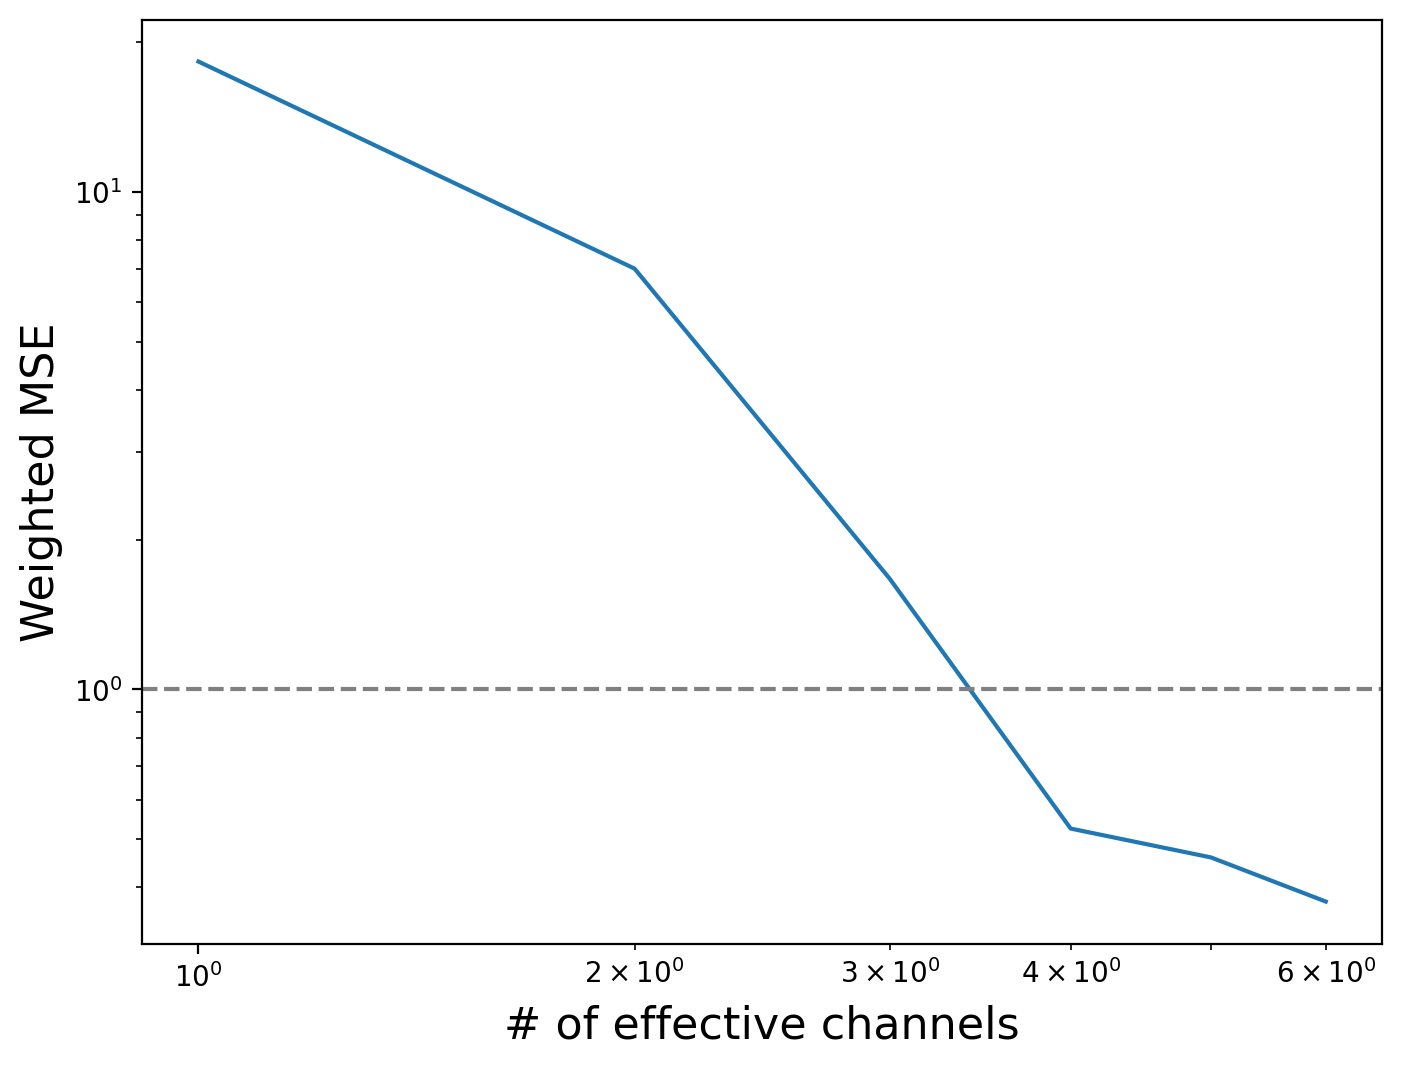

In [18]:
# Inverse process of generating the rescaled data
# Basically only need ``min_temp, data_min, and data_max'', in order to 
# recover the data in the original space from rescaled ones

min_temp = np.load('./data/camb_new_processed/min_temp.npy')
data_min = np.load('./data/camb_new_processed/data_min.npy')
data_max = np.load('./data/camb_new_processed/data_max.npy')


# The two functions to return to the original data space
def trans(data):
    return 10**(data*(data_max-data_min)+data_min)-1+min_temp
def trans_error(data,error):
    return error*((data+1-min_temp)*np.log(10))**2*(data_max-data_min)**2

### Testing function for the retrained model
def test_epoch_original(encoder, decoder, device, dataloader, loss_fn,maskindex):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = [] # For the encoded latents
        conc_param = []
        conc_out_encoded = []
        
        conc_data = [] # For the real input data
        conc_data_mean = []
        conc_err = []
        
        # Data untranslated (by the scaling above)
        conc_data_untrans = [] 
        conc_data_mean_untrans = []
        conc_err_untrans = []
        
        # Mask
        range_index=torch.arange(1, d_encode+1)
        mask = range_index.le(maskindex).unsqueeze(0).to(device)

        for data_batch, data_batch_mean, param,err in dataloader:
            data_batch = data_batch.to(device)
            data_batch_mean = data_batch_mean.to(device)
            param = param.to(device)
            err = err.to(device)
            # Encode data
            encoded_data= encoder(param)
            maskin_data = maskin(encoded_data)

            decoded_data = decoder(maskin_data*mask)

            conc_out_encoded.append(maskin_data.cpu())
            conc_param.append(param.cpu())
            
            conc_out.append(trans(decoded_data.cpu()))
            conc_data.append(trans(data_batch.cpu()[:,0,:]))
            conc_data_mean.append(trans(data_batch_mean.cpu()[:,0,:]))
            conc_err.append(trans_error(trans(data_batch.cpu()[:,0,:]),err.cpu()))
            
            conc_data_untrans.append(data_batch.cpu())
            conc_data_mean_untrans.append(data_batch_mean.cpu())
            conc_err_untrans.append(err.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out_encoded = torch.cat(conc_out_encoded)
        conc_param = torch.cat(conc_param)
        
        conc_out = torch.cat(conc_out)
        conc_data = torch.cat(conc_data)
        conc_data_mean = torch.cat(conc_data_mean)
        conc_err = torch.cat(conc_err)
        
        conc_data_untrans = torch.cat(conc_data_untrans)
        conc_data_mean_untrans = torch.cat(conc_data_mean_untrans)
        conc_err_untrans = torch.cat(conc_err_untrans)
        
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_data_mean[:,:],conc_err)
    return val_loss.data, conc_out_encoded, conc_param,conc_data_mean_untrans[:,0,:], conc_err_untrans, conc_data_untrans

def loss_fn(output, target, weight):
    loss = torch.mean((output - target)**2/weight)
    return loss

### Load only the last model, and mask the bottleneck gradually
test_losses_onloader_onemodel=[]

encoder = Encoder_cmb(encoded_space_dim=d_encode)
decoder = Decoder_cmb(encoded_space_dim=d_encode)
maskin = maskin_cmb()

model_state_save_early_path_checkpoint ='./model/checkpoint_%s.tar'%(name)
checkpoint_model = torch.load(model_state_save_early_path_checkpoint)
encoder.load_state_dict(checkpoint_model['encoder_state_dict'])
decoder.load_state_dict(checkpoint_model['decoder_state_dict'])
maskin.load_state_dict(checkpoint_model['maskin_state_dict'])

encoder.eval()
encoder.to(device)
decoder.eval()
decoder.to(device)
maskin.eval()
maskin.to(device)

for maskindex in range(1,d_encode+1):
    if maskindex==d_encode:
        temp, conc_out_encoded, conc_param, conc_data_mean, conc_err, conc_data=test_epoch_original(encoder, decoder, device, test_loader, loss_fn,maskindex) # Here the test_loader
    else:
        temp, _,_,_,_,_=test_epoch_original(encoder, decoder, device, test_loader, loss_fn,maskindex) # Here the test_loader

    test_losses_onloader_onemodel.append(np.array(temp))

# Save the testing samples for operon use later
np.save('./data/camb_new_processed/param_%s.npy'%name,conc_param)
np.save('./data/camb_new_processed/encoded_%s.npy'%name,conc_out_encoded)
np.save('./data/camb_new_processed/data_%s.npy'%name,conc_data)
np.save('./data/camb_new_processed/data_mean_%s.npy'%name,conc_data_mean)
np.save('./data/camb_new_processed/error_%s.npy'%name,conc_err)

print ("encoded_shape:",conc_out_encoded.shape)
print ("Weighted loss value:",np.array(test_losses_onloader_onemodel))

### Plot the weighted loss
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(1,len(test_losses_onloader_onemodel)+1),test_losses_onloader_onemodel)
ax.set_xlabel('# of effective channels',fontsize=16)
ax.set_ylabel('Weighted MSE',fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axhline(1., color="grey", linestyle="--") # The threshold for the weighted error (likelihood)
plt.show()
plt.close()

<a id='operon'></a>
## SR with pyoperon
Change the allowed_symbols may cause the NaN error later for individual expressions
e.g. allowed_symbols='add,sub,mul,aq,sin,constant,variable'is OK, while allowed_symbols='add,mul,pow,constant,variable' will lead to an error

In [ ]:
# The basic name for the operon experiments
#operon_name = name
name = 'shallow96'
operon_name = 'shallow96'

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from operon_sklearn import SymbolicRegressor
from pyoperon import InfixFormatter, FitLeastSquares, MSE
import csv

def operon_cmb(y,X,test_name,cal_individual):
    '''
    # y: the encoder outputs,[batch,6]
    # X: the cosmological parameters,[batch,6]
    # test_name: a specific name for this test
    # cal_individual: whether to calculate the statistics related to the individual expressions (might encounter NaN bug)
    '''
    # Do test-train split
    X_train = X.copy()
    X_test = X.copy()
    y_train = y.copy()
    y_test = y.copy()
    
    # Make SR class
    reg = SymbolicRegressor(
            #allowed_symbols='add,mul,pow,constant,variable', # cause the NaN error later for individual expressions
            allowed_symbols='add,sub,mul,aq,sin,constant,variable',
            offspring_generator='basic',
            local_iterations=1000,
            max_length=50,
            initialization_method='btc',
            n_threads=32,
            objectives = ['r2', 'length'],
            epsilon = 1e-3,
            random_state=None,
            reinserter='keep-best',
            max_evaluations=int(1e5),
            symbolic_mode=False
            )
    
    # Run fit
    reg.fit(X_train, y_train)
    
    compute_mse = MSE()
    
    # Output pareto front to file 
    print('Outputting pareto')
    with open('./data/sr/pareto_%s.csv'%test_name, 'w') as f:
        writer = csv.writer(f, delimiter=',')
    
        writer.writerow(['length',
                        'r2_train',
                        'r2_test',
                        'mse_train',
                        'mse_test',
                        'scale',
                        'offset',
                        'infix',
        ])
    
        count = 0
        pred_ind = np.zeros((len(reg.pareto_front_),500))
        pareto_mse = np.zeros((len(reg.pareto_front_)))
        for model, model_vars, model_obj, bic in reg.pareto_front_:
            y_pred_train = reg.evaluate_model(model, X_train)
            y_pred_test = reg.evaluate_model(model, X_test)
    
            scale, offset = FitLeastSquares(y_pred_train, y_train)
            y_pred_train = scale * y_pred_train + offset
            y_pred_test = scale * y_pred_test + offset
            
            pred_ind[count] = y_pred_test
            mse = np.mean((y_train- y_pred_train)**2)
            pareto_mse[count] = mse
            #np.save('./data/pred_individuals5_%d.npy'%count,y_pred_test)
            count += 1
    
            variables = { v.Hash : v.Name for v in model_vars }
            writer.writerow([model.Length,
                            r2_score(y_train, y_pred_train),
                            r2_score(y_test, y_pred_test),
                            compute_mse(y_train, y_pred_train),
                            compute_mse(y_test, y_pred_test),
                            scale,
                            offset,
                            InfixFormatter.Format(model, variables, 3),
            ])
        np.save('./data/sr/pred_pareto_%s.npy'%test_name,pred_ind)
        np.save('./data/sr/mse_pareto_%s.npy'%test_name,pareto_mse)
        
    if cal_individual==True:
        # Output currently considered individuals to file
        print(f'Outputting {len(reg.individuals_)} individuals')
        with open('./data/sr/individuals_%s.csv'%test_name, 'w') as f:
            writer = csv.writer(f, delimiter=',')
        
            writer.writerow(['length',
                            'r2_train',
                            'r2_test',
                            'mse_train',
                            'mse_test',
                            'scale',
                            'offset',
                            'infix',
            ])
        
            count = 0
            pred_ind = np.zeros((2000,500))
            for ind in reg.individuals_:
                y_pred_train = reg.evaluate_model(ind.Genotype, X_train)
                y_pred_test = reg.evaluate_model(ind.Genotype, X_test)
        
                scale, offset = FitLeastSquares(y_pred_train, y_train)
                y_pred_train = scale * y_pred_train + offset
                y_pred_test = scale * y_pred_test + offset
        
                pred_ind[count] = y_pred_test
                #np.save('./data/pred_individuals5_%d.npy'%count,y_pred_test)
                count += 1
                
                #print (y_pred_train)
                writer.writerow([ind.Genotype.Length,
                                r2_score(y_train, y_pred_train),
                                r2_score(y_test, y_pred_test),
                                compute_mse(y_train, y_pred_train),
                                compute_mse(y_test, y_pred_test),
                                scale,
                                offset,
                                reg.get_model_string(ind.Genotype, 4)
                ])
            np.save('./data/sr/pred_individuals_%s.npy'%test_name,pred_ind)

In [42]:
n_latent = 6
y=np.load('./data/camb_new_processed/encoded_%s.npy'%name) # the encoder outputs
X=np.load('./data/camb_new_processed/param_%s.npy'%name) # the input cosmological parameters


for i in range(n_latent):
    test_name = operon_name+'latent%d'%i
    #operon_cmb(y[:,i],X,test_name,cal_individual=False)
    operon_cmb(y[:,i],X,test_name,cal_individual=True) 

Outputting pareto
Outputting 2000 individuals


Outputting pareto
Outputting 2000 individuals


Outputting pareto
Outputting 2000 individuals


Outputting pareto
Outputting 2000 individuals


Outputting pareto
Outputting 2000 individuals


Outputting pareto
Outputting 2000 individuals


<a id='weighted'></a>
## Inspect the data space (replacement of latents)
replace only one latent in order, no replacement for the above latents

#### Inspect the parato front from the operon

In [43]:
# Define functions to print expressions that are easy to read
from IPython.display import display
import sympy as sp
from sympy import *

def pprint(expr):
    display(eval(expr))

X6= Symbol('X6')
X1 = Symbol('X1')
X2 = Symbol('X2')
X3 = Symbol('X3')
X4 = Symbol('X4')
X5 = Symbol('X5')

In [38]:
# Inverse process of generating the rescaled data
# Basically only need ``min_temp, data_min, and data_max'', in order to 
# recover the data in the original space from rescaled ones

min_temp = np.load('./data/camb_new_processed/min_temp.npy')
data_min = np.load('./data/camb_new_processed/data_min.npy')
data_max = np.load('./data/camb_new_processed/data_max.npy')

def trans(data):
    return 10**(data*(data_max-data_min)+data_min)-1+min_temp
def trans_error(data,error):
    return error*((data+1-min_temp)*np.log(10))**2*(data_max-data_min)**2

The weighted MSE: [45.40360699 22.37163106 14.06297652 14.49893538  9.04154301  9.7760892
  3.33122139  4.67109921  3.78179302  3.19225901  1.2765696   1.09725925
  1.55447439  1.5134165   1.24589027  0.93195133  0.65666553]


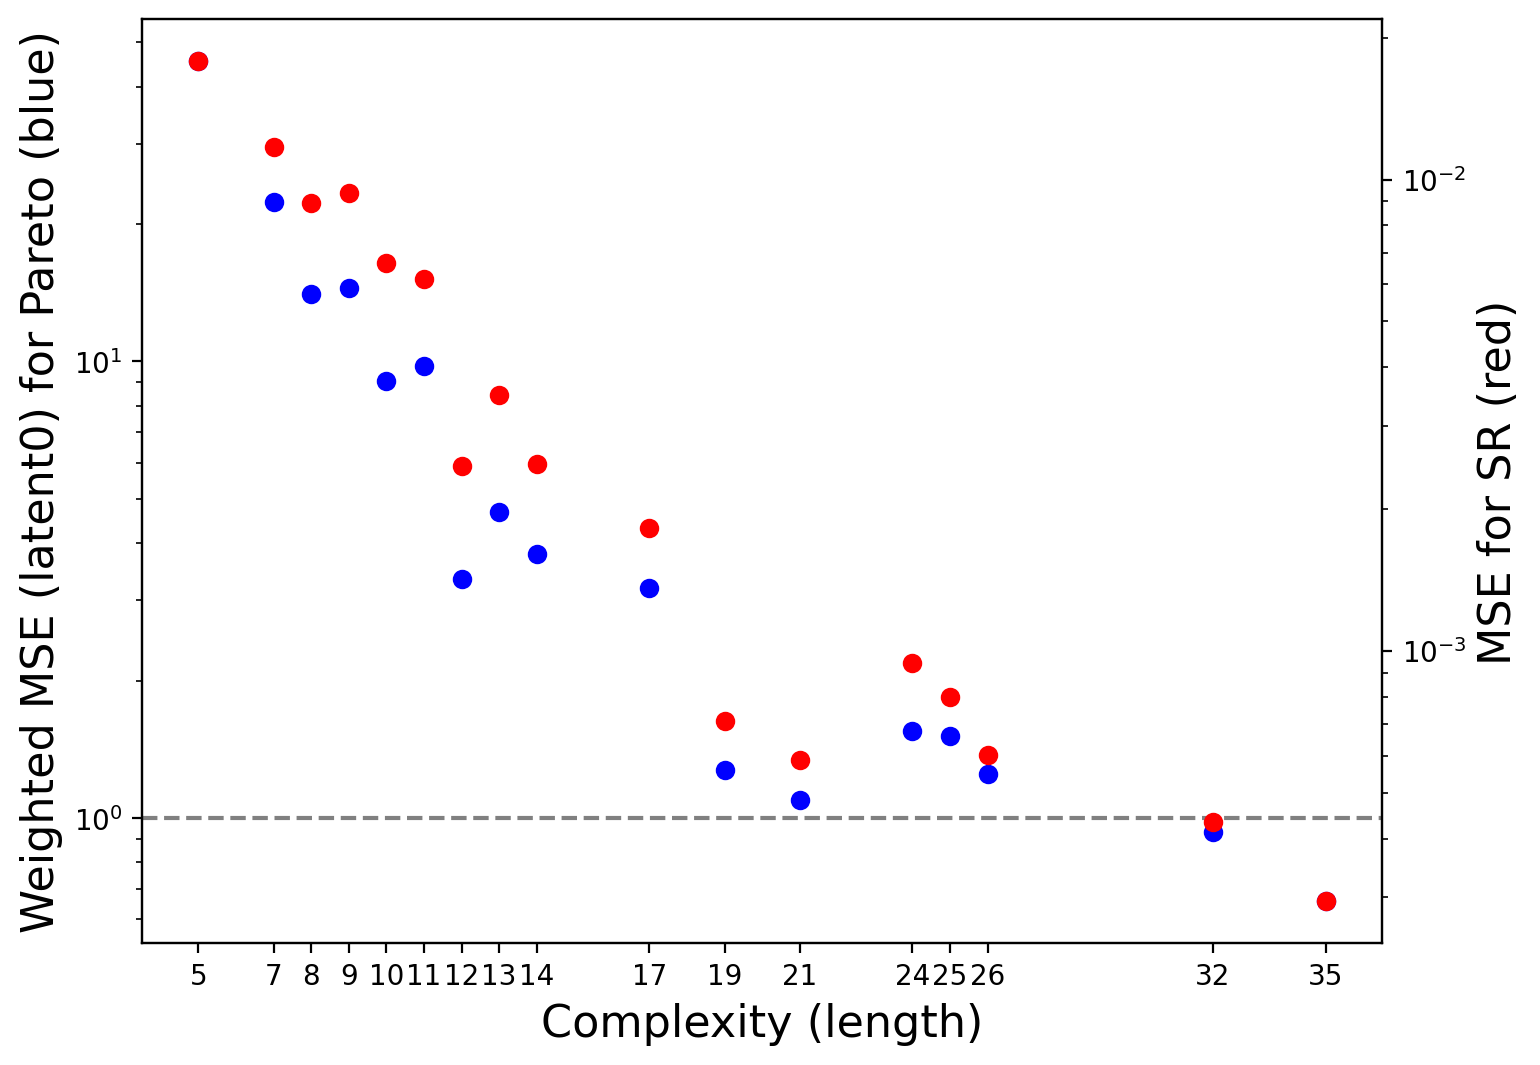

raw expression: (0.934 + ((-0.470) * (1.228 * X2)))
*****


0.934 - 0.57716*X2

***********************************
raw expression: (0.504 + (0.857 * ((2.192 * X1) / (sqrt(1 + (12.351 * X2) ^ 2)))))
*****


0.152096510404016*X1/sqrt(X2**2 + 0.00655534807223372) + 0.504

***********************************
raw expression: (0.427 + (0.592 * sin(((6.197 * X1) / (sqrt(1 + ((-15.032) * X2) ^ 2))))))
*****


0.592*sin(0.412253858435338*X1/sqrt(X2**2 + 0.00442554199081696)) + 0.427

***********************************
raw expression: ((-0.000) + (1.000 * ((0.786 - ((-0.445) * X1)) + ((-0.674) * X2))))
*****


0.445*X1 - 0.674*X2 + 0.786

***********************************
raw expression: ((-0.191) + (1.266 * (sin((0.709 - ((-1.300) * X1))) - (0.521 * X2))))
*****


-0.659586*X2 + 1.266*sin(1.3*X1 + 0.709) - 0.191

***********************************
raw expression: ((-0.000) + (1.000 * (((0.692 - ((-0.205) * X4)) - ((-0.439) * X1)) + ((-0.684) * X2))))
*****


0.439*X1 - 0.684*X2 + 0.205*X4 + 0.692

***********************************
raw expression: ((-0.047) + (0.419 * (((1.370 - ((-0.810) * X4)) / (sqrt(1 + (3.831 * X2) ^ 2))) - sin(((-2.387) * X1)))))
*****


0.419*sin(2.387*X1) - 0.047 + 0.109370921430436*(0.81*X4 + 1.37)/sqrt(X2**2 + 0.0681358528063897)

***********************************
raw expression: ((-6.260) + (2.909 * ((((0.072 * X4) + 2.487) / (sqrt(1 + ((-0.360) + (0.546 * X1)) ^ 2))) - (0.230 * X2))))
*****


-0.66907*X2 + 2.909*(0.072*X4 + 2.487)/sqrt(0.298116*(X1 - 0.659340659340659)**2 + 1) - 6.26

***********************************
raw expression: ((-0.081) + (1.038 * (sin(((0.713 - ((-1.567) * X1)) - (0.266 * X6))) + (((-0.595) * X2) - ((-0.192) * X4)))))
*****


-0.61761*X2 + 0.199296*X4 + 1.038*sin(1.567*X1 - 0.266*X6 + 0.713) - 0.081

***********************************
raw expression: (0.146 + (0.937 * ((((0.481 - (((-0.376) * X4) / (sqrt(1 + ((-2.957) * X6) ^ 2)))) - ((-0.850) * X1)) + ((-0.709) * X2)) / (sqrt(1 + ((-0.731) + (2.222 * X1)) ^ 2)))))
*****


0.146 + 0.421692169216922*(0.85*X1 - 0.709*X2 + 0.127155901251268*X4/sqrt(X6**2 + 0.114366110393718) + 0.481)/sqrt((X1 - 0.328982898289829)**2 + 0.20254050607581)

***********************************
raw expression: (0.055 + (0.639 * (((sin((sin((2.050 * X1)) / (sqrt(1 + ((-1.420) * X6) ^ 2)))) - (0.091 * X2)) + (0.148 * X4)) - (((-0.740) - (0.323 * X4)) / (sqrt(1 + ((-4.698) * X2) ^ 2))))))
*****


-0.058149*X2 + 0.094572*X4 + 0.639*sin(0.704225352112676*sin(2.05*X1)/sqrt(X6**2 + 0.495933346558223)) + 0.055 - 0.136015325670498*(-0.323*X4 - 0.74)/sqrt(X2**2 + 0.0453079043626256)

***********************************
raw expression: ((-0.256) + (5.549 * ((((((-0.049) * X6) + 0.146) / (sqrt(1 + (3.505 * X2) ^ 2))) + (sin((sin((0.342 * X1)) / (sqrt(1 + (((-57320685568.000) * X2) / (sqrt(1 + ((-376045190512640.000) * X2) ^ 2))) ^ 2)))) / (sqrt(1 + (3.071 * X1) ^ 2)))) + (0.036 * X4))))
*****


0.199764*X4 + 1.58316690442225*(0.146 - 0.049*X6)/sqrt(X2**2 + 0.0813999157510872) - 0.256 + 1.806903288831*sin(sin(0.342*X1)/sqrt(2.32349998964811e-8*X2**2/(X2**2 + 7.071636404064e-30) + 1))/sqrt(X1**2 + 0.106032833491022)

***********************************
raw expression: ((-5.250) + (6.313 * (((((0.029 + ((-0.156) * X2)) + sin((0.046 * X4))) / (sqrt(1 + ((-1.624) * X2) ^ 2))) / (sqrt(1 + sin((1.965 * X2)) ^ 2))) + (sin((1.107 - ((-0.465) * X1))) - (((-0.099) * X1) * ((-0.605) * X6))))))
*****


-0.378117135*X1*X6 + 6.313*sin(0.465*X1 + 1.107) - 5.25 + 3.88731527093596*(-0.156*X2 + sin(0.046*X4) + 0.029)/(sqrt(X2**2 + 0.379164745565289)*sqrt(sin(1.965*X2)**2 + 1))

***********************************
raw expression: ((-0.383) + (4.200 * (((sin((-0.962)) + (0.039 * X4)) + (((-0.077) * X2) / (sqrt(1 + 3.836 ^ 2)))) + (sin((1.086 - ((-0.686) * X1))) - ((-0.172) / (sqrt(1 + ((((-3.290) * X2) - (0.881 * X6)) + (0.246 * X4)) ^ 2)))))))
*****


-0.0815801050000769*X2 + 0.1638*X4 + 4.2*sin(0.686*X1 + 1.086) - 3.82841527032861 + 0.219574468085106/sqrt((-X2 + 0.0747720364741641*X4 - 0.267781155015198*X6)**2 + 0.092386433976035)

***********************************
raw expression: ((-0.001) + (0.998 * (((0.448 * X1) + (((((0.507 * X1) + 0.710) / (sqrt(1 + ((((-3.011) * X2) - (0.769 * X6)) + (0.139 * X4)) ^ 2))) / (sqrt(1 + (0.806 + ((-2.505) * X1)) ^ 2))) + ((-0.023) * X2))) - (sin(((-0.172) * X4)) + 0.037))))
*****


0.447104*X1 - 0.022954*X2 + 0.132315906214804*(0.507*X1 + 0.71)/(sqrt((0.321756487025948 - X1)**2 + 0.159361914892769)*sqrt((-X2 + 0.0461640650946529*X4 - 0.255396878113584*X6)**2 + 0.110300755968291)) + 0.998*sin(0.172*X4) - 0.037926

***********************************
raw expression: ((-0.005) + (1.007 * ((((5.252 * X1) + 0.674) / (sqrt(1 + ((((-3.996) * X2) - (0.597 * X6)) + (0.117 * X4)) ^ 2))) / (sqrt(1 + (((4.275 * X1) + 0.852) / (sqrt(1 + ((((sin(((-1.039) * X4)) + (-0.002)) / (sqrt(1 + 0.003 ^ 2))) + ((-2.795) * X2)) * ((((-0.113) * X5) + 0.855) - 1.570)) ^ 2))) ^ 2)))))
*****


0.117802830608386*(5.252*X1 + 0.674)/(sqrt((X1 + 0.199298245614035)**2/((-0.158041958041958*X5 - 1)**2*(-X2 - 0.357780143123569*sin(1.039*X4) - 0.000715560286247138)**2 + 0.250394215606042) + 0.218526177935091)*sqrt((-X2 + 0.0292792792792793*X4 - 0.149399399399399*X6)**2 + 0.0626251877503129)) - 0.005

***********************************
raw expression: ((-0.154) + (1.144 * ((((3.945 * X1) + 1.005) / (sqrt(1 + ((((((-1.916) / (sqrt(1 + ((1.576 * X1) + ((-0.225) * X5)) ^ 2))) - ((-2.505) * X2)) + (((-1.647) - ((-0.618) * X4)) / (sqrt(1 + ((((-1.016) * X6) * (-1.351)) + (0.243 * X3)) ^ 2)))) - (((-1.139) * X1) + (-4.944))) + ((-1.220) * X4)) ^ 2))) / (sqrt(1 + ((-0.017) + ((-0.858) * X1)) ^ 2)))))
*****


0.231391585760518*(3.945*X1 + 1.005)/(sqrt(0.736164*(-X1 - 0.0198135198135198)**2 + 1)*sqrt((0.230380258899676*X1 + 0.506674757281553*X2 - 0.246763754045307*X4 + 0.14735758010127*(0.618*X4 - 1.647)/sqrt((0.177034217873025*X3 + X6)**2 + 0.530764522649218) + 1 - 0.245901302712204/sqrt((X1 - 0.142766497461929*X5)**2 + 0.402612796000928))**2 + 0.0409112807783748)) - 0.154

***********************************
The weighted MSE: [4.81527279 4.59276187 2.29436196 2.13005422 0.65955401 0.89472235
 0.65928558 0.53371909 0.48599957]


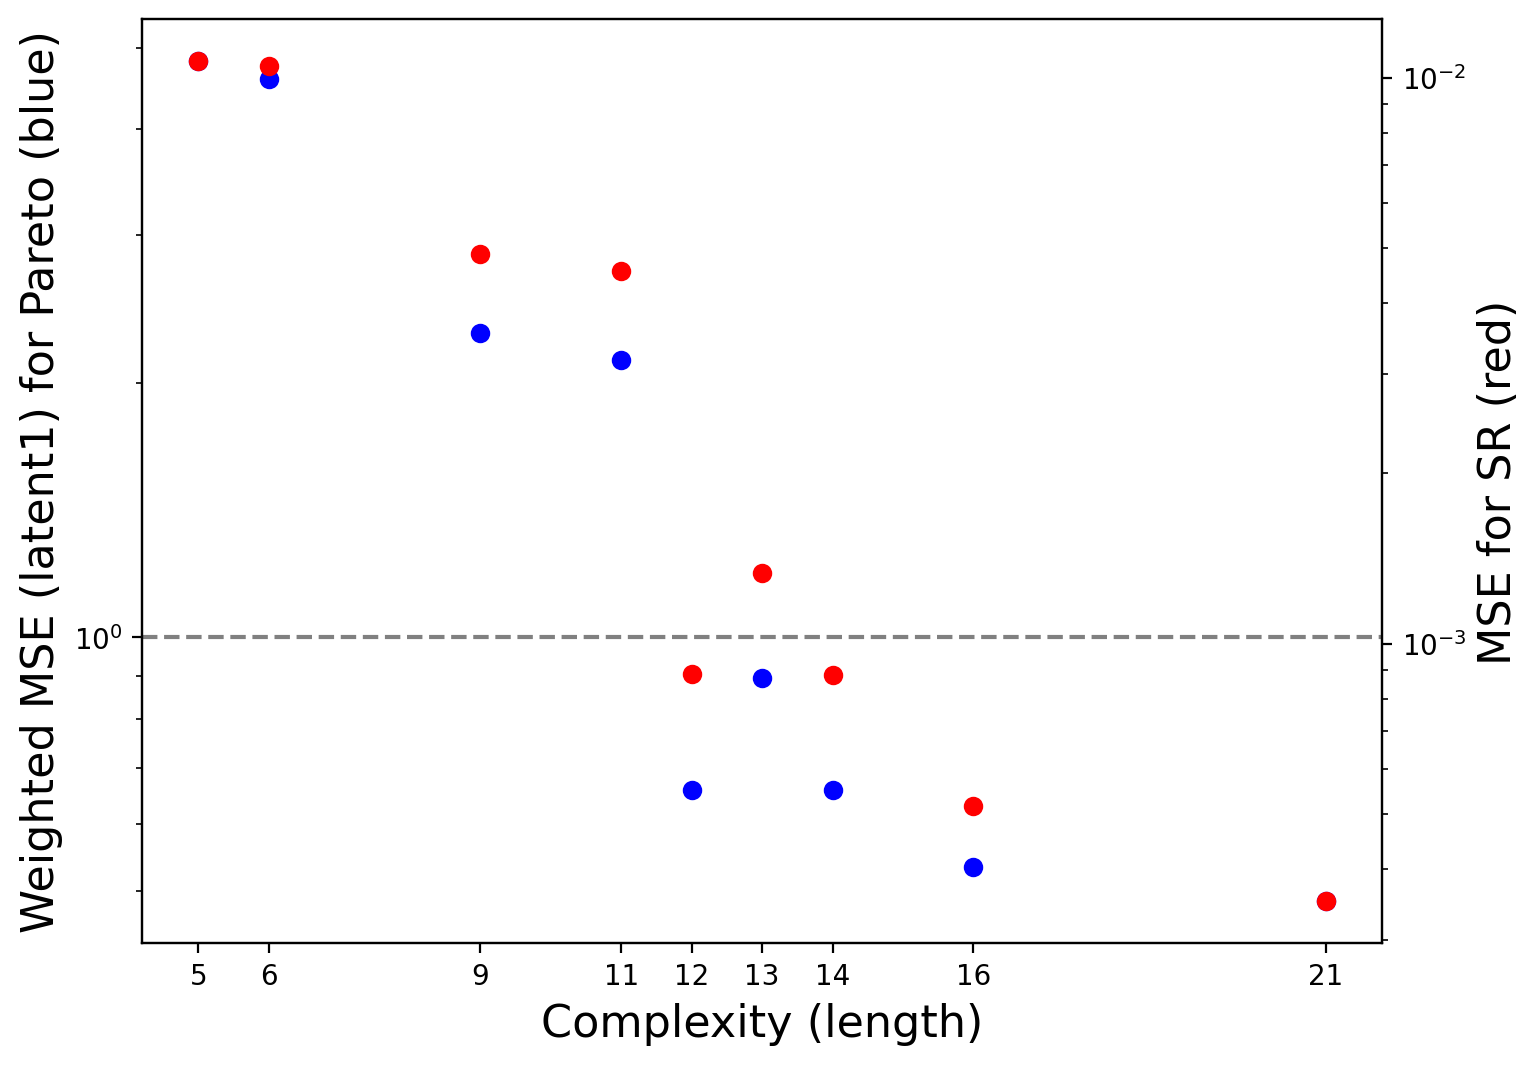

raw expression: ((-0.525) + (2.359 * (0.747 * X2)))
*****


1.762173*X2 - 0.525

***********************************
raw expression: ((-0.552) + (2.494 * sin((0.756 * X2))))
*****


2.494*sin(0.756*X2) - 0.552

***********************************
raw expression: ((-0.000) + (1.000 * ((0.301 * X6) + ((-0.609) + (1.574 * X2)))))
*****


1.574*X2 + 0.301*X6 - 0.609

***********************************
raw expression: (0.000 + (1.000 * ((((0.311 * X6) - ((-1.765) * X2)) / (sqrt(1 + ((-0.557) * X2) ^ 2))) + (-0.654))))
*****


1.0*(1.765*X2 + 0.311*X6)/sqrt(0.310249*X2**2 + 1) - 0.654

***********************************
raw expression: ((-1.694) + (1.097 * (sin((1.649 + ((-0.903) * X1))) - (((-1.446) * X2) - (0.364 * X6)))))
*****


1.586262*X2 + 0.399308*X6 - 1.097*sin(0.903*X1 - 1.649) - 1.694

***********************************
raw expression: ((-0.000) + (1.000 * (((0.391 * X6) - ((0.308 * X1) + 0.913)) + (0.382 + (1.585 * X2)))))
*****


-0.308*X1 + 1.585*X2 + 0.391*X6 - 0.531

***********************************
raw expression: ((-0.004) + (0.988 * (sin((1.655 + ((-0.957) * X1))) - ((1.601 - (0.405 * X6)) + ((-1.606) * X2)))))
*****


1.586728*X2 + 0.40014*X6 - 0.988*sin(0.957*X1 - 1.655) - 1.585788

***********************************
raw expression: ((-1.097) + (1.234 * (sin(((((41.175 - ((-0.363) * X6)) / (sqrt(1 + ((-0.125) * X1) ^ 2))) / (sqrt(1 + ((-0.131) * X2) ^ 2))) - 28.235)) - ((-1.569) * X2))))
*****


1.936146*X2 - 1.234*sin(28.235 - (0.363*X6 + 41.175)/(sqrt(0.015625*X1**2 + 1)*sqrt(0.017161*X2**2 + 1))) - 1.097

***********************************
raw expression: ((-0.476) + (0.207 * (((((sin(sin((2.375 * X1))) - (((-0.215) * X4) - (-0.909))) - (((-8.663) * X2) / (sqrt(1 + (0.626 * X2) ^ 2)))) + (0.624 * X6)) + ((-2.353) * X1)) + (1.335 * X6))))
*****


-0.487071*X1 + 1.793241*X2/sqrt(0.391876*X2**2 + 1) + 0.044505*X4 + 0.405513*X6 + 0.207*sin(sin(2.375*X1)) - 0.664163

***********************************
The weighted MSE: [3.51366503 0.61107179 0.49580812 0.49580813 0.47610814 0.43787194
 0.40941605 0.40933624 0.40844535 0.39601859 0.39132951 0.37827956
 0.37057738]


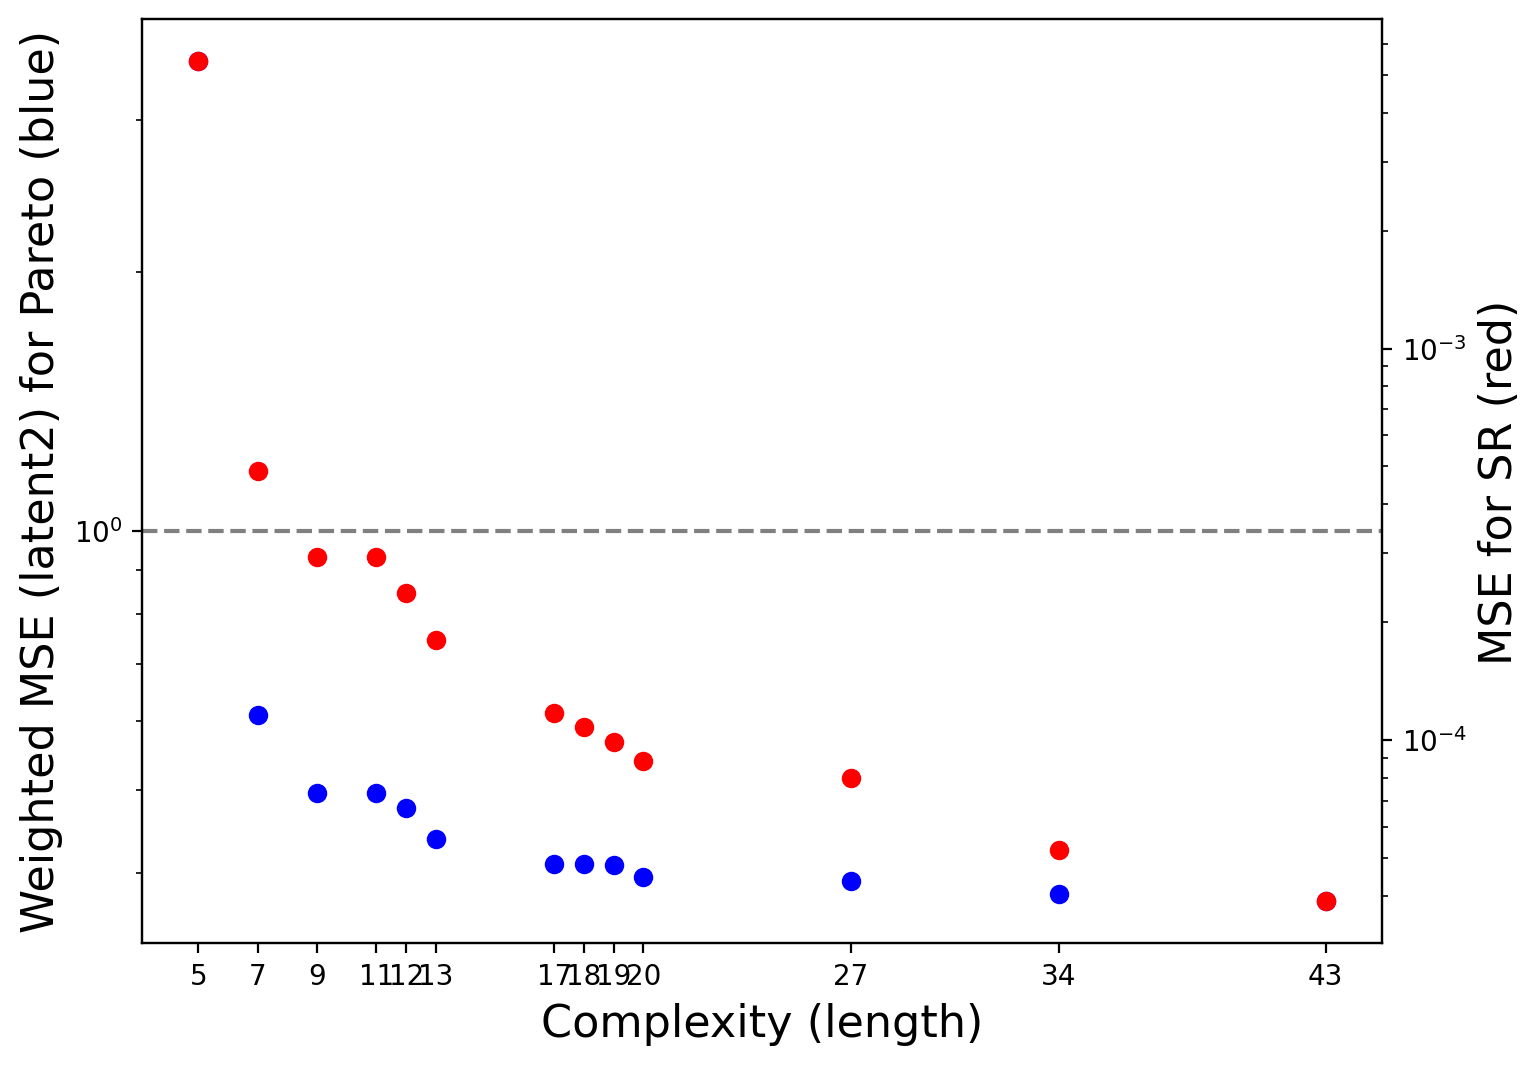

raw expression: ((-0.173) + (7.032 * (0.054 * X1)))
*****


0.379728*X1 - 0.173

***********************************
raw expression: ((-0.052) + (0.997 * (((-0.255) * X4) - ((-0.394) * X1))))
*****


0.392818*X1 - 0.254235*X4 - 0.052

***********************************
raw expression: ((-0.037) + (0.997 * (((0.424 * X1) + ((-0.255) * X4)) + ((-0.053) * X6))))
*****


0.422728*X1 - 0.254235*X4 - 0.052841*X6 - 0.037

***********************************
raw expression: ((-0.000) + (1.000 * (((-0.053) * X6) - ((0.037 + ((-0.423) * X1)) + (0.255 * X4)))))
*****


0.423*X1 - 0.255*X4 - 0.053*X6 - 0.037

***********************************
raw expression: ((-0.019) + (0.884 * (((((-0.065) * X6) + (1.295 * X1)) + ((-0.288) * X4)) + sin(((-0.898) * X1)))))
*****


1.14478*X1 - 0.254592*X4 - 0.05746*X6 - 0.884*sin(0.898*X1) - 0.019

***********************************
raw expression: (0.000 + (1.000 * ((((-0.056) * X6) + (((-0.055) + (0.424 * X1)) + ((-0.255) * X4))) - ((-0.037) * X3))))
*****


0.424*X1 + 0.037*X3 - 0.255*X4 - 0.056*X6 - 0.055

***********************************
raw expression: (1.530 + (2.073 * sin(((((0.026 * X3) - 0.846) + sin((0.248 * X1))) + ((((-0.049) * X6) + ((-0.217) * X4)) / (sqrt(1 + (1.367 * X1) ^ 2)))))))
*****


2.073*sin(0.026*X3 + sin(0.248*X1) - 0.846 + 0.731528895391368*(-0.217*X4 - 0.049*X6)/sqrt(X1**2 + 0.535134524792515)) + 1.53

***********************************
raw expression: ((-0.022) + (6.507 * (((0.098 * X1) + (sin(((((-0.170) * (0.247 * X4)) + ((-0.010) * X6)) + ((-0.049) * X1))) / (sqrt(1 + (0.865 * X1) ^ 2)))) - ((-0.006) * X3))))
*****


0.637686*X1 + 0.039042*X3 - 0.022 - 6.507*sin(0.049*X1 + 0.04199*X4 + 0.01*X6)/sqrt(0.748225*X1**2 + 1)

***********************************
raw expression: ((-0.007) + (1.000 * ((((0.471 * X1) / (sqrt(1 + (0.170 * X4) ^ 2))) + (((((-0.072) * X6) + ((-0.244) * X1)) + ((-0.090) * X4)) / (sqrt(1 + (2.134 * X1) ^ 2)))) + ((0.036 * X3) + ((-0.184) * X4)))))
*****


0.471*X1/sqrt(0.0289*X4**2 + 1) + 0.036*X3 - 0.184*X4 - 0.007 + 0.468603561387067*(-0.244*X1 - 0.09*X4 - 0.072*X6)/sqrt(X1**2 + 0.219589297744642)

***********************************
raw expression: ((-0.000) + (0.991 * ((((-0.069) * X6) + (0.026 * X2)) + ((((1.215 * X1) + (0.038 * X3)) - (0.036 + (0.258 * X4))) - (sin((0.860 * X1)) - ((-0.012) * X5))))))
*****


1.204065*X1 + 0.025766*X2 + 0.037658*X3 - 0.255678*X4 - 0.011892*X5 - 0.068379*X6 - 0.991*sin(0.86*X1) - 0.035676

***********************************
raw expression: (0.002 + (1.011 * (((0.773 * X1) + sin(((-0.402) * (sin(((0.180 * X6) - (0.069 * X2))) - ((sin(((-1.105) * X1)) - (0.030 * X5)) + (sin(0.002) - ((0.676 * X4) - (-0.069)))))))) - ((-0.036) * X3))))
*****


0.781503*X1 + 0.036396*X3 - 1.011*sin(0.271752*X4 + 0.01206*X5 + 0.402*sin(1.105*X1) - 0.402*sin(0.069*X2 - 0.18*X6) + 0.0269340005359999) + 0.002

***********************************
raw expression: (0.676 + (3.524 * (sin((((((1.765 - ((-0.126) * X3)) + ((-7.827) * X1)) + ((-1.574) * X4)) * sin(0.084)) - ((0.046 * X6) - (0.153 * X2)))) - sin(sin(((((2.715 + ((-5.872) * X1)) + ((-0.443) * X4)) * sin(0.133)) - ((0.027 * X6) - (0.147 * X2))))))))
*****


-3.524*sin(0.656695090364917*X1 - 0.153*X2 - 0.0105715576064877*X3 + 0.132060568830252*X4 + 0.046*X6 - 0.148085707741674) + 3.524*sin(sin(0.778675588131493*X1 - 0.147*X2 + 0.0587454505351245*X4 + 0.027*X6 - 0.360031372918427)) + 0.676

***********************************
raw expression: ((-0.450) + (1.988 * (sin(((sin(((2.571 / (sqrt(1 + ((0.068 * ((2.195 * X2) * ((-2.544) * X5))) - (2.806 - (0.064 * X5))) ^ 2))) / (sqrt(1 + (((((-0.955) * X4) + 0.974) + ((0.965 * X6) + 4.409)) / (sqrt(1 + ((-2.256) * X1) ^ 2))) ^ 2)))) - ((0.247 * X4) - 0.064)) - (((-0.224) * (0.187 * X1)) / (sqrt(1 + (-2.709) ^ 2))))) + (((0.082 * X4) + (0.018 * X3)) + (0.024 * X2)))))
*****


0.047712*X2 + 0.035784*X3 + 0.163016*X4 + 1.988*sin(0.0145057752688898*X1 - 0.247*X4 + sin(0.383998144153561/(sqrt(0.17564242760793 + (-0.177410365966933*X4 + 0.179268066134126*X6 + 1)**2/(X1**2 + 0.196481565313616))*sqrt((-0.135323392729865*X2*X5 + 0.022808267997149*X5 - 1)**2 + 0.127006125251409))) + 0.064) - 0.45

***********************************
The weighted MSE: [7.33091954 1.39748096 1.39898857 1.11791041 1.03453933 0.81027723
 0.72909868 0.707599   0.67491935 0.70745533 0.56378935 0.49268377]


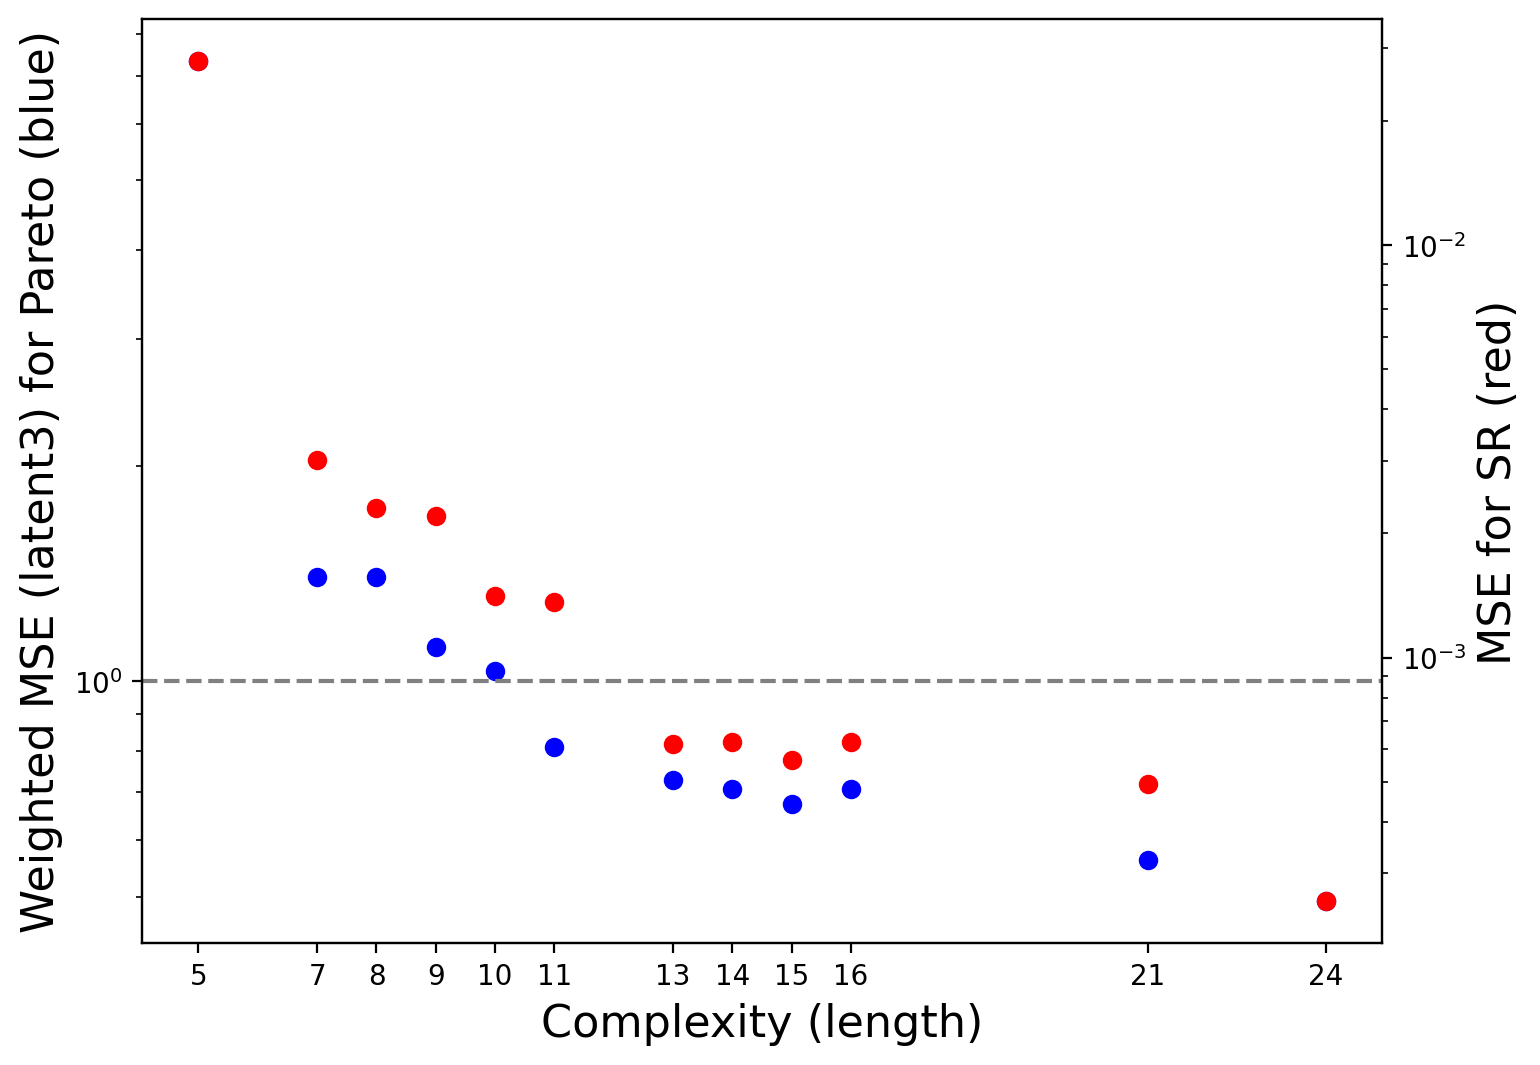

raw expression: (0.238 + (0.688 * (1.449 * X1)))
*****


0.996912*X1 + 0.238

***********************************
raw expression: (0.008 + (0.989 * ((0.758 * X2) - ((-0.837) * X1))))
*****


0.827793*X1 + 0.749662*X2 + 0.008

***********************************
raw expression: ((-0.053) + (0.648 * ((1.279 * X1) - sin(((-1.587) * X2)))))
*****


0.828792*X1 + 0.648*sin(1.587*X2) - 0.053

***********************************
raw expression: ((-0.008) + (1.009 * ((0.681 * X2) + ((0.768 * X1) - ((-0.119) * X6)))))
*****


0.774912*X1 + 0.687129*X2 + 0.120071*X6 - 0.008

***********************************
raw expression: ((-0.080) + (0.710 * ((1.090 * X1) - sin((((-0.220) * X6) + ((-1.359) * X2))))))
*****


0.7739*X1 + 0.71*sin(1.359*X2 + 0.22*X6) - 0.08

***********************************
raw expression: ((-0.056) + (1.058 * (((0.643 * X2) + ((0.729 * X1) - ((-0.117) * X6))) - ((-0.099) * X4))))
*****


0.771282*X1 + 0.680294*X2 + 0.104742*X4 + 0.123786*X6 - 0.056

***********************************
raw expression: ((-0.126) + (0.709 * (((1.085 * X1) + sin(((0.225 * X6) + (1.339 * X2)))) + sin((0.145 * X4)))))
*****


0.769265*X1 + 0.709*sin(0.145*X4) + 0.709*sin(1.339*X2 + 0.225*X6) - 0.126

***********************************
raw expression: ((-0.117) + (1.064 * (sin((1.336 * X2)) - (((0.438 * X2) + (((-0.722) * X1) - (0.122 * X6))) - (0.095 * X4)))))
*****


0.768208*X1 - 0.466032*X2 + 0.10108*X4 + 0.129808*X6 + 1.064*sin(1.336*X2) - 0.117

***********************************
raw expression: (0.381 + (0.969 * (((-0.496) / (sqrt(1 + ((-4.561) * X2) ^ 2))) - ((((-0.246) * X2) + (((-0.793) * X1) - (0.131 * X6))) - (0.106 * X4)))))
*****


0.768417*X1 + 0.238374*X2 + 0.102714*X4 + 0.126939*X6 + 0.381 - 0.105376891032668/sqrt(X2**2 + 0.0480706346059249)

***********************************
raw expression: ((-0.001) + (0.984 * ((sin((1.374 * X2)) - 0.118) - (((0.402 * X2) + (((-0.781) * X1) - (0.132 * X6))) - (0.103 * X4)))))
*****


0.768504*X1 - 0.395568*X2 + 0.101352*X4 + 0.129888*X6 + 0.984*sin(1.374*X2) - 0.117112

***********************************
raw expression: ((-0.003) + (1.017 * (((0.250 * X6) + ((-0.417) * X2)) - (sin(((-1.357) * X2)) - ((sin((((-0.142) * X6) + (0.305 - ((-0.953) * X1)))) + (-0.438)) - ((-0.100) * X4))))))
*****


-0.424089*X2 + 0.1017*X4 + 0.25425*X6 + 1.017*sin(1.357*X2) + 1.017*sin(0.953*X1 - 0.142*X6 + 0.305) - 0.448446

***********************************
raw expression: ((-0.001) + (0.991 * ((sin((0.984 * X1)) / (sqrt(1 + (0.300 * X3) ^ 2))) + ((((-0.181) - (((-0.046) * X5) + (((-1.965) * X6) - ((-1.830) * X6)))) + (((-0.088) * X1) - (((-1.068) * X2) / (sqrt(1 + ((-1.356) * X2) ^ 2))))) - ((-0.103) * X4)))))
*****


-0.087208*X1 + 0.780522123893805*X2/sqrt(X2**2 + 0.543851863454025) + 0.102073*X4 + 0.045586*X5 + 0.133785*X6 - 0.180371 + 0.991*sin(0.984*X1)/sqrt(0.09*X3**2 + 1)

***********************************
The weighted MSE: [0.46747653 0.40121026 0.39762278 0.39085258 0.38977264 0.39085256
 0.38931993 0.38705502 0.39069421 0.38913511 0.3870135  0.38803164
 0.38906059 0.38261938 0.38859824]


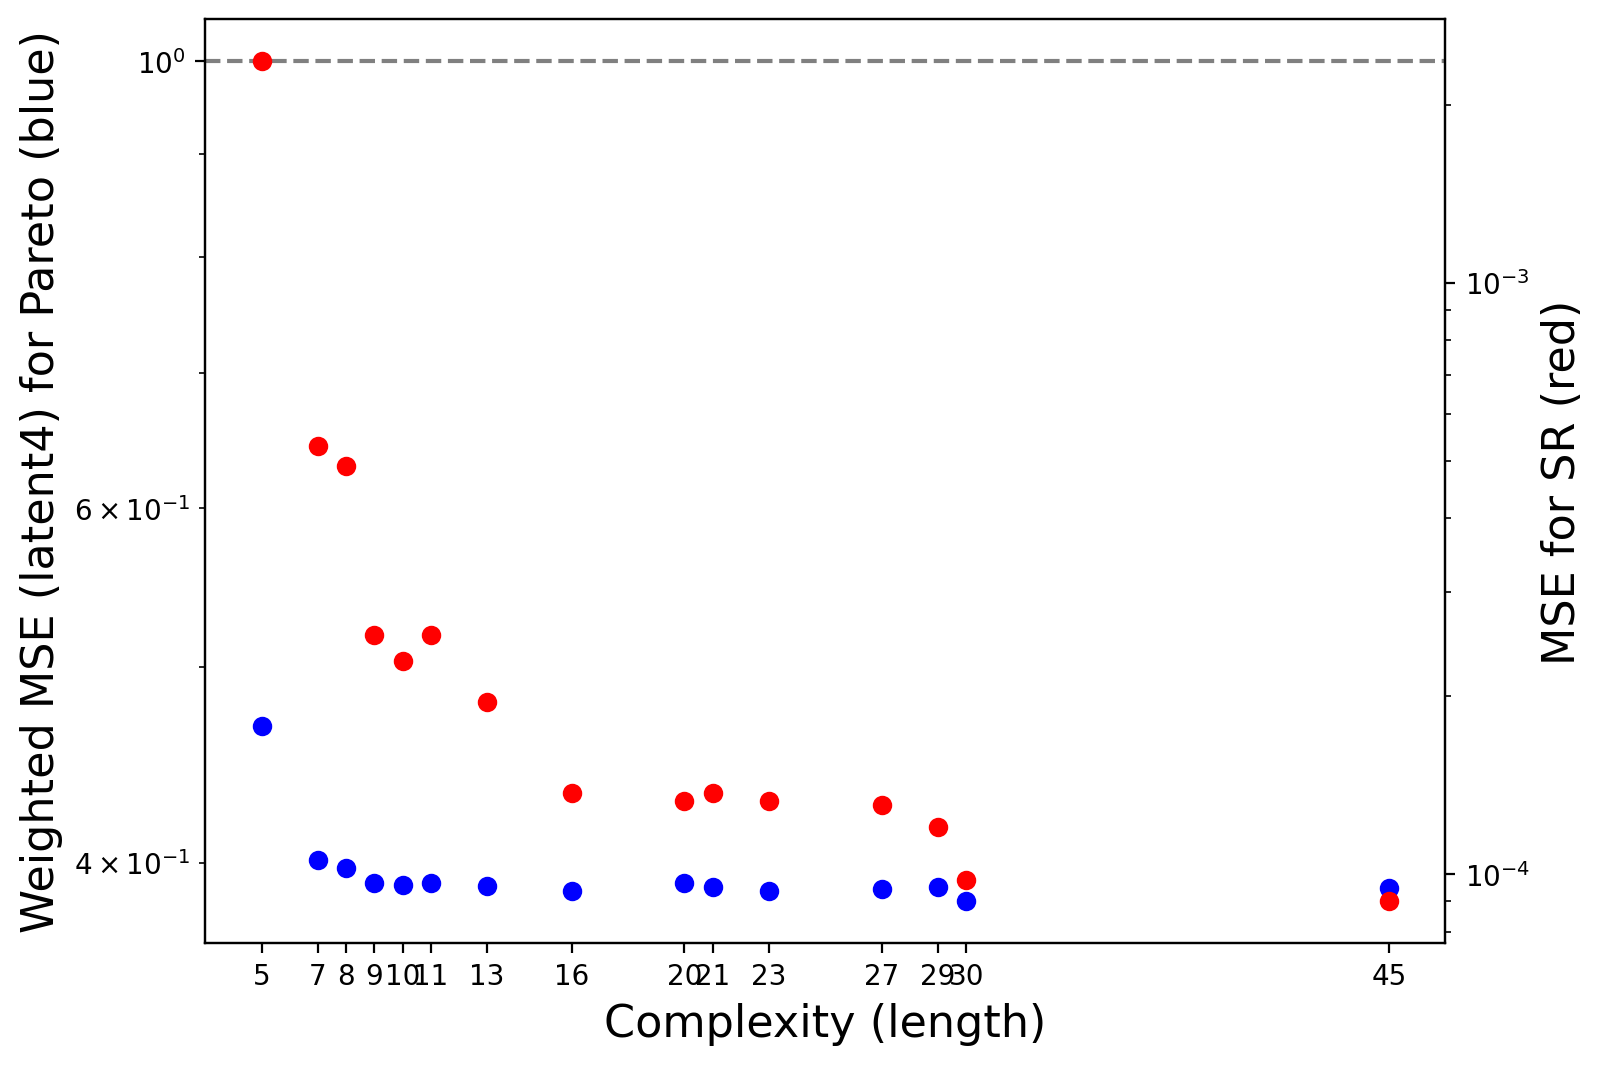

raw expression: ((-0.046) + (1.831 * (0.106 * X2)))
*****


0.194086*X2 - 0.046

***********************************
raw expression: (0.023 + (0.974 * ((0.246 * X2) - (0.213 * X1))))
*****


-0.207462*X1 + 0.239604*X2 + 0.023

***********************************
raw expression: (0.009 + (0.217 * (((-0.953) * X1) - sin(((-1.403) * X2)))))
*****


-0.206801*X1 + 0.217*sin(1.403*X2) + 0.009

***********************************
raw expression: (0.014 + (0.985 * (((0.206 * X2) - ((-0.071) * X6)) - (0.242 * X1))))
*****


-0.23837*X1 + 0.20291*X2 + 0.069935*X6 + 0.014

***********************************
raw expression: (0.000 + (0.273 * (((-0.869) * X1) - sin((((-0.287) * X6) - (0.922 * X2))))))
*****


-0.237237*X1 + 0.273*sin(0.922*X2 + 0.287*X6)

***********************************
raw expression: (0.000 + (1.000 * ((((-0.238) * X1) - (((-0.070) * X6) - (0.203 * X2))) + 0.014)))
*****


-0.238*X1 + 0.203*X2 + 0.07*X6 + 0.014

***********************************
raw expression: (0.000 + (1.000 * (((-0.239) * X1) - (((0.228 / (sqrt(1 + (3.408 * X2) ^ 2))) - (0.073 * X6)) + (-0.238)))))
*****


-0.239*X1 + 0.073*X6 + 0.238 - 0.0669014084507042/sqrt(X2**2 + 0.0860995393330247)

***********************************
raw expression: (0.011 + (0.225 * ((sin(((-1.310) * X1)) - ((0.219 * X2) - (0.880 * X6))) + (((1.749 * X2) - (0.708 * X6)) / (sqrt(1 + ((-1.940) * X2) ^ 2))))))
*****


-0.049275*X2 + 0.198*X6 + 0.115979381443299*(1.749*X2 - 0.708*X6)/sqrt(X2**2 + 0.265703050271017) - 0.225*sin(1.31*X1) + 0.011

***********************************
raw expression: (0.022 + (0.947 * (((((6.299 * X6) * ((0.024 * X1) + 0.003)) - ((((-0.008) * X5) - ((-0.591) * X2)) - ((-0.353) * X1))) + sin((0.893 * X2))) / (sqrt(1 + ((-0.665) * X1) ^ 2)))))
*****


0.022 + 0.947*(-0.353*X1 - 0.591*X2 + 0.008*X5 + 6.299*X6*(0.024*X1 + 0.003) + sin(0.893*X2))/sqrt(0.442225*X1**2 + 1)

***********************************
raw expression: (0.021 + (0.996 * ((((sin((1.983 + ((-0.583) * X1))) - ((0.569 * X6) - (0.228 * X2))) * ((-0.314) * X1)) + (0.002 * X4)) + (sin(((-1.486) * X2)) * (-0.207)))))
*****


-0.312744*X1*(0.228*X2 - 0.569*X6 - sin(0.583*X1 - 1.983)) + 0.001992*X4 + 0.206172*sin(1.486*X2) + 0.021

***********************************
raw expression: (0.011 + (0.998 * ((((0.009 * X6) - ((-0.349) * X2)) + (((((-231.960) * X1) / (sqrt(1 + (1.496 * X6) ^ 2))) / (sqrt(1 + ((((-5.334) * X1) - (((-5.439) * X2) + 3.639)) / (sqrt(1 + (2.069 * X1) ^ 2))) ^ 2))) * 0.004)) - (0.034 * X1))))
*****


-0.033932*X1 - 0.235458010978347*X1/(sqrt(0.144704775466733 + (-0.980694980694981*X1 + X2 - 0.669056811913955)**2/(X1**2 + 0.233603324268746))*sqrt(X6**2 + 0.446824330120964)) + 0.348302*X2 + 0.008982*X6 + 0.011

***********************************
raw expression: ((-0.000) + (1.000 * ((0.002 * X3) + (((((0.743 * X2) + (((62.323 + ((-40.668) * X2)) * ((0.339 * X2) + ((-0.306) * X2))) + (((-3.688) * X1) / (sqrt(1 + (0.847 * X6) ^ 2))))) - (-0.119)) - (((-0.197) * X6) + ((-1.330) * X1))) * 0.125))))
*****


0.16625*X1 - 0.461*X1/sqrt(0.717409*X6**2 + 1) + 0.004125*X2*(62.323 - 40.668*X2) + 0.092875*X2 + 0.002*X3 + 0.024625*X6 + 0.014875

***********************************
raw expression: (0.000 + (1.000 * ((((0.810 * X2) + (((((-0.541) * X6) - ((-1.637) * X2)) * ((0.343 * X2) + ((-0.477) * X2))) + (((-0.023) * X1) / (sqrt(1 + (26.086 * X6) ^ 2))))) - (((-0.007) * X5) - ((-0.459) * X2))) - ((((0.290 * X1) / (sqrt(1 + (1.133 * X6) ^ 2))) + (-0.557)) + 0.540))))
*****


-0.255957634598411*X1/sqrt(X6**2 + 0.779004883581615) - 0.00088169899562984*X1/sqrt(X6**2 + 0.00146955220963075) - 0.134*X2*(1.637*X2 - 0.541*X6) + 0.351*X2 + 0.007*X5 + 0.017

***********************************
raw expression: ((-0.000) + (1.000 * ((((2.873 * X1) - (((-5.385) * X2) * 0.453)) - 1.861) + (((((-1.931) * X2) - ((((-1.841) + ((-0.047) * X4)) / (sqrt(1 + (((-0.091) * X4) + ((-0.671) * X2)) ^ 2))) + sin(((-0.003) * X3)))) - ((3.162 * X1) - (0.064 * X6))) / (sqrt(1 + (0.268 * X6) ^ 2))))))
*****


2.873*X1 + 2.439405*X2 - 1.861 + 1.0*(-3.162*X1 - 1.931*X2 + 0.064*X6 - (-0.047*X4 - 1.841)/sqrt(0.450241*(-X2 - 0.135618479880775*X4)**2 + 1) + sin(0.003*X3))/sqrt(0.071824*X6**2 + 1)

***********************************
raw expression: ((-0.000) + (1.000 * ((0.002 * X3) + ((((((-1.320) * X2) + ((((-1.087) * X2) + (-0.336)) + ((2.220 * X1) / (sqrt(1 + (2.300 * X6) ^ 2))))) - ((0.064 * X5) - ((sin((0.041 * X6)) - (-0.347)) * (0.673 + 2.359)))) - ((((-0.528) * X1) - (((-0.801) * X2) + 0.157)) - sin((((-1.351) + ((-2.468) * X2)) / (sqrt(1 + ((((-0.460) * X1) - ((-0.873) * X6)) - (0.276 * X4)) ^ 2)))))) * (-0.118)))))
*****


-0.062304*X1 - 0.113895652173913*X1/sqrt(X6**2 + 0.189035916824197) + 0.378544*X2 + 0.002*X3 + 0.007552*X5 - 0.357776*sin(0.041*X6) - 0.118*sin((-2.468*X2 - 1.351)/sqrt(0.762129*(-0.526918671248568*X1 - 0.316151202749141*X4 + X6)**2 + 1)) - 0.103026272

***********************************
The weighted MSE: [0.43647123 0.40992432 0.38720526 0.38720525 0.38340937 0.38341024
 0.38441221 0.38326642 0.38211068 0.38534045 0.38440812 0.38311214]


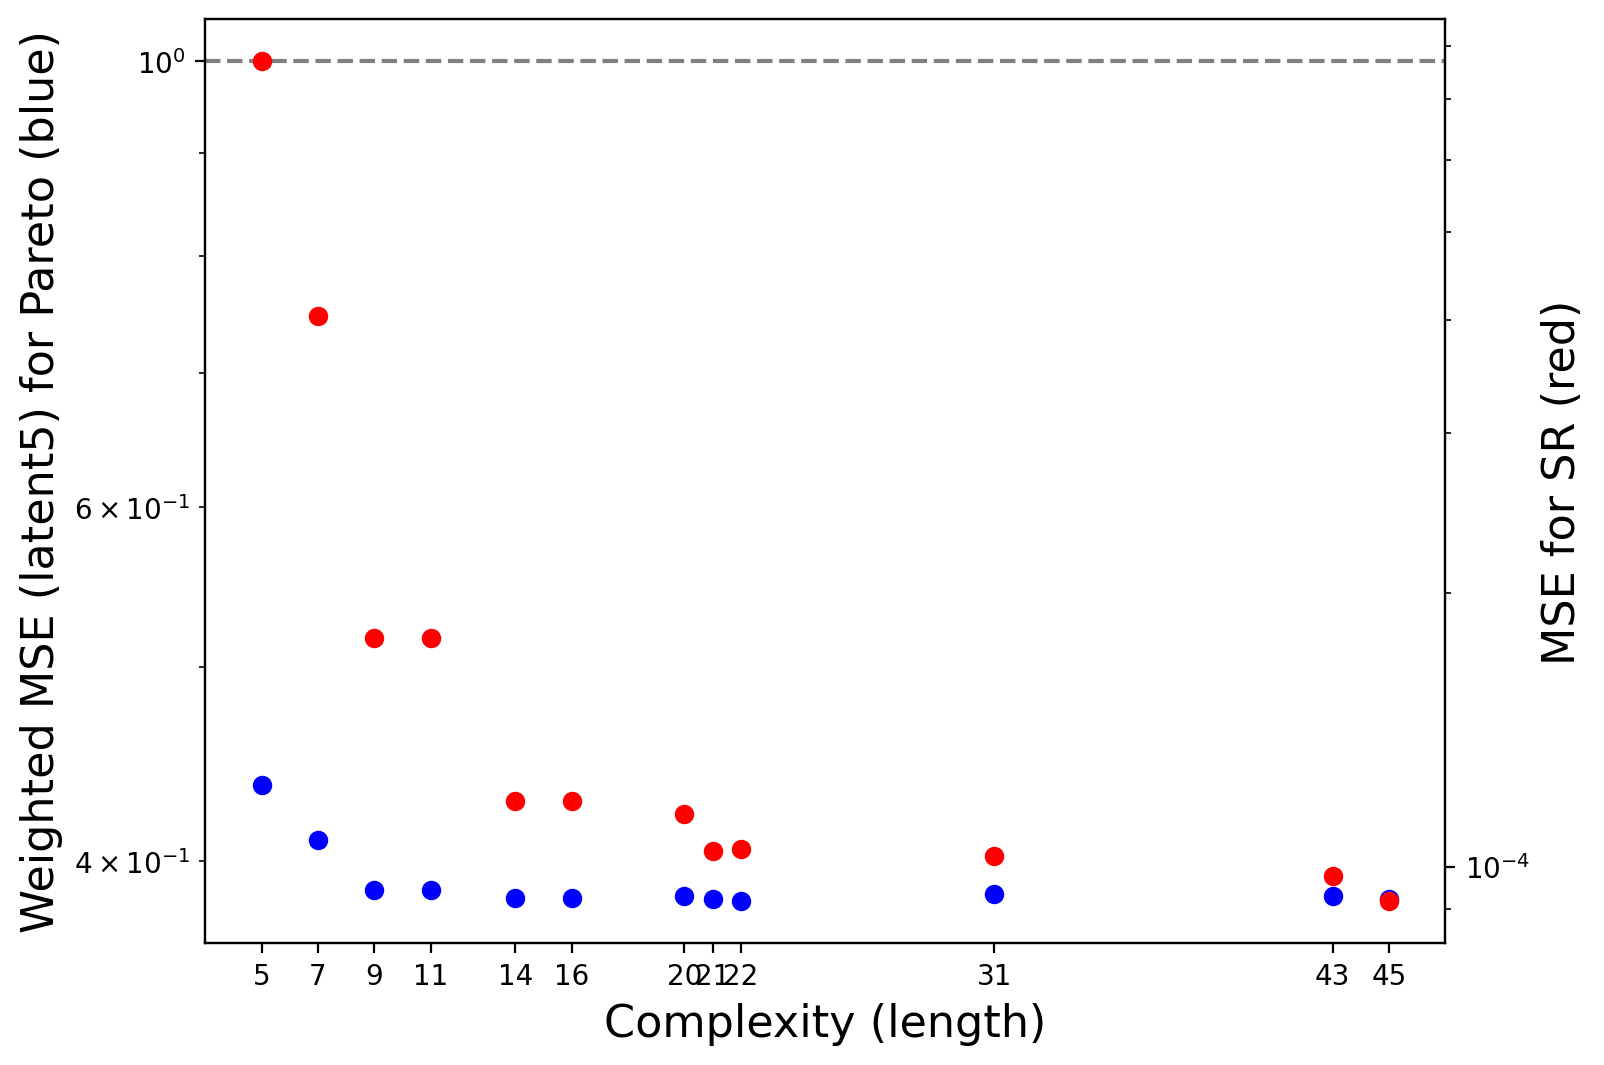

raw expression: ((-0.037) + (3.638 * (0.020 * X5)))
*****


0.07276*X5 - 0.037

***********************************
raw expression: ((-0.001) + (1.000 * (((-0.067) * X6) + (0.073 * X5))))
*****


0.073*X5 - 0.067*X6 - 0.001

***********************************
raw expression: ((-0.017) + (1.007 * (((0.072 * X5) + (0.078 * X2)) + ((-0.094) * X6))))
*****


0.078546*X2 + 0.072504*X5 - 0.094658*X6 - 0.017

***********************************
raw expression: ((-0.000) + (1.000 * (((((-0.095) * X6) + (0.079 * X2)) + (-0.017)) - ((-0.072) * X5))))
*****


0.079*X2 + 0.072*X5 - 0.095*X6 - 0.017

***********************************
raw expression: ((-0.013) + (0.936 * (((((-0.020) * X5) * (((-3.501) * X1) - 2.361)) - (0.111 * X6)) - sin(((-0.084) * X2)))))
*****


-0.01872*X5*(-3.501*X1 - 2.361) - 0.103896*X6 + 0.936*sin(0.084*X2) - 0.013

***********************************
raw expression: (0.000 + (1.000 * ((sin((((-0.005) * X1) * ((-12.758) * X5))) - ((-0.079) * X2)) + (((0.045 * X5) - 0.012) - (0.104 * X6)))))
*****


0.079*X2 + 0.045*X5 - 0.104*X6 + 1.0*sin(0.06379*X1*X5) - 0.012

***********************************
raw expression: ((-0.005) + (0.995 * ((((0.003 * X2) + sin(((-3.229) - ((-0.468) * X6)))) - (((-0.355) * X6) + ((-0.073) * X5))) + (((-0.107) / (sqrt(1 + (2.877 * X2) ^ 2))) / (sqrt(1 + ((-1.549) * X1) ^ 2))))))
*****


0.002985*X2 + 0.072635*X5 + 0.353225*X6 + 0.995*sin(0.468*X6 - 3.229) - 0.005 - 0.0238899685917541/(sqrt(X1**2 + 0.416770685683635)*sqrt(X2**2 + 0.120814838091807))

***********************************
raw expression: ((-0.012) + (0.924 * (((((0.086 * X5) - (((2.148 * X6) / (sqrt(1 + ((-292.708) * X2) ^ 2))) / (sqrt(1 + (0.896 * X5) ^ 2)))) - (0.109 * X6)) - (((-0.061) * X2) - (0.039 * X1))) / (sqrt(1 + (1.261 - (1.986 * X1)) ^ 2)))))
*****


-0.012 + 0.465256797583082*(0.039*X1 + 0.061*X2 + 0.086*X5 - 0.109*X6 - 0.00733837134618801*X6/(sqrt(X2**2 + 1.16716112893882e-5)*sqrt(0.802816*X5**2 + 1)))/sqrt((0.634944612286002 - X1)**2 + 0.253537096026668)

***********************************
raw expression: (0.018 + (1.059 * (((((0.064 * X5) - ((sin(((-0.023) * X2)) + 0.052) / (sqrt(1 + (1.079 * X5) ^ 2)))) - (0.115 * X6)) - (((-0.062) * X2) - (0.051 * X1))) / (sqrt(1 + (1.373 - (2.287 * X1)) ^ 2)))))
*****


0.018 + 0.463052033231307*(0.051*X1 + 0.062*X2 + 0.064*X5 - 0.115*X6 - 0.92678405931418*(0.052 - sin(0.023*X2))/sqrt(X5**2 + 0.858928692598869))/sqrt((0.60034980323568 - X1)**2 + 0.191191099518982)

***********************************
raw expression: ((-0.005) + (0.977 * ((((((((27.102 * X1) + (6.618 * X5)) + (73.906 * X2)) + ((-14.396) * X6)) / (sqrt(1 + ((((486.349 + (3168.040 * X2)) / (sqrt(1 + ((3300160.000 * X4) / (sqrt(1 + ((-6299541569536.000) * X5) ^ 2))) ^ 2))) / (sqrt(1 + (4.272 * X5) ^ 2))) + 45.502) ^ 2))) + (((-0.088) * X6) - 0.020)) / (sqrt(1 + ((-0.335) * X5) ^ 2))) - ((-0.062) * X2))))
*****


0.060574*X2 - 0.005 + 0.977*(-0.088*X6 - 0.02 + 0.0219770559535845*(27.102*X1 + 73.906*X2 + 6.618*X5 - 14.396*X6)/sqrt((0.00514444193670048*(3168.04*X2 + 486.349)/(sqrt(X5**2 + 0.054794568587019)*sqrt(2.74442963263098e-13*X4**2/(X5**2 + 2.5198930445129e-26) + 1)) + 1)**2 + 0.000482990988386982))/sqrt(0.112225*X5**2 + 1)

***********************************
raw expression: (0.000 + (1.005 * (((0.174 / (sqrt(1 + ((-1.525) * X6) ^ 2))) - ((-0.043) * X5)) + ((-0.218) * (2.486 * ((sin(((0.232 * X1) / (sqrt(1 + ((-5.100) * X6) ^ 2)))) * ((((0.619 * X1) * (((1.662 * X5) - (-1.819)) - 1.305)) * (-3.185)) / (sqrt(1 + (-2.303) ^ 2)))) + ((0.008 * X4) - sin(((((-0.382) + (0.153 * X2)) / (sqrt(1 + (((-0.525) * X5) / (sqrt(1 + (43.779 * X5) ^ 2))) ^ 2))) / (sqrt(1 + (0.476 * X5) ^ 2)))))))))))
*****


0.42768325071737*X1*(1.662*X5 + 0.514)*sin(0.0454901960784314*X1/sqrt(X6**2 + 0.0384467512495194)) - 0.00435726192*X4 + 0.043215*X5 + 0.54465774*sin((0.153*X2 - 0.382)/(sqrt(0.226576*X5**2 + 1)*sqrt(0.000143809286787222*X5**2/(X5**2 + 0.000521757049568153) + 1))) + 0.114668852459016/sqrt(X6**2 + 0.429991937651169)

***********************************
raw expression: ((-0.000) + (1.000 * (((((-0.090) * X6) - ((-6.967) * X5)) - (6.910 * X5)) + ((-0.061) * (0.685 * ((sin(((0.031 * X1) / (sqrt(1 + ((-3.576) * X6) ^ 2)))) * ((((0.213 * X1) * (((344.626 * X5) - (-38.889)) - (-38.388))) * ((-141.023) - ((-28.008) * X6))) / (sqrt(1 + (-81.273) ^ 2)))) + ((0.120 * X4) - sin(((((-0.569) + (2.232 * X2)) / (sqrt(1 + ((3506.017 * X5) / (sqrt(1 + ((-33603.613) * X5) ^ 2))) ^ 2))) / (sqrt(1 + (0.004 * X5) ^ 2)))))))))))
*****


-0.000109501696253395*X1*(344.626*X5 + 77.277)*(28.008*X6 - 141.023)*sin(0.00866890380313199*X1/sqrt(X6**2 + 0.0781996806950638)) - 0.0050142*X4 + 0.0569999999999995*X5 - 0.09*X6 + 0.041785*sin((2.232*X2 - 0.569)/(sqrt(1.6e-5*X5**2 + 1)*sqrt(0.0108856931030087*X5**2/(X5**2 + 8.85580512293763e-10) + 1)))

***********************************


In [45]:
torch.manual_seed(43)
import pandas as pd

### Testing function for the retrained model
def test_epoch_replace(encoder, decoder, device, dataloader, loss_fn,maskindex, ind, ind_var):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for (1) batch of 500 testing samples
        conc_out = [] 
        conc_data_mean = [] 
        conc_err = []
        
        # Mask
        range_index=torch.arange(1, d_encode+1)
        mask = range_index.le(maskindex).unsqueeze(0).to(device)

        count = 0

        param = torch.tensor(np.float32(np.load('./data/camb_new_processed/param_%s.npy'%name)))
        data_batch_mean = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_mean_%s.npy'%name)))
        err = torch.tensor(np.float32(np.load('./data/camb_new_processed/error_%s.npy'%name)))
        data_batch = torch.tensor(np.float32(np.load('./data/camb_new_processed/data_%s.npy'%name)))
            
        data_batch = data_batch.to(device)
        param = param.to(device)
        err = err.to(device)
        #data = data.to(device)
        
        # Encode data
        encoded_data= encoder(param)
        maskin_data = maskin(encoded_data)
        
        # Replacement
        sr_pred_i = sr_pred[ind] # Dimension: each ind has 500, the # of the testing samples
        maskin_data[:,ind_var] = sr_pred_i.to(device)
        
        # Decode data
        decoded_data = decoder(maskin_data*mask)
        
        conc_out.append(trans(decoded_data.cpu()))
        conc_data_mean.append(trans(data_batch_mean[:,:]))
        conc_err.append(trans_error(trans(data_batch.cpu()[:,:]),err.cpu()))
                               
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_data_mean = torch.cat(conc_data_mean)
        conc_err = torch.cat(conc_err)

        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_data_mean[:,:],conc_err)
    return val_loss.data

### Define the loss function
#loss_fn = torch.nn.MSELoss()
def loss_fn(output, target, weight):
    loss = torch.mean((output - target)**2/weight)
    return loss

encoder = Encoder_cmb(encoded_space_dim=d_encode)
decoder = Decoder_cmb(encoded_space_dim=d_encode)
maskin = maskin_cmb()

model_state_save_early_path_checkpoint ='./model/checkpoint_%s.tar'%(name)
checkpoint_model = torch.load(model_state_save_early_path_checkpoint)
encoder.load_state_dict(checkpoint_model['encoder_state_dict'])
decoder.load_state_dict(checkpoint_model['decoder_state_dict'])
maskin.load_state_dict(checkpoint_model['maskin_state_dict'])

encoder.eval()
encoder.to(device)
decoder.eval()
decoder.to(device)
maskin.eval()
maskin.to(device)

maskindex = 6

for ind_var in range(maskindex):
    test_name = operon_name+'latent%d'%ind_var # index of the latent variable
    test_losses_onloader_onemodel_parato=[]
    
    # Symbolic regression (sr) predictions
    # sr prediction: [len(expressions),500]
    sr_pred = torch.tensor(np.float32(np.load('./data/sr/pred_pareto_%s.npy'%test_name))) 
    # mse: [len(expressions),]
    mse_pred = np.load('./data/sr/mse_pareto_%s.npy'%test_name) 
    # expressions: [len(expressions),]
    data0=pd.read_csv('./data/sr/pareto_%s.csv'%test_name) 

    # Lengh of the points in the parato front
    num_plot = len(sr_pred)
    for ind in range(num_plot):
        temp=test_epoch_replace(encoder, decoder, device, test_loader, loss_fn,maskindex, ind, ind_var) # Here the test_loader
        test_losses_onloader_onemodel_parato.append(np.array(temp))
        
    # Complexity of the expressions
    complexity=pd.read_csv('./data/sr/pareto_%s.csv'%test_name)['length'].values
    
    ### Plot the results
    # The weighted loss
    fig,ax = plt.subplots(figsize=(8,6))
    ax.scatter(complexity[:num_plot],test_losses_onloader_onemodel_parato, c='blue')
    ax.set_xlabel('Complexity (length)',fontsize=16)
    ax.set_ylabel('Weighted MSE (latent%d) for Pareto (blue)'%ind_var,fontsize=16)
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.axhline(1., color="grey", linestyle="--") # The threshold for the weighted error (likelihood)
    plt.xticks(list(np.sort(complexity)))

    # Create a second axis for the mse plots
    ax2=ax.twinx()
    ax2.scatter(complexity[:num_plot],mse_pred,color='r')
    ax2.set_yscale('log')
    ax2.set_ylabel('MSE for SR (red)',fontsize=16)
    
    print ('The weighted MSE:',np.array(test_losses_onloader_onemodel_parato))
    plt.show()
    plt.close()
    for i in range(len(complexity)):
        print ('raw expression:',data0['infix'][i])
        print ('*****')
        pprint (data0['infix'][i].replace('^','**'))
        print ('***********************************')

#### Inspect the individual expression from operon 
Totally 2000 expressions for each latent. Might be computationally expensive, set a proper `interval` value which just thin the number of expressions

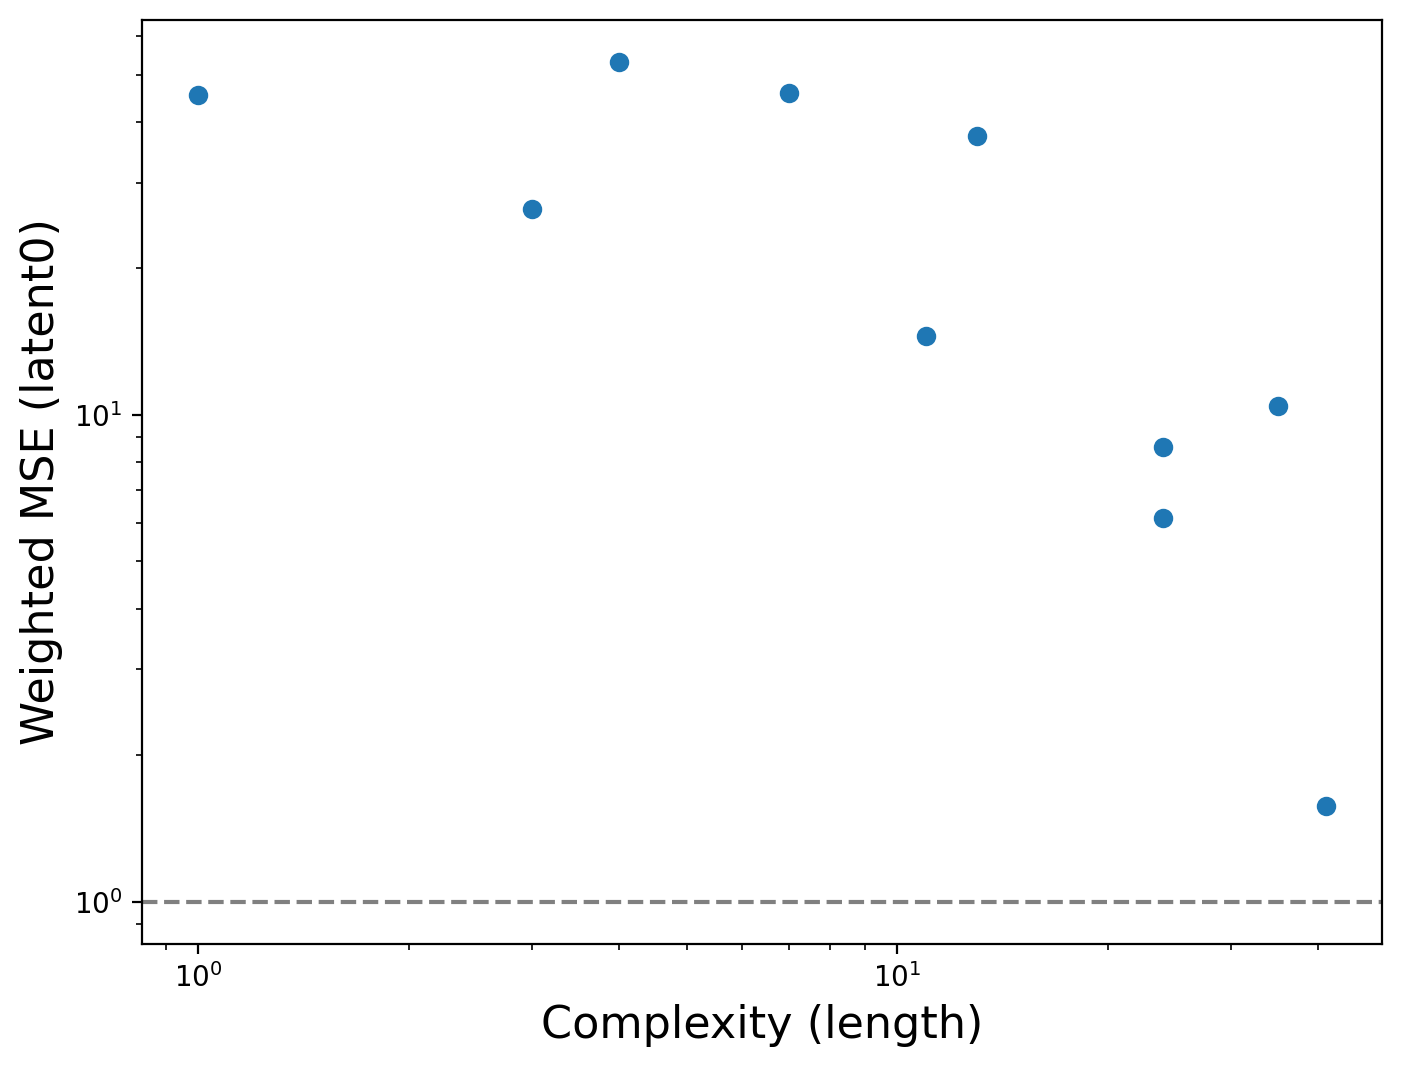

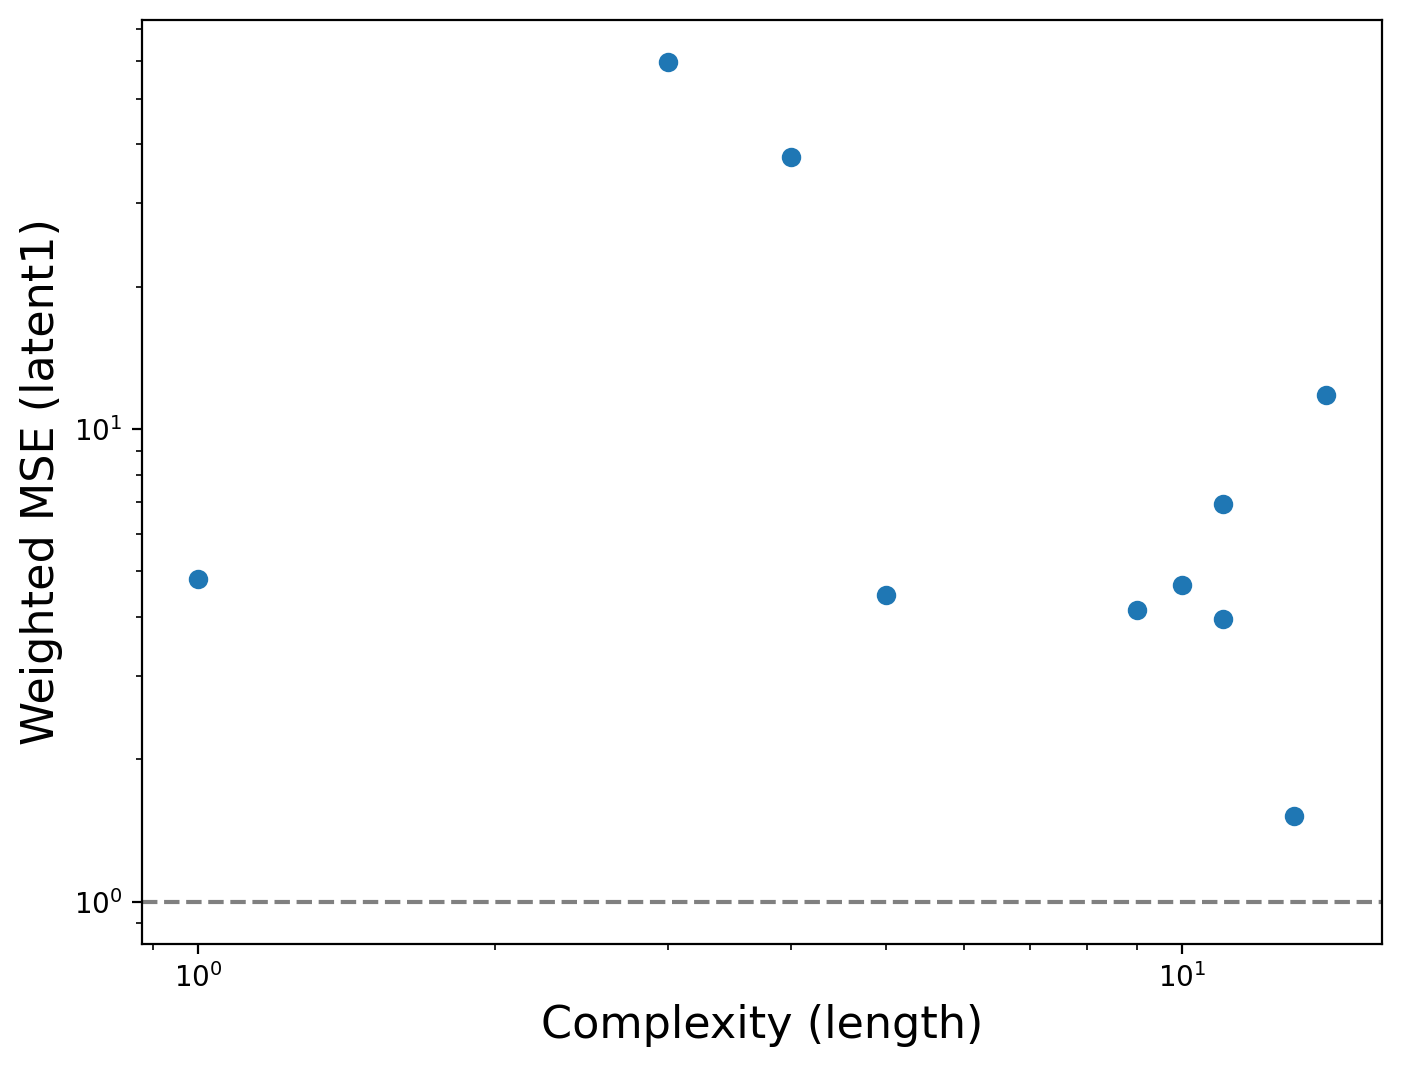

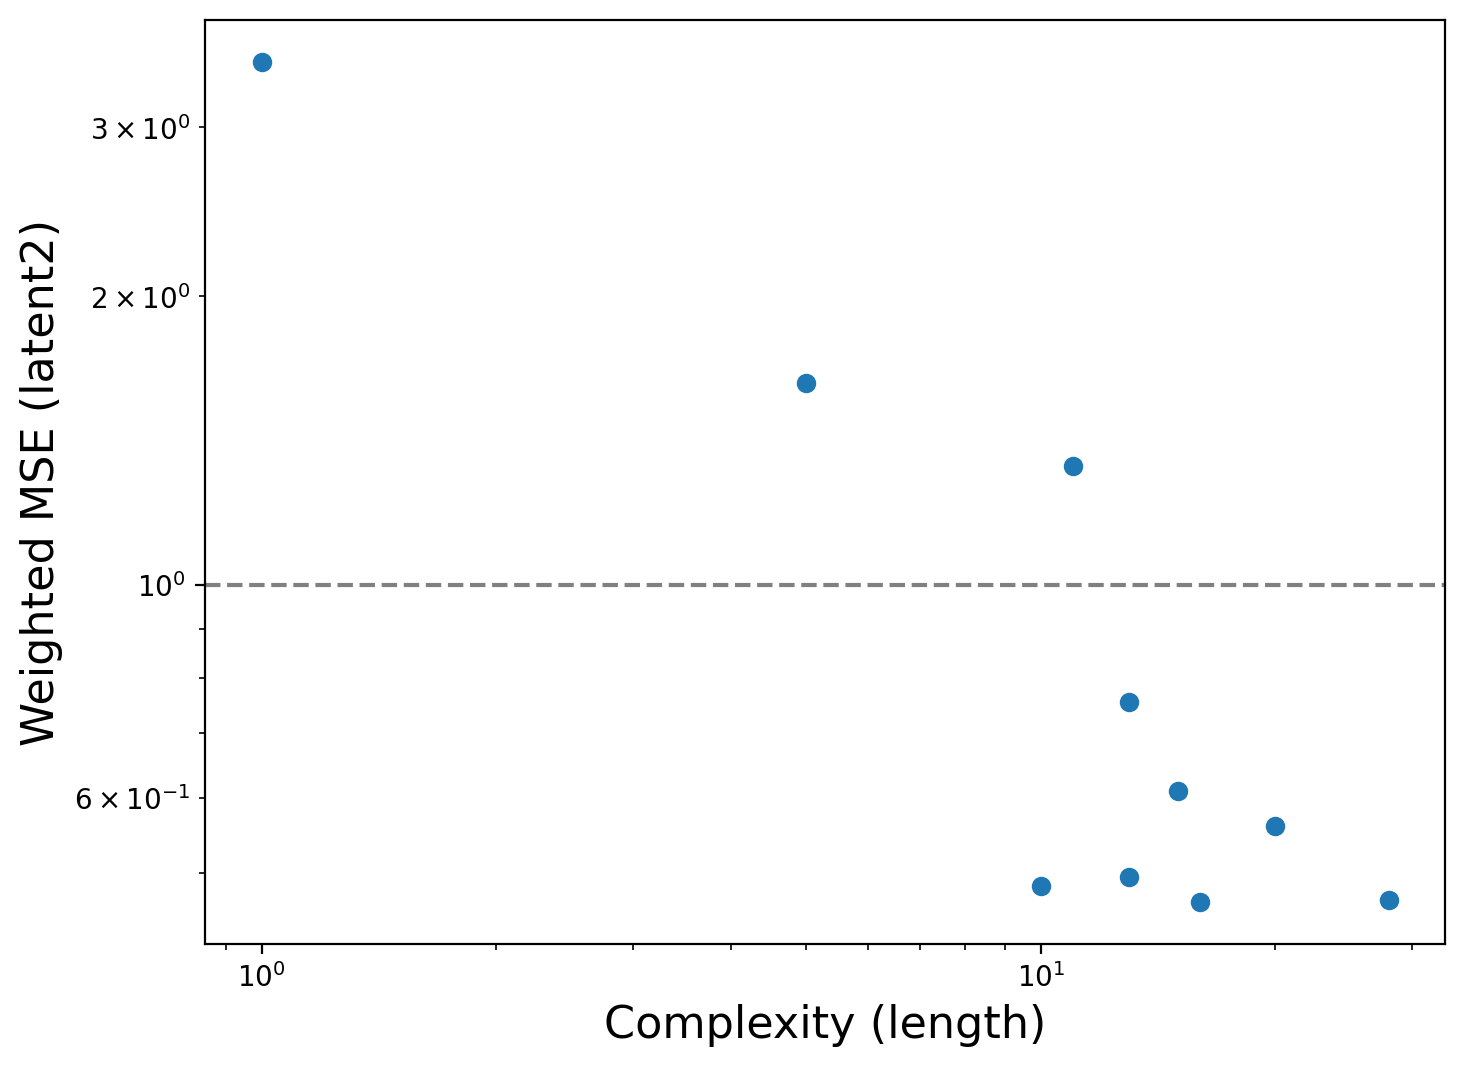

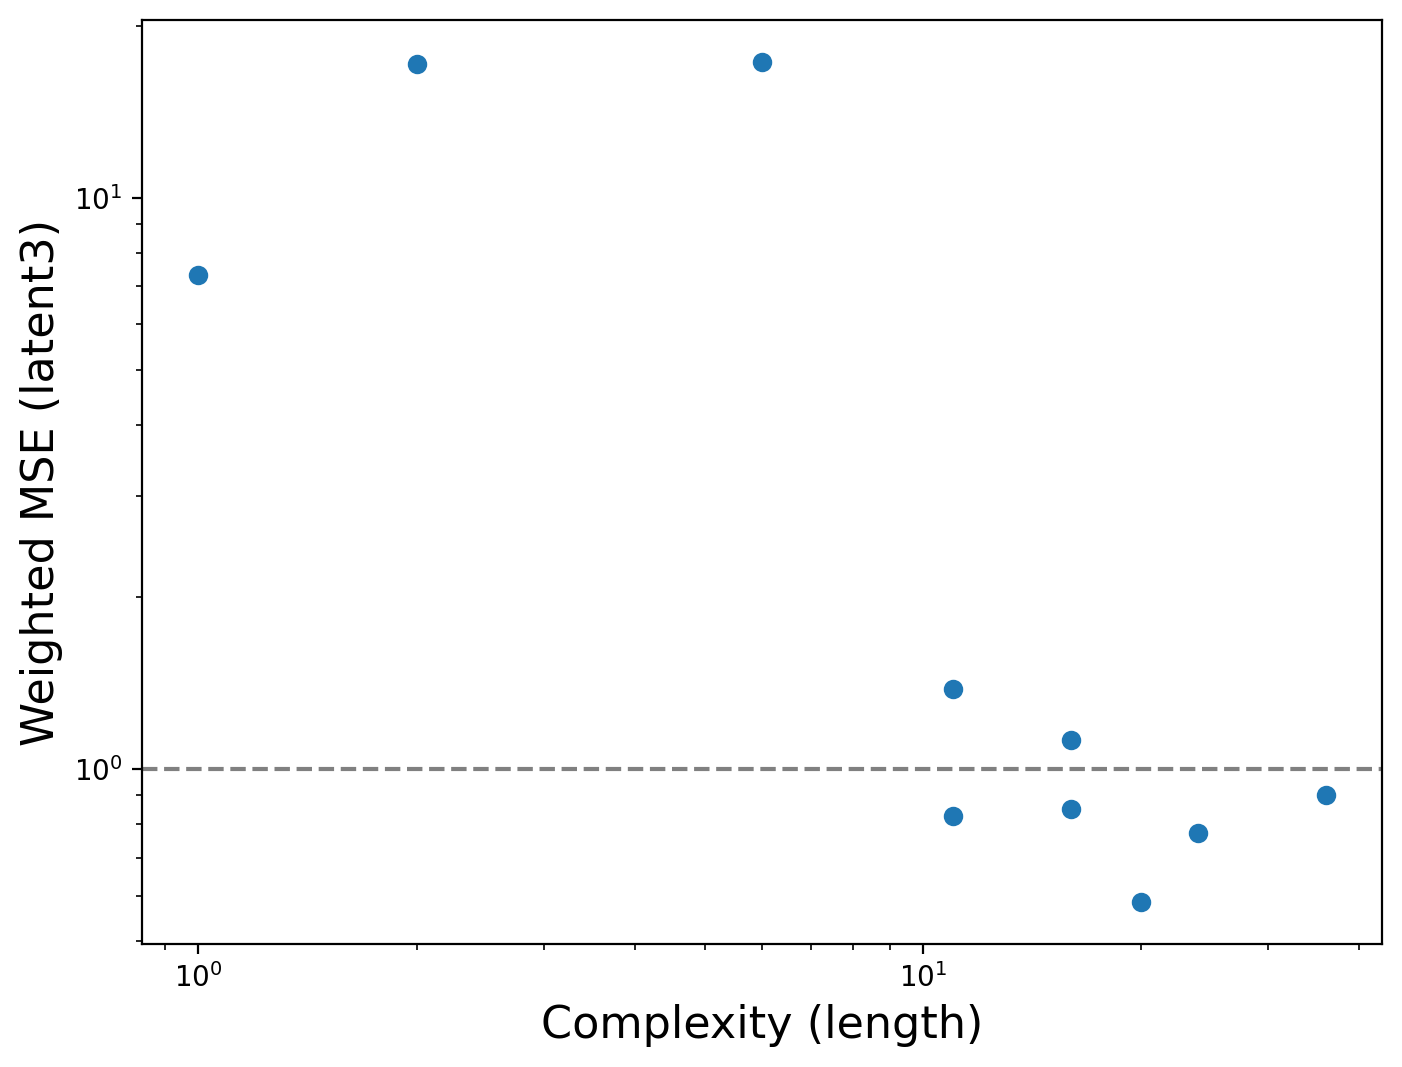

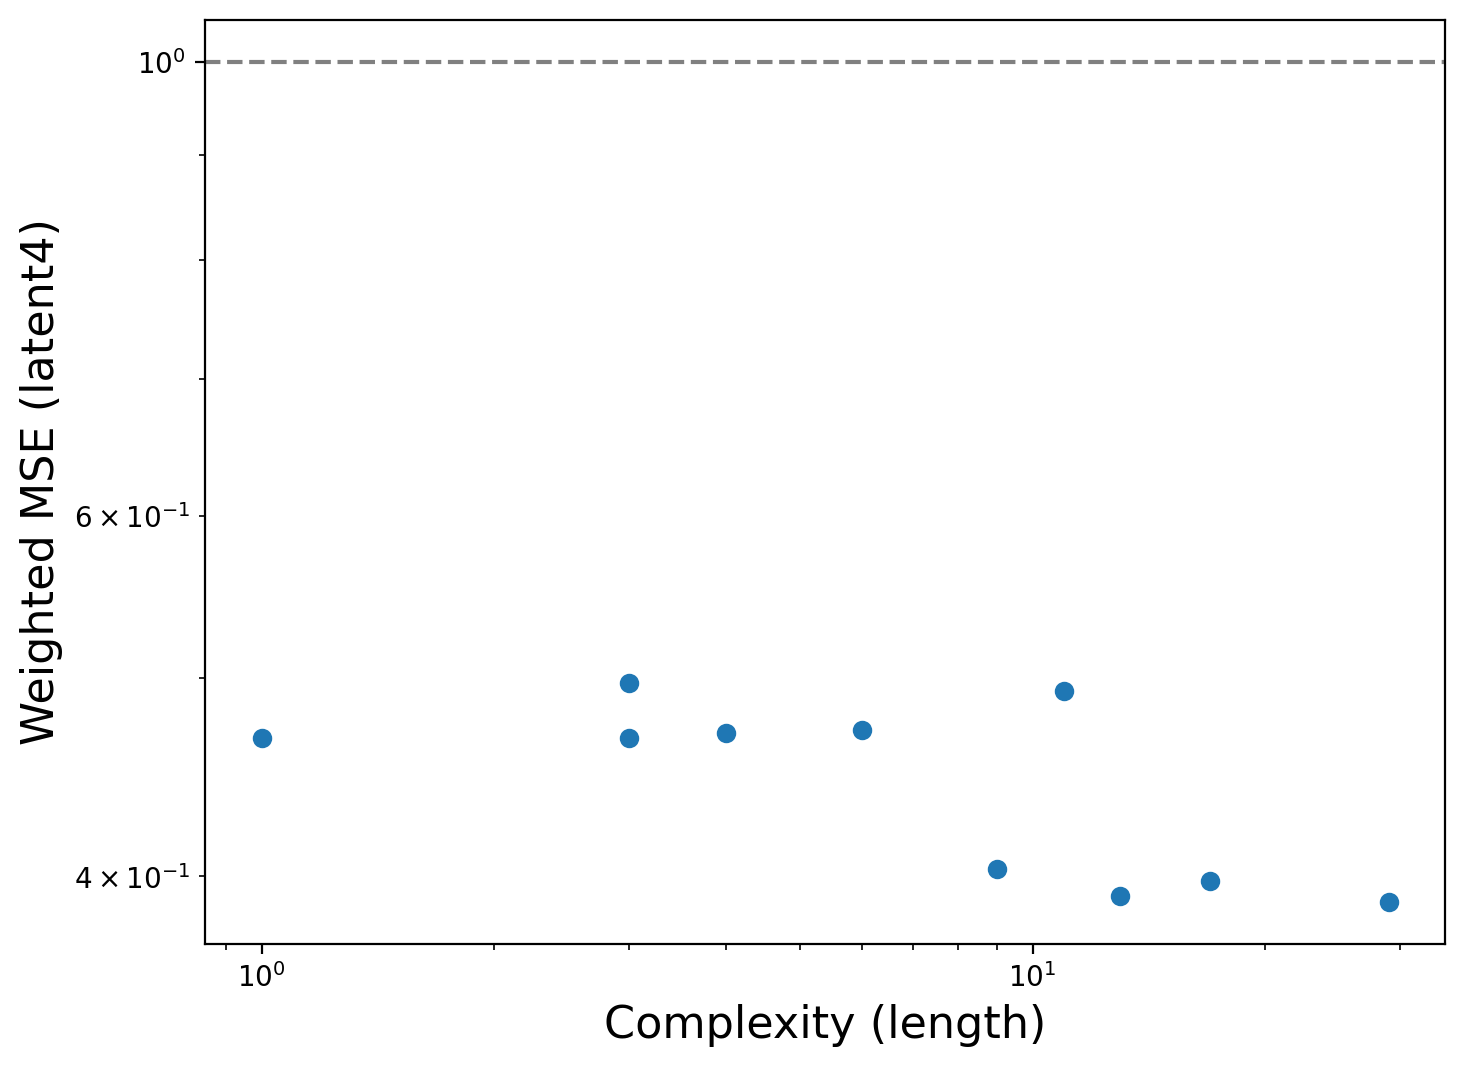

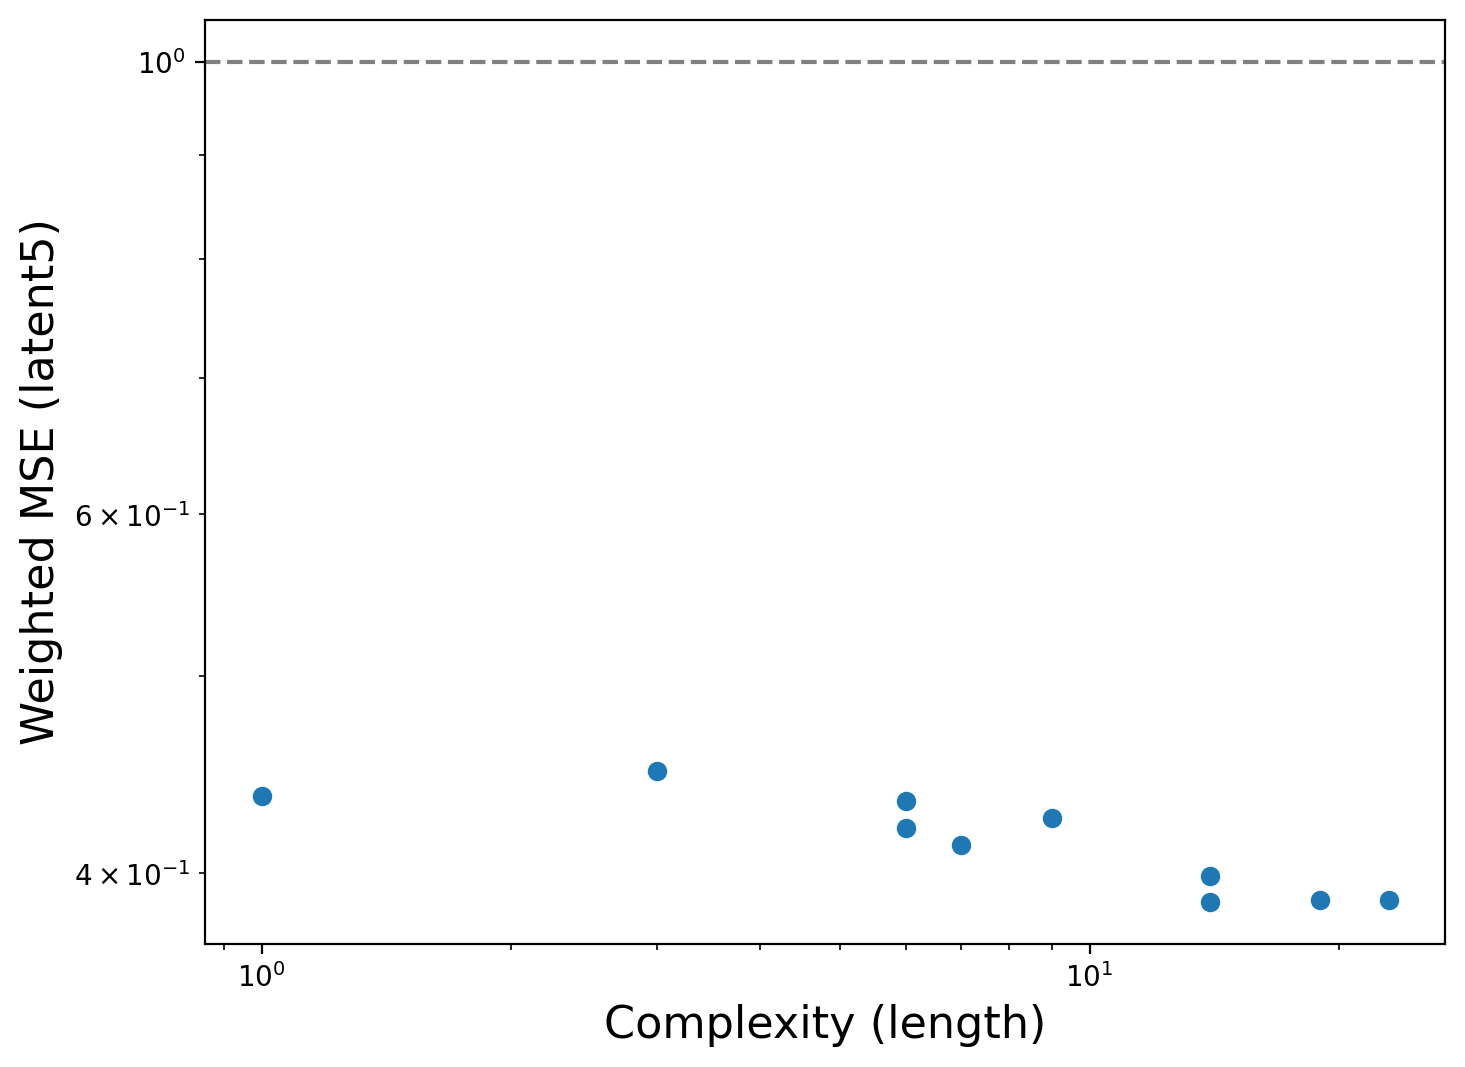

In [54]:
maskindex = 6
interval=1 # 200 for fewer computational costs
for ind_var in range(maskindex):
    test_name = operon_name+'latent%d'%ind_var
    test_losses_onloader_onemodel_individual=[]
    
    # sr prediction: [len(expressions),500], i.e. [2000,500]
    sr_pred = torch.tensor(np.float32(np.load('./data/sr/pred_individuals_%s.npy'%test_name)))
    num_plot = 2000 #10 # number of individuals in the operon setting is 2000
    for ind in range(0,num_plot,interval):
        temp=test_epoch_replace(encoder, decoder, device, test_loader, loss_fn,maskindex, ind, ind_var) # Here the test_loader
        test_losses_onloader_onemodel_individual.append(temp)
        
    complexity=pd.read_csv('./data/sr/individuals_%s.csv'%test_name)['length'].values[::interval]
    ### Plot the results
    fig,ax = plt.subplots(figsize=(8,6))
    ax.scatter(complexity,test_losses_onloader_onemodel_individual)
    ax.set_xlabel('Complexity (length)',fontsize=16)
    ax.set_ylabel('Weighted MSE (latent%d)'%ind_var,fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axhline(1., color="grey", linestyle="--") # The threshold for the weighted error (likelihood)
    #ax.legend(fontsize=11)
    plt.show()
    plt.close()